## Historical Prices of Cryptocurrency
Ashwin Jeyaseelan, Evan Kerekanich

### Introduction
Recently, a cryptocurrency called bitcoin has become a hot topic, but what is it? Bitcoin is the first digital currency which allows the transfer of currency between people without a third party. It was created in 2009 by an unknown person with the alias, Satoshi Nakamoto. It can be used to buy merchandice just like normal currency. Surprisingly, bitcoin has built up a large enough community that markets run competitions where participants are rewarded with bitcoins in exchange of solving complex math puzzles. 

The purpose of this tutorial is to understand the trend of bitcoin prices to help users decide if it's worth participating with. We will show how to gather, parse, analyze, and conduct hypothesis testing on the data. Finally, we will use machine learning to provide analysis about the bitcoin prices.

### Getting Started 
First download the bitcoin data from: https://www.kaggle.com/myonin/bitcoin-price-prediction-by-arima/data. Next we will load the bitcoin data file with the library, Pandas. This data contains information about 1-minute bitcoin exchanges from Jan 2012 to October 2017. 

#### Required Tools:
* Python 3.5+
* Pandas
* numpy 
* matplotlib 


In [1]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import statsmodels.api as sm

# Load data:
table = pd.read_csv("bitcoin-historical-data/btceUSD_1-min_data_2012-01-01_to_2017-05-31.csv")
# Print the first 5 rows of our data:
table.head()

/Users/ashwinjeyaseelan/Documents/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325292180,4.247,4.247,4.247,4.247,0.4,1.6988,4.247
1,1325292240,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325292300,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325292360,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325292420,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Looking at our data, we can see the features: Timestamp (unix time), open (opening or starting price of the bitcoin), high (highest price in the minute), low (lowest price in the minute), close (the closing price of the bitcoin), volume and the weighted price.

#### Tidying Our Data
In the head of the table, notice that only one of the rows has succificent data to properly analyze the features. We can save space and time by getting rid of rows that are missing data for features.

In [2]:
# drop rows with NaN for any of their features
table = table.dropna()
# view the first 5 rows of the tidy table:
table.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325292180,4.247,4.247,4.247,4.247,0.400000,1.698800,4.247000
138,1325300460,4.100,4.100,4.100,4.100,0.623628,2.556875,4.100000
212,1325304900,4.100,4.100,4.100,4.100,6.503072,26.662595,4.100000
284,1325309220,4.045,4.045,4.044,4.044,2.379300,9.624254,4.044994
311,1325310840,4.044,4.044,4.011,4.011,0.896400,3.607223,4.024122


### Data Analysis
Now that we've prepared our data, we can analyze it. Let's prepare plots to view the prices by days, months, and years.


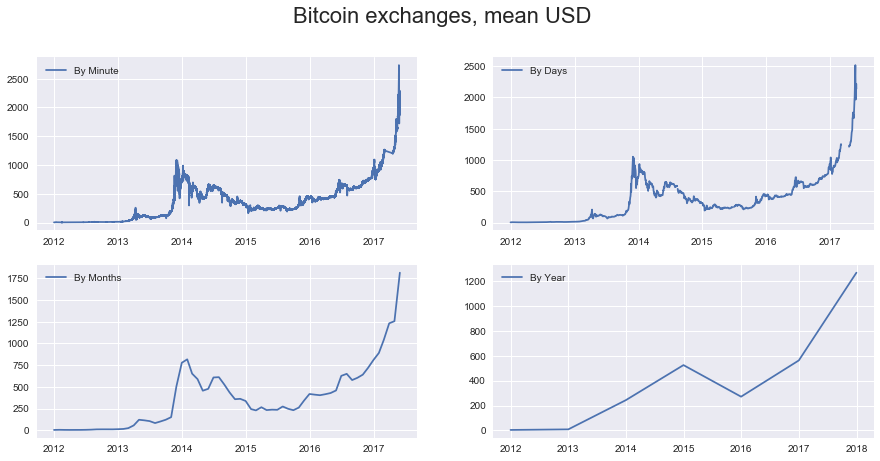

In [66]:
fig = plt.figure(figsize=[15,7])
plt.suptitle('Bitcoin exchanges, mean USD', fontsize=22)

# minute plot:
plt.subplot(221)
plt.plot(table.Weighted_Price, label='By Minute')
plt.legend()

table.Timestamp = pd.to_datetime(table.Timestamp, unit='s')
table.index = table.Timestamp

# Day plot:
table_day = table.resample('D').mean()
plt.subplot(222)
plt.plot(table_day.Weighted_Price, label='By Days')
plt.legend()

# month plot:
plt.subplot(223)
table_month = table.resample('M').mean()
plt.plot(table_month.Weighted_Price, label='By Months')
plt.legend()

# year plot:
plt.subplot(224)
table_year = table.resample('A-DEC').mean()
plt.plot(table_year.Weighted_Price, label='By Year')
plt.legend()

plt.show()


From looking at the data, we can see that that the price has its first peak around 2015, and rapidly increases after 2016. In the day minute plot, you can see more oscillations in the line. This makes sense, because in the smallest unit of time, the fluctuations reflect how rapidly it changes at every minute. After 2017, the prices of bitcoins increase much faster than in any previous year. 

### Machine Learning
Looking back at our bitcoin exchanges subplots, we can clearly see that the prices aren't increasing linearly over time. The bitcoin prices can be modeled better as a polynomial function of our features. 

#### Neural Network
We will use a neural network to model prices as a function of our seven features. A neural network can model can be used to model non convex functions. As you can see our prices are neither a perfect polynomial function of time nor are they a linear function, which makes a neural network a good choice for our objective. 

A neural network is composed of layers of units, each of which compute a weighted sum of incoming inputs. After applying a function to this weighted sum, known as the activation function, the unit passes its output to the outputs in the next layer. The last unit to receive the outputs of the units in the last layer returns the output. Our goal is to fine tune the weights of the network so our final output is more accurate. 

Think of a neural network as a model that learns from examples. When you initially feed data into the network, it doesn't know anything so it returns random output. Hence, we train the network after it makes a prediction. This is done by comparing the output of the network with the label or correct answer (in our case this will be the price). In order to decrease the loss of the function, we find the weights that minimize our loss. Neural networks train through backpropagation, in which the slope of the loss function with respect to the weights multiplied by the learning rate parameter is subtracted from the weights. The slope is subtracted from the weights so they can travel in the direction opposite of the increasing slope, i.e. down the slope and hopefully towards the minimum point of the funtion. 

In [101]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

# create a network with three layers. The first two layers will have 100 units.
class NeuralNet(nn.Module):
    def __init__(self, num_features):
        super(NeuralNet, self).__init__()
        self.n1 = nn.BatchNorm1d(num_features)
        self.fc1 = nn.Linear(num_features, 100)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(100, 100)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(100, 1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        out = self.fc1(self.n1(x))
        out = self.fc2(out)
        out = self.fc3(out)
        return out 

# since we have 7 features (excluding our label which is Weighted_price), our input size is 7
net = NeuralNet(7)

Now that we've created our neural network, we can train it on our data. We will use 20% of the data for testing, and 80% for training. 

In [102]:
# Split the data into training and test data:
table = pd.read_csv("bitcoin-historical-data/btceUSD_1-min_data_2012-01-01_to_2017-05-31.csv")
table = table.dropna()

table = table.reset_index(drop=True)
divider = np.random.rand(len(table)) < 0.8
train_table = table[divider]
test_table = table[~divider]

train_data = train_table.as_matrix().astype('float')
test_data = test_table.as_matrix().astype('float')

# Loss function:
criterion = nn.MSELoss()
# Optimizer: (either use backpropagation or a variant of it to speed learning)
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

# epochs: how many iterations we want to train for 
num_epochs = 20
# batch size : number of examples we want to use per training update 
batch_size = 500
# number of splits: how many groups of batches we will use:
num_batches = train_data.size // batch_size
# split the data into batches 
batches =  np.array_split(train_data, num_batches)

# Train the model:
for epoch in range(num_epochs):
    for i, batch in enumerate(batches):
        # want all columns except last column for inputs. Convert it to pytorch's Variable 
        inputs = Variable(torch.from_numpy(batch[:,:-1]).float())
        # last column - our price is the label 
        labels = Variable(torch.from_numpy(batch[:,-1]).float()) 
        
        optimizer.zero_grad()  # zero the gradient buffer
        outputs = net(inputs) # get the output of the network
        
        loss = criterion(outputs, labels) # compute the loss 
        loss.backward() # update the weights of the neural network
        optimizer.step()
        
        if (i+1) % 100 == 0: # Print out our loss
            print ('Epoch [%d/%d], Step [%d/%d], Loss: %.4f' 
                   %(epoch+1, num_epochs, i+1, len(train_data)//batch_size, loss.data[0]))


Epoch [1/100], Step [100/6235], Loss: 0.0780
Epoch [1/100], Step [200/6235], Loss: 0.0324
Epoch [1/100], Step [300/6235], Loss: 0.0090
Epoch [1/100], Step [400/6235], Loss: 0.0028
Epoch [1/100], Step [500/6235], Loss: 0.0059
Epoch [1/100], Step [600/6235], Loss: 0.0309
Epoch [1/100], Step [700/6235], Loss: 0.1533
Epoch [1/100], Step [800/6235], Loss: 0.4071
Epoch [1/100], Step [900/6235], Loss: 0.0015
Epoch [1/100], Step [1000/6235], Loss: 0.0015
Epoch [1/100], Step [1100/6235], Loss: 0.0524
Epoch [1/100], Step [1200/6235], Loss: 0.0278
Epoch [1/100], Step [1300/6235], Loss: 0.0042
Epoch [1/100], Step [1400/6235], Loss: 0.0853
Epoch [1/100], Step [1500/6235], Loss: 0.0091
Epoch [1/100], Step [1600/6235], Loss: 0.0618
Epoch [1/100], Step [1700/6235], Loss: 0.0641
Epoch [1/100], Step [1800/6235], Loss: 0.2715
Epoch [1/100], Step [1900/6235], Loss: 0.0556
Epoch [1/100], Step [2000/6235], Loss: 0.7953
Epoch [1/100], Step [2100/6235], Loss: 0.3588
Epoch [1/100], Step [2200/6235], Loss: 0.48

Epoch [1/100], Step [17600/6235], Loss: 0.2907
Epoch [1/100], Step [17700/6235], Loss: 118.0996
Epoch [1/100], Step [17800/6235], Loss: 129.4409
Epoch [1/100], Step [17900/6235], Loss: 7.8929
Epoch [1/100], Step [18000/6235], Loss: 12.2196
Epoch [1/100], Step [18100/6235], Loss: 6.7899
Epoch [1/100], Step [18200/6235], Loss: 5.8394
Epoch [1/100], Step [18300/6235], Loss: 32.9528
Epoch [1/100], Step [18400/6235], Loss: 1.4162
Epoch [1/100], Step [18500/6235], Loss: 4.0618
Epoch [1/100], Step [18600/6235], Loss: 2.4343
Epoch [1/100], Step [18700/6235], Loss: 2.0049
Epoch [1/100], Step [18800/6235], Loss: 59.6816
Epoch [1/100], Step [18900/6235], Loss: 22.0218
Epoch [1/100], Step [19000/6235], Loss: 0.5886
Epoch [1/100], Step [19100/6235], Loss: 3.4150
Epoch [1/100], Step [19200/6235], Loss: 4.2665
Epoch [1/100], Step [19300/6235], Loss: 1.2758
Epoch [1/100], Step [19400/6235], Loss: 88.4231
Epoch [1/100], Step [19500/6235], Loss: 194.7514
Epoch [1/100], Step [19600/6235], Loss: 36.0546
E

Epoch [1/100], Step [35100/6235], Loss: 1.8346
Epoch [1/100], Step [35200/6235], Loss: 0.4792
Epoch [1/100], Step [35300/6235], Loss: 0.0598
Epoch [1/100], Step [35400/6235], Loss: 16.4021
Epoch [1/100], Step [35500/6235], Loss: 15.4232
Epoch [1/100], Step [35600/6235], Loss: 0.7056
Epoch [1/100], Step [35700/6235], Loss: 0.0223
Epoch [1/100], Step [35800/6235], Loss: 1.6569
Epoch [1/100], Step [35900/6235], Loss: 18.1127
Epoch [1/100], Step [36000/6235], Loss: 12.4237
Epoch [1/100], Step [36100/6235], Loss: 4.6593
Epoch [1/100], Step [36200/6235], Loss: 1.6781
Epoch [1/100], Step [36300/6235], Loss: 7.0382
Epoch [1/100], Step [36400/6235], Loss: 9.9184
Epoch [1/100], Step [36500/6235], Loss: 24.6607
Epoch [1/100], Step [36600/6235], Loss: 0.1067
Epoch [1/100], Step [36700/6235], Loss: 0.0609
Epoch [1/100], Step [36800/6235], Loss: 28.2056
Epoch [1/100], Step [36900/6235], Loss: 0.0607
Epoch [1/100], Step [37000/6235], Loss: 0.2514
Epoch [1/100], Step [37100/6235], Loss: 0.7460
Epoch [

Epoch [2/100], Step [2700/6235], Loss: 52.1671
Epoch [2/100], Step [2800/6235], Loss: 105.7661
Epoch [2/100], Step [2900/6235], Loss: 8.2305
Epoch [2/100], Step [3000/6235], Loss: 7.4818
Epoch [2/100], Step [3100/6235], Loss: 44.2616
Epoch [2/100], Step [3200/6235], Loss: 19.5237
Epoch [2/100], Step [3300/6235], Loss: 1.0932
Epoch [2/100], Step [3400/6235], Loss: 2.5474
Epoch [2/100], Step [3500/6235], Loss: 2.1452
Epoch [2/100], Step [3600/6235], Loss: 13.4662
Epoch [2/100], Step [3700/6235], Loss: 0.3592
Epoch [2/100], Step [3800/6235], Loss: 0.0099
Epoch [2/100], Step [3900/6235], Loss: 0.0340
Epoch [2/100], Step [4000/6235], Loss: 0.0396
Epoch [2/100], Step [4100/6235], Loss: 0.1954
Epoch [2/100], Step [4200/6235], Loss: 1.2354
Epoch [2/100], Step [4300/6235], Loss: 0.8732
Epoch [2/100], Step [4400/6235], Loss: 0.6032
Epoch [2/100], Step [4500/6235], Loss: 11.7346
Epoch [2/100], Step [4600/6235], Loss: 13.3322
Epoch [2/100], Step [4700/6235], Loss: 0.5139
Epoch [2/100], Step [4800/

Epoch [2/100], Step [20100/6235], Loss: 0.2320
Epoch [2/100], Step [20200/6235], Loss: 5.8935
Epoch [2/100], Step [20300/6235], Loss: 0.1472
Epoch [2/100], Step [20400/6235], Loss: 16.1445
Epoch [2/100], Step [20500/6235], Loss: 8.6337
Epoch [2/100], Step [20600/6235], Loss: 117.0963
Epoch [2/100], Step [20700/6235], Loss: 6.4112
Epoch [2/100], Step [20800/6235], Loss: 18.4003
Epoch [2/100], Step [20900/6235], Loss: 22.5424
Epoch [2/100], Step [21000/6235], Loss: 1.4978
Epoch [2/100], Step [21100/6235], Loss: 0.2525
Epoch [2/100], Step [21200/6235], Loss: 40.8741
Epoch [2/100], Step [21300/6235], Loss: 0.3746
Epoch [2/100], Step [21400/6235], Loss: 0.4735
Epoch [2/100], Step [21500/6235], Loss: 0.0785
Epoch [2/100], Step [21600/6235], Loss: 18.5154
Epoch [2/100], Step [21700/6235], Loss: 1.0322
Epoch [2/100], Step [21800/6235], Loss: 45.4503
Epoch [2/100], Step [21900/6235], Loss: 9.0990
Epoch [2/100], Step [22000/6235], Loss: 3.8240
Epoch [2/100], Step [22100/6235], Loss: 6.1347
Epoch

Epoch [2/100], Step [37500/6235], Loss: 2.7063
Epoch [2/100], Step [37600/6235], Loss: 1.0668
Epoch [2/100], Step [37700/6235], Loss: 4.6281
Epoch [2/100], Step [37800/6235], Loss: 8.1385
Epoch [2/100], Step [37900/6235], Loss: 0.3218
Epoch [2/100], Step [38000/6235], Loss: 1.4517
Epoch [2/100], Step [38100/6235], Loss: 3.3171
Epoch [2/100], Step [38200/6235], Loss: 0.2285
Epoch [2/100], Step [38300/6235], Loss: 5.9507
Epoch [2/100], Step [38400/6235], Loss: 0.2003
Epoch [2/100], Step [38500/6235], Loss: 0.5963
Epoch [2/100], Step [38600/6235], Loss: 0.2050
Epoch [2/100], Step [38700/6235], Loss: 0.0386
Epoch [2/100], Step [38800/6235], Loss: 4.3470
Epoch [2/100], Step [38900/6235], Loss: 122.4939
Epoch [2/100], Step [39000/6235], Loss: 16.0020
Epoch [2/100], Step [39100/6235], Loss: 12.8287
Epoch [2/100], Step [39200/6235], Loss: 0.5479
Epoch [2/100], Step [39300/6235], Loss: 14.4049
Epoch [2/100], Step [39400/6235], Loss: 146.0231
Epoch [2/100], Step [39500/6235], Loss: 46.6554
Epoch

Epoch [3/100], Step [5100/6235], Loss: 2.5681
Epoch [3/100], Step [5200/6235], Loss: 4.3853
Epoch [3/100], Step [5300/6235], Loss: 0.1673
Epoch [3/100], Step [5400/6235], Loss: 0.0967
Epoch [3/100], Step [5500/6235], Loss: 0.6217
Epoch [3/100], Step [5600/6235], Loss: 0.4521
Epoch [3/100], Step [5700/6235], Loss: 0.2736
Epoch [3/100], Step [5800/6235], Loss: 0.7133
Epoch [3/100], Step [5900/6235], Loss: 0.1345
Epoch [3/100], Step [6000/6235], Loss: 0.1767
Epoch [3/100], Step [6100/6235], Loss: 0.6540
Epoch [3/100], Step [6200/6235], Loss: 3.0591
Epoch [3/100], Step [6300/6235], Loss: 0.1553
Epoch [3/100], Step [6400/6235], Loss: 0.3516
Epoch [3/100], Step [6500/6235], Loss: 0.0413
Epoch [3/100], Step [6600/6235], Loss: 3.9403
Epoch [3/100], Step [6700/6235], Loss: 0.1795
Epoch [3/100], Step [6800/6235], Loss: 2.0934
Epoch [3/100], Step [6900/6235], Loss: 1.2029
Epoch [3/100], Step [7000/6235], Loss: 0.8544
Epoch [3/100], Step [7100/6235], Loss: 0.4098
Epoch [3/100], Step [7200/6235], L

Epoch [3/100], Step [22500/6235], Loss: 176.0634
Epoch [3/100], Step [22600/6235], Loss: 20.8013
Epoch [3/100], Step [22700/6235], Loss: 2.1561
Epoch [3/100], Step [22800/6235], Loss: 2.6071
Epoch [3/100], Step [22900/6235], Loss: 12.1384
Epoch [3/100], Step [23000/6235], Loss: 7.0434
Epoch [3/100], Step [23100/6235], Loss: 0.4064
Epoch [3/100], Step [23200/6235], Loss: 25.2203
Epoch [3/100], Step [23300/6235], Loss: 20.1176
Epoch [3/100], Step [23400/6235], Loss: 0.5409
Epoch [3/100], Step [23500/6235], Loss: 0.2797
Epoch [3/100], Step [23600/6235], Loss: 43.2667
Epoch [3/100], Step [23700/6235], Loss: 0.7441
Epoch [3/100], Step [23800/6235], Loss: 0.0363
Epoch [3/100], Step [23900/6235], Loss: 6.8923
Epoch [3/100], Step [24000/6235], Loss: 5.1035
Epoch [3/100], Step [24100/6235], Loss: 3.6811
Epoch [3/100], Step [24200/6235], Loss: 8.6087
Epoch [3/100], Step [24300/6235], Loss: 4.3192
Epoch [3/100], Step [24400/6235], Loss: 0.4678
Epoch [3/100], Step [24500/6235], Loss: 2.7430
Epoch 

Epoch [3/100], Step [39900/6235], Loss: 53.9378
Epoch [3/100], Step [40000/6235], Loss: 176.9703
Epoch [3/100], Step [40100/6235], Loss: 1.9940
Epoch [3/100], Step [40200/6235], Loss: 199.7476
Epoch [3/100], Step [40300/6235], Loss: 4.0644
Epoch [3/100], Step [40400/6235], Loss: 103.6044
Epoch [3/100], Step [40500/6235], Loss: 1.0375
Epoch [3/100], Step [40600/6235], Loss: 21.6851
Epoch [3/100], Step [40700/6235], Loss: 10.4663
Epoch [3/100], Step [40800/6235], Loss: 5.7488
Epoch [3/100], Step [40900/6235], Loss: 0.7574
Epoch [3/100], Step [41000/6235], Loss: 26.0604
Epoch [3/100], Step [41100/6235], Loss: 22.9056
Epoch [3/100], Step [41200/6235], Loss: 14.7689
Epoch [3/100], Step [41300/6235], Loss: 1.5459
Epoch [3/100], Step [41400/6235], Loss: 0.4563
Epoch [3/100], Step [41500/6235], Loss: 0.2326
Epoch [3/100], Step [41600/6235], Loss: 2.8448
Epoch [3/100], Step [41700/6235], Loss: 1.8799
Epoch [3/100], Step [41800/6235], Loss: 1.5874
Epoch [3/100], Step [41900/6235], Loss: 0.1766
E

Epoch [4/100], Step [7700/6235], Loss: 2.6547
Epoch [4/100], Step [7800/6235], Loss: 3.6712
Epoch [4/100], Step [7900/6235], Loss: 15.3085
Epoch [4/100], Step [8000/6235], Loss: 0.1199
Epoch [4/100], Step [8100/6235], Loss: 0.3394
Epoch [4/100], Step [8200/6235], Loss: 9.8889
Epoch [4/100], Step [8300/6235], Loss: 9.5283
Epoch [4/100], Step [8400/6235], Loss: 525.9316
Epoch [4/100], Step [8500/6235], Loss: 0.5801
Epoch [4/100], Step [8600/6235], Loss: 81.7127
Epoch [4/100], Step [8700/6235], Loss: 52.5004
Epoch [4/100], Step [8800/6235], Loss: 530.5094
Epoch [4/100], Step [8900/6235], Loss: 5.2317
Epoch [4/100], Step [9000/6235], Loss: 321.8019
Epoch [4/100], Step [9100/6235], Loss: 375.1885
Epoch [4/100], Step [9200/6235], Loss: 2263.1011
Epoch [4/100], Step [9300/6235], Loss: 350.6490
Epoch [4/100], Step [9400/6235], Loss: 695.6512
Epoch [4/100], Step [9500/6235], Loss: 409.4035
Epoch [4/100], Step [9600/6235], Loss: 307.9930
Epoch [4/100], Step [9700/6235], Loss: 183.9959
Epoch [4/1

Epoch [4/100], Step [25100/6235], Loss: 8.2754
Epoch [4/100], Step [25200/6235], Loss: 1.6981
Epoch [4/100], Step [25300/6235], Loss: 2.1768
Epoch [4/100], Step [25400/6235], Loss: 10.0417
Epoch [4/100], Step [25500/6235], Loss: 6.7528
Epoch [4/100], Step [25600/6235], Loss: 2.5078
Epoch [4/100], Step [25700/6235], Loss: 0.3427
Epoch [4/100], Step [25800/6235], Loss: 0.1949
Epoch [4/100], Step [25900/6235], Loss: 8.9231
Epoch [4/100], Step [26000/6235], Loss: 2.2449
Epoch [4/100], Step [26100/6235], Loss: 0.1050
Epoch [4/100], Step [26200/6235], Loss: 0.1065
Epoch [4/100], Step [26300/6235], Loss: 4.6150
Epoch [4/100], Step [26400/6235], Loss: 0.0997
Epoch [4/100], Step [26500/6235], Loss: 0.9690
Epoch [4/100], Step [26600/6235], Loss: 5.2470
Epoch [4/100], Step [26700/6235], Loss: 1.1205
Epoch [4/100], Step [26800/6235], Loss: 2.5545
Epoch [4/100], Step [26900/6235], Loss: 0.3399
Epoch [4/100], Step [27000/6235], Loss: 9.4391
Epoch [4/100], Step [27100/6235], Loss: 0.3699
Epoch [4/100

Epoch [4/100], Step [42500/6235], Loss: 0.5802
Epoch [4/100], Step [42600/6235], Loss: 0.5642
Epoch [4/100], Step [42700/6235], Loss: 1.5476
Epoch [4/100], Step [42800/6235], Loss: 1.7938
Epoch [4/100], Step [42900/6235], Loss: 1.8596
Epoch [4/100], Step [43000/6235], Loss: 0.2527
Epoch [4/100], Step [43100/6235], Loss: 0.5722
Epoch [4/100], Step [43200/6235], Loss: 0.0852
Epoch [4/100], Step [43300/6235], Loss: 7.6962
Epoch [4/100], Step [43400/6235], Loss: 0.2126
Epoch [4/100], Step [43500/6235], Loss: 0.0755
Epoch [4/100], Step [43600/6235], Loss: 24.5079
Epoch [4/100], Step [43700/6235], Loss: 14.9927
Epoch [4/100], Step [43800/6235], Loss: 11.4543
Epoch [4/100], Step [43900/6235], Loss: 0.6136
Epoch [4/100], Step [44000/6235], Loss: 23.7524
Epoch [4/100], Step [44100/6235], Loss: 0.6942
Epoch [4/100], Step [44200/6235], Loss: 28.0330
Epoch [4/100], Step [44300/6235], Loss: 13.2264
Epoch [4/100], Step [44400/6235], Loss: 0.9698
Epoch [4/100], Step [44500/6235], Loss: 1.4225
Epoch [

Epoch [5/100], Step [10300/6235], Loss: 0.4635
Epoch [5/100], Step [10400/6235], Loss: 1.4720
Epoch [5/100], Step [10500/6235], Loss: 14.4442
Epoch [5/100], Step [10600/6235], Loss: 552.2311
Epoch [5/100], Step [10700/6235], Loss: 175.8895
Epoch [5/100], Step [10800/6235], Loss: 2.0202
Epoch [5/100], Step [10900/6235], Loss: 5.8198
Epoch [5/100], Step [11000/6235], Loss: 52.7598
Epoch [5/100], Step [11100/6235], Loss: 0.5744
Epoch [5/100], Step [11200/6235], Loss: 124.1073
Epoch [5/100], Step [11300/6235], Loss: 215.4717
Epoch [5/100], Step [11400/6235], Loss: 327.2175
Epoch [5/100], Step [11500/6235], Loss: 11.4367
Epoch [5/100], Step [11600/6235], Loss: 1.8084
Epoch [5/100], Step [11700/6235], Loss: 166.3050
Epoch [5/100], Step [11800/6235], Loss: 5.2121
Epoch [5/100], Step [11900/6235], Loss: 1005.1871
Epoch [5/100], Step [12000/6235], Loss: 433.0671
Epoch [5/100], Step [12100/6235], Loss: 351.4935
Epoch [5/100], Step [12200/6235], Loss: 14.8079
Epoch [5/100], Step [12300/6235], Los

Epoch [5/100], Step [27700/6235], Loss: 0.0698
Epoch [5/100], Step [27800/6235], Loss: 1.3337
Epoch [5/100], Step [27900/6235], Loss: 0.7230
Epoch [5/100], Step [28000/6235], Loss: 213.3529
Epoch [5/100], Step [28100/6235], Loss: 9.6589
Epoch [5/100], Step [28200/6235], Loss: 18.0738
Epoch [5/100], Step [28300/6235], Loss: 5.2602
Epoch [5/100], Step [28400/6235], Loss: 6.8187
Epoch [5/100], Step [28500/6235], Loss: 0.1918
Epoch [5/100], Step [28600/6235], Loss: 0.8757
Epoch [5/100], Step [28700/6235], Loss: 3.5868
Epoch [5/100], Step [28800/6235], Loss: 0.1827
Epoch [5/100], Step [28900/6235], Loss: 56.8096
Epoch [5/100], Step [29000/6235], Loss: 0.3921
Epoch [5/100], Step [29100/6235], Loss: 2.7461
Epoch [5/100], Step [29200/6235], Loss: 0.3621
Epoch [5/100], Step [29300/6235], Loss: 12.9171
Epoch [5/100], Step [29400/6235], Loss: 0.1445
Epoch [5/100], Step [29500/6235], Loss: 11.8645
Epoch [5/100], Step [29600/6235], Loss: 0.7394
Epoch [5/100], Step [29700/6235], Loss: 0.5402
Epoch [

Epoch [5/100], Step [45100/6235], Loss: 3.3045
Epoch [5/100], Step [45200/6235], Loss: 3.3854
Epoch [5/100], Step [45300/6235], Loss: 0.8071
Epoch [5/100], Step [45400/6235], Loss: 0.0703
Epoch [5/100], Step [45500/6235], Loss: 3.3383
Epoch [5/100], Step [45600/6235], Loss: 3.1693
Epoch [5/100], Step [45700/6235], Loss: 1.1875
Epoch [5/100], Step [45800/6235], Loss: 323.6961
Epoch [5/100], Step [45900/6235], Loss: 7.9300
Epoch [5/100], Step [46000/6235], Loss: 5.9735
Epoch [5/100], Step [46100/6235], Loss: 8.3657
Epoch [5/100], Step [46200/6235], Loss: 83.6181
Epoch [5/100], Step [46300/6235], Loss: 6.1695
Epoch [5/100], Step [46400/6235], Loss: 2.9634
Epoch [5/100], Step [46500/6235], Loss: 6.7990
Epoch [5/100], Step [46600/6235], Loss: 0.2330
Epoch [5/100], Step [46700/6235], Loss: 3.7394
Epoch [5/100], Step [46800/6235], Loss: 28.3217
Epoch [5/100], Step [46900/6235], Loss: 35.6077
Epoch [5/100], Step [47000/6235], Loss: 2.4092
Epoch [5/100], Step [47100/6235], Loss: 98.0809
Epoch [

Epoch [6/100], Step [12900/6235], Loss: 68.0055
Epoch [6/100], Step [13000/6235], Loss: 1.1503
Epoch [6/100], Step [13100/6235], Loss: 117.8159
Epoch [6/100], Step [13200/6235], Loss: 32.8024
Epoch [6/100], Step [13300/6235], Loss: 18.3512
Epoch [6/100], Step [13400/6235], Loss: 34.1119
Epoch [6/100], Step [13500/6235], Loss: 7.6226
Epoch [6/100], Step [13600/6235], Loss: 1.4993
Epoch [6/100], Step [13700/6235], Loss: 14.7954
Epoch [6/100], Step [13800/6235], Loss: 134.5361
Epoch [6/100], Step [13900/6235], Loss: 44.0357
Epoch [6/100], Step [14000/6235], Loss: 10.5650
Epoch [6/100], Step [14100/6235], Loss: 11.0037
Epoch [6/100], Step [14200/6235], Loss: 105.3059
Epoch [6/100], Step [14300/6235], Loss: 10.5442
Epoch [6/100], Step [14400/6235], Loss: 16.4637
Epoch [6/100], Step [14500/6235], Loss: 26.8028
Epoch [6/100], Step [14600/6235], Loss: 3.0706
Epoch [6/100], Step [14700/6235], Loss: 25.4150
Epoch [6/100], Step [14800/6235], Loss: 31.7179
Epoch [6/100], Step [14900/6235], Loss: 0

Epoch [6/100], Step [30300/6235], Loss: 0.0038
Epoch [6/100], Step [30400/6235], Loss: 1.0540
Epoch [6/100], Step [30500/6235], Loss: 3.1956
Epoch [6/100], Step [30600/6235], Loss: 1.2044
Epoch [6/100], Step [30700/6235], Loss: 0.0268
Epoch [6/100], Step [30800/6235], Loss: 0.3448
Epoch [6/100], Step [30900/6235], Loss: 3.0501
Epoch [6/100], Step [31000/6235], Loss: 0.0321
Epoch [6/100], Step [31100/6235], Loss: 0.0871
Epoch [6/100], Step [31200/6235], Loss: 7.3377
Epoch [6/100], Step [31300/6235], Loss: 5.8822
Epoch [6/100], Step [31400/6235], Loss: 2.7518
Epoch [6/100], Step [31500/6235], Loss: 1.6528
Epoch [6/100], Step [31600/6235], Loss: 5.6818
Epoch [6/100], Step [31700/6235], Loss: 2.7867
Epoch [6/100], Step [31800/6235], Loss: 1.7263
Epoch [6/100], Step [31900/6235], Loss: 1522.7795
Epoch [6/100], Step [32000/6235], Loss: 18.6421
Epoch [6/100], Step [32100/6235], Loss: 9.5768
Epoch [6/100], Step [32200/6235], Loss: 13.2427
Epoch [6/100], Step [32300/6235], Loss: 0.3480
Epoch [6

Epoch [6/100], Step [47700/6235], Loss: 12.3826
Epoch [6/100], Step [47800/6235], Loss: 14.7726
Epoch [6/100], Step [47900/6235], Loss: 26.0014
Epoch [6/100], Step [48000/6235], Loss: 28.1584
Epoch [6/100], Step [48100/6235], Loss: 3.8390
Epoch [6/100], Step [48200/6235], Loss: 23.2417
Epoch [6/100], Step [48300/6235], Loss: 328.3732
Epoch [6/100], Step [48400/6235], Loss: 19.9899
Epoch [6/100], Step [48500/6235], Loss: 20.7143
Epoch [6/100], Step [48600/6235], Loss: 166.7761
Epoch [6/100], Step [48700/6235], Loss: 29.6112
Epoch [6/100], Step [48800/6235], Loss: 266.2052
Epoch [6/100], Step [48900/6235], Loss: 136.8878
Epoch [6/100], Step [49000/6235], Loss: 156.8651
Epoch [6/100], Step [49100/6235], Loss: 2467.1958
Epoch [6/100], Step [49200/6235], Loss: 714.3342
Epoch [6/100], Step [49300/6235], Loss: 1162.3781
Epoch [6/100], Step [49400/6235], Loss: 12.6401
Epoch [6/100], Step [49500/6235], Loss: 8.0489
Epoch [6/100], Step [49600/6235], Loss: 26.4750
Epoch [6/100], Step [49700/6235]

Epoch [7/100], Step [15500/6235], Loss: 4.3660
Epoch [7/100], Step [15600/6235], Loss: 166.8727
Epoch [7/100], Step [15700/6235], Loss: 107.9282
Epoch [7/100], Step [15800/6235], Loss: 5.4529
Epoch [7/100], Step [15900/6235], Loss: 3.4496
Epoch [7/100], Step [16000/6235], Loss: 1.0460
Epoch [7/100], Step [16100/6235], Loss: 0.3896
Epoch [7/100], Step [16200/6235], Loss: 8.7633
Epoch [7/100], Step [16300/6235], Loss: 37.2719
Epoch [7/100], Step [16400/6235], Loss: 53.5189
Epoch [7/100], Step [16500/6235], Loss: 638.9676
Epoch [7/100], Step [16600/6235], Loss: 15.8611
Epoch [7/100], Step [16700/6235], Loss: 3.1522
Epoch [7/100], Step [16800/6235], Loss: 0.9863
Epoch [7/100], Step [16900/6235], Loss: 9.8458
Epoch [7/100], Step [17000/6235], Loss: 1.6935
Epoch [7/100], Step [17100/6235], Loss: 0.1653
Epoch [7/100], Step [17200/6235], Loss: 59.7918
Epoch [7/100], Step [17300/6235], Loss: 24.0060
Epoch [7/100], Step [17400/6235], Loss: 30.1652
Epoch [7/100], Step [17500/6235], Loss: 2.4053
E

Epoch [7/100], Step [32900/6235], Loss: 8.8939
Epoch [7/100], Step [33000/6235], Loss: 3.3997
Epoch [7/100], Step [33100/6235], Loss: 0.1569
Epoch [7/100], Step [33200/6235], Loss: 4.7214
Epoch [7/100], Step [33300/6235], Loss: 7.5045
Epoch [7/100], Step [33400/6235], Loss: 2.5751
Epoch [7/100], Step [33500/6235], Loss: 1.0256
Epoch [7/100], Step [33600/6235], Loss: 0.0977
Epoch [7/100], Step [33700/6235], Loss: 3.0361
Epoch [7/100], Step [33800/6235], Loss: 28.8206
Epoch [7/100], Step [33900/6235], Loss: 23.6529
Epoch [7/100], Step [34000/6235], Loss: 0.1686
Epoch [7/100], Step [34100/6235], Loss: 0.3248
Epoch [7/100], Step [34200/6235], Loss: 30.8964
Epoch [7/100], Step [34300/6235], Loss: 0.0063
Epoch [7/100], Step [34400/6235], Loss: 3.1690
Epoch [7/100], Step [34500/6235], Loss: 72.0615
Epoch [7/100], Step [34600/6235], Loss: 1.3115
Epoch [7/100], Step [34700/6235], Loss: 0.9009
Epoch [7/100], Step [34800/6235], Loss: 8.2948
Epoch [7/100], Step [34900/6235], Loss: 30.6008
Epoch [7

Epoch [8/100], Step [500/6235], Loss: 6.0765
Epoch [8/100], Step [600/6235], Loss: 0.0448
Epoch [8/100], Step [700/6235], Loss: 0.6160
Epoch [8/100], Step [800/6235], Loss: 0.0635
Epoch [8/100], Step [900/6235], Loss: 0.1485
Epoch [8/100], Step [1000/6235], Loss: 0.0664
Epoch [8/100], Step [1100/6235], Loss: 0.6093
Epoch [8/100], Step [1200/6235], Loss: 0.1938
Epoch [8/100], Step [1300/6235], Loss: 0.0166
Epoch [8/100], Step [1400/6235], Loss: 0.5904
Epoch [8/100], Step [1500/6235], Loss: 0.0243
Epoch [8/100], Step [1600/6235], Loss: 0.2402
Epoch [8/100], Step [1700/6235], Loss: 0.2497
Epoch [8/100], Step [1800/6235], Loss: 0.4359
Epoch [8/100], Step [1900/6235], Loss: 0.2922
Epoch [8/100], Step [2000/6235], Loss: 2.9981
Epoch [8/100], Step [2100/6235], Loss: 2.9708
Epoch [8/100], Step [2200/6235], Loss: 6.4895
Epoch [8/100], Step [2300/6235], Loss: 0.4994
Epoch [8/100], Step [2400/6235], Loss: 0.5134
Epoch [8/100], Step [2500/6235], Loss: 56.6580
Epoch [8/100], Step [2600/6235], Loss:

Epoch [8/100], Step [18100/6235], Loss: 7.5458
Epoch [8/100], Step [18200/6235], Loss: 5.2915
Epoch [8/100], Step [18300/6235], Loss: 11.3894
Epoch [8/100], Step [18400/6235], Loss: 0.4366
Epoch [8/100], Step [18500/6235], Loss: 3.4860
Epoch [8/100], Step [18600/6235], Loss: 0.3647
Epoch [8/100], Step [18700/6235], Loss: 0.2401
Epoch [8/100], Step [18800/6235], Loss: 160.6614
Epoch [8/100], Step [18900/6235], Loss: 51.5314
Epoch [8/100], Step [19000/6235], Loss: 1.6346
Epoch [8/100], Step [19100/6235], Loss: 7.2753
Epoch [8/100], Step [19200/6235], Loss: 3.1348
Epoch [8/100], Step [19300/6235], Loss: 2.0291
Epoch [8/100], Step [19400/6235], Loss: 188.0046
Epoch [8/100], Step [19500/6235], Loss: 171.4441
Epoch [8/100], Step [19600/6235], Loss: 143.6117
Epoch [8/100], Step [19700/6235], Loss: 25.3374
Epoch [8/100], Step [19800/6235], Loss: 1.7906
Epoch [8/100], Step [19900/6235], Loss: 1.3720
Epoch [8/100], Step [20000/6235], Loss: 82.9638
Epoch [8/100], Step [20100/6235], Loss: 4.5902
E

Epoch [8/100], Step [35600/6235], Loss: 11.8092
Epoch [8/100], Step [35700/6235], Loss: 17.2963
Epoch [8/100], Step [35800/6235], Loss: 0.6841
Epoch [8/100], Step [35900/6235], Loss: 1.4517
Epoch [8/100], Step [36000/6235], Loss: 0.5541
Epoch [8/100], Step [36100/6235], Loss: 9.0079
Epoch [8/100], Step [36200/6235], Loss: 19.3971
Epoch [8/100], Step [36300/6235], Loss: 0.2677
Epoch [8/100], Step [36400/6235], Loss: 0.0220
Epoch [8/100], Step [36500/6235], Loss: 11.5715
Epoch [8/100], Step [36600/6235], Loss: 0.7472
Epoch [8/100], Step [36700/6235], Loss: 0.9837
Epoch [8/100], Step [36800/6235], Loss: 26.1262
Epoch [8/100], Step [36900/6235], Loss: 4.6802
Epoch [8/100], Step [37000/6235], Loss: 1.1164
Epoch [8/100], Step [37100/6235], Loss: 1.4935
Epoch [8/100], Step [37200/6235], Loss: 0.0878
Epoch [8/100], Step [37300/6235], Loss: 0.6983
Epoch [8/100], Step [37400/6235], Loss: 1.0723
Epoch [8/100], Step [37500/6235], Loss: 1.2412
Epoch [8/100], Step [37600/6235], Loss: 5.6558
Epoch [8

Epoch [9/100], Step [3300/6235], Loss: 6.5147
Epoch [9/100], Step [3400/6235], Loss: 1.7815
Epoch [9/100], Step [3500/6235], Loss: 34.5477
Epoch [9/100], Step [3600/6235], Loss: 8.7767
Epoch [9/100], Step [3700/6235], Loss: 0.0783
Epoch [9/100], Step [3800/6235], Loss: 0.2648
Epoch [9/100], Step [3900/6235], Loss: 0.7638
Epoch [9/100], Step [4000/6235], Loss: 0.0201
Epoch [9/100], Step [4100/6235], Loss: 6.6654
Epoch [9/100], Step [4200/6235], Loss: 0.5916
Epoch [9/100], Step [4300/6235], Loss: 6.6666
Epoch [9/100], Step [4400/6235], Loss: 3.4989
Epoch [9/100], Step [4500/6235], Loss: 42.4503
Epoch [9/100], Step [4600/6235], Loss: 1.4279
Epoch [9/100], Step [4700/6235], Loss: 0.2884
Epoch [9/100], Step [4800/6235], Loss: 9.3659
Epoch [9/100], Step [4900/6235], Loss: 0.2330
Epoch [9/100], Step [5000/6235], Loss: 0.1095
Epoch [9/100], Step [5100/6235], Loss: 2.1935
Epoch [9/100], Step [5200/6235], Loss: 1.3421
Epoch [9/100], Step [5300/6235], Loss: 41.8853
Epoch [9/100], Step [5400/6235]

Epoch [9/100], Step [20700/6235], Loss: 20.6898
Epoch [9/100], Step [20800/6235], Loss: 1.7381
Epoch [9/100], Step [20900/6235], Loss: 0.4986
Epoch [9/100], Step [21000/6235], Loss: 15.1308
Epoch [9/100], Step [21100/6235], Loss: 5.3134
Epoch [9/100], Step [21200/6235], Loss: 0.1749
Epoch [9/100], Step [21300/6235], Loss: 0.2176
Epoch [9/100], Step [21400/6235], Loss: 5.0430
Epoch [9/100], Step [21500/6235], Loss: 0.9707
Epoch [9/100], Step [21600/6235], Loss: 30.5889
Epoch [9/100], Step [21700/6235], Loss: 1.0870
Epoch [9/100], Step [21800/6235], Loss: 4.4364
Epoch [9/100], Step [21900/6235], Loss: 1.8806
Epoch [9/100], Step [22000/6235], Loss: 11.6935
Epoch [9/100], Step [22100/6235], Loss: 0.5543
Epoch [9/100], Step [22200/6235], Loss: 0.2004
Epoch [9/100], Step [22300/6235], Loss: 0.2064
Epoch [9/100], Step [22400/6235], Loss: 0.6292
Epoch [9/100], Step [22500/6235], Loss: 127.8397
Epoch [9/100], Step [22600/6235], Loss: 17.6530
Epoch [9/100], Step [22700/6235], Loss: 1.4133
Epoch 

Epoch [9/100], Step [38100/6235], Loss: 6.7771
Epoch [9/100], Step [38200/6235], Loss: 1.2688
Epoch [9/100], Step [38300/6235], Loss: 2.4214
Epoch [9/100], Step [38400/6235], Loss: 0.0787
Epoch [9/100], Step [38500/6235], Loss: 2.4451
Epoch [9/100], Step [38600/6235], Loss: 4.4874
Epoch [9/100], Step [38700/6235], Loss: 0.0465
Epoch [9/100], Step [38800/6235], Loss: 1.3214
Epoch [9/100], Step [38900/6235], Loss: 58.6648
Epoch [9/100], Step [39000/6235], Loss: 13.1051
Epoch [9/100], Step [39100/6235], Loss: 7.3400
Epoch [9/100], Step [39200/6235], Loss: 6.3392
Epoch [9/100], Step [39300/6235], Loss: 144.8092
Epoch [9/100], Step [39400/6235], Loss: 28.3078
Epoch [9/100], Step [39500/6235], Loss: 224.8890
Epoch [9/100], Step [39600/6235], Loss: 13.5035
Epoch [9/100], Step [39700/6235], Loss: 283.3502
Epoch [9/100], Step [39800/6235], Loss: 10.1309
Epoch [9/100], Step [39900/6235], Loss: 0.2722
Epoch [9/100], Step [40000/6235], Loss: 23.7136
Epoch [9/100], Step [40100/6235], Loss: 28.5676


Epoch [10/100], Step [5700/6235], Loss: 1.7181
Epoch [10/100], Step [5800/6235], Loss: 1.0726
Epoch [10/100], Step [5900/6235], Loss: 0.1479
Epoch [10/100], Step [6000/6235], Loss: 0.0567
Epoch [10/100], Step [6100/6235], Loss: 0.0956
Epoch [10/100], Step [6200/6235], Loss: 0.4160
Epoch [10/100], Step [6300/6235], Loss: 0.2744
Epoch [10/100], Step [6400/6235], Loss: 0.1350
Epoch [10/100], Step [6500/6235], Loss: 1.2384
Epoch [10/100], Step [6600/6235], Loss: 0.2262
Epoch [10/100], Step [6700/6235], Loss: 0.4532
Epoch [10/100], Step [6800/6235], Loss: 0.2256
Epoch [10/100], Step [6900/6235], Loss: 2.4134
Epoch [10/100], Step [7000/6235], Loss: 0.0455
Epoch [10/100], Step [7100/6235], Loss: 0.2463
Epoch [10/100], Step [7200/6235], Loss: 1.5526
Epoch [10/100], Step [7300/6235], Loss: 1.1306
Epoch [10/100], Step [7400/6235], Loss: 0.0134
Epoch [10/100], Step [7500/6235], Loss: 9.0524
Epoch [10/100], Step [7600/6235], Loss: 1.1505
Epoch [10/100], Step [7700/6235], Loss: 0.7322
Epoch [10/100

Epoch [10/100], Step [22700/6235], Loss: 0.0279
Epoch [10/100], Step [22800/6235], Loss: 3.9990
Epoch [10/100], Step [22900/6235], Loss: 20.2346
Epoch [10/100], Step [23000/6235], Loss: 10.3345
Epoch [10/100], Step [23100/6235], Loss: 1.4128
Epoch [10/100], Step [23200/6235], Loss: 5.0574
Epoch [10/100], Step [23300/6235], Loss: 19.3728
Epoch [10/100], Step [23400/6235], Loss: 2.1930
Epoch [10/100], Step [23500/6235], Loss: 0.0470
Epoch [10/100], Step [23600/6235], Loss: 96.7445
Epoch [10/100], Step [23700/6235], Loss: 2.8358
Epoch [10/100], Step [23800/6235], Loss: 0.9068
Epoch [10/100], Step [23900/6235], Loss: 5.4787
Epoch [10/100], Step [24000/6235], Loss: 0.2027
Epoch [10/100], Step [24100/6235], Loss: 3.0597
Epoch [10/100], Step [24200/6235], Loss: 37.5687
Epoch [10/100], Step [24300/6235], Loss: 2.5120
Epoch [10/100], Step [24400/6235], Loss: 10.1952
Epoch [10/100], Step [24500/6235], Loss: 3.6660
Epoch [10/100], Step [24600/6235], Loss: 0.2671
Epoch [10/100], Step [24700/6235],

Epoch [10/100], Step [39800/6235], Loss: 103.2692
Epoch [10/100], Step [39900/6235], Loss: 0.9269
Epoch [10/100], Step [40000/6235], Loss: 9.2191
Epoch [10/100], Step [40100/6235], Loss: 28.9748
Epoch [10/100], Step [40200/6235], Loss: 1.7474
Epoch [10/100], Step [40300/6235], Loss: 0.2624
Epoch [10/100], Step [40400/6235], Loss: 2.6571
Epoch [10/100], Step [40500/6235], Loss: 2.3095
Epoch [10/100], Step [40600/6235], Loss: 0.2618
Epoch [10/100], Step [40700/6235], Loss: 7.8407
Epoch [10/100], Step [40800/6235], Loss: 2.3073
Epoch [10/100], Step [40900/6235], Loss: 0.0764
Epoch [10/100], Step [41000/6235], Loss: 13.8612
Epoch [10/100], Step [41100/6235], Loss: 2.9311
Epoch [10/100], Step [41200/6235], Loss: 13.5632
Epoch [10/100], Step [41300/6235], Loss: 1.1129
Epoch [10/100], Step [41400/6235], Loss: 0.0682
Epoch [10/100], Step [41500/6235], Loss: 0.7617
Epoch [10/100], Step [41600/6235], Loss: 0.0179
Epoch [10/100], Step [41700/6235], Loss: 0.7709
Epoch [10/100], Step [41800/6235], 

Epoch [11/100], Step [7100/6235], Loss: 0.6900
Epoch [11/100], Step [7200/6235], Loss: 0.6603
Epoch [11/100], Step [7300/6235], Loss: 1.4477
Epoch [11/100], Step [7400/6235], Loss: 0.0249
Epoch [11/100], Step [7500/6235], Loss: 14.9455
Epoch [11/100], Step [7600/6235], Loss: 11.6605
Epoch [11/100], Step [7700/6235], Loss: 3.9972
Epoch [11/100], Step [7800/6235], Loss: 0.5002
Epoch [11/100], Step [7900/6235], Loss: 11.6825
Epoch [11/100], Step [8000/6235], Loss: 0.2445
Epoch [11/100], Step [8100/6235], Loss: 3.8621
Epoch [11/100], Step [8200/6235], Loss: 22.2529
Epoch [11/100], Step [8300/6235], Loss: 55.9165
Epoch [11/100], Step [8400/6235], Loss: 23.3825
Epoch [11/100], Step [8500/6235], Loss: 22.8726
Epoch [11/100], Step [8600/6235], Loss: 7.7497
Epoch [11/100], Step [8700/6235], Loss: 7.1980
Epoch [11/100], Step [8800/6235], Loss: 591.1176
Epoch [11/100], Step [8900/6235], Loss: 0.8743
Epoch [11/100], Step [9000/6235], Loss: 407.4820
Epoch [11/100], Step [9100/6235], Loss: 100.5335


Epoch [11/100], Step [24100/6235], Loss: 3.1706
Epoch [11/100], Step [24200/6235], Loss: 42.7851
Epoch [11/100], Step [24300/6235], Loss: 3.3928
Epoch [11/100], Step [24400/6235], Loss: 9.7834
Epoch [11/100], Step [24500/6235], Loss: 4.0728
Epoch [11/100], Step [24600/6235], Loss: 0.2738
Epoch [11/100], Step [24700/6235], Loss: 6.0771
Epoch [11/100], Step [24800/6235], Loss: 1.7364
Epoch [11/100], Step [24900/6235], Loss: 0.0823
Epoch [11/100], Step [25000/6235], Loss: 18.0684
Epoch [11/100], Step [25100/6235], Loss: 8.0909
Epoch [11/100], Step [25200/6235], Loss: 1.5594
Epoch [11/100], Step [25300/6235], Loss: 2.8106
Epoch [11/100], Step [25400/6235], Loss: 10.0065
Epoch [11/100], Step [25500/6235], Loss: 2.7291
Epoch [11/100], Step [25600/6235], Loss: 0.4348
Epoch [11/100], Step [25700/6235], Loss: 0.1188
Epoch [11/100], Step [25800/6235], Loss: 0.1427
Epoch [11/100], Step [25900/6235], Loss: 9.5046
Epoch [11/100], Step [26000/6235], Loss: 2.2737
Epoch [11/100], Step [26100/6235], Lo

Epoch [11/100], Step [41100/6235], Loss: 26.8480
Epoch [11/100], Step [41200/6235], Loss: 35.8784
Epoch [11/100], Step [41300/6235], Loss: 3.9222
Epoch [11/100], Step [41400/6235], Loss: 0.2768
Epoch [11/100], Step [41500/6235], Loss: 2.8557
Epoch [11/100], Step [41600/6235], Loss: 0.0657
Epoch [11/100], Step [41700/6235], Loss: 0.1209
Epoch [11/100], Step [41800/6235], Loss: 1.0227
Epoch [11/100], Step [41900/6235], Loss: 4.1881
Epoch [11/100], Step [42000/6235], Loss: 2.2063
Epoch [11/100], Step [42100/6235], Loss: 6.2785
Epoch [11/100], Step [42200/6235], Loss: 69.6834
Epoch [11/100], Step [42300/6235], Loss: 2.6745
Epoch [11/100], Step [42400/6235], Loss: 4.2976
Epoch [11/100], Step [42500/6235], Loss: 0.4901
Epoch [11/100], Step [42600/6235], Loss: 0.7072
Epoch [11/100], Step [42700/6235], Loss: 0.3482
Epoch [11/100], Step [42800/6235], Loss: 0.2691
Epoch [11/100], Step [42900/6235], Loss: 4.0439
Epoch [11/100], Step [43000/6235], Loss: 0.1841
Epoch [11/100], Step [43100/6235], Lo

Epoch [12/100], Step [8500/6235], Loss: 49.0285
Epoch [12/100], Step [8600/6235], Loss: 11.3587
Epoch [12/100], Step [8700/6235], Loss: 4.4744
Epoch [12/100], Step [8800/6235], Loss: 1687.5292
Epoch [12/100], Step [8900/6235], Loss: 28.0979
Epoch [12/100], Step [9000/6235], Loss: 497.6372
Epoch [12/100], Step [9100/6235], Loss: 128.1785
Epoch [12/100], Step [9200/6235], Loss: 2186.8540
Epoch [12/100], Step [9300/6235], Loss: 66.2992
Epoch [12/100], Step [9400/6235], Loss: 142.0087
Epoch [12/100], Step [9500/6235], Loss: 299.0917
Epoch [12/100], Step [9600/6235], Loss: 310.2659
Epoch [12/100], Step [9700/6235], Loss: 213.7044
Epoch [12/100], Step [9800/6235], Loss: 371.4109
Epoch [12/100], Step [9900/6235], Loss: 10.9010
Epoch [12/100], Step [10000/6235], Loss: 8.3138
Epoch [12/100], Step [10100/6235], Loss: 61.9955
Epoch [12/100], Step [10200/6235], Loss: 584.9398
Epoch [12/100], Step [10300/6235], Loss: 1.4959
Epoch [12/100], Step [10400/6235], Loss: 5.3516
Epoch [12/100], Step [10500

Epoch [12/100], Step [25500/6235], Loss: 3.6819
Epoch [12/100], Step [25600/6235], Loss: 0.7726
Epoch [12/100], Step [25700/6235], Loss: 0.1849
Epoch [12/100], Step [25800/6235], Loss: 0.1701
Epoch [12/100], Step [25900/6235], Loss: 9.5539
Epoch [12/100], Step [26000/6235], Loss: 1.5637
Epoch [12/100], Step [26100/6235], Loss: 0.7261
Epoch [12/100], Step [26200/6235], Loss: 0.0555
Epoch [12/100], Step [26300/6235], Loss: 4.8772
Epoch [12/100], Step [26400/6235], Loss: 0.0576
Epoch [12/100], Step [26500/6235], Loss: 1.0006
Epoch [12/100], Step [26600/6235], Loss: 5.6776
Epoch [12/100], Step [26700/6235], Loss: 1.1871
Epoch [12/100], Step [26800/6235], Loss: 2.5453
Epoch [12/100], Step [26900/6235], Loss: 0.3435
Epoch [12/100], Step [27000/6235], Loss: 8.2778
Epoch [12/100], Step [27100/6235], Loss: 0.5419
Epoch [12/100], Step [27200/6235], Loss: 0.2176
Epoch [12/100], Step [27300/6235], Loss: 0.0675
Epoch [12/100], Step [27400/6235], Loss: 1.4221
Epoch [12/100], Step [27500/6235], Loss:

Epoch [12/100], Step [42500/6235], Loss: 1.7881
Epoch [12/100], Step [42600/6235], Loss: 0.4532
Epoch [12/100], Step [42700/6235], Loss: 0.1877
Epoch [12/100], Step [42800/6235], Loss: 0.5286
Epoch [12/100], Step [42900/6235], Loss: 4.0824
Epoch [12/100], Step [43000/6235], Loss: 0.4054
Epoch [12/100], Step [43100/6235], Loss: 2.0975
Epoch [12/100], Step [43200/6235], Loss: 0.3877
Epoch [12/100], Step [43300/6235], Loss: 10.5275
Epoch [12/100], Step [43400/6235], Loss: 10.4366
Epoch [12/100], Step [43500/6235], Loss: 9.1942
Epoch [12/100], Step [43600/6235], Loss: 27.4717
Epoch [12/100], Step [43700/6235], Loss: 48.0741
Epoch [12/100], Step [43800/6235], Loss: 0.9773
Epoch [12/100], Step [43900/6235], Loss: 2.8443
Epoch [12/100], Step [44000/6235], Loss: 47.3084
Epoch [12/100], Step [44100/6235], Loss: 1.6051
Epoch [12/100], Step [44200/6235], Loss: 27.3800
Epoch [12/100], Step [44300/6235], Loss: 3.5705
Epoch [12/100], Step [44400/6235], Loss: 0.5865
Epoch [12/100], Step [44500/6235],

Epoch [13/100], Step [9900/6235], Loss: 3.4514
Epoch [13/100], Step [10000/6235], Loss: 34.3291
Epoch [13/100], Step [10100/6235], Loss: 13.3124
Epoch [13/100], Step [10200/6235], Loss: 444.8066
Epoch [13/100], Step [10300/6235], Loss: 0.5521
Epoch [13/100], Step [10400/6235], Loss: 0.7035
Epoch [13/100], Step [10500/6235], Loss: 5.8727
Epoch [13/100], Step [10600/6235], Loss: 2025.4603
Epoch [13/100], Step [10700/6235], Loss: 39.0701
Epoch [13/100], Step [10800/6235], Loss: 107.7721
Epoch [13/100], Step [10900/6235], Loss: 2.0914
Epoch [13/100], Step [11000/6235], Loss: 160.2610
Epoch [13/100], Step [11100/6235], Loss: 14.0303
Epoch [13/100], Step [11200/6235], Loss: 98.0774
Epoch [13/100], Step [11300/6235], Loss: 236.3024
Epoch [13/100], Step [11400/6235], Loss: 166.0518
Epoch [13/100], Step [11500/6235], Loss: 14.1236
Epoch [13/100], Step [11600/6235], Loss: 5.5627
Epoch [13/100], Step [11700/6235], Loss: 155.2575
Epoch [13/100], Step [11800/6235], Loss: 3.4000
Epoch [13/100], Step

Epoch [13/100], Step [26900/6235], Loss: 0.0027
Epoch [13/100], Step [27000/6235], Loss: 15.0370
Epoch [13/100], Step [27100/6235], Loss: 0.0441
Epoch [13/100], Step [27200/6235], Loss: 0.0181
Epoch [13/100], Step [27300/6235], Loss: 0.2151
Epoch [13/100], Step [27400/6235], Loss: 0.8013
Epoch [13/100], Step [27500/6235], Loss: 12.9788
Epoch [13/100], Step [27600/6235], Loss: 0.2234
Epoch [13/100], Step [27700/6235], Loss: 1.6250
Epoch [13/100], Step [27800/6235], Loss: 5.1702
Epoch [13/100], Step [27900/6235], Loss: 0.4836
Epoch [13/100], Step [28000/6235], Loss: 162.2817
Epoch [13/100], Step [28100/6235], Loss: 1.6592
Epoch [13/100], Step [28200/6235], Loss: 32.7861
Epoch [13/100], Step [28300/6235], Loss: 3.1222
Epoch [13/100], Step [28400/6235], Loss: 24.3206
Epoch [13/100], Step [28500/6235], Loss: 2.3074
Epoch [13/100], Step [28600/6235], Loss: 0.5942
Epoch [13/100], Step [28700/6235], Loss: 4.7211
Epoch [13/100], Step [28800/6235], Loss: 0.4015
Epoch [13/100], Step [28900/6235],

Epoch [13/100], Step [43900/6235], Loss: 3.3148
Epoch [13/100], Step [44000/6235], Loss: 59.0639
Epoch [13/100], Step [44100/6235], Loss: 1.2966
Epoch [13/100], Step [44200/6235], Loss: 25.9076
Epoch [13/100], Step [44300/6235], Loss: 30.5064
Epoch [13/100], Step [44400/6235], Loss: 3.0683
Epoch [13/100], Step [44500/6235], Loss: 2.0992
Epoch [13/100], Step [44600/6235], Loss: 33.4388
Epoch [13/100], Step [44700/6235], Loss: 10.2328
Epoch [13/100], Step [44800/6235], Loss: 3.3285
Epoch [13/100], Step [44900/6235], Loss: 4.3987
Epoch [13/100], Step [45000/6235], Loss: 4.8390
Epoch [13/100], Step [45100/6235], Loss: 81.4642
Epoch [13/100], Step [45200/6235], Loss: 2.1365
Epoch [13/100], Step [45300/6235], Loss: 27.3642
Epoch [13/100], Step [45400/6235], Loss: 12.2553
Epoch [13/100], Step [45500/6235], Loss: 0.9421
Epoch [13/100], Step [45600/6235], Loss: 0.3069
Epoch [13/100], Step [45700/6235], Loss: 147.9805
Epoch [13/100], Step [45800/6235], Loss: 270.2097
Epoch [13/100], Step [45900/

Epoch [14/100], Step [11300/6235], Loss: 236.3282
Epoch [14/100], Step [11400/6235], Loss: 245.5575
Epoch [14/100], Step [11500/6235], Loss: 18.2242
Epoch [14/100], Step [11600/6235], Loss: 4.0220
Epoch [14/100], Step [11700/6235], Loss: 173.2467
Epoch [14/100], Step [11800/6235], Loss: 37.3879
Epoch [14/100], Step [11900/6235], Loss: 959.9539
Epoch [14/100], Step [12000/6235], Loss: 206.1195
Epoch [14/100], Step [12100/6235], Loss: 365.1873
Epoch [14/100], Step [12200/6235], Loss: 66.9871
Epoch [14/100], Step [12300/6235], Loss: 8.5155
Epoch [14/100], Step [12400/6235], Loss: 118.9475
Epoch [14/100], Step [12500/6235], Loss: 266.5510
Epoch [14/100], Step [12600/6235], Loss: 31.3382
Epoch [14/100], Step [12700/6235], Loss: 11.1100
Epoch [14/100], Step [12800/6235], Loss: 17.5652
Epoch [14/100], Step [12900/6235], Loss: 67.7109
Epoch [14/100], Step [13000/6235], Loss: 1.0536
Epoch [14/100], Step [13100/6235], Loss: 117.5876
Epoch [14/100], Step [13200/6235], Loss: 41.1389
Epoch [14/100]

Epoch [14/100], Step [28200/6235], Loss: 23.2807
Epoch [14/100], Step [28300/6235], Loss: 5.1338
Epoch [14/100], Step [28400/6235], Loss: 20.1733
Epoch [14/100], Step [28500/6235], Loss: 1.4640
Epoch [14/100], Step [28600/6235], Loss: 1.0276
Epoch [14/100], Step [28700/6235], Loss: 3.8667
Epoch [14/100], Step [28800/6235], Loss: 0.2725
Epoch [14/100], Step [28900/6235], Loss: 72.5926
Epoch [14/100], Step [29000/6235], Loss: 4.9535
Epoch [14/100], Step [29100/6235], Loss: 0.0743
Epoch [14/100], Step [29200/6235], Loss: 0.3226
Epoch [14/100], Step [29300/6235], Loss: 2.7581
Epoch [14/100], Step [29400/6235], Loss: 0.2229
Epoch [14/100], Step [29500/6235], Loss: 5.0012
Epoch [14/100], Step [29600/6235], Loss: 0.3230
Epoch [14/100], Step [29700/6235], Loss: 0.1876
Epoch [14/100], Step [29800/6235], Loss: 1.6515
Epoch [14/100], Step [29900/6235], Loss: 0.1752
Epoch [14/100], Step [30000/6235], Loss: 7.5063
Epoch [14/100], Step [30100/6235], Loss: 11.8990
Epoch [14/100], Step [30200/6235], L

Epoch [14/100], Step [45200/6235], Loss: 0.4330
Epoch [14/100], Step [45300/6235], Loss: 27.1001
Epoch [14/100], Step [45400/6235], Loss: 12.5217
Epoch [14/100], Step [45500/6235], Loss: 0.8401
Epoch [14/100], Step [45600/6235], Loss: 0.2926
Epoch [14/100], Step [45700/6235], Loss: 122.9527
Epoch [14/100], Step [45800/6235], Loss: 386.7878
Epoch [14/100], Step [45900/6235], Loss: 73.1198
Epoch [14/100], Step [46000/6235], Loss: 24.7498
Epoch [14/100], Step [46100/6235], Loss: 10.7365
Epoch [14/100], Step [46200/6235], Loss: 93.1606
Epoch [14/100], Step [46300/6235], Loss: 15.3504
Epoch [14/100], Step [46400/6235], Loss: 8.1541
Epoch [14/100], Step [46500/6235], Loss: 10.2372
Epoch [14/100], Step [46600/6235], Loss: 21.4024
Epoch [14/100], Step [46700/6235], Loss: 6.6687
Epoch [14/100], Step [46800/6235], Loss: 5.9544
Epoch [14/100], Step [46900/6235], Loss: 2.8215
Epoch [14/100], Step [47000/6235], Loss: 6.8145
Epoch [14/100], Step [47100/6235], Loss: 2.4544
Epoch [14/100], Step [47200

Epoch [15/100], Step [12500/6235], Loss: 199.7847
Epoch [15/100], Step [12600/6235], Loss: 52.2377
Epoch [15/100], Step [12700/6235], Loss: 31.5607
Epoch [15/100], Step [12800/6235], Loss: 3.7021
Epoch [15/100], Step [12900/6235], Loss: 28.5851
Epoch [15/100], Step [13000/6235], Loss: 3.5457
Epoch [15/100], Step [13100/6235], Loss: 84.3616
Epoch [15/100], Step [13200/6235], Loss: 46.2609
Epoch [15/100], Step [13300/6235], Loss: 2.8948
Epoch [15/100], Step [13400/6235], Loss: 1.0177
Epoch [15/100], Step [13500/6235], Loss: 1.3321
Epoch [15/100], Step [13600/6235], Loss: 4.1758
Epoch [15/100], Step [13700/6235], Loss: 189.9244
Epoch [15/100], Step [13800/6235], Loss: 144.4945
Epoch [15/100], Step [13900/6235], Loss: 4.7681
Epoch [15/100], Step [14000/6235], Loss: 27.2311
Epoch [15/100], Step [14100/6235], Loss: 308.8785
Epoch [15/100], Step [14200/6235], Loss: 0.5373
Epoch [15/100], Step [14300/6235], Loss: 3.3983
Epoch [15/100], Step [14400/6235], Loss: 3.2711
Epoch [15/100], Step [1450

Epoch [15/100], Step [29500/6235], Loss: 1.6108
Epoch [15/100], Step [29600/6235], Loss: 0.1252
Epoch [15/100], Step [29700/6235], Loss: 0.9662
Epoch [15/100], Step [29800/6235], Loss: 1.5701
Epoch [15/100], Step [29900/6235], Loss: 0.0527
Epoch [15/100], Step [30000/6235], Loss: 1.0893
Epoch [15/100], Step [30100/6235], Loss: 9.1666
Epoch [15/100], Step [30200/6235], Loss: 1.2458
Epoch [15/100], Step [30300/6235], Loss: 0.9427
Epoch [15/100], Step [30400/6235], Loss: 1.1621
Epoch [15/100], Step [30500/6235], Loss: 0.6748
Epoch [15/100], Step [30600/6235], Loss: 0.1334
Epoch [15/100], Step [30700/6235], Loss: 0.0218
Epoch [15/100], Step [30800/6235], Loss: 0.3720
Epoch [15/100], Step [30900/6235], Loss: 2.1335
Epoch [15/100], Step [31000/6235], Loss: 0.0224
Epoch [15/100], Step [31100/6235], Loss: 0.0786
Epoch [15/100], Step [31200/6235], Loss: 0.3630
Epoch [15/100], Step [31300/6235], Loss: 2.0645
Epoch [15/100], Step [31400/6235], Loss: 1.0164
Epoch [15/100], Step [31500/6235], Loss:

Epoch [15/100], Step [46600/6235], Loss: 11.3854
Epoch [15/100], Step [46700/6235], Loss: 12.2697
Epoch [15/100], Step [46800/6235], Loss: 10.3299
Epoch [15/100], Step [46900/6235], Loss: 1.5871
Epoch [15/100], Step [47000/6235], Loss: 7.8933
Epoch [15/100], Step [47100/6235], Loss: 7.0152
Epoch [15/100], Step [47200/6235], Loss: 4.5737
Epoch [15/100], Step [47300/6235], Loss: 1.6983
Epoch [15/100], Step [47400/6235], Loss: 85.8325
Epoch [15/100], Step [47500/6235], Loss: 2.6191
Epoch [15/100], Step [47600/6235], Loss: 0.6709
Epoch [15/100], Step [47700/6235], Loss: 13.3260
Epoch [15/100], Step [47800/6235], Loss: 0.5628
Epoch [15/100], Step [47900/6235], Loss: 34.4691
Epoch [15/100], Step [48000/6235], Loss: 169.0160
Epoch [15/100], Step [48100/6235], Loss: 2.8621
Epoch [15/100], Step [48200/6235], Loss: 17.4826
Epoch [15/100], Step [48300/6235], Loss: 4.2203
Epoch [15/100], Step [48400/6235], Loss: 67.3801
Epoch [15/100], Step [48500/6235], Loss: 4.1540
Epoch [15/100], Step [48600/62

Epoch [16/100], Step [13900/6235], Loss: 46.9758
Epoch [16/100], Step [14000/6235], Loss: 3.7580
Epoch [16/100], Step [14100/6235], Loss: 228.1737
Epoch [16/100], Step [14200/6235], Loss: 0.9740
Epoch [16/100], Step [14300/6235], Loss: 11.3977
Epoch [16/100], Step [14400/6235], Loss: 0.2840
Epoch [16/100], Step [14500/6235], Loss: 15.3366
Epoch [16/100], Step [14600/6235], Loss: 7.4689
Epoch [16/100], Step [14700/6235], Loss: 6.6831
Epoch [16/100], Step [14800/6235], Loss: 15.8335
Epoch [16/100], Step [14900/6235], Loss: 0.1544
Epoch [16/100], Step [15000/6235], Loss: 0.1116
Epoch [16/100], Step [15100/6235], Loss: 0.1385
Epoch [16/100], Step [15200/6235], Loss: 9.1332
Epoch [16/100], Step [15300/6235], Loss: 32.1285
Epoch [16/100], Step [15400/6235], Loss: 6.9867
Epoch [16/100], Step [15500/6235], Loss: 39.0028
Epoch [16/100], Step [15600/6235], Loss: 50.7510
Epoch [16/100], Step [15700/6235], Loss: 6.8986
Epoch [16/100], Step [15800/6235], Loss: 5.4692
Epoch [16/100], Step [15900/623

Epoch [16/100], Step [31000/6235], Loss: 0.0810
Epoch [16/100], Step [31100/6235], Loss: 0.0973
Epoch [16/100], Step [31200/6235], Loss: 9.4946
Epoch [16/100], Step [31300/6235], Loss: 1.4087
Epoch [16/100], Step [31400/6235], Loss: 1.1376
Epoch [16/100], Step [31500/6235], Loss: 0.3832
Epoch [16/100], Step [31600/6235], Loss: 3.8157
Epoch [16/100], Step [31700/6235], Loss: 1.6807
Epoch [16/100], Step [31800/6235], Loss: 1.8463
Epoch [16/100], Step [31900/6235], Loss: 207.0674
Epoch [16/100], Step [32000/6235], Loss: 14.3580
Epoch [16/100], Step [32100/6235], Loss: 6.9959
Epoch [16/100], Step [32200/6235], Loss: 56.9127
Epoch [16/100], Step [32300/6235], Loss: 0.9423
Epoch [16/100], Step [32400/6235], Loss: 0.3317
Epoch [16/100], Step [32500/6235], Loss: 21.9089
Epoch [16/100], Step [32600/6235], Loss: 0.8371
Epoch [16/100], Step [32700/6235], Loss: 48.4253
Epoch [16/100], Step [32800/6235], Loss: 0.4428
Epoch [16/100], Step [32900/6235], Loss: 15.6262
Epoch [16/100], Step [33000/6235]

Epoch [16/100], Step [48000/6235], Loss: 100.3727
Epoch [16/100], Step [48100/6235], Loss: 2.6352
Epoch [16/100], Step [48200/6235], Loss: 8.6491
Epoch [16/100], Step [48300/6235], Loss: 146.1220
Epoch [16/100], Step [48400/6235], Loss: 50.0094
Epoch [16/100], Step [48500/6235], Loss: 5.7252
Epoch [16/100], Step [48600/6235], Loss: 122.0449
Epoch [16/100], Step [48700/6235], Loss: 100.3737
Epoch [16/100], Step [48800/6235], Loss: 198.8168
Epoch [16/100], Step [48900/6235], Loss: 58.5638
Epoch [16/100], Step [49000/6235], Loss: 281.0606
Epoch [16/100], Step [49100/6235], Loss: 1058.9677
Epoch [16/100], Step [49200/6235], Loss: 660.3394
Epoch [16/100], Step [49300/6235], Loss: 1101.9945
Epoch [16/100], Step [49400/6235], Loss: 30.6721
Epoch [16/100], Step [49500/6235], Loss: 36.9702
Epoch [16/100], Step [49600/6235], Loss: 143.1773
Epoch [16/100], Step [49700/6235], Loss: 1800.5984
Epoch [16/100], Step [49800/6235], Loss: 7.3569
Epoch [17/100], Step [100/6235], Loss: 13.2688
Epoch [17/10

Epoch [17/100], Step [15400/6235], Loss: 0.8277
Epoch [17/100], Step [15500/6235], Loss: 36.5367
Epoch [17/100], Step [15600/6235], Loss: 58.1354
Epoch [17/100], Step [15700/6235], Loss: 23.3182
Epoch [17/100], Step [15800/6235], Loss: 4.3697
Epoch [17/100], Step [15900/6235], Loss: 3.4028
Epoch [17/100], Step [16000/6235], Loss: 17.2127
Epoch [17/100], Step [16100/6235], Loss: 0.5444
Epoch [17/100], Step [16200/6235], Loss: 5.1361
Epoch [17/100], Step [16300/6235], Loss: 44.6596
Epoch [17/100], Step [16400/6235], Loss: 68.2770
Epoch [17/100], Step [16500/6235], Loss: 614.4125
Epoch [17/100], Step [16600/6235], Loss: 22.7170
Epoch [17/100], Step [16700/6235], Loss: 2.7587
Epoch [17/100], Step [16800/6235], Loss: 0.9924
Epoch [17/100], Step [16900/6235], Loss: 9.3891
Epoch [17/100], Step [17000/6235], Loss: 1.6150
Epoch [17/100], Step [17100/6235], Loss: 0.1551
Epoch [17/100], Step [17200/6235], Loss: 56.7806
Epoch [17/100], Step [17300/6235], Loss: 21.6052
Epoch [17/100], Step [17400/6

Epoch [17/100], Step [32400/6235], Loss: 0.3313
Epoch [17/100], Step [32500/6235], Loss: 21.2558
Epoch [17/100], Step [32600/6235], Loss: 0.7482
Epoch [17/100], Step [32700/6235], Loss: 39.8653
Epoch [17/100], Step [32800/6235], Loss: 0.3352
Epoch [17/100], Step [32900/6235], Loss: 12.8431
Epoch [17/100], Step [33000/6235], Loss: 0.1228
Epoch [17/100], Step [33100/6235], Loss: 0.3148
Epoch [17/100], Step [33200/6235], Loss: 2.5273
Epoch [17/100], Step [33300/6235], Loss: 5.8006
Epoch [17/100], Step [33400/6235], Loss: 106.1689
Epoch [17/100], Step [33500/6235], Loss: 2.6716
Epoch [17/100], Step [33600/6235], Loss: 1.0273
Epoch [17/100], Step [33700/6235], Loss: 2.6872
Epoch [17/100], Step [33800/6235], Loss: 8.4895
Epoch [17/100], Step [33900/6235], Loss: 27.4605
Epoch [17/100], Step [34000/6235], Loss: 0.0137
Epoch [17/100], Step [34100/6235], Loss: 0.1106
Epoch [17/100], Step [34200/6235], Loss: 15.0109
Epoch [17/100], Step [34300/6235], Loss: 2.1825
Epoch [17/100], Step [34400/6235]

Epoch [17/100], Step [49400/6235], Loss: 360.8548
Epoch [17/100], Step [49500/6235], Loss: 4.1376
Epoch [17/100], Step [49600/6235], Loss: 36.0883
Epoch [17/100], Step [49700/6235], Loss: 1885.2897
Epoch [17/100], Step [49800/6235], Loss: 611.2442
Epoch [18/100], Step [100/6235], Loss: 61.2744
Epoch [18/100], Step [200/6235], Loss: 0.0934
Epoch [18/100], Step [300/6235], Loss: 0.0072
Epoch [18/100], Step [400/6235], Loss: 0.0007
Epoch [18/100], Step [500/6235], Loss: 0.0485
Epoch [18/100], Step [600/6235], Loss: 0.0399
Epoch [18/100], Step [700/6235], Loss: 0.2095
Epoch [18/100], Step [800/6235], Loss: 0.0633
Epoch [18/100], Step [900/6235], Loss: 0.0212
Epoch [18/100], Step [1000/6235], Loss: 0.0220
Epoch [18/100], Step [1100/6235], Loss: 0.0152
Epoch [18/100], Step [1200/6235], Loss: 0.1336
Epoch [18/100], Step [1300/6235], Loss: 0.0646
Epoch [18/100], Step [1400/6235], Loss: 0.0447
Epoch [18/100], Step [1500/6235], Loss: 0.0035
Epoch [18/100], Step [1600/6235], Loss: 0.2059
Epoch [1

Epoch [18/100], Step [16700/6235], Loss: 7.3121
Epoch [18/100], Step [16800/6235], Loss: 1.5658
Epoch [18/100], Step [16900/6235], Loss: 3.0389
Epoch [18/100], Step [17000/6235], Loss: 5.5518
Epoch [18/100], Step [17100/6235], Loss: 2.8837
Epoch [18/100], Step [17200/6235], Loss: 15.0061
Epoch [18/100], Step [17300/6235], Loss: 13.2848
Epoch [18/100], Step [17400/6235], Loss: 84.7919
Epoch [18/100], Step [17500/6235], Loss: 14.7812
Epoch [18/100], Step [17600/6235], Loss: 0.2668
Epoch [18/100], Step [17700/6235], Loss: 14.7541
Epoch [18/100], Step [17800/6235], Loss: 19.7230
Epoch [18/100], Step [17900/6235], Loss: 46.1141
Epoch [18/100], Step [18000/6235], Loss: 0.1784
Epoch [18/100], Step [18100/6235], Loss: 10.3394
Epoch [18/100], Step [18200/6235], Loss: 14.1253
Epoch [18/100], Step [18300/6235], Loss: 0.5134
Epoch [18/100], Step [18400/6235], Loss: 31.4455
Epoch [18/100], Step [18500/6235], Loss: 43.0068
Epoch [18/100], Step [18600/6235], Loss: 3.3432
Epoch [18/100], Step [18700/6

Epoch [18/100], Step [33700/6235], Loss: 2.2423
Epoch [18/100], Step [33800/6235], Loss: 26.0748
Epoch [18/100], Step [33900/6235], Loss: 24.5926
Epoch [18/100], Step [34000/6235], Loss: 0.1264
Epoch [18/100], Step [34100/6235], Loss: 0.3492
Epoch [18/100], Step [34200/6235], Loss: 31.3038
Epoch [18/100], Step [34300/6235], Loss: 0.0419
Epoch [18/100], Step [34400/6235], Loss: 3.1516
Epoch [18/100], Step [34500/6235], Loss: 13.5948
Epoch [18/100], Step [34600/6235], Loss: 1.3206
Epoch [18/100], Step [34700/6235], Loss: 2.4096
Epoch [18/100], Step [34800/6235], Loss: 9.8118
Epoch [18/100], Step [34900/6235], Loss: 29.9265
Epoch [18/100], Step [35000/6235], Loss: 1.0016
Epoch [18/100], Step [35100/6235], Loss: 5.7630
Epoch [18/100], Step [35200/6235], Loss: 6.4000
Epoch [18/100], Step [35300/6235], Loss: 4.2531
Epoch [18/100], Step [35400/6235], Loss: 0.7182
Epoch [18/100], Step [35500/6235], Loss: 0.0888
Epoch [18/100], Step [35600/6235], Loss: 13.7256
Epoch [18/100], Step [35700/6235],

Epoch [19/100], Step [900/6235], Loss: 0.1044
Epoch [19/100], Step [1000/6235], Loss: 0.0238
Epoch [19/100], Step [1100/6235], Loss: 0.0814
Epoch [19/100], Step [1200/6235], Loss: 0.0823
Epoch [19/100], Step [1300/6235], Loss: 0.0670
Epoch [19/100], Step [1400/6235], Loss: 0.1065
Epoch [19/100], Step [1500/6235], Loss: 0.0016
Epoch [19/100], Step [1600/6235], Loss: 0.1963
Epoch [19/100], Step [1700/6235], Loss: 0.0400
Epoch [19/100], Step [1800/6235], Loss: 0.3536
Epoch [19/100], Step [1900/6235], Loss: 0.4112
Epoch [19/100], Step [2000/6235], Loss: 1.4661
Epoch [19/100], Step [2100/6235], Loss: 0.7785
Epoch [19/100], Step [2200/6235], Loss: 11.0148
Epoch [19/100], Step [2300/6235], Loss: 24.0491
Epoch [19/100], Step [2400/6235], Loss: 15.8985
Epoch [19/100], Step [2500/6235], Loss: 17.9420
Epoch [19/100], Step [2600/6235], Loss: 4.2474
Epoch [19/100], Step [2700/6235], Loss: 27.1648
Epoch [19/100], Step [2800/6235], Loss: 240.5424
Epoch [19/100], Step [2900/6235], Loss: 4.4623
Epoch [

Epoch [19/100], Step [18100/6235], Loss: 2.9415
Epoch [19/100], Step [18200/6235], Loss: 4.0738
Epoch [19/100], Step [18300/6235], Loss: 1.5828
Epoch [19/100], Step [18400/6235], Loss: 15.6656
Epoch [19/100], Step [18500/6235], Loss: 32.3367
Epoch [19/100], Step [18600/6235], Loss: 2.1538
Epoch [19/100], Step [18700/6235], Loss: 2.0190
Epoch [19/100], Step [18800/6235], Loss: 60.8296
Epoch [19/100], Step [18900/6235], Loss: 11.7291
Epoch [19/100], Step [19000/6235], Loss: 0.5554
Epoch [19/100], Step [19100/6235], Loss: 0.5662
Epoch [19/100], Step [19200/6235], Loss: 7.1595
Epoch [19/100], Step [19300/6235], Loss: 1.2875
Epoch [19/100], Step [19400/6235], Loss: 153.4373
Epoch [19/100], Step [19500/6235], Loss: 222.8194
Epoch [19/100], Step [19600/6235], Loss: 17.7568
Epoch [19/100], Step [19700/6235], Loss: 25.6408
Epoch [19/100], Step [19800/6235], Loss: 34.8855
Epoch [19/100], Step [19900/6235], Loss: 4.2329
Epoch [19/100], Step [20000/6235], Loss: 107.6875
Epoch [19/100], Step [20100

Epoch [19/100], Step [35100/6235], Loss: 2.3377
Epoch [19/100], Step [35200/6235], Loss: 9.6741
Epoch [19/100], Step [35300/6235], Loss: 0.0819
Epoch [19/100], Step [35400/6235], Loss: 1.1777
Epoch [19/100], Step [35500/6235], Loss: 0.9358
Epoch [19/100], Step [35600/6235], Loss: 0.5545
Epoch [19/100], Step [35700/6235], Loss: 14.1370
Epoch [19/100], Step [35800/6235], Loss: 0.4147
Epoch [19/100], Step [35900/6235], Loss: 3.3397
Epoch [19/100], Step [36000/6235], Loss: 0.4626
Epoch [19/100], Step [36100/6235], Loss: 4.7306
Epoch [19/100], Step [36200/6235], Loss: 9.6951
Epoch [19/100], Step [36300/6235], Loss: 1.8043
Epoch [19/100], Step [36400/6235], Loss: 0.0954
Epoch [19/100], Step [36500/6235], Loss: 11.9430
Epoch [19/100], Step [36600/6235], Loss: 0.2455
Epoch [19/100], Step [36700/6235], Loss: 0.5014
Epoch [19/100], Step [36800/6235], Loss: 36.2009
Epoch [19/100], Step [36900/6235], Loss: 11.1508
Epoch [19/100], Step [37000/6235], Loss: 0.6378
Epoch [19/100], Step [37100/6235], L

Epoch [20/100], Step [2300/6235], Loss: 7.1724
Epoch [20/100], Step [2400/6235], Loss: 2.6612
Epoch [20/100], Step [2500/6235], Loss: 37.6846
Epoch [20/100], Step [2600/6235], Loss: 11.8513
Epoch [20/100], Step [2700/6235], Loss: 14.0265
Epoch [20/100], Step [2800/6235], Loss: 746.5477
Epoch [20/100], Step [2900/6235], Loss: 6.7187
Epoch [20/100], Step [3000/6235], Loss: 0.1169
Epoch [20/100], Step [3100/6235], Loss: 63.5780
Epoch [20/100], Step [3200/6235], Loss: 85.4082
Epoch [20/100], Step [3300/6235], Loss: 1.5097
Epoch [20/100], Step [3400/6235], Loss: 2.7644
Epoch [20/100], Step [3500/6235], Loss: 27.0931
Epoch [20/100], Step [3600/6235], Loss: 10.2892
Epoch [20/100], Step [3700/6235], Loss: 1.0218
Epoch [20/100], Step [3800/6235], Loss: 0.5932
Epoch [20/100], Step [3900/6235], Loss: 1.6647
Epoch [20/100], Step [4000/6235], Loss: 0.0676
Epoch [20/100], Step [4100/6235], Loss: 4.4818
Epoch [20/100], Step [4200/6235], Loss: 0.3333
Epoch [20/100], Step [4300/6235], Loss: 10.5838
Epo

Epoch [20/100], Step [19400/6235], Loss: 18.9370
Epoch [20/100], Step [19500/6235], Loss: 127.9122
Epoch [20/100], Step [19600/6235], Loss: 110.5254
Epoch [20/100], Step [19700/6235], Loss: 10.0918
Epoch [20/100], Step [19800/6235], Loss: 1.5481
Epoch [20/100], Step [19900/6235], Loss: 0.1981
Epoch [20/100], Step [20000/6235], Loss: 63.8702
Epoch [20/100], Step [20100/6235], Loss: 2.7022
Epoch [20/100], Step [20200/6235], Loss: 6.2227
Epoch [20/100], Step [20300/6235], Loss: 0.2928
Epoch [20/100], Step [20400/6235], Loss: 9.8586
Epoch [20/100], Step [20500/6235], Loss: 49.0129
Epoch [20/100], Step [20600/6235], Loss: 44.9198
Epoch [20/100], Step [20700/6235], Loss: 4.4134
Epoch [20/100], Step [20800/6235], Loss: 0.6369
Epoch [20/100], Step [20900/6235], Loss: 36.9403
Epoch [20/100], Step [21000/6235], Loss: 19.4280
Epoch [20/100], Step [21100/6235], Loss: 5.2753
Epoch [20/100], Step [21200/6235], Loss: 0.2373
Epoch [20/100], Step [21300/6235], Loss: 0.2155
Epoch [20/100], Step [21400/6

Epoch [20/100], Step [36400/6235], Loss: 0.4350
Epoch [20/100], Step [36500/6235], Loss: 9.7235
Epoch [20/100], Step [36600/6235], Loss: 0.0368
Epoch [20/100], Step [36700/6235], Loss: 0.2190
Epoch [20/100], Step [36800/6235], Loss: 33.4265
Epoch [20/100], Step [36900/6235], Loss: 3.3684
Epoch [20/100], Step [37000/6235], Loss: 0.2023
Epoch [20/100], Step [37100/6235], Loss: 0.0244
Epoch [20/100], Step [37200/6235], Loss: 0.0401
Epoch [20/100], Step [37300/6235], Loss: 0.4571
Epoch [20/100], Step [37400/6235], Loss: 0.2254
Epoch [20/100], Step [37500/6235], Loss: 2.9720
Epoch [20/100], Step [37600/6235], Loss: 8.2240
Epoch [20/100], Step [37700/6235], Loss: 0.7199
Epoch [20/100], Step [37800/6235], Loss: 6.0271
Epoch [20/100], Step [37900/6235], Loss: 0.1609
Epoch [20/100], Step [38000/6235], Loss: 0.3245
Epoch [20/100], Step [38100/6235], Loss: 4.7324
Epoch [20/100], Step [38200/6235], Loss: 2.1550
Epoch [20/100], Step [38300/6235], Loss: 0.8943
Epoch [20/100], Step [38400/6235], Loss

Epoch [21/100], Step [3700/6235], Loss: 0.9733
Epoch [21/100], Step [3800/6235], Loss: 0.5790
Epoch [21/100], Step [3900/6235], Loss: 1.6697
Epoch [21/100], Step [4000/6235], Loss: 0.0921
Epoch [21/100], Step [4100/6235], Loss: 4.4745
Epoch [21/100], Step [4200/6235], Loss: 0.4499
Epoch [21/100], Step [4300/6235], Loss: 8.8953
Epoch [21/100], Step [4400/6235], Loss: 4.0145
Epoch [21/100], Step [4500/6235], Loss: 51.7187
Epoch [21/100], Step [4600/6235], Loss: 8.1874
Epoch [21/100], Step [4700/6235], Loss: 1.2128
Epoch [21/100], Step [4800/6235], Loss: 1.6370
Epoch [21/100], Step [4900/6235], Loss: 0.1692
Epoch [21/100], Step [5000/6235], Loss: 0.2688
Epoch [21/100], Step [5100/6235], Loss: 2.2959
Epoch [21/100], Step [5200/6235], Loss: 2.3993
Epoch [21/100], Step [5300/6235], Loss: 32.7167
Epoch [21/100], Step [5400/6235], Loss: 0.0816
Epoch [21/100], Step [5500/6235], Loss: 0.2419
Epoch [21/100], Step [5600/6235], Loss: 0.4568
Epoch [21/100], Step [5700/6235], Loss: 2.0002
Epoch [21/1

Epoch [21/100], Step [20800/6235], Loss: 10.5890
Epoch [21/100], Step [20900/6235], Loss: 22.9611
Epoch [21/100], Step [21000/6235], Loss: 22.9193
Epoch [21/100], Step [21100/6235], Loss: 8.1344
Epoch [21/100], Step [21200/6235], Loss: 0.1908
Epoch [21/100], Step [21300/6235], Loss: 0.1112
Epoch [21/100], Step [21400/6235], Loss: 6.4456
Epoch [21/100], Step [21500/6235], Loss: 0.2030
Epoch [21/100], Step [21600/6235], Loss: 23.5589
Epoch [21/100], Step [21700/6235], Loss: 0.2391
Epoch [21/100], Step [21800/6235], Loss: 21.4035
Epoch [21/100], Step [21900/6235], Loss: 0.5735
Epoch [21/100], Step [22000/6235], Loss: 10.0539
Epoch [21/100], Step [22100/6235], Loss: 0.2340
Epoch [21/100], Step [22200/6235], Loss: 2.9834
Epoch [21/100], Step [22300/6235], Loss: 3.4521
Epoch [21/100], Step [22400/6235], Loss: 3.5847
Epoch [21/100], Step [22500/6235], Loss: 147.6993
Epoch [21/100], Step [22600/6235], Loss: 14.7969
Epoch [21/100], Step [22700/6235], Loss: 0.9362
Epoch [21/100], Step [22800/623

Epoch [21/100], Step [37900/6235], Loss: 2.5036
Epoch [21/100], Step [38000/6235], Loss: 0.2650
Epoch [21/100], Step [38100/6235], Loss: 4.4370
Epoch [21/100], Step [38200/6235], Loss: 1.0552
Epoch [21/100], Step [38300/6235], Loss: 2.0214
Epoch [21/100], Step [38400/6235], Loss: 0.1221
Epoch [21/100], Step [38500/6235], Loss: 5.5181
Epoch [21/100], Step [38600/6235], Loss: 5.4952
Epoch [21/100], Step [38700/6235], Loss: 0.1364
Epoch [21/100], Step [38800/6235], Loss: 1.0421
Epoch [21/100], Step [38900/6235], Loss: 3.2931
Epoch [21/100], Step [39000/6235], Loss: 15.2802
Epoch [21/100], Step [39100/6235], Loss: 23.0143
Epoch [21/100], Step [39200/6235], Loss: 0.6866
Epoch [21/100], Step [39300/6235], Loss: 6.2487
Epoch [21/100], Step [39400/6235], Loss: 67.7458
Epoch [21/100], Step [39500/6235], Loss: 4.4627
Epoch [21/100], Step [39600/6235], Loss: 5.4382
Epoch [21/100], Step [39700/6235], Loss: 201.9341
Epoch [21/100], Step [39800/6235], Loss: 30.3951
Epoch [21/100], Step [39900/6235],

Epoch [22/100], Step [5300/6235], Loss: 35.3302
Epoch [22/100], Step [5400/6235], Loss: 1.3249
Epoch [22/100], Step [5500/6235], Loss: 0.6008
Epoch [22/100], Step [5600/6235], Loss: 0.6291
Epoch [22/100], Step [5700/6235], Loss: 0.9819
Epoch [22/100], Step [5800/6235], Loss: 1.0294
Epoch [22/100], Step [5900/6235], Loss: 2.1366
Epoch [22/100], Step [6000/6235], Loss: 0.9577
Epoch [22/100], Step [6100/6235], Loss: 0.1535
Epoch [22/100], Step [6200/6235], Loss: 0.9294
Epoch [22/100], Step [6300/6235], Loss: 0.3068
Epoch [22/100], Step [6400/6235], Loss: 0.1354
Epoch [22/100], Step [6500/6235], Loss: 1.1823
Epoch [22/100], Step [6600/6235], Loss: 7.6295
Epoch [22/100], Step [6700/6235], Loss: 0.6675
Epoch [22/100], Step [6800/6235], Loss: 2.2327
Epoch [22/100], Step [6900/6235], Loss: 1.0915
Epoch [22/100], Step [7000/6235], Loss: 0.0232
Epoch [22/100], Step [7100/6235], Loss: 2.1129
Epoch [22/100], Step [7200/6235], Loss: 0.5088
Epoch [22/100], Step [7300/6235], Loss: 1.2858
Epoch [22/10

Epoch [22/100], Step [22300/6235], Loss: 0.9897
Epoch [22/100], Step [22400/6235], Loss: 0.7309
Epoch [22/100], Step [22500/6235], Loss: 169.7457
Epoch [22/100], Step [22600/6235], Loss: 19.6016
Epoch [22/100], Step [22700/6235], Loss: 1.7577
Epoch [22/100], Step [22800/6235], Loss: 8.9942
Epoch [22/100], Step [22900/6235], Loss: 11.8911
Epoch [22/100], Step [23000/6235], Loss: 8.3462
Epoch [22/100], Step [23100/6235], Loss: 0.2712
Epoch [22/100], Step [23200/6235], Loss: 13.8370
Epoch [22/100], Step [23300/6235], Loss: 17.9848
Epoch [22/100], Step [23400/6235], Loss: 1.7135
Epoch [22/100], Step [23500/6235], Loss: 0.0901
Epoch [22/100], Step [23600/6235], Loss: 113.4023
Epoch [22/100], Step [23700/6235], Loss: 6.5929
Epoch [22/100], Step [23800/6235], Loss: 1.0258
Epoch [22/100], Step [23900/6235], Loss: 6.0690
Epoch [22/100], Step [24000/6235], Loss: 0.4996
Epoch [22/100], Step [24100/6235], Loss: 0.9394
Epoch [22/100], Step [24200/6235], Loss: 46.7730
Epoch [22/100], Step [24300/623

Epoch [22/100], Step [39300/6235], Loss: 26.8669
Epoch [22/100], Step [39400/6235], Loss: 313.0270
Epoch [22/100], Step [39500/6235], Loss: 125.2058
Epoch [22/100], Step [39600/6235], Loss: 27.0050
Epoch [22/100], Step [39700/6235], Loss: 409.0558
Epoch [22/100], Step [39800/6235], Loss: 127.2925
Epoch [22/100], Step [39900/6235], Loss: 1.4618
Epoch [22/100], Step [40000/6235], Loss: 9.5287
Epoch [22/100], Step [40100/6235], Loss: 17.0150
Epoch [22/100], Step [40200/6235], Loss: 3.1288
Epoch [22/100], Step [40300/6235], Loss: 0.5997
Epoch [22/100], Step [40400/6235], Loss: 0.8039
Epoch [22/100], Step [40500/6235], Loss: 2.8057
Epoch [22/100], Step [40600/6235], Loss: 0.2688
Epoch [22/100], Step [40700/6235], Loss: 6.9855
Epoch [22/100], Step [40800/6235], Loss: 0.6586
Epoch [22/100], Step [40900/6235], Loss: 0.4965
Epoch [22/100], Step [41000/6235], Loss: 41.0595
Epoch [22/100], Step [41100/6235], Loss: 34.0182
Epoch [22/100], Step [41200/6235], Loss: 11.8270
Epoch [22/100], Step [4130

Epoch [23/100], Step [6600/6235], Loss: 18.0902
Epoch [23/100], Step [6700/6235], Loss: 0.7176
Epoch [23/100], Step [6800/6235], Loss: 0.1341
Epoch [23/100], Step [6900/6235], Loss: 2.0875
Epoch [23/100], Step [7000/6235], Loss: 0.0373
Epoch [23/100], Step [7100/6235], Loss: 0.1035
Epoch [23/100], Step [7200/6235], Loss: 1.9132
Epoch [23/100], Step [7300/6235], Loss: 0.3096
Epoch [23/100], Step [7400/6235], Loss: 0.0045
Epoch [23/100], Step [7500/6235], Loss: 5.7975
Epoch [23/100], Step [7600/6235], Loss: 0.7284
Epoch [23/100], Step [7700/6235], Loss: 1.6173
Epoch [23/100], Step [7800/6235], Loss: 5.7580
Epoch [23/100], Step [7900/6235], Loss: 9.7371
Epoch [23/100], Step [8000/6235], Loss: 0.1902
Epoch [23/100], Step [8100/6235], Loss: 4.1131
Epoch [23/100], Step [8200/6235], Loss: 20.5586
Epoch [23/100], Step [8300/6235], Loss: 66.0772
Epoch [23/100], Step [8400/6235], Loss: 35.1130
Epoch [23/100], Step [8500/6235], Loss: 73.2773
Epoch [23/100], Step [8600/6235], Loss: 0.9721
Epoch [2

Epoch [23/100], Step [23600/6235], Loss: 112.7017
Epoch [23/100], Step [23700/6235], Loss: 5.5403
Epoch [23/100], Step [23800/6235], Loss: 0.6651
Epoch [23/100], Step [23900/6235], Loss: 2.9043
Epoch [23/100], Step [24000/6235], Loss: 8.8627
Epoch [23/100], Step [24100/6235], Loss: 3.4504
Epoch [23/100], Step [24200/6235], Loss: 15.7779
Epoch [23/100], Step [24300/6235], Loss: 0.8370
Epoch [23/100], Step [24400/6235], Loss: 0.8581
Epoch [23/100], Step [24500/6235], Loss: 2.9962
Epoch [23/100], Step [24600/6235], Loss: 1.2382
Epoch [23/100], Step [24700/6235], Loss: 0.1492
Epoch [23/100], Step [24800/6235], Loss: 0.0873
Epoch [23/100], Step [24900/6235], Loss: 6.1395
Epoch [23/100], Step [25000/6235], Loss: 15.7797
Epoch [23/100], Step [25100/6235], Loss: 15.1814
Epoch [23/100], Step [25200/6235], Loss: 1.4867
Epoch [23/100], Step [25300/6235], Loss: 6.1140
Epoch [23/100], Step [25400/6235], Loss: 6.2514
Epoch [23/100], Step [25500/6235], Loss: 4.3123
Epoch [23/100], Step [25600/6235], 

Epoch [23/100], Step [40600/6235], Loss: 0.2254
Epoch [23/100], Step [40700/6235], Loss: 7.7171
Epoch [23/100], Step [40800/6235], Loss: 1.6425
Epoch [23/100], Step [40900/6235], Loss: 0.0777
Epoch [23/100], Step [41000/6235], Loss: 33.6636
Epoch [23/100], Step [41100/6235], Loss: 27.6035
Epoch [23/100], Step [41200/6235], Loss: 13.2722
Epoch [23/100], Step [41300/6235], Loss: 6.8159
Epoch [23/100], Step [41400/6235], Loss: 3.3208
Epoch [23/100], Step [41500/6235], Loss: 0.0830
Epoch [23/100], Step [41600/6235], Loss: 0.2575
Epoch [23/100], Step [41700/6235], Loss: 1.6528
Epoch [23/100], Step [41800/6235], Loss: 0.9291
Epoch [23/100], Step [41900/6235], Loss: 0.1649
Epoch [23/100], Step [42000/6235], Loss: 5.2247
Epoch [23/100], Step [42100/6235], Loss: 1.1474
Epoch [23/100], Step [42200/6235], Loss: 47.6309
Epoch [23/100], Step [42300/6235], Loss: 0.5023
Epoch [23/100], Step [42400/6235], Loss: 1.9589
Epoch [23/100], Step [42500/6235], Loss: 2.2523
Epoch [23/100], Step [42600/6235], L

Epoch [24/100], Step [8100/6235], Loss: 3.5377
Epoch [24/100], Step [8200/6235], Loss: 23.4542
Epoch [24/100], Step [8300/6235], Loss: 57.9159
Epoch [24/100], Step [8400/6235], Loss: 35.1136
Epoch [24/100], Step [8500/6235], Loss: 76.0635
Epoch [24/100], Step [8600/6235], Loss: 0.7602
Epoch [24/100], Step [8700/6235], Loss: 45.7214
Epoch [24/100], Step [8800/6235], Loss: 188.0251
Epoch [24/100], Step [8900/6235], Loss: 28.7715
Epoch [24/100], Step [9000/6235], Loss: 256.3949
Epoch [24/100], Step [9100/6235], Loss: 1700.3961
Epoch [24/100], Step [9200/6235], Loss: 4666.0625
Epoch [24/100], Step [9300/6235], Loss: 61.3398
Epoch [24/100], Step [9400/6235], Loss: 9.5124
Epoch [24/100], Step [9500/6235], Loss: 162.2366
Epoch [24/100], Step [9600/6235], Loss: 327.5335
Epoch [24/100], Step [9700/6235], Loss: 11.1022
Epoch [24/100], Step [9800/6235], Loss: 259.7918
Epoch [24/100], Step [9900/6235], Loss: 5.9337
Epoch [24/100], Step [10000/6235], Loss: 11.5319
Epoch [24/100], Step [10100/6235],

Epoch [24/100], Step [25100/6235], Loss: 14.9742
Epoch [24/100], Step [25200/6235], Loss: 0.6096
Epoch [24/100], Step [25300/6235], Loss: 5.7478
Epoch [24/100], Step [25400/6235], Loss: 7.6730
Epoch [24/100], Step [25500/6235], Loss: 7.9521
Epoch [24/100], Step [25600/6235], Loss: 10.1284
Epoch [24/100], Step [25700/6235], Loss: 2.5455
Epoch [24/100], Step [25800/6235], Loss: 5.7844
Epoch [24/100], Step [25900/6235], Loss: 0.5908
Epoch [24/100], Step [26000/6235], Loss: 0.5825
Epoch [24/100], Step [26100/6235], Loss: 1.0673
Epoch [24/100], Step [26200/6235], Loss: 0.0198
Epoch [24/100], Step [26300/6235], Loss: 1.8211
Epoch [24/100], Step [26400/6235], Loss: 4.8642
Epoch [24/100], Step [26500/6235], Loss: 0.0306
Epoch [24/100], Step [26600/6235], Loss: 1.3011
Epoch [24/100], Step [26700/6235], Loss: 0.1410
Epoch [24/100], Step [26800/6235], Loss: 0.6091
Epoch [24/100], Step [26900/6235], Loss: 0.0140
Epoch [24/100], Step [27000/6235], Loss: 9.8172
Epoch [24/100], Step [27100/6235], Los

Epoch [24/100], Step [42100/6235], Loss: 6.5323
Epoch [24/100], Step [42200/6235], Loss: 9.6829
Epoch [24/100], Step [42300/6235], Loss: 1.9317
Epoch [24/100], Step [42400/6235], Loss: 6.3943
Epoch [24/100], Step [42500/6235], Loss: 0.3930
Epoch [24/100], Step [42600/6235], Loss: 1.9312
Epoch [24/100], Step [42700/6235], Loss: 0.7012
Epoch [24/100], Step [42800/6235], Loss: 4.7353
Epoch [24/100], Step [42900/6235], Loss: 3.1180
Epoch [24/100], Step [43000/6235], Loss: 0.1909
Epoch [24/100], Step [43100/6235], Loss: 0.2124
Epoch [24/100], Step [43200/6235], Loss: 1.0834
Epoch [24/100], Step [43300/6235], Loss: 8.3104
Epoch [24/100], Step [43400/6235], Loss: 10.4694
Epoch [24/100], Step [43500/6235], Loss: 9.7505
Epoch [24/100], Step [43600/6235], Loss: 8.8921
Epoch [24/100], Step [43700/6235], Loss: 48.6879
Epoch [24/100], Step [43800/6235], Loss: 0.3846
Epoch [24/100], Step [43900/6235], Loss: 2.7701
Epoch [24/100], Step [44000/6235], Loss: 81.7495
Epoch [24/100], Step [44100/6235], Lo

Epoch [25/100], Step [9500/6235], Loss: 9.7467
Epoch [25/100], Step [9600/6235], Loss: 142.7048
Epoch [25/100], Step [9700/6235], Loss: 35.1618
Epoch [25/100], Step [9800/6235], Loss: 555.1743
Epoch [25/100], Step [9900/6235], Loss: 9.0286
Epoch [25/100], Step [10000/6235], Loss: 33.8752
Epoch [25/100], Step [10100/6235], Loss: 5.1547
Epoch [25/100], Step [10200/6235], Loss: 460.4604
Epoch [25/100], Step [10300/6235], Loss: 1.5574
Epoch [25/100], Step [10400/6235], Loss: 2.5399
Epoch [25/100], Step [10500/6235], Loss: 4.1816
Epoch [25/100], Step [10600/6235], Loss: 2107.1887
Epoch [25/100], Step [10700/6235], Loss: 62.4345
Epoch [25/100], Step [10800/6235], Loss: 48.9196
Epoch [25/100], Step [10900/6235], Loss: 11.3681
Epoch [25/100], Step [11000/6235], Loss: 240.0200
Epoch [25/100], Step [11100/6235], Loss: 37.8349
Epoch [25/100], Step [11200/6235], Loss: 43.9798
Epoch [25/100], Step [11300/6235], Loss: 191.1262
Epoch [25/100], Step [11400/6235], Loss: 13.5734
Epoch [25/100], Step [11

Epoch [25/100], Step [26500/6235], Loss: 0.0198
Epoch [25/100], Step [26600/6235], Loss: 0.6649
Epoch [25/100], Step [26700/6235], Loss: 0.1088
Epoch [25/100], Step [26800/6235], Loss: 0.3827
Epoch [25/100], Step [26900/6235], Loss: 0.1070
Epoch [25/100], Step [27000/6235], Loss: 11.5864
Epoch [25/100], Step [27100/6235], Loss: 0.1054
Epoch [25/100], Step [27200/6235], Loss: 0.3289
Epoch [25/100], Step [27300/6235], Loss: 0.0214
Epoch [25/100], Step [27400/6235], Loss: 0.2380
Epoch [25/100], Step [27500/6235], Loss: 7.2133
Epoch [25/100], Step [27600/6235], Loss: 0.1235
Epoch [25/100], Step [27700/6235], Loss: 0.5140
Epoch [25/100], Step [27800/6235], Loss: 3.3261
Epoch [25/100], Step [27900/6235], Loss: 0.6742
Epoch [25/100], Step [28000/6235], Loss: 58.8552
Epoch [25/100], Step [28100/6235], Loss: 11.3443
Epoch [25/100], Step [28200/6235], Loss: 38.9544
Epoch [25/100], Step [28300/6235], Loss: 0.5507
Epoch [25/100], Step [28400/6235], Loss: 15.8087
Epoch [25/100], Step [28500/6235], 

Epoch [25/100], Step [43500/6235], Loss: 9.3519
Epoch [25/100], Step [43600/6235], Loss: 17.4529
Epoch [25/100], Step [43700/6235], Loss: 44.9393
Epoch [25/100], Step [43800/6235], Loss: 0.7438
Epoch [25/100], Step [43900/6235], Loss: 1.2666
Epoch [25/100], Step [44000/6235], Loss: 73.4790
Epoch [25/100], Step [44100/6235], Loss: 3.4115
Epoch [25/100], Step [44200/6235], Loss: 36.5977
Epoch [25/100], Step [44300/6235], Loss: 6.7684
Epoch [25/100], Step [44400/6235], Loss: 2.9529
Epoch [25/100], Step [44500/6235], Loss: 1.9412
Epoch [25/100], Step [44600/6235], Loss: 25.4989
Epoch [25/100], Step [44700/6235], Loss: 7.2706
Epoch [25/100], Step [44800/6235], Loss: 3.4891
Epoch [25/100], Step [44900/6235], Loss: 4.1932
Epoch [25/100], Step [45000/6235], Loss: 5.0624
Epoch [25/100], Step [45100/6235], Loss: 11.0011
Epoch [25/100], Step [45200/6235], Loss: 0.1989
Epoch [25/100], Step [45300/6235], Loss: 31.8898
Epoch [25/100], Step [45400/6235], Loss: 13.2120
Epoch [25/100], Step [45500/6235

Epoch [26/100], Step [10900/6235], Loss: 40.1816
Epoch [26/100], Step [11000/6235], Loss: 281.5212
Epoch [26/100], Step [11100/6235], Loss: 44.9246
Epoch [26/100], Step [11200/6235], Loss: 22.2562
Epoch [26/100], Step [11300/6235], Loss: 156.3319
Epoch [26/100], Step [11400/6235], Loss: 5.8418
Epoch [26/100], Step [11500/6235], Loss: 0.9040
Epoch [26/100], Step [11600/6235], Loss: 0.8697
Epoch [26/100], Step [11700/6235], Loss: 47.3243
Epoch [26/100], Step [11800/6235], Loss: 164.6739
Epoch [26/100], Step [11900/6235], Loss: 187.3583
Epoch [26/100], Step [12000/6235], Loss: 302.4518
Epoch [26/100], Step [12100/6235], Loss: 227.0308
Epoch [26/100], Step [12200/6235], Loss: 1.5140
Epoch [26/100], Step [12300/6235], Loss: 2.9160
Epoch [26/100], Step [12400/6235], Loss: 178.7997
Epoch [26/100], Step [12500/6235], Loss: 66.7053
Epoch [26/100], Step [12600/6235], Loss: 21.3010
Epoch [26/100], Step [12700/6235], Loss: 5.9540
Epoch [26/100], Step [12800/6235], Loss: 16.0660
Epoch [26/100], Ste

Epoch [26/100], Step [27900/6235], Loss: 1.7570
Epoch [26/100], Step [28000/6235], Loss: 20.0573
Epoch [26/100], Step [28100/6235], Loss: 9.8880
Epoch [26/100], Step [28200/6235], Loss: 36.2260
Epoch [26/100], Step [28300/6235], Loss: 0.9546
Epoch [26/100], Step [28400/6235], Loss: 17.9917
Epoch [26/100], Step [28500/6235], Loss: 1.3350
Epoch [26/100], Step [28600/6235], Loss: 1.6967
Epoch [26/100], Step [28700/6235], Loss: 0.8722
Epoch [26/100], Step [28800/6235], Loss: 0.9114
Epoch [26/100], Step [28900/6235], Loss: 19.9836
Epoch [26/100], Step [29000/6235], Loss: 8.2843
Epoch [26/100], Step [29100/6235], Loss: 0.2536
Epoch [26/100], Step [29200/6235], Loss: 5.5987
Epoch [26/100], Step [29300/6235], Loss: 8.7359
Epoch [26/100], Step [29400/6235], Loss: 6.8088
Epoch [26/100], Step [29500/6235], Loss: 6.6126
Epoch [26/100], Step [29600/6235], Loss: 0.6833
Epoch [26/100], Step [29700/6235], Loss: 2.6425
Epoch [26/100], Step [29800/6235], Loss: 0.2231
Epoch [26/100], Step [29900/6235], L

Epoch [26/100], Step [45000/6235], Loss: 4.9912
Epoch [26/100], Step [45100/6235], Loss: 17.9731
Epoch [26/100], Step [45200/6235], Loss: 0.3155
Epoch [26/100], Step [45300/6235], Loss: 31.5471
Epoch [26/100], Step [45400/6235], Loss: 12.9002
Epoch [26/100], Step [45500/6235], Loss: 0.4261
Epoch [26/100], Step [45600/6235], Loss: 0.1636
Epoch [26/100], Step [45700/6235], Loss: 91.0995
Epoch [26/100], Step [45800/6235], Loss: 311.4093
Epoch [26/100], Step [45900/6235], Loss: 26.8793
Epoch [26/100], Step [46000/6235], Loss: 1.1987
Epoch [26/100], Step [46100/6235], Loss: 21.6996
Epoch [26/100], Step [46200/6235], Loss: 18.6925
Epoch [26/100], Step [46300/6235], Loss: 119.1775
Epoch [26/100], Step [46400/6235], Loss: 9.0941
Epoch [26/100], Step [46500/6235], Loss: 17.2134
Epoch [26/100], Step [46600/6235], Loss: 17.1928
Epoch [26/100], Step [46700/6235], Loss: 7.2452
Epoch [26/100], Step [46800/6235], Loss: 2.3690
Epoch [26/100], Step [46900/6235], Loss: 4.3624
Epoch [26/100], Step [47000

Epoch [27/100], Step [12300/6235], Loss: 12.2755
Epoch [27/100], Step [12400/6235], Loss: 403.8330
Epoch [27/100], Step [12500/6235], Loss: 3.6296
Epoch [27/100], Step [12600/6235], Loss: 91.1280
Epoch [27/100], Step [12700/6235], Loss: 1.3932
Epoch [27/100], Step [12800/6235], Loss: 11.6909
Epoch [27/100], Step [12900/6235], Loss: 35.3136
Epoch [27/100], Step [13000/6235], Loss: 0.3015
Epoch [27/100], Step [13100/6235], Loss: 66.4071
Epoch [27/100], Step [13200/6235], Loss: 8.6319
Epoch [27/100], Step [13300/6235], Loss: 20.5608
Epoch [27/100], Step [13400/6235], Loss: 250.5416
Epoch [27/100], Step [13500/6235], Loss: 3.8994
Epoch [27/100], Step [13600/6235], Loss: 1.2287
Epoch [27/100], Step [13700/6235], Loss: 134.4724
Epoch [27/100], Step [13800/6235], Loss: 155.4585
Epoch [27/100], Step [13900/6235], Loss: 21.9825
Epoch [27/100], Step [14000/6235], Loss: 8.2093
Epoch [27/100], Step [14100/6235], Loss: 256.0025
Epoch [27/100], Step [14200/6235], Loss: 44.0565
Epoch [27/100], Step [

Epoch [27/100], Step [29300/6235], Loss: 12.5155
Epoch [27/100], Step [29400/6235], Loss: 0.4250
Epoch [27/100], Step [29500/6235], Loss: 1.2117
Epoch [27/100], Step [29600/6235], Loss: 0.4230
Epoch [27/100], Step [29700/6235], Loss: 2.8151
Epoch [27/100], Step [29800/6235], Loss: 0.6376
Epoch [27/100], Step [29900/6235], Loss: 4.5593
Epoch [27/100], Step [30000/6235], Loss: 1.7235
Epoch [27/100], Step [30100/6235], Loss: 7.1033
Epoch [27/100], Step [30200/6235], Loss: 1.8531
Epoch [27/100], Step [30300/6235], Loss: 0.0547
Epoch [27/100], Step [30400/6235], Loss: 2.4545
Epoch [27/100], Step [30500/6235], Loss: 0.2677
Epoch [27/100], Step [30600/6235], Loss: 1.1719
Epoch [27/100], Step [30700/6235], Loss: 2.5255
Epoch [27/100], Step [30800/6235], Loss: 0.4959
Epoch [27/100], Step [30900/6235], Loss: 1.4755
Epoch [27/100], Step [31000/6235], Loss: 0.3038
Epoch [27/100], Step [31100/6235], Loss: 0.5072
Epoch [27/100], Step [31200/6235], Loss: 4.1197
Epoch [27/100], Step [31300/6235], Loss

Epoch [27/100], Step [46300/6235], Loss: 51.9730
Epoch [27/100], Step [46400/6235], Loss: 10.3111
Epoch [27/100], Step [46500/6235], Loss: 64.6249
Epoch [27/100], Step [46600/6235], Loss: 26.3827
Epoch [27/100], Step [46700/6235], Loss: 4.7813
Epoch [27/100], Step [46800/6235], Loss: 11.0135
Epoch [27/100], Step [46900/6235], Loss: 9.0951
Epoch [27/100], Step [47000/6235], Loss: 3.3194
Epoch [27/100], Step [47100/6235], Loss: 8.1140
Epoch [27/100], Step [47200/6235], Loss: 23.5355
Epoch [27/100], Step [47300/6235], Loss: 1.0464
Epoch [27/100], Step [47400/6235], Loss: 17.8560
Epoch [27/100], Step [47500/6235], Loss: 0.9658
Epoch [27/100], Step [47600/6235], Loss: 3.0741
Epoch [27/100], Step [47700/6235], Loss: 3.9356
Epoch [27/100], Step [47800/6235], Loss: 3.3189
Epoch [27/100], Step [47900/6235], Loss: 22.4815
Epoch [27/100], Step [48000/6235], Loss: 98.2427
Epoch [27/100], Step [48100/6235], Loss: 3.9775
Epoch [27/100], Step [48200/6235], Loss: 12.3565
Epoch [27/100], Step [48300/62

Epoch [28/100], Step [13700/6235], Loss: 196.7958
Epoch [28/100], Step [13800/6235], Loss: 72.4485
Epoch [28/100], Step [13900/6235], Loss: 73.5252
Epoch [28/100], Step [14000/6235], Loss: 2.1158
Epoch [28/100], Step [14100/6235], Loss: 37.1198
Epoch [28/100], Step [14200/6235], Loss: 2.9923
Epoch [28/100], Step [14300/6235], Loss: 19.9089
Epoch [28/100], Step [14400/6235], Loss: 39.9759
Epoch [28/100], Step [14500/6235], Loss: 52.9869
Epoch [28/100], Step [14600/6235], Loss: 0.3539
Epoch [28/100], Step [14700/6235], Loss: 44.4950
Epoch [28/100], Step [14800/6235], Loss: 33.1936
Epoch [28/100], Step [14900/6235], Loss: 2.1644
Epoch [28/100], Step [15000/6235], Loss: 3.0241
Epoch [28/100], Step [15100/6235], Loss: 0.1654
Epoch [28/100], Step [15200/6235], Loss: 13.6678
Epoch [28/100], Step [15300/6235], Loss: 19.7604
Epoch [28/100], Step [15400/6235], Loss: 53.8628
Epoch [28/100], Step [15500/6235], Loss: 1.7042
Epoch [28/100], Step [15600/6235], Loss: 184.4935
Epoch [28/100], Step [157

Epoch [28/100], Step [30800/6235], Loss: 0.4207
Epoch [28/100], Step [30900/6235], Loss: 0.7837
Epoch [28/100], Step [31000/6235], Loss: 0.1163
Epoch [28/100], Step [31100/6235], Loss: 1.6625
Epoch [28/100], Step [31200/6235], Loss: 2.6766
Epoch [28/100], Step [31300/6235], Loss: 3.5119
Epoch [28/100], Step [31400/6235], Loss: 5.5444
Epoch [28/100], Step [31500/6235], Loss: 0.5484
Epoch [28/100], Step [31600/6235], Loss: 5.8955
Epoch [28/100], Step [31700/6235], Loss: 2.6189
Epoch [28/100], Step [31800/6235], Loss: 0.3765
Epoch [28/100], Step [31900/6235], Loss: 182.8061
Epoch [28/100], Step [32000/6235], Loss: 1.4018
Epoch [28/100], Step [32100/6235], Loss: 0.3844
Epoch [28/100], Step [32200/6235], Loss: 145.8304
Epoch [28/100], Step [32300/6235], Loss: 4.8261
Epoch [28/100], Step [32400/6235], Loss: 0.4659
Epoch [28/100], Step [32500/6235], Loss: 1.7928
Epoch [28/100], Step [32600/6235], Loss: 0.0101
Epoch [28/100], Step [32700/6235], Loss: 193.5897
Epoch [28/100], Step [32800/6235],

Epoch [28/100], Step [47800/6235], Loss: 6.8634
Epoch [28/100], Step [47900/6235], Loss: 21.0002
Epoch [28/100], Step [48000/6235], Loss: 34.5660
Epoch [28/100], Step [48100/6235], Loss: 4.6719
Epoch [28/100], Step [48200/6235], Loss: 10.1642
Epoch [28/100], Step [48300/6235], Loss: 429.0006
Epoch [28/100], Step [48400/6235], Loss: 18.4953
Epoch [28/100], Step [48500/6235], Loss: 19.9262
Epoch [28/100], Step [48600/6235], Loss: 166.6418
Epoch [28/100], Step [48700/6235], Loss: 20.3549
Epoch [28/100], Step [48800/6235], Loss: 490.1117
Epoch [28/100], Step [48900/6235], Loss: 560.3989
Epoch [28/100], Step [49000/6235], Loss: 160.2603
Epoch [28/100], Step [49100/6235], Loss: 2791.9907
Epoch [28/100], Step [49200/6235], Loss: 1038.9238
Epoch [28/100], Step [49300/6235], Loss: 1180.5964
Epoch [28/100], Step [49400/6235], Loss: 48.2809
Epoch [28/100], Step [49500/6235], Loss: 6.3953
Epoch [28/100], Step [49600/6235], Loss: 117.8561
Epoch [28/100], Step [49700/6235], Loss: 5274.7344
Epoch [28

Epoch [29/100], Step [15100/6235], Loss: 0.3273
Epoch [29/100], Step [15200/6235], Loss: 0.8611
Epoch [29/100], Step [15300/6235], Loss: 17.1445
Epoch [29/100], Step [15400/6235], Loss: 4.1133
Epoch [29/100], Step [15500/6235], Loss: 14.2158
Epoch [29/100], Step [15600/6235], Loss: 15.0771
Epoch [29/100], Step [15700/6235], Loss: 60.3779
Epoch [29/100], Step [15800/6235], Loss: 11.1749
Epoch [29/100], Step [15900/6235], Loss: 0.3880
Epoch [29/100], Step [16000/6235], Loss: 150.5873
Epoch [29/100], Step [16100/6235], Loss: 0.6498
Epoch [29/100], Step [16200/6235], Loss: 1.5193
Epoch [29/100], Step [16300/6235], Loss: 9.7627
Epoch [29/100], Step [16400/6235], Loss: 15.9216
Epoch [29/100], Step [16500/6235], Loss: 171.3610
Epoch [29/100], Step [16600/6235], Loss: 43.7989
Epoch [29/100], Step [16700/6235], Loss: 0.2749
Epoch [29/100], Step [16800/6235], Loss: 10.4470
Epoch [29/100], Step [16900/6235], Loss: 0.5594
Epoch [29/100], Step [17000/6235], Loss: 0.1748
Epoch [29/100], Step [17100/

Epoch [29/100], Step [32100/6235], Loss: 1.2811
Epoch [29/100], Step [32200/6235], Loss: 153.7035
Epoch [29/100], Step [32300/6235], Loss: 1.6234
Epoch [29/100], Step [32400/6235], Loss: 1.4487
Epoch [29/100], Step [32500/6235], Loss: 8.8676
Epoch [29/100], Step [32600/6235], Loss: 0.2818
Epoch [29/100], Step [32700/6235], Loss: 86.8405
Epoch [29/100], Step [32800/6235], Loss: 17.3615
Epoch [29/100], Step [32900/6235], Loss: 1.0177
Epoch [29/100], Step [33000/6235], Loss: 0.6207
Epoch [29/100], Step [33100/6235], Loss: 1.2054
Epoch [29/100], Step [33200/6235], Loss: 1.5579
Epoch [29/100], Step [33300/6235], Loss: 0.2054
Epoch [29/100], Step [33400/6235], Loss: 151.3499
Epoch [29/100], Step [33500/6235], Loss: 0.8835
Epoch [29/100], Step [33600/6235], Loss: 4.3643
Epoch [29/100], Step [33700/6235], Loss: 0.7854
Epoch [29/100], Step [33800/6235], Loss: 3.0214
Epoch [29/100], Step [33900/6235], Loss: 25.5760
Epoch [29/100], Step [34000/6235], Loss: 0.0126
Epoch [29/100], Step [34100/6235]

Epoch [29/100], Step [49100/6235], Loss: 3246.7612
Epoch [29/100], Step [49200/6235], Loss: 591.0774
Epoch [29/100], Step [49300/6235], Loss: 1198.4034
Epoch [29/100], Step [49400/6235], Loss: 180.6125
Epoch [29/100], Step [49500/6235], Loss: 1.4544
Epoch [29/100], Step [49600/6235], Loss: 52.7490
Epoch [29/100], Step [49700/6235], Loss: 1068.2869
Epoch [29/100], Step [49800/6235], Loss: 212.8558
Epoch [30/100], Step [100/6235], Loss: 28.4062
Epoch [30/100], Step [200/6235], Loss: 0.1775
Epoch [30/100], Step [300/6235], Loss: 0.0302
Epoch [30/100], Step [400/6235], Loss: 0.0036
Epoch [30/100], Step [500/6235], Loss: 4.7107
Epoch [30/100], Step [600/6235], Loss: 0.0308
Epoch [30/100], Step [700/6235], Loss: 0.5150
Epoch [30/100], Step [800/6235], Loss: 0.2003
Epoch [30/100], Step [900/6235], Loss: 0.0747
Epoch [30/100], Step [1000/6235], Loss: 0.0317
Epoch [30/100], Step [1100/6235], Loss: 0.2245
Epoch [30/100], Step [1200/6235], Loss: 0.1916
Epoch [30/100], Step [1300/6235], Loss: 0.06

Epoch [30/100], Step [16500/6235], Loss: 284.1724
Epoch [30/100], Step [16600/6235], Loss: 47.8156
Epoch [30/100], Step [16700/6235], Loss: 0.3078
Epoch [30/100], Step [16800/6235], Loss: 12.7187
Epoch [30/100], Step [16900/6235], Loss: 0.5396
Epoch [30/100], Step [17000/6235], Loss: 0.1826
Epoch [30/100], Step [17100/6235], Loss: 0.0654
Epoch [30/100], Step [17200/6235], Loss: 240.9332
Epoch [30/100], Step [17300/6235], Loss: 0.7318
Epoch [30/100], Step [17400/6235], Loss: 62.5910
Epoch [30/100], Step [17500/6235], Loss: 8.3179
Epoch [30/100], Step [17600/6235], Loss: 3.0822
Epoch [30/100], Step [17700/6235], Loss: 0.6849
Epoch [30/100], Step [17800/6235], Loss: 22.0622
Epoch [30/100], Step [17900/6235], Loss: 11.5507
Epoch [30/100], Step [18000/6235], Loss: 1.3903
Epoch [30/100], Step [18100/6235], Loss: 15.8559
Epoch [30/100], Step [18200/6235], Loss: 0.4003
Epoch [30/100], Step [18300/6235], Loss: 0.8552
Epoch [30/100], Step [18400/6235], Loss: 1.3535
Epoch [30/100], Step [18500/62

Epoch [30/100], Step [33500/6235], Loss: 1.6557
Epoch [30/100], Step [33600/6235], Loss: 3.5986
Epoch [30/100], Step [33700/6235], Loss: 1.1512
Epoch [30/100], Step [33800/6235], Loss: 0.5966
Epoch [30/100], Step [33900/6235], Loss: 26.1994
Epoch [30/100], Step [34000/6235], Loss: 0.0801
Epoch [30/100], Step [34100/6235], Loss: 0.5036
Epoch [30/100], Step [34200/6235], Loss: 2.1616
Epoch [30/100], Step [34300/6235], Loss: 4.9218
Epoch [30/100], Step [34400/6235], Loss: 0.2539
Epoch [30/100], Step [34500/6235], Loss: 29.0414
Epoch [30/100], Step [34600/6235], Loss: 2.2479
Epoch [30/100], Step [34700/6235], Loss: 21.4893
Epoch [30/100], Step [34800/6235], Loss: 11.1858
Epoch [30/100], Step [34900/6235], Loss: 67.7845
Epoch [30/100], Step [35000/6235], Loss: 0.2739
Epoch [30/100], Step [35100/6235], Loss: 0.7694
Epoch [30/100], Step [35200/6235], Loss: 0.4678
Epoch [30/100], Step [35300/6235], Loss: 3.0803
Epoch [30/100], Step [35400/6235], Loss: 0.5563
Epoch [30/100], Step [35500/6235], 

Epoch [31/100], Step [700/6235], Loss: 0.4526
Epoch [31/100], Step [800/6235], Loss: 0.0045
Epoch [31/100], Step [900/6235], Loss: 0.0486
Epoch [31/100], Step [1000/6235], Loss: 0.0137
Epoch [31/100], Step [1100/6235], Loss: 0.0559
Epoch [31/100], Step [1200/6235], Loss: 0.1348
Epoch [31/100], Step [1300/6235], Loss: 0.0145
Epoch [31/100], Step [1400/6235], Loss: 0.1454
Epoch [31/100], Step [1500/6235], Loss: 0.0052
Epoch [31/100], Step [1600/6235], Loss: 0.2454
Epoch [31/100], Step [1700/6235], Loss: 0.2902
Epoch [31/100], Step [1800/6235], Loss: 0.3822
Epoch [31/100], Step [1900/6235], Loss: 0.2195
Epoch [31/100], Step [2000/6235], Loss: 1.9819
Epoch [31/100], Step [2100/6235], Loss: 3.0502
Epoch [31/100], Step [2200/6235], Loss: 2.8305
Epoch [31/100], Step [2300/6235], Loss: 2.1989
Epoch [31/100], Step [2400/6235], Loss: 8.8939
Epoch [31/100], Step [2500/6235], Loss: 13.0200
Epoch [31/100], Step [2600/6235], Loss: 15.4240
Epoch [31/100], Step [2700/6235], Loss: 22.8282
Epoch [31/100

Epoch [31/100], Step [17900/6235], Loss: 3.8443
Epoch [31/100], Step [18000/6235], Loss: 9.5168
Epoch [31/100], Step [18100/6235], Loss: 19.3234
Epoch [31/100], Step [18200/6235], Loss: 1.3145
Epoch [31/100], Step [18300/6235], Loss: 1.8578
Epoch [31/100], Step [18400/6235], Loss: 6.3190
Epoch [31/100], Step [18500/6235], Loss: 38.7390
Epoch [31/100], Step [18600/6235], Loss: 7.3724
Epoch [31/100], Step [18700/6235], Loss: 3.0778
Epoch [31/100], Step [18800/6235], Loss: 206.6938
Epoch [31/100], Step [18900/6235], Loss: 72.2124
Epoch [31/100], Step [19000/6235], Loss: 5.3032
Epoch [31/100], Step [19100/6235], Loss: 26.2223
Epoch [31/100], Step [19200/6235], Loss: 2.5961
Epoch [31/100], Step [19300/6235], Loss: 7.1068
Epoch [31/100], Step [19400/6235], Loss: 45.0914
Epoch [31/100], Step [19500/6235], Loss: 12.2881
Epoch [31/100], Step [19600/6235], Loss: 24.1063
Epoch [31/100], Step [19700/6235], Loss: 0.8053
Epoch [31/100], Step [19800/6235], Loss: 2.0580
Epoch [31/100], Step [19900/623

Epoch [31/100], Step [34900/6235], Loss: 70.0472
Epoch [31/100], Step [35000/6235], Loss: 0.3398
Epoch [31/100], Step [35100/6235], Loss: 1.2385
Epoch [31/100], Step [35200/6235], Loss: 0.5022
Epoch [31/100], Step [35300/6235], Loss: 2.5730
Epoch [31/100], Step [35400/6235], Loss: 0.4963
Epoch [31/100], Step [35500/6235], Loss: 0.2434
Epoch [31/100], Step [35600/6235], Loss: 2.7066
Epoch [31/100], Step [35700/6235], Loss: 4.1090
Epoch [31/100], Step [35800/6235], Loss: 0.6111
Epoch [31/100], Step [35900/6235], Loss: 1.2181
Epoch [31/100], Step [36000/6235], Loss: 0.2721
Epoch [31/100], Step [36100/6235], Loss: 0.1553
Epoch [31/100], Step [36200/6235], Loss: 43.9976
Epoch [31/100], Step [36300/6235], Loss: 0.2083
Epoch [31/100], Step [36400/6235], Loss: 2.6270
Epoch [31/100], Step [36500/6235], Loss: 6.2590
Epoch [31/100], Step [36600/6235], Loss: 0.0424
Epoch [31/100], Step [36700/6235], Loss: 0.4587
Epoch [31/100], Step [36800/6235], Loss: 1.2326
Epoch [31/100], Step [36900/6235], Los

Epoch [32/100], Step [2100/6235], Loss: 2.6148
Epoch [32/100], Step [2200/6235], Loss: 1.8650
Epoch [32/100], Step [2300/6235], Loss: 1.1303
Epoch [32/100], Step [2400/6235], Loss: 17.4459
Epoch [32/100], Step [2500/6235], Loss: 4.9648
Epoch [32/100], Step [2600/6235], Loss: 12.2634
Epoch [32/100], Step [2700/6235], Loss: 23.0804
Epoch [32/100], Step [2800/6235], Loss: 10.1906
Epoch [32/100], Step [2900/6235], Loss: 9.5522
Epoch [32/100], Step [3000/6235], Loss: 6.1307
Epoch [32/100], Step [3100/6235], Loss: 103.1855
Epoch [32/100], Step [3200/6235], Loss: 3.3731
Epoch [32/100], Step [3300/6235], Loss: 1.3344
Epoch [32/100], Step [3400/6235], Loss: 6.7145
Epoch [32/100], Step [3500/6235], Loss: 81.2279
Epoch [32/100], Step [3600/6235], Loss: 4.4857
Epoch [32/100], Step [3700/6235], Loss: 0.3361
Epoch [32/100], Step [3800/6235], Loss: 0.3751
Epoch [32/100], Step [3900/6235], Loss: 0.5793
Epoch [32/100], Step [4000/6235], Loss: 0.7349
Epoch [32/100], Step [4100/6235], Loss: 5.2876
Epoch 

Epoch [32/100], Step [19100/6235], Loss: 24.9516
Epoch [32/100], Step [19200/6235], Loss: 2.0872
Epoch [32/100], Step [19300/6235], Loss: 7.6550
Epoch [32/100], Step [19400/6235], Loss: 81.3734
Epoch [32/100], Step [19500/6235], Loss: 24.4938
Epoch [32/100], Step [19600/6235], Loss: 19.6061
Epoch [32/100], Step [19700/6235], Loss: 5.4200
Epoch [32/100], Step [19800/6235], Loss: 4.7351
Epoch [32/100], Step [19900/6235], Loss: 0.1171
Epoch [32/100], Step [20000/6235], Loss: 70.2063
Epoch [32/100], Step [20100/6235], Loss: 4.0337
Epoch [32/100], Step [20200/6235], Loss: 0.6919
Epoch [32/100], Step [20300/6235], Loss: 2.0709
Epoch [32/100], Step [20400/6235], Loss: 7.5895
Epoch [32/100], Step [20500/6235], Loss: 60.1232
Epoch [32/100], Step [20600/6235], Loss: 68.1068
Epoch [32/100], Step [20700/6235], Loss: 14.5636
Epoch [32/100], Step [20800/6235], Loss: 11.2849
Epoch [32/100], Step [20900/6235], Loss: 21.0829
Epoch [32/100], Step [21000/6235], Loss: 20.1540
Epoch [32/100], Step [21100/6

Epoch [32/100], Step [36100/6235], Loss: 0.1113
Epoch [32/100], Step [36200/6235], Loss: 44.3270
Epoch [32/100], Step [36300/6235], Loss: 0.5493
Epoch [32/100], Step [36400/6235], Loss: 2.5941
Epoch [32/100], Step [36500/6235], Loss: 6.0985
Epoch [32/100], Step [36600/6235], Loss: 0.0290
Epoch [32/100], Step [36700/6235], Loss: 0.4135
Epoch [32/100], Step [36800/6235], Loss: 0.8495
Epoch [32/100], Step [36900/6235], Loss: 9.8815
Epoch [32/100], Step [37000/6235], Loss: 0.9934
Epoch [32/100], Step [37100/6235], Loss: 2.8779
Epoch [32/100], Step [37200/6235], Loss: 0.0253
Epoch [32/100], Step [37300/6235], Loss: 0.2668
Epoch [32/100], Step [37400/6235], Loss: 0.1781
Epoch [32/100], Step [37500/6235], Loss: 8.6812
Epoch [32/100], Step [37600/6235], Loss: 11.3635
Epoch [32/100], Step [37700/6235], Loss: 2.2218
Epoch [32/100], Step [37800/6235], Loss: 5.1306
Epoch [32/100], Step [37900/6235], Loss: 2.2252
Epoch [32/100], Step [38000/6235], Loss: 0.8332
Epoch [32/100], Step [38100/6235], Los

Epoch [33/100], Step [3300/6235], Loss: 4.2616
Epoch [33/100], Step [3400/6235], Loss: 6.2728
Epoch [33/100], Step [3500/6235], Loss: 58.4554
Epoch [33/100], Step [3600/6235], Loss: 0.2253
Epoch [33/100], Step [3700/6235], Loss: 0.1670
Epoch [33/100], Step [3800/6235], Loss: 0.1165
Epoch [33/100], Step [3900/6235], Loss: 0.1638
Epoch [33/100], Step [4000/6235], Loss: 0.1834
Epoch [33/100], Step [4100/6235], Loss: 9.5949
Epoch [33/100], Step [4200/6235], Loss: 5.6617
Epoch [33/100], Step [4300/6235], Loss: 3.6336
Epoch [33/100], Step [4400/6235], Loss: 0.2898
Epoch [33/100], Step [4500/6235], Loss: 44.3090
Epoch [33/100], Step [4600/6235], Loss: 5.9156
Epoch [33/100], Step [4700/6235], Loss: 0.1145
Epoch [33/100], Step [4800/6235], Loss: 3.8907
Epoch [33/100], Step [4900/6235], Loss: 4.5011
Epoch [33/100], Step [5000/6235], Loss: 0.2063
Epoch [33/100], Step [5100/6235], Loss: 0.7852
Epoch [33/100], Step [5200/6235], Loss: 5.9881
Epoch [33/100], Step [5300/6235], Loss: 12.6903
Epoch [33/

Epoch [33/100], Step [20300/6235], Loss: 2.6151
Epoch [33/100], Step [20400/6235], Loss: 15.7351
Epoch [33/100], Step [20500/6235], Loss: 50.5030
Epoch [33/100], Step [20600/6235], Loss: 172.7882
Epoch [33/100], Step [20700/6235], Loss: 30.5352
Epoch [33/100], Step [20800/6235], Loss: 1.2775
Epoch [33/100], Step [20900/6235], Loss: 0.1241
Epoch [33/100], Step [21000/6235], Loss: 12.5926
Epoch [33/100], Step [21100/6235], Loss: 6.5712
Epoch [33/100], Step [21200/6235], Loss: 0.3342
Epoch [33/100], Step [21300/6235], Loss: 0.0650
Epoch [33/100], Step [21400/6235], Loss: 2.3680
Epoch [33/100], Step [21500/6235], Loss: 0.7766
Epoch [33/100], Step [21600/6235], Loss: 32.4440
Epoch [33/100], Step [21700/6235], Loss: 0.6477
Epoch [33/100], Step [21800/6235], Loss: 4.0137
Epoch [33/100], Step [21900/6235], Loss: 1.7963
Epoch [33/100], Step [22000/6235], Loss: 11.3370
Epoch [33/100], Step [22100/6235], Loss: 0.1354
Epoch [33/100], Step [22200/6235], Loss: 2.1826
Epoch [33/100], Step [22300/6235

Epoch [33/100], Step [37300/6235], Loss: 0.0449
Epoch [33/100], Step [37400/6235], Loss: 0.1731
Epoch [33/100], Step [37500/6235], Loss: 6.7719
Epoch [33/100], Step [37600/6235], Loss: 12.2847
Epoch [33/100], Step [37700/6235], Loss: 1.8262
Epoch [33/100], Step [37800/6235], Loss: 7.4940
Epoch [33/100], Step [37900/6235], Loss: 4.8087
Epoch [33/100], Step [38000/6235], Loss: 0.9880
Epoch [33/100], Step [38100/6235], Loss: 4.1432
Epoch [33/100], Step [38200/6235], Loss: 1.7366
Epoch [33/100], Step [38300/6235], Loss: 0.3083
Epoch [33/100], Step [38400/6235], Loss: 0.0497
Epoch [33/100], Step [38500/6235], Loss: 1.6753
Epoch [33/100], Step [38600/6235], Loss: 0.4023
Epoch [33/100], Step [38700/6235], Loss: 0.0424
Epoch [33/100], Step [38800/6235], Loss: 0.1406
Epoch [33/100], Step [38900/6235], Loss: 0.3748
Epoch [33/100], Step [39000/6235], Loss: 20.3970
Epoch [33/100], Step [39100/6235], Loss: 22.6927
Epoch [33/100], Step [39200/6235], Loss: 0.6896
Epoch [33/100], Step [39300/6235], Lo

Epoch [34/100], Step [4500/6235], Loss: 59.9979
Epoch [34/100], Step [4600/6235], Loss: 1.7037
Epoch [34/100], Step [4700/6235], Loss: 0.1245
Epoch [34/100], Step [4800/6235], Loss: 7.0952
Epoch [34/100], Step [4900/6235], Loss: 1.7743
Epoch [34/100], Step [5000/6235], Loss: 0.1022
Epoch [34/100], Step [5100/6235], Loss: 3.8503
Epoch [34/100], Step [5200/6235], Loss: 4.5074
Epoch [34/100], Step [5300/6235], Loss: 23.3732
Epoch [34/100], Step [5400/6235], Loss: 4.9438
Epoch [34/100], Step [5500/6235], Loss: 0.2543
Epoch [34/100], Step [5600/6235], Loss: 0.3208
Epoch [34/100], Step [5700/6235], Loss: 0.1154
Epoch [34/100], Step [5800/6235], Loss: 0.2118
Epoch [34/100], Step [5900/6235], Loss: 0.2555
Epoch [34/100], Step [6000/6235], Loss: 0.1370
Epoch [34/100], Step [6100/6235], Loss: 0.1052
Epoch [34/100], Step [6200/6235], Loss: 6.4745
Epoch [34/100], Step [6300/6235], Loss: 0.4341
Epoch [34/100], Step [6400/6235], Loss: 0.0944
Epoch [34/100], Step [6500/6235], Loss: 2.2911
Epoch [34/1

Epoch [34/100], Step [21500/6235], Loss: 0.2255
Epoch [34/100], Step [21600/6235], Loss: 28.0969
Epoch [34/100], Step [21700/6235], Loss: 0.2281
Epoch [34/100], Step [21800/6235], Loss: 2.0186
Epoch [34/100], Step [21900/6235], Loss: 1.0739
Epoch [34/100], Step [22000/6235], Loss: 7.1481
Epoch [34/100], Step [22100/6235], Loss: 1.0500
Epoch [34/100], Step [22200/6235], Loss: 6.8872
Epoch [34/100], Step [22300/6235], Loss: 8.6300
Epoch [34/100], Step [22400/6235], Loss: 8.7778
Epoch [34/100], Step [22500/6235], Loss: 85.5667
Epoch [34/100], Step [22600/6235], Loss: 25.7225
Epoch [34/100], Step [22700/6235], Loss: 1.4134
Epoch [34/100], Step [22800/6235], Loss: 3.8395
Epoch [34/100], Step [22900/6235], Loss: 8.4750
Epoch [34/100], Step [23000/6235], Loss: 16.0251
Epoch [34/100], Step [23100/6235], Loss: 7.6336
Epoch [34/100], Step [23200/6235], Loss: 6.5028
Epoch [34/100], Step [23300/6235], Loss: 18.5199
Epoch [34/100], Step [23400/6235], Loss: 1.5266
Epoch [34/100], Step [23500/6235], 

Epoch [34/100], Step [38700/6235], Loss: 0.5604
Epoch [34/100], Step [38800/6235], Loss: 0.1360
Epoch [34/100], Step [38900/6235], Loss: 1.9847
Epoch [34/100], Step [39000/6235], Loss: 0.2740
Epoch [34/100], Step [39100/6235], Loss: 13.7543
Epoch [34/100], Step [39200/6235], Loss: 1.0478
Epoch [34/100], Step [39300/6235], Loss: 2.5941
Epoch [34/100], Step [39400/6235], Loss: 318.1890
Epoch [34/100], Step [39500/6235], Loss: 33.1596
Epoch [34/100], Step [39600/6235], Loss: 8.7691
Epoch [34/100], Step [39700/6235], Loss: 60.3356
Epoch [34/100], Step [39800/6235], Loss: 169.2396
Epoch [34/100], Step [39900/6235], Loss: 0.3891
Epoch [34/100], Step [40000/6235], Loss: 17.1129
Epoch [34/100], Step [40100/6235], Loss: 28.1151
Epoch [34/100], Step [40200/6235], Loss: 3.4115
Epoch [34/100], Step [40300/6235], Loss: 0.7624
Epoch [34/100], Step [40400/6235], Loss: 2.8622
Epoch [34/100], Step [40500/6235], Loss: 2.1161
Epoch [34/100], Step [40600/6235], Loss: 0.4000
Epoch [34/100], Step [40700/623

Epoch [35/100], Step [6100/6235], Loss: 0.1573
Epoch [35/100], Step [6200/6235], Loss: 7.6626
Epoch [35/100], Step [6300/6235], Loss: 0.8240
Epoch [35/100], Step [6400/6235], Loss: 0.0248
Epoch [35/100], Step [6500/6235], Loss: 0.3287
Epoch [35/100], Step [6600/6235], Loss: 7.6142
Epoch [35/100], Step [6700/6235], Loss: 1.4891
Epoch [35/100], Step [6800/6235], Loss: 0.5104
Epoch [35/100], Step [6900/6235], Loss: 0.3718
Epoch [35/100], Step [7000/6235], Loss: 0.0157
Epoch [35/100], Step [7100/6235], Loss: 0.4744
Epoch [35/100], Step [7200/6235], Loss: 0.8719
Epoch [35/100], Step [7300/6235], Loss: 0.8499
Epoch [35/100], Step [7400/6235], Loss: 0.0417
Epoch [35/100], Step [7500/6235], Loss: 1.1879
Epoch [35/100], Step [7600/6235], Loss: 3.1553
Epoch [35/100], Step [7700/6235], Loss: 3.7130
Epoch [35/100], Step [7800/6235], Loss: 5.1532
Epoch [35/100], Step [7900/6235], Loss: 12.9340
Epoch [35/100], Step [8000/6235], Loss: 0.3629
Epoch [35/100], Step [8100/6235], Loss: 0.0527
Epoch [35/10

Epoch [35/100], Step [23100/6235], Loss: 3.1896
Epoch [35/100], Step [23200/6235], Loss: 11.9212
Epoch [35/100], Step [23300/6235], Loss: 11.9909
Epoch [35/100], Step [23400/6235], Loss: 0.8338
Epoch [35/100], Step [23500/6235], Loss: 0.2473
Epoch [35/100], Step [23600/6235], Loss: 121.0846
Epoch [35/100], Step [23700/6235], Loss: 4.7692
Epoch [35/100], Step [23800/6235], Loss: 1.0876
Epoch [35/100], Step [23900/6235], Loss: 6.9438
Epoch [35/100], Step [24000/6235], Loss: 0.1660
Epoch [35/100], Step [24100/6235], Loss: 0.4947
Epoch [35/100], Step [24200/6235], Loss: 40.0172
Epoch [35/100], Step [24300/6235], Loss: 0.8829
Epoch [35/100], Step [24400/6235], Loss: 0.9923
Epoch [35/100], Step [24500/6235], Loss: 0.3451
Epoch [35/100], Step [24600/6235], Loss: 1.4073
Epoch [35/100], Step [24700/6235], Loss: 0.5211
Epoch [35/100], Step [24800/6235], Loss: 0.2474
Epoch [35/100], Step [24900/6235], Loss: 10.0881
Epoch [35/100], Step [25000/6235], Loss: 14.1917
Epoch [35/100], Step [25100/6235]

Epoch [35/100], Step [40100/6235], Loss: 30.0246
Epoch [35/100], Step [40200/6235], Loss: 1.7062
Epoch [35/100], Step [40300/6235], Loss: 1.0392
Epoch [35/100], Step [40400/6235], Loss: 2.6293
Epoch [35/100], Step [40500/6235], Loss: 2.3081
Epoch [35/100], Step [40600/6235], Loss: 0.3385
Epoch [35/100], Step [40700/6235], Loss: 7.6920
Epoch [35/100], Step [40800/6235], Loss: 1.8486
Epoch [35/100], Step [40900/6235], Loss: 0.0582
Epoch [35/100], Step [41000/6235], Loss: 37.5003
Epoch [35/100], Step [41100/6235], Loss: 11.7411
Epoch [35/100], Step [41200/6235], Loss: 19.1137
Epoch [35/100], Step [41300/6235], Loss: 3.1244
Epoch [35/100], Step [41400/6235], Loss: 0.0233
Epoch [35/100], Step [41500/6235], Loss: 0.5098
Epoch [35/100], Step [41600/6235], Loss: 0.1786
Epoch [35/100], Step [41700/6235], Loss: 0.9834
Epoch [35/100], Step [41800/6235], Loss: 2.8117
Epoch [35/100], Step [41900/6235], Loss: 3.8512
Epoch [35/100], Step [42000/6235], Loss: 2.9772
Epoch [35/100], Step [42100/6235], L

Epoch [36/100], Step [7500/6235], Loss: 0.8252
Epoch [36/100], Step [7600/6235], Loss: 5.5375
Epoch [36/100], Step [7700/6235], Loss: 8.2805
Epoch [36/100], Step [7800/6235], Loss: 2.8510
Epoch [36/100], Step [7900/6235], Loss: 6.6488
Epoch [36/100], Step [8000/6235], Loss: 0.6309
Epoch [36/100], Step [8100/6235], Loss: 0.3161
Epoch [36/100], Step [8200/6235], Loss: 10.3093
Epoch [36/100], Step [8300/6235], Loss: 17.9481
Epoch [36/100], Step [8400/6235], Loss: 651.1929
Epoch [36/100], Step [8500/6235], Loss: 15.2200
Epoch [36/100], Step [8600/6235], Loss: 30.7658
Epoch [36/100], Step [8700/6235], Loss: 38.5231
Epoch [36/100], Step [8800/6235], Loss: 569.9079
Epoch [36/100], Step [8900/6235], Loss: 240.0020
Epoch [36/100], Step [9000/6235], Loss: 529.7293
Epoch [36/100], Step [9100/6235], Loss: 852.6921
Epoch [36/100], Step [9200/6235], Loss: 511.4460
Epoch [36/100], Step [9300/6235], Loss: 260.7111
Epoch [36/100], Step [9400/6235], Loss: 75.1013
Epoch [36/100], Step [9500/6235], Loss: 

Epoch [36/100], Step [24500/6235], Loss: 3.1036
Epoch [36/100], Step [24600/6235], Loss: 0.0687
Epoch [36/100], Step [24700/6235], Loss: 0.2732
Epoch [36/100], Step [24800/6235], Loss: 0.3060
Epoch [36/100], Step [24900/6235], Loss: 12.7051
Epoch [36/100], Step [25000/6235], Loss: 14.0003
Epoch [36/100], Step [25100/6235], Loss: 6.4070
Epoch [36/100], Step [25200/6235], Loss: 0.0196
Epoch [36/100], Step [25300/6235], Loss: 1.5026
Epoch [36/100], Step [25400/6235], Loss: 4.8104
Epoch [36/100], Step [25500/6235], Loss: 8.0354
Epoch [36/100], Step [25600/6235], Loss: 6.3181
Epoch [36/100], Step [25700/6235], Loss: 0.3089
Epoch [36/100], Step [25800/6235], Loss: 0.1286
Epoch [36/100], Step [25900/6235], Loss: 7.7394
Epoch [36/100], Step [26000/6235], Loss: 2.7172
Epoch [36/100], Step [26100/6235], Loss: 0.0500
Epoch [36/100], Step [26200/6235], Loss: 1.4340
Epoch [36/100], Step [26300/6235], Loss: 0.9405
Epoch [36/100], Step [26400/6235], Loss: 0.6628
Epoch [36/100], Step [26500/6235], Los

Epoch [36/100], Step [41500/6235], Loss: 1.0362
Epoch [36/100], Step [41600/6235], Loss: 0.4521
Epoch [36/100], Step [41700/6235], Loss: 3.8432
Epoch [36/100], Step [41800/6235], Loss: 3.9805
Epoch [36/100], Step [41900/6235], Loss: 3.1282
Epoch [36/100], Step [42000/6235], Loss: 2.5703
Epoch [36/100], Step [42100/6235], Loss: 5.9214
Epoch [36/100], Step [42200/6235], Loss: 7.2727
Epoch [36/100], Step [42300/6235], Loss: 2.4679
Epoch [36/100], Step [42400/6235], Loss: 7.6832
Epoch [36/100], Step [42500/6235], Loss: 0.5942
Epoch [36/100], Step [42600/6235], Loss: 0.5748
Epoch [36/100], Step [42700/6235], Loss: 0.2676
Epoch [36/100], Step [42800/6235], Loss: 0.0799
Epoch [36/100], Step [42900/6235], Loss: 4.1362
Epoch [36/100], Step [43000/6235], Loss: 0.1516
Epoch [36/100], Step [43100/6235], Loss: 1.7988
Epoch [36/100], Step [43200/6235], Loss: 0.4441
Epoch [36/100], Step [43300/6235], Loss: 10.5979
Epoch [36/100], Step [43400/6235], Loss: 6.9793
Epoch [36/100], Step [43500/6235], Loss

Epoch [37/100], Step [8900/6235], Loss: 92.7099
Epoch [37/100], Step [9000/6235], Loss: 279.2270
Epoch [37/100], Step [9100/6235], Loss: 544.8455
Epoch [37/100], Step [9200/6235], Loss: 547.8188
Epoch [37/100], Step [9300/6235], Loss: 111.9238
Epoch [37/100], Step [9400/6235], Loss: 827.9680
Epoch [37/100], Step [9500/6235], Loss: 246.3759
Epoch [37/100], Step [9600/6235], Loss: 363.0108
Epoch [37/100], Step [9700/6235], Loss: 168.5796
Epoch [37/100], Step [9800/6235], Loss: 2969.7336
Epoch [37/100], Step [9900/6235], Loss: 141.9197
Epoch [37/100], Step [10000/6235], Loss: 294.2048
Epoch [37/100], Step [10100/6235], Loss: 2.7269
Epoch [37/100], Step [10200/6235], Loss: 970.5776
Epoch [37/100], Step [10300/6235], Loss: 3.2178
Epoch [37/100], Step [10400/6235], Loss: 16.3312
Epoch [37/100], Step [10500/6235], Loss: 7.5172
Epoch [37/100], Step [10600/6235], Loss: 7.9852
Epoch [37/100], Step [10700/6235], Loss: 353.5934
Epoch [37/100], Step [10800/6235], Loss: 77.7378
Epoch [37/100], Step 

Epoch [37/100], Step [25900/6235], Loss: 4.1513
Epoch [37/100], Step [26000/6235], Loss: 0.3649
Epoch [37/100], Step [26100/6235], Loss: 0.2628
Epoch [37/100], Step [26200/6235], Loss: 1.1160
Epoch [37/100], Step [26300/6235], Loss: 0.0962
Epoch [37/100], Step [26400/6235], Loss: 1.5666
Epoch [37/100], Step [26500/6235], Loss: 0.0268
Epoch [37/100], Step [26600/6235], Loss: 0.0227
Epoch [37/100], Step [26700/6235], Loss: 0.0319
Epoch [37/100], Step [26800/6235], Loss: 0.0553
Epoch [37/100], Step [26900/6235], Loss: 0.1551
Epoch [37/100], Step [27000/6235], Loss: 15.1516
Epoch [37/100], Step [27100/6235], Loss: 0.1106
Epoch [37/100], Step [27200/6235], Loss: 0.0346
Epoch [37/100], Step [27300/6235], Loss: 0.0053
Epoch [37/100], Step [27400/6235], Loss: 0.4116
Epoch [37/100], Step [27500/6235], Loss: 0.1693
Epoch [37/100], Step [27600/6235], Loss: 0.0245
Epoch [37/100], Step [27700/6235], Loss: 0.8798
Epoch [37/100], Step [27800/6235], Loss: 0.2624
Epoch [37/100], Step [27900/6235], Loss

Epoch [37/100], Step [42900/6235], Loss: 4.1980
Epoch [37/100], Step [43000/6235], Loss: 0.1565
Epoch [37/100], Step [43100/6235], Loss: 1.5193
Epoch [37/100], Step [43200/6235], Loss: 0.5287
Epoch [37/100], Step [43300/6235], Loss: 10.3407
Epoch [37/100], Step [43400/6235], Loss: 6.7018
Epoch [37/100], Step [43500/6235], Loss: 7.8837
Epoch [37/100], Step [43600/6235], Loss: 32.1320
Epoch [37/100], Step [43700/6235], Loss: 33.6032
Epoch [37/100], Step [43800/6235], Loss: 0.2257
Epoch [37/100], Step [43900/6235], Loss: 1.1597
Epoch [37/100], Step [44000/6235], Loss: 80.1342
Epoch [37/100], Step [44100/6235], Loss: 5.0970
Epoch [37/100], Step [44200/6235], Loss: 36.5249
Epoch [37/100], Step [44300/6235], Loss: 56.7644
Epoch [37/100], Step [44400/6235], Loss: 2.1929
Epoch [37/100], Step [44500/6235], Loss: 2.8133
Epoch [37/100], Step [44600/6235], Loss: 12.2300
Epoch [37/100], Step [44700/6235], Loss: 5.4188
Epoch [37/100], Step [44800/6235], Loss: 0.2985
Epoch [37/100], Step [44900/6235]

Epoch [38/100], Step [10300/6235], Loss: 8.2700
Epoch [38/100], Step [10400/6235], Loss: 2.2312
Epoch [38/100], Step [10500/6235], Loss: 5.3474
Epoch [38/100], Step [10600/6235], Loss: 8.6824
Epoch [38/100], Step [10700/6235], Loss: 210.4274
Epoch [38/100], Step [10800/6235], Loss: 3.4416
Epoch [38/100], Step [10900/6235], Loss: 8.4045
Epoch [38/100], Step [11000/6235], Loss: 168.3409
Epoch [38/100], Step [11100/6235], Loss: 1.5559
Epoch [38/100], Step [11200/6235], Loss: 117.9997
Epoch [38/100], Step [11300/6235], Loss: 244.7339
Epoch [38/100], Step [11400/6235], Loss: 14.0643
Epoch [38/100], Step [11500/6235], Loss: 1.3125
Epoch [38/100], Step [11600/6235], Loss: 3.8133
Epoch [38/100], Step [11700/6235], Loss: 57.5047
Epoch [38/100], Step [11800/6235], Loss: 3.8443
Epoch [38/100], Step [11900/6235], Loss: 16.8709
Epoch [38/100], Step [12000/6235], Loss: 729.7232
Epoch [38/100], Step [12100/6235], Loss: 165.9217
Epoch [38/100], Step [12200/6235], Loss: 12.5799
Epoch [38/100], Step [12

Epoch [38/100], Step [27300/6235], Loss: 0.0140
Epoch [38/100], Step [27400/6235], Loss: 0.2479
Epoch [38/100], Step [27500/6235], Loss: 0.7175
Epoch [38/100], Step [27600/6235], Loss: 0.1101
Epoch [38/100], Step [27700/6235], Loss: 0.9524
Epoch [38/100], Step [27800/6235], Loss: 4.3791
Epoch [38/100], Step [27900/6235], Loss: 1.3004
Epoch [38/100], Step [28000/6235], Loss: 166.1219
Epoch [38/100], Step [28100/6235], Loss: 9.7207
Epoch [38/100], Step [28200/6235], Loss: 43.0763
Epoch [38/100], Step [28300/6235], Loss: 0.3744
Epoch [38/100], Step [28400/6235], Loss: 18.8266
Epoch [38/100], Step [28500/6235], Loss: 2.4638
Epoch [38/100], Step [28600/6235], Loss: 1.6104
Epoch [38/100], Step [28700/6235], Loss: 2.2911
Epoch [38/100], Step [28800/6235], Loss: 0.7405
Epoch [38/100], Step [28900/6235], Loss: 33.3031
Epoch [38/100], Step [29000/6235], Loss: 2.4244
Epoch [38/100], Step [29100/6235], Loss: 0.1335
Epoch [38/100], Step [29200/6235], Loss: 6.1700
Epoch [38/100], Step [29300/6235], 

Epoch [38/100], Step [44300/6235], Loss: 20.5961
Epoch [38/100], Step [44400/6235], Loss: 5.2284
Epoch [38/100], Step [44500/6235], Loss: 2.6673
Epoch [38/100], Step [44600/6235], Loss: 22.8990
Epoch [38/100], Step [44700/6235], Loss: 0.7813
Epoch [38/100], Step [44800/6235], Loss: 1.1114
Epoch [38/100], Step [44900/6235], Loss: 1.3028
Epoch [38/100], Step [45000/6235], Loss: 4.5313
Epoch [38/100], Step [45100/6235], Loss: 21.5917
Epoch [38/100], Step [45200/6235], Loss: 0.4107
Epoch [38/100], Step [45300/6235], Loss: 8.6169
Epoch [38/100], Step [45400/6235], Loss: 7.8781
Epoch [38/100], Step [45500/6235], Loss: 0.1404
Epoch [38/100], Step [45600/6235], Loss: 0.2653
Epoch [38/100], Step [45700/6235], Loss: 11.0158
Epoch [38/100], Step [45800/6235], Loss: 326.4646
Epoch [38/100], Step [45900/6235], Loss: 10.7064
Epoch [38/100], Step [46000/6235], Loss: 38.2386
Epoch [38/100], Step [46100/6235], Loss: 123.0550
Epoch [38/100], Step [46200/6235], Loss: 14.8289
Epoch [38/100], Step [46300/6

Epoch [39/100], Step [11700/6235], Loss: 41.2887
Epoch [39/100], Step [11800/6235], Loss: 441.4300
Epoch [39/100], Step [11900/6235], Loss: 411.6138
Epoch [39/100], Step [12000/6235], Loss: 184.8167
Epoch [39/100], Step [12100/6235], Loss: 154.2205
Epoch [39/100], Step [12200/6235], Loss: 117.9166
Epoch [39/100], Step [12300/6235], Loss: 21.5008
Epoch [39/100], Step [12400/6235], Loss: 447.0194
Epoch [39/100], Step [12500/6235], Loss: 0.3797
Epoch [39/100], Step [12600/6235], Loss: 165.9940
Epoch [39/100], Step [12700/6235], Loss: 2.7899
Epoch [39/100], Step [12800/6235], Loss: 3.2513
Epoch [39/100], Step [12900/6235], Loss: 49.3649
Epoch [39/100], Step [13000/6235], Loss: 1.1530
Epoch [39/100], Step [13100/6235], Loss: 74.7915
Epoch [39/100], Step [13200/6235], Loss: 26.1280
Epoch [39/100], Step [13300/6235], Loss: 57.3005
Epoch [39/100], Step [13400/6235], Loss: 245.6060
Epoch [39/100], Step [13500/6235], Loss: 25.2101
Epoch [39/100], Step [13600/6235], Loss: 34.1149
Epoch [39/100], 

Epoch [39/100], Step [28700/6235], Loss: 2.7090
Epoch [39/100], Step [28800/6235], Loss: 0.7026
Epoch [39/100], Step [28900/6235], Loss: 36.3075
Epoch [39/100], Step [29000/6235], Loss: 1.3159
Epoch [39/100], Step [29100/6235], Loss: 0.3257
Epoch [39/100], Step [29200/6235], Loss: 6.1399
Epoch [39/100], Step [29300/6235], Loss: 4.2926
Epoch [39/100], Step [29400/6235], Loss: 1.5772
Epoch [39/100], Step [29500/6235], Loss: 1.2827
Epoch [39/100], Step [29600/6235], Loss: 0.0587
Epoch [39/100], Step [29700/6235], Loss: 3.0471
Epoch [39/100], Step [29800/6235], Loss: 0.2622
Epoch [39/100], Step [29900/6235], Loss: 6.2236
Epoch [39/100], Step [30000/6235], Loss: 0.7511
Epoch [39/100], Step [30100/6235], Loss: 7.0762
Epoch [39/100], Step [30200/6235], Loss: 1.4689
Epoch [39/100], Step [30300/6235], Loss: 0.1127
Epoch [39/100], Step [30400/6235], Loss: 3.6191
Epoch [39/100], Step [30500/6235], Loss: 0.1279
Epoch [39/100], Step [30600/6235], Loss: 0.5651
Epoch [39/100], Step [30700/6235], Loss

Epoch [39/100], Step [45700/6235], Loss: 10.9224
Epoch [39/100], Step [45800/6235], Loss: 228.5266
Epoch [39/100], Step [45900/6235], Loss: 1.2631
Epoch [39/100], Step [46000/6235], Loss: 16.9942
Epoch [39/100], Step [46100/6235], Loss: 11.9176
Epoch [39/100], Step [46200/6235], Loss: 33.0717
Epoch [39/100], Step [46300/6235], Loss: 5.9872
Epoch [39/100], Step [46400/6235], Loss: 1.1610
Epoch [39/100], Step [46500/6235], Loss: 5.6759
Epoch [39/100], Step [46600/6235], Loss: 11.6729
Epoch [39/100], Step [46700/6235], Loss: 0.8750
Epoch [39/100], Step [46800/6235], Loss: 24.6734
Epoch [39/100], Step [46900/6235], Loss: 23.3152
Epoch [39/100], Step [47000/6235], Loss: 0.5987
Epoch [39/100], Step [47100/6235], Loss: 59.1129
Epoch [39/100], Step [47200/6235], Loss: 68.3318
Epoch [39/100], Step [47300/6235], Loss: 0.7043
Epoch [39/100], Step [47400/6235], Loss: 136.4196
Epoch [39/100], Step [47500/6235], Loss: 1.9280
Epoch [39/100], Step [47600/6235], Loss: 16.0482
Epoch [39/100], Step [4770

Epoch [40/100], Step [13100/6235], Loss: 71.3294
Epoch [40/100], Step [13200/6235], Loss: 14.6060
Epoch [40/100], Step [13300/6235], Loss: 36.2201
Epoch [40/100], Step [13400/6235], Loss: 253.4806
Epoch [40/100], Step [13500/6235], Loss: 4.5417
Epoch [40/100], Step [13600/6235], Loss: 0.5669
Epoch [40/100], Step [13700/6235], Loss: 87.6489
Epoch [40/100], Step [13800/6235], Loss: 141.6561
Epoch [40/100], Step [13900/6235], Loss: 34.5178
Epoch [40/100], Step [14000/6235], Loss: 14.9295
Epoch [40/100], Step [14100/6235], Loss: 12.5078
Epoch [40/100], Step [14200/6235], Loss: 81.6681
Epoch [40/100], Step [14300/6235], Loss: 66.9440
Epoch [40/100], Step [14400/6235], Loss: 38.4682
Epoch [40/100], Step [14500/6235], Loss: 39.9096
Epoch [40/100], Step [14600/6235], Loss: 0.1083
Epoch [40/100], Step [14700/6235], Loss: 44.0742
Epoch [40/100], Step [14800/6235], Loss: 33.4966
Epoch [40/100], Step [14900/6235], Loss: 1.3523
Epoch [40/100], Step [15000/6235], Loss: 2.1973
Epoch [40/100], Step [1

Epoch [40/100], Step [30100/6235], Loss: 6.5703
Epoch [40/100], Step [30200/6235], Loss: 1.8979
Epoch [40/100], Step [30300/6235], Loss: 0.0626
Epoch [40/100], Step [30400/6235], Loss: 2.3361
Epoch [40/100], Step [30500/6235], Loss: 0.8360
Epoch [40/100], Step [30600/6235], Loss: 1.3464
Epoch [40/100], Step [30700/6235], Loss: 2.4325
Epoch [40/100], Step [30800/6235], Loss: 0.5060
Epoch [40/100], Step [30900/6235], Loss: 1.6381
Epoch [40/100], Step [31000/6235], Loss: 0.3193
Epoch [40/100], Step [31100/6235], Loss: 0.4129
Epoch [40/100], Step [31200/6235], Loss: 5.3336
Epoch [40/100], Step [31300/6235], Loss: 2.3484
Epoch [40/100], Step [31400/6235], Loss: 9.0466
Epoch [40/100], Step [31500/6235], Loss: 0.9373
Epoch [40/100], Step [31600/6235], Loss: 6.1905
Epoch [40/100], Step [31700/6235], Loss: 8.5605
Epoch [40/100], Step [31800/6235], Loss: 0.1336
Epoch [40/100], Step [31900/6235], Loss: 434.4103
Epoch [40/100], Step [32000/6235], Loss: 114.0062
Epoch [40/100], Step [32100/6235], L

Epoch [40/100], Step [47100/6235], Loss: 86.1419
Epoch [40/100], Step [47200/6235], Loss: 98.6881
Epoch [40/100], Step [47300/6235], Loss: 1.5827
Epoch [40/100], Step [47400/6235], Loss: 367.2554
Epoch [40/100], Step [47500/6235], Loss: 22.9273
Epoch [40/100], Step [47600/6235], Loss: 7.1600
Epoch [40/100], Step [47700/6235], Loss: 26.4080
Epoch [40/100], Step [47800/6235], Loss: 53.2793
Epoch [40/100], Step [47900/6235], Loss: 15.7804
Epoch [40/100], Step [48000/6235], Loss: 93.8985
Epoch [40/100], Step [48100/6235], Loss: 9.8907
Epoch [40/100], Step [48200/6235], Loss: 28.8520
Epoch [40/100], Step [48300/6235], Loss: 678.3929
Epoch [40/100], Step [48400/6235], Loss: 1.8508
Epoch [40/100], Step [48500/6235], Loss: 32.8963
Epoch [40/100], Step [48600/6235], Loss: 35.3208
Epoch [40/100], Step [48700/6235], Loss: 14.8538
Epoch [40/100], Step [48800/6235], Loss: 299.9509
Epoch [40/100], Step [48900/6235], Loss: 380.0498
Epoch [40/100], Step [49000/6235], Loss: 132.6358
Epoch [40/100], Ste

Epoch [41/100], Step [14500/6235], Loss: 60.2220
Epoch [41/100], Step [14600/6235], Loss: 0.9038
Epoch [41/100], Step [14700/6235], Loss: 44.6694
Epoch [41/100], Step [14800/6235], Loss: 30.3388
Epoch [41/100], Step [14900/6235], Loss: 2.6075
Epoch [41/100], Step [15000/6235], Loss: 3.8144
Epoch [41/100], Step [15100/6235], Loss: 0.1302
Epoch [41/100], Step [15200/6235], Loss: 7.6382
Epoch [41/100], Step [15300/6235], Loss: 22.4900
Epoch [41/100], Step [15400/6235], Loss: 74.8445
Epoch [41/100], Step [15500/6235], Loss: 14.4348
Epoch [41/100], Step [15600/6235], Loss: 145.8635
Epoch [41/100], Step [15700/6235], Loss: 43.5943
Epoch [41/100], Step [15800/6235], Loss: 11.0883
Epoch [41/100], Step [15900/6235], Loss: 0.2566
Epoch [41/100], Step [16000/6235], Loss: 117.3139
Epoch [41/100], Step [16100/6235], Loss: 0.3769
Epoch [41/100], Step [16200/6235], Loss: 0.6580
Epoch [41/100], Step [16300/6235], Loss: 9.9455
Epoch [41/100], Step [16400/6235], Loss: 29.6139
Epoch [41/100], Step [16500

Epoch [41/100], Step [31500/6235], Loss: 0.7316
Epoch [41/100], Step [31600/6235], Loss: 7.1496
Epoch [41/100], Step [31700/6235], Loss: 0.6064
Epoch [41/100], Step [31800/6235], Loss: 1.7394
Epoch [41/100], Step [31900/6235], Loss: 213.2536
Epoch [41/100], Step [32000/6235], Loss: 26.6059
Epoch [41/100], Step [32100/6235], Loss: 3.2108
Epoch [41/100], Step [32200/6235], Loss: 86.0852
Epoch [41/100], Step [32300/6235], Loss: 2.6207
Epoch [41/100], Step [32400/6235], Loss: 0.9678
Epoch [41/100], Step [32500/6235], Loss: 20.8369
Epoch [41/100], Step [32600/6235], Loss: 0.6810
Epoch [41/100], Step [32700/6235], Loss: 72.0319
Epoch [41/100], Step [32800/6235], Loss: 23.8356
Epoch [41/100], Step [32900/6235], Loss: 3.4003
Epoch [41/100], Step [33000/6235], Loss: 0.1634
Epoch [41/100], Step [33100/6235], Loss: 0.5484
Epoch [41/100], Step [33200/6235], Loss: 1.1524
Epoch [41/100], Step [33300/6235], Loss: 13.3467
Epoch [41/100], Step [33400/6235], Loss: 81.5539
Epoch [41/100], Step [33500/623

Epoch [41/100], Step [48500/6235], Loss: 17.8467
Epoch [41/100], Step [48600/6235], Loss: 167.0627
Epoch [41/100], Step [48700/6235], Loss: 24.8299
Epoch [41/100], Step [48800/6235], Loss: 243.7778
Epoch [41/100], Step [48900/6235], Loss: 40.4668
Epoch [41/100], Step [49000/6235], Loss: 287.8376
Epoch [41/100], Step [49100/6235], Loss: 1412.9082
Epoch [41/100], Step [49200/6235], Loss: 914.1584
Epoch [41/100], Step [49300/6235], Loss: 1262.3785
Epoch [41/100], Step [49400/6235], Loss: 1.8358
Epoch [41/100], Step [49500/6235], Loss: 13.6445
Epoch [41/100], Step [49600/6235], Loss: 76.0400
Epoch [41/100], Step [49700/6235], Loss: 1855.7552
Epoch [41/100], Step [49800/6235], Loss: 33.9758
Epoch [42/100], Step [100/6235], Loss: 39.2278
Epoch [42/100], Step [200/6235], Loss: 0.2270
Epoch [42/100], Step [300/6235], Loss: 0.0082
Epoch [42/100], Step [400/6235], Loss: 0.0036
Epoch [42/100], Step [500/6235], Loss: 5.4161
Epoch [42/100], Step [600/6235], Loss: 0.0216
Epoch [42/100], Step [700/62

Epoch [42/100], Step [15900/6235], Loss: 2.0351
Epoch [42/100], Step [16000/6235], Loss: 93.6160
Epoch [42/100], Step [16100/6235], Loss: 0.9024
Epoch [42/100], Step [16200/6235], Loss: 4.7129
Epoch [42/100], Step [16300/6235], Loss: 8.6817
Epoch [42/100], Step [16400/6235], Loss: 22.8310
Epoch [42/100], Step [16500/6235], Loss: 574.7180
Epoch [42/100], Step [16600/6235], Loss: 44.4418
Epoch [42/100], Step [16700/6235], Loss: 0.3810
Epoch [42/100], Step [16800/6235], Loss: 10.2819
Epoch [42/100], Step [16900/6235], Loss: 0.5593
Epoch [42/100], Step [17000/6235], Loss: 0.1759
Epoch [42/100], Step [17100/6235], Loss: 0.0180
Epoch [42/100], Step [17200/6235], Loss: 261.1558
Epoch [42/100], Step [17300/6235], Loss: 61.1748
Epoch [42/100], Step [17400/6235], Loss: 92.4503
Epoch [42/100], Step [17500/6235], Loss: 1.1474
Epoch [42/100], Step [17600/6235], Loss: 3.5143
Epoch [42/100], Step [17700/6235], Loss: 3.4302
Epoch [42/100], Step [17800/6235], Loss: 10.8568
Epoch [42/100], Step [17900/6

Epoch [42/100], Step [32900/6235], Loss: 0.5639
Epoch [42/100], Step [33000/6235], Loss: 0.2788
Epoch [42/100], Step [33100/6235], Loss: 0.3177
Epoch [42/100], Step [33200/6235], Loss: 1.3457
Epoch [42/100], Step [33300/6235], Loss: 5.9915
Epoch [42/100], Step [33400/6235], Loss: 10.6017
Epoch [42/100], Step [33500/6235], Loss: 1.0663
Epoch [42/100], Step [33600/6235], Loss: 9.9083
Epoch [42/100], Step [33700/6235], Loss: 15.0642
Epoch [42/100], Step [33800/6235], Loss: 1.7024
Epoch [42/100], Step [33900/6235], Loss: 27.5562
Epoch [42/100], Step [34000/6235], Loss: 0.1204
Epoch [42/100], Step [34100/6235], Loss: 0.6445
Epoch [42/100], Step [34200/6235], Loss: 2.2724
Epoch [42/100], Step [34300/6235], Loss: 2.9761
Epoch [42/100], Step [34400/6235], Loss: 0.1390
Epoch [42/100], Step [34500/6235], Loss: 14.6613
Epoch [42/100], Step [34600/6235], Loss: 2.0082
Epoch [42/100], Step [34700/6235], Loss: 4.9216
Epoch [42/100], Step [34800/6235], Loss: 11.8709
Epoch [42/100], Step [34900/6235], 

Epoch [43/100], Step [100/6235], Loss: 0.8639
Epoch [43/100], Step [200/6235], Loss: 0.8603
Epoch [43/100], Step [300/6235], Loss: 0.1077
Epoch [43/100], Step [400/6235], Loss: 0.0401
Epoch [43/100], Step [500/6235], Loss: 0.1484
Epoch [43/100], Step [600/6235], Loss: 0.0784
Epoch [43/100], Step [700/6235], Loss: 0.5029
Epoch [43/100], Step [800/6235], Loss: 0.0157
Epoch [43/100], Step [900/6235], Loss: 0.0555
Epoch [43/100], Step [1000/6235], Loss: 0.0152
Epoch [43/100], Step [1100/6235], Loss: 0.0151
Epoch [43/100], Step [1200/6235], Loss: 0.1382
Epoch [43/100], Step [1300/6235], Loss: 0.0021
Epoch [43/100], Step [1400/6235], Loss: 0.0519
Epoch [43/100], Step [1500/6235], Loss: 0.0042
Epoch [43/100], Step [1600/6235], Loss: 0.2430
Epoch [43/100], Step [1700/6235], Loss: 0.3004
Epoch [43/100], Step [1800/6235], Loss: 0.3738
Epoch [43/100], Step [1900/6235], Loss: 0.2479
Epoch [43/100], Step [2000/6235], Loss: 1.8884
Epoch [43/100], Step [2100/6235], Loss: 3.1106
Epoch [43/100], Step [

Epoch [43/100], Step [17300/6235], Loss: 1.0564
Epoch [43/100], Step [17400/6235], Loss: 45.6470
Epoch [43/100], Step [17500/6235], Loss: 0.8489
Epoch [43/100], Step [17600/6235], Loss: 4.1597
Epoch [43/100], Step [17700/6235], Loss: 20.8376
Epoch [43/100], Step [17800/6235], Loss: 23.4158
Epoch [43/100], Step [17900/6235], Loss: 16.9974
Epoch [43/100], Step [18000/6235], Loss: 3.5476
Epoch [43/100], Step [18100/6235], Loss: 17.5019
Epoch [43/100], Step [18200/6235], Loss: 0.5965
Epoch [43/100], Step [18300/6235], Loss: 1.2713
Epoch [43/100], Step [18400/6235], Loss: 0.8449
Epoch [43/100], Step [18500/6235], Loss: 31.5250
Epoch [43/100], Step [18600/6235], Loss: 4.5378
Epoch [43/100], Step [18700/6235], Loss: 1.3320
Epoch [43/100], Step [18800/6235], Loss: 163.6381
Epoch [43/100], Step [18900/6235], Loss: 3.8263
Epoch [43/100], Step [19000/6235], Loss: 2.0359
Epoch [43/100], Step [19100/6235], Loss: 38.7932
Epoch [43/100], Step [19200/6235], Loss: 1.0032
Epoch [43/100], Step [19300/623

Epoch [43/100], Step [34300/6235], Loss: 1.4462
Epoch [43/100], Step [34400/6235], Loss: 0.1211
Epoch [43/100], Step [34500/6235], Loss: 47.2459
Epoch [43/100], Step [34600/6235], Loss: 1.8505
Epoch [43/100], Step [34700/6235], Loss: 9.9262
Epoch [43/100], Step [34800/6235], Loss: 8.1169
Epoch [43/100], Step [34900/6235], Loss: 62.8516
Epoch [43/100], Step [35000/6235], Loss: 0.4385
Epoch [43/100], Step [35100/6235], Loss: 0.4682
Epoch [43/100], Step [35200/6235], Loss: 0.3957
Epoch [43/100], Step [35300/6235], Loss: 3.0184
Epoch [43/100], Step [35400/6235], Loss: 0.4893
Epoch [43/100], Step [35500/6235], Loss: 0.5356
Epoch [43/100], Step [35600/6235], Loss: 5.6055
Epoch [43/100], Step [35700/6235], Loss: 4.4165
Epoch [43/100], Step [35800/6235], Loss: 1.5681
Epoch [43/100], Step [35900/6235], Loss: 1.1546
Epoch [43/100], Step [36000/6235], Loss: 0.1100
Epoch [43/100], Step [36100/6235], Loss: 0.1083
Epoch [43/100], Step [36200/6235], Loss: 20.4331
Epoch [43/100], Step [36300/6235], Lo

Epoch [44/100], Step [1500/6235], Loss: 0.0058
Epoch [44/100], Step [1600/6235], Loss: 0.2419
Epoch [44/100], Step [1700/6235], Loss: 0.0236
Epoch [44/100], Step [1800/6235], Loss: 0.2031
Epoch [44/100], Step [1900/6235], Loss: 0.5448
Epoch [44/100], Step [2000/6235], Loss: 2.2466
Epoch [44/100], Step [2100/6235], Loss: 3.6926
Epoch [44/100], Step [2200/6235], Loss: 9.3202
Epoch [44/100], Step [2300/6235], Loss: 11.7172
Epoch [44/100], Step [2400/6235], Loss: 4.5094
Epoch [44/100], Step [2500/6235], Loss: 38.1302
Epoch [44/100], Step [2600/6235], Loss: 11.0497
Epoch [44/100], Step [2700/6235], Loss: 18.1058
Epoch [44/100], Step [2800/6235], Loss: 122.6979
Epoch [44/100], Step [2900/6235], Loss: 9.8713
Epoch [44/100], Step [3000/6235], Loss: 0.5587
Epoch [44/100], Step [3100/6235], Loss: 68.4055
Epoch [44/100], Step [3200/6235], Loss: 84.6682
Epoch [44/100], Step [3300/6235], Loss: 5.3392
Epoch [44/100], Step [3400/6235], Loss: 2.0414
Epoch [44/100], Step [3500/6235], Loss: 34.4458
Epoc

Epoch [44/100], Step [18700/6235], Loss: 1.5647
Epoch [44/100], Step [18800/6235], Loss: 124.9641
Epoch [44/100], Step [18900/6235], Loss: 65.3776
Epoch [44/100], Step [19000/6235], Loss: 4.1733
Epoch [44/100], Step [19100/6235], Loss: 8.9456
Epoch [44/100], Step [19200/6235], Loss: 3.4831
Epoch [44/100], Step [19300/6235], Loss: 9.2316
Epoch [44/100], Step [19400/6235], Loss: 243.7824
Epoch [44/100], Step [19500/6235], Loss: 120.3029
Epoch [44/100], Step [19600/6235], Loss: 102.4142
Epoch [44/100], Step [19700/6235], Loss: 9.4826
Epoch [44/100], Step [19800/6235], Loss: 1.6288
Epoch [44/100], Step [19900/6235], Loss: 0.6838
Epoch [44/100], Step [20000/6235], Loss: 97.5886
Epoch [44/100], Step [20100/6235], Loss: 7.1196
Epoch [44/100], Step [20200/6235], Loss: 3.0352
Epoch [44/100], Step [20300/6235], Loss: 0.6354
Epoch [44/100], Step [20400/6235], Loss: 27.4756
Epoch [44/100], Step [20500/6235], Loss: 33.1288
Epoch [44/100], Step [20600/6235], Loss: 80.9317
Epoch [44/100], Step [20700

Epoch [44/100], Step [35700/6235], Loss: 4.4999
Epoch [44/100], Step [35800/6235], Loss: 1.0010
Epoch [44/100], Step [35900/6235], Loss: 0.2535
Epoch [44/100], Step [36000/6235], Loss: 0.0216
Epoch [44/100], Step [36100/6235], Loss: 0.0646
Epoch [44/100], Step [36200/6235], Loss: 24.9600
Epoch [44/100], Step [36300/6235], Loss: 0.7979
Epoch [44/100], Step [36400/6235], Loss: 3.0702
Epoch [44/100], Step [36500/6235], Loss: 7.7284
Epoch [44/100], Step [36600/6235], Loss: 0.1060
Epoch [44/100], Step [36700/6235], Loss: 0.6173
Epoch [44/100], Step [36800/6235], Loss: 5.5578
Epoch [44/100], Step [36900/6235], Loss: 9.7049
Epoch [44/100], Step [37000/6235], Loss: 0.9347
Epoch [44/100], Step [37100/6235], Loss: 1.8324
Epoch [44/100], Step [37200/6235], Loss: 0.0445
Epoch [44/100], Step [37300/6235], Loss: 0.0359
Epoch [44/100], Step [37400/6235], Loss: 0.1764
Epoch [44/100], Step [37500/6235], Loss: 6.8606
Epoch [44/100], Step [37600/6235], Loss: 12.2930
Epoch [44/100], Step [37700/6235], Los

Epoch [45/100], Step [2900/6235], Loss: 6.3691
Epoch [45/100], Step [3000/6235], Loss: 3.2123
Epoch [45/100], Step [3100/6235], Loss: 104.1933
Epoch [45/100], Step [3200/6235], Loss: 7.5451
Epoch [45/100], Step [3300/6235], Loss: 0.3803
Epoch [45/100], Step [3400/6235], Loss: 7.4475
Epoch [45/100], Step [3500/6235], Loss: 68.8354
Epoch [45/100], Step [3600/6235], Loss: 2.3521
Epoch [45/100], Step [3700/6235], Loss: 0.1525
Epoch [45/100], Step [3800/6235], Loss: 0.2526
Epoch [45/100], Step [3900/6235], Loss: 0.1852
Epoch [45/100], Step [4000/6235], Loss: 0.5042
Epoch [45/100], Step [4100/6235], Loss: 6.8086
Epoch [45/100], Step [4200/6235], Loss: 2.0278
Epoch [45/100], Step [4300/6235], Loss: 3.6929
Epoch [45/100], Step [4400/6235], Loss: 0.0161
Epoch [45/100], Step [4500/6235], Loss: 56.7051
Epoch [45/100], Step [4600/6235], Loss: 15.5006
Epoch [45/100], Step [4700/6235], Loss: 1.0288
Epoch [45/100], Step [4800/6235], Loss: 1.7736
Epoch [45/100], Step [4900/6235], Loss: 1.8764
Epoch [4

Epoch [45/100], Step [19900/6235], Loss: 1.3152
Epoch [45/100], Step [20000/6235], Loss: 102.6234
Epoch [45/100], Step [20100/6235], Loss: 17.3086
Epoch [45/100], Step [20200/6235], Loss: 0.5140
Epoch [45/100], Step [20300/6235], Loss: 0.1470
Epoch [45/100], Step [20400/6235], Loss: 34.3964
Epoch [45/100], Step [20500/6235], Loss: 27.0628
Epoch [45/100], Step [20600/6235], Loss: 16.9661
Epoch [45/100], Step [20700/6235], Loss: 25.9469
Epoch [45/100], Step [20800/6235], Loss: 3.0737
Epoch [45/100], Step [20900/6235], Loss: 9.7028
Epoch [45/100], Step [21000/6235], Loss: 23.8276
Epoch [45/100], Step [21100/6235], Loss: 6.9567
Epoch [45/100], Step [21200/6235], Loss: 0.2881
Epoch [45/100], Step [21300/6235], Loss: 0.0921
Epoch [45/100], Step [21400/6235], Loss: 4.8897
Epoch [45/100], Step [21500/6235], Loss: 1.2634
Epoch [45/100], Step [21600/6235], Loss: 30.0396
Epoch [45/100], Step [21700/6235], Loss: 0.1821
Epoch [45/100], Step [21800/6235], Loss: 4.6796
Epoch [45/100], Step [21900/623

Epoch [45/100], Step [36900/6235], Loss: 6.0256
Epoch [45/100], Step [37000/6235], Loss: 0.4969
Epoch [45/100], Step [37100/6235], Loss: 1.1292
Epoch [45/100], Step [37200/6235], Loss: 0.0817
Epoch [45/100], Step [37300/6235], Loss: 0.0450
Epoch [45/100], Step [37400/6235], Loss: 0.2050
Epoch [45/100], Step [37500/6235], Loss: 4.5911
Epoch [45/100], Step [37600/6235], Loss: 11.6931
Epoch [45/100], Step [37700/6235], Loss: 1.3033
Epoch [45/100], Step [37800/6235], Loss: 4.1880
Epoch [45/100], Step [37900/6235], Loss: 5.1274
Epoch [45/100], Step [38000/6235], Loss: 0.7170
Epoch [45/100], Step [38100/6235], Loss: 2.9225
Epoch [45/100], Step [38200/6235], Loss: 1.9232
Epoch [45/100], Step [38300/6235], Loss: 0.4475
Epoch [45/100], Step [38400/6235], Loss: 0.1242
Epoch [45/100], Step [38500/6235], Loss: 2.2714
Epoch [45/100], Step [38600/6235], Loss: 0.0528
Epoch [45/100], Step [38700/6235], Loss: 0.2389
Epoch [45/100], Step [38800/6235], Loss: 0.2428
Epoch [45/100], Step [38900/6235], Loss

Epoch [46/100], Step [4300/6235], Loss: 6.8156
Epoch [46/100], Step [4400/6235], Loss: 0.6852
Epoch [46/100], Step [4500/6235], Loss: 38.8979
Epoch [46/100], Step [4600/6235], Loss: 0.9514
Epoch [46/100], Step [4700/6235], Loss: 0.1671
Epoch [46/100], Step [4800/6235], Loss: 7.6569
Epoch [46/100], Step [4900/6235], Loss: 1.2104
Epoch [46/100], Step [5000/6235], Loss: 0.0344
Epoch [46/100], Step [5100/6235], Loss: 0.3596
Epoch [46/100], Step [5200/6235], Loss: 4.5517
Epoch [46/100], Step [5300/6235], Loss: 26.2350
Epoch [46/100], Step [5400/6235], Loss: 1.5739
Epoch [46/100], Step [5500/6235], Loss: 0.0798
Epoch [46/100], Step [5600/6235], Loss: 0.3345
Epoch [46/100], Step [5700/6235], Loss: 0.2793
Epoch [46/100], Step [5800/6235], Loss: 0.1638
Epoch [46/100], Step [5900/6235], Loss: 0.2037
Epoch [46/100], Step [6000/6235], Loss: 0.0544
Epoch [46/100], Step [6100/6235], Loss: 0.1365
Epoch [46/100], Step [6200/6235], Loss: 5.7113
Epoch [46/100], Step [6300/6235], Loss: 0.5713
Epoch [46/1

Epoch [46/100], Step [21300/6235], Loss: 0.1722
Epoch [46/100], Step [21400/6235], Loss: 5.3439
Epoch [46/100], Step [21500/6235], Loss: 0.2244
Epoch [46/100], Step [21600/6235], Loss: 25.1194
Epoch [46/100], Step [21700/6235], Loss: 0.1867
Epoch [46/100], Step [21800/6235], Loss: 2.5880
Epoch [46/100], Step [21900/6235], Loss: 1.7437
Epoch [46/100], Step [22000/6235], Loss: 9.2673
Epoch [46/100], Step [22100/6235], Loss: 0.1000
Epoch [46/100], Step [22200/6235], Loss: 2.1052
Epoch [46/100], Step [22300/6235], Loss: 3.2408
Epoch [46/100], Step [22400/6235], Loss: 2.7572
Epoch [46/100], Step [22500/6235], Loss: 69.5271
Epoch [46/100], Step [22600/6235], Loss: 21.1609
Epoch [46/100], Step [22700/6235], Loss: 2.1551
Epoch [46/100], Step [22800/6235], Loss: 9.0744
Epoch [46/100], Step [22900/6235], Loss: 15.6794
Epoch [46/100], Step [23000/6235], Loss: 14.9167
Epoch [46/100], Step [23100/6235], Loss: 4.6825
Epoch [46/100], Step [23200/6235], Loss: 27.0778
Epoch [46/100], Step [23300/6235],

Epoch [46/100], Step [38300/6235], Loss: 0.4048
Epoch [46/100], Step [38400/6235], Loss: 0.0764
Epoch [46/100], Step [38500/6235], Loss: 1.8880
Epoch [46/100], Step [38600/6235], Loss: 0.1244
Epoch [46/100], Step [38700/6235], Loss: 0.0841
Epoch [46/100], Step [38800/6235], Loss: 0.1674
Epoch [46/100], Step [38900/6235], Loss: 2.4380
Epoch [46/100], Step [39000/6235], Loss: 13.3671
Epoch [46/100], Step [39100/6235], Loss: 17.5582
Epoch [46/100], Step [39200/6235], Loss: 0.7319
Epoch [46/100], Step [39300/6235], Loss: 16.4389
Epoch [46/100], Step [39400/6235], Loss: 406.8159
Epoch [46/100], Step [39500/6235], Loss: 6.9100
Epoch [46/100], Step [39600/6235], Loss: 17.7890
Epoch [46/100], Step [39700/6235], Loss: 621.1299
Epoch [46/100], Step [39800/6235], Loss: 197.1854
Epoch [46/100], Step [39900/6235], Loss: 0.4610
Epoch [46/100], Step [40000/6235], Loss: 3.4809
Epoch [46/100], Step [40100/6235], Loss: 25.6386
Epoch [46/100], Step [40200/6235], Loss: 3.3337
Epoch [46/100], Step [40300/6

Epoch [47/100], Step [5700/6235], Loss: 0.1103
Epoch [47/100], Step [5800/6235], Loss: 0.4012
Epoch [47/100], Step [5900/6235], Loss: 0.0118
Epoch [47/100], Step [6000/6235], Loss: 1.7920
Epoch [47/100], Step [6100/6235], Loss: 0.1517
Epoch [47/100], Step [6200/6235], Loss: 7.0099
Epoch [47/100], Step [6300/6235], Loss: 1.1328
Epoch [47/100], Step [6400/6235], Loss: 0.0390
Epoch [47/100], Step [6500/6235], Loss: 0.6161
Epoch [47/100], Step [6600/6235], Loss: 21.5765
Epoch [47/100], Step [6700/6235], Loss: 0.9531
Epoch [47/100], Step [6800/6235], Loss: 0.6125
Epoch [47/100], Step [6900/6235], Loss: 0.3250
Epoch [47/100], Step [7000/6235], Loss: 0.0833
Epoch [47/100], Step [7100/6235], Loss: 0.5323
Epoch [47/100], Step [7200/6235], Loss: 1.5363
Epoch [47/100], Step [7300/6235], Loss: 0.4204
Epoch [47/100], Step [7400/6235], Loss: 0.1125
Epoch [47/100], Step [7500/6235], Loss: 0.7677
Epoch [47/100], Step [7600/6235], Loss: 4.7297
Epoch [47/100], Step [7700/6235], Loss: 10.0137
Epoch [47/1

Epoch [47/100], Step [22700/6235], Loss: 0.9643
Epoch [47/100], Step [22800/6235], Loss: 6.6150
Epoch [47/100], Step [22900/6235], Loss: 3.1533
Epoch [47/100], Step [23000/6235], Loss: 7.1202
Epoch [47/100], Step [23100/6235], Loss: 6.9453
Epoch [47/100], Step [23200/6235], Loss: 6.2371
Epoch [47/100], Step [23300/6235], Loss: 19.8604
Epoch [47/100], Step [23400/6235], Loss: 2.5661
Epoch [47/100], Step [23500/6235], Loss: 0.0703
Epoch [47/100], Step [23600/6235], Loss: 133.4553
Epoch [47/100], Step [23700/6235], Loss: 6.4106
Epoch [47/100], Step [23800/6235], Loss: 1.1964
Epoch [47/100], Step [23900/6235], Loss: 1.3952
Epoch [47/100], Step [24000/6235], Loss: 1.7179
Epoch [47/100], Step [24100/6235], Loss: 0.2077
Epoch [47/100], Step [24200/6235], Loss: 34.5713
Epoch [47/100], Step [24300/6235], Loss: 0.5999
Epoch [47/100], Step [24400/6235], Loss: 1.1345
Epoch [47/100], Step [24500/6235], Loss: 0.4445
Epoch [47/100], Step [24600/6235], Loss: 0.0951
Epoch [47/100], Step [24700/6235], L

Epoch [47/100], Step [39700/6235], Loss: 88.6446
Epoch [47/100], Step [39800/6235], Loss: 149.9899
Epoch [47/100], Step [39900/6235], Loss: 42.8615
Epoch [47/100], Step [40000/6235], Loss: 128.5396
Epoch [47/100], Step [40100/6235], Loss: 33.1794
Epoch [47/100], Step [40200/6235], Loss: 42.8572
Epoch [47/100], Step [40300/6235], Loss: 0.5143
Epoch [47/100], Step [40400/6235], Loss: 3.1773
Epoch [47/100], Step [40500/6235], Loss: 1.7840
Epoch [47/100], Step [40600/6235], Loss: 0.9255
Epoch [47/100], Step [40700/6235], Loss: 7.3575
Epoch [47/100], Step [40800/6235], Loss: 2.1364
Epoch [47/100], Step [40900/6235], Loss: 0.0796
Epoch [47/100], Step [41000/6235], Loss: 26.0808
Epoch [47/100], Step [41100/6235], Loss: 6.2141
Epoch [47/100], Step [41200/6235], Loss: 28.2141
Epoch [47/100], Step [41300/6235], Loss: 4.8766
Epoch [47/100], Step [41400/6235], Loss: 5.1089
Epoch [47/100], Step [41500/6235], Loss: 34.0561
Epoch [47/100], Step [41600/6235], Loss: 2.3824
Epoch [47/100], Step [41700/6

Epoch [48/100], Step [7100/6235], Loss: 0.2183
Epoch [48/100], Step [7200/6235], Loss: 0.1523
Epoch [48/100], Step [7300/6235], Loss: 0.0947
Epoch [48/100], Step [7400/6235], Loss: 0.1254
Epoch [48/100], Step [7500/6235], Loss: 0.1067
Epoch [48/100], Step [7600/6235], Loss: 1.9279
Epoch [48/100], Step [7700/6235], Loss: 17.7937
Epoch [48/100], Step [7800/6235], Loss: 2.0019
Epoch [48/100], Step [7900/6235], Loss: 0.5890
Epoch [48/100], Step [8000/6235], Loss: 0.3193
Epoch [48/100], Step [8100/6235], Loss: 4.3082
Epoch [48/100], Step [8200/6235], Loss: 12.0476
Epoch [48/100], Step [8300/6235], Loss: 26.6420
Epoch [48/100], Step [8400/6235], Loss: 312.2315
Epoch [48/100], Step [8500/6235], Loss: 3.6166
Epoch [48/100], Step [8600/6235], Loss: 75.4124
Epoch [48/100], Step [8700/6235], Loss: 40.2740
Epoch [48/100], Step [8800/6235], Loss: 42.8784
Epoch [48/100], Step [8900/6235], Loss: 56.8670
Epoch [48/100], Step [9000/6235], Loss: 645.5557
Epoch [48/100], Step [9100/6235], Loss: 1356.7869

Epoch [48/100], Step [24100/6235], Loss: 0.4925
Epoch [48/100], Step [24200/6235], Loss: 34.5579
Epoch [48/100], Step [24300/6235], Loss: 0.6964
Epoch [48/100], Step [24400/6235], Loss: 1.5008
Epoch [48/100], Step [24500/6235], Loss: 0.3497
Epoch [48/100], Step [24600/6235], Loss: 0.0361
Epoch [48/100], Step [24700/6235], Loss: 0.4727
Epoch [48/100], Step [24800/6235], Loss: 0.4587
Epoch [48/100], Step [24900/6235], Loss: 7.7252
Epoch [48/100], Step [25000/6235], Loss: 10.4340
Epoch [48/100], Step [25100/6235], Loss: 6.4967
Epoch [48/100], Step [25200/6235], Loss: 0.1424
Epoch [48/100], Step [25300/6235], Loss: 0.9847
Epoch [48/100], Step [25400/6235], Loss: 9.4425
Epoch [48/100], Step [25500/6235], Loss: 9.1548
Epoch [48/100], Step [25600/6235], Loss: 7.3234
Epoch [48/100], Step [25700/6235], Loss: 0.1371
Epoch [48/100], Step [25800/6235], Loss: 0.1121
Epoch [48/100], Step [25900/6235], Loss: 5.0089
Epoch [48/100], Step [26000/6235], Loss: 1.9532
Epoch [48/100], Step [26100/6235], Los

Epoch [48/100], Step [41100/6235], Loss: 61.2460
Epoch [48/100], Step [41200/6235], Loss: 9.8629
Epoch [48/100], Step [41300/6235], Loss: 2.6488
Epoch [48/100], Step [41400/6235], Loss: 0.2768
Epoch [48/100], Step [41500/6235], Loss: 6.7962
Epoch [48/100], Step [41600/6235], Loss: 1.8750
Epoch [48/100], Step [41700/6235], Loss: 0.1207
Epoch [48/100], Step [41800/6235], Loss: 0.5478
Epoch [48/100], Step [41900/6235], Loss: 4.5734
Epoch [48/100], Step [42000/6235], Loss: 4.2993
Epoch [48/100], Step [42100/6235], Loss: 12.0449
Epoch [48/100], Step [42200/6235], Loss: 31.1252
Epoch [48/100], Step [42300/6235], Loss: 2.7406
Epoch [48/100], Step [42400/6235], Loss: 4.5986
Epoch [48/100], Step [42500/6235], Loss: 0.7625
Epoch [48/100], Step [42600/6235], Loss: 1.5757
Epoch [48/100], Step [42700/6235], Loss: 0.2714
Epoch [48/100], Step [42800/6235], Loss: 16.2713
Epoch [48/100], Step [42900/6235], Loss: 0.2364
Epoch [48/100], Step [43000/6235], Loss: 0.3872
Epoch [48/100], Step [43100/6235], L

Epoch [49/100], Step [8500/6235], Loss: 9.4265
Epoch [49/100], Step [8600/6235], Loss: 70.0197
Epoch [49/100], Step [8700/6235], Loss: 61.0297
Epoch [49/100], Step [8800/6235], Loss: 130.1939
Epoch [49/100], Step [8900/6235], Loss: 6.9299
Epoch [49/100], Step [9000/6235], Loss: 575.4134
Epoch [49/100], Step [9100/6235], Loss: 203.2547
Epoch [49/100], Step [9200/6235], Loss: 1178.0343
Epoch [49/100], Step [9300/6235], Loss: 124.7905
Epoch [49/100], Step [9400/6235], Loss: 24.2360
Epoch [49/100], Step [9500/6235], Loss: 559.7394
Epoch [49/100], Step [9600/6235], Loss: 1138.7867
Epoch [49/100], Step [9700/6235], Loss: 7.7799
Epoch [49/100], Step [9800/6235], Loss: 5107.2441
Epoch [49/100], Step [9900/6235], Loss: 2.9348
Epoch [49/100], Step [10000/6235], Loss: 55.5584
Epoch [49/100], Step [10100/6235], Loss: 3.2394
Epoch [49/100], Step [10200/6235], Loss: 1134.6993
Epoch [49/100], Step [10300/6235], Loss: 31.7618
Epoch [49/100], Step [10400/6235], Loss: 8.7254
Epoch [49/100], Step [10500/

Epoch [49/100], Step [25500/6235], Loss: 7.9854
Epoch [49/100], Step [25600/6235], Loss: 5.4764
Epoch [49/100], Step [25700/6235], Loss: 0.3248
Epoch [49/100], Step [25800/6235], Loss: 0.0986
Epoch [49/100], Step [25900/6235], Loss: 7.7690
Epoch [49/100], Step [26000/6235], Loss: 1.9952
Epoch [49/100], Step [26100/6235], Loss: 0.0799
Epoch [49/100], Step [26200/6235], Loss: 1.1199
Epoch [49/100], Step [26300/6235], Loss: 3.2800
Epoch [49/100], Step [26400/6235], Loss: 0.1162
Epoch [49/100], Step [26500/6235], Loss: 0.0080
Epoch [49/100], Step [26600/6235], Loss: 1.1952
Epoch [49/100], Step [26700/6235], Loss: 0.3100
Epoch [49/100], Step [26800/6235], Loss: 0.1571
Epoch [49/100], Step [26900/6235], Loss: 0.0060
Epoch [49/100], Step [27000/6235], Loss: 15.4850
Epoch [49/100], Step [27100/6235], Loss: 0.0442
Epoch [49/100], Step [27200/6235], Loss: 0.0207
Epoch [49/100], Step [27300/6235], Loss: 0.1900
Epoch [49/100], Step [27400/6235], Loss: 0.7333
Epoch [49/100], Step [27500/6235], Loss

Epoch [49/100], Step [42500/6235], Loss: 3.7588
Epoch [49/100], Step [42600/6235], Loss: 0.5746
Epoch [49/100], Step [42700/6235], Loss: 0.2648
Epoch [49/100], Step [42800/6235], Loss: 1.4593
Epoch [49/100], Step [42900/6235], Loss: 4.2433
Epoch [49/100], Step [43000/6235], Loss: 0.2524
Epoch [49/100], Step [43100/6235], Loss: 0.9448
Epoch [49/100], Step [43200/6235], Loss: 0.7769
Epoch [49/100], Step [43300/6235], Loss: 9.4666
Epoch [49/100], Step [43400/6235], Loss: 8.8017
Epoch [49/100], Step [43500/6235], Loss: 8.8593
Epoch [49/100], Step [43600/6235], Loss: 24.4456
Epoch [49/100], Step [43700/6235], Loss: 37.2893
Epoch [49/100], Step [43800/6235], Loss: 0.4577
Epoch [49/100], Step [43900/6235], Loss: 1.1009
Epoch [49/100], Step [44000/6235], Loss: 47.2136
Epoch [49/100], Step [44100/6235], Loss: 2.0603
Epoch [49/100], Step [44200/6235], Loss: 6.7380
Epoch [49/100], Step [44300/6235], Loss: 4.3929
Epoch [49/100], Step [44400/6235], Loss: 0.9375
Epoch [49/100], Step [44500/6235], Lo

Epoch [50/100], Step [9900/6235], Loss: 85.5104
Epoch [50/100], Step [10000/6235], Loss: 320.8766
Epoch [50/100], Step [10100/6235], Loss: 3.3087
Epoch [50/100], Step [10200/6235], Loss: 1010.9510
Epoch [50/100], Step [10300/6235], Loss: 51.8364
Epoch [50/100], Step [10400/6235], Loss: 9.0661
Epoch [50/100], Step [10500/6235], Loss: 26.4727
Epoch [50/100], Step [10600/6235], Loss: 83.2526
Epoch [50/100], Step [10700/6235], Loss: 13.8351
Epoch [50/100], Step [10800/6235], Loss: 124.9938
Epoch [50/100], Step [10900/6235], Loss: 86.0939
Epoch [50/100], Step [11000/6235], Loss: 297.3955
Epoch [50/100], Step [11100/6235], Loss: 37.2895
Epoch [50/100], Step [11200/6235], Loss: 7.6212
Epoch [50/100], Step [11300/6235], Loss: 110.8128
Epoch [50/100], Step [11400/6235], Loss: 2.9339
Epoch [50/100], Step [11500/6235], Loss: 7.3574
Epoch [50/100], Step [11600/6235], Loss: 5.0044
Epoch [50/100], Step [11700/6235], Loss: 40.1278
Epoch [50/100], Step [11800/6235], Loss: 364.4269
Epoch [50/100], Step

Epoch [50/100], Step [26900/6235], Loss: 0.0596
Epoch [50/100], Step [27000/6235], Loss: 16.1865
Epoch [50/100], Step [27100/6235], Loss: 0.0859
Epoch [50/100], Step [27200/6235], Loss: 0.0126
Epoch [50/100], Step [27300/6235], Loss: 0.0216
Epoch [50/100], Step [27400/6235], Loss: 0.5976
Epoch [50/100], Step [27500/6235], Loss: 14.6901
Epoch [50/100], Step [27600/6235], Loss: 0.7075
Epoch [50/100], Step [27700/6235], Loss: 1.5560
Epoch [50/100], Step [27800/6235], Loss: 6.7351
Epoch [50/100], Step [27900/6235], Loss: 0.0645
Epoch [50/100], Step [28000/6235], Loss: 133.3497
Epoch [50/100], Step [28100/6235], Loss: 1.8320
Epoch [50/100], Step [28200/6235], Loss: 25.3606
Epoch [50/100], Step [28300/6235], Loss: 0.4848
Epoch [50/100], Step [28400/6235], Loss: 27.2460
Epoch [50/100], Step [28500/6235], Loss: 3.8098
Epoch [50/100], Step [28600/6235], Loss: 0.5164
Epoch [50/100], Step [28700/6235], Loss: 4.6491
Epoch [50/100], Step [28800/6235], Loss: 0.6632
Epoch [50/100], Step [28900/6235],

Epoch [50/100], Step [43900/6235], Loss: 1.1669
Epoch [50/100], Step [44000/6235], Loss: 78.5243
Epoch [50/100], Step [44100/6235], Loss: 5.1375
Epoch [50/100], Step [44200/6235], Loss: 2.1077
Epoch [50/100], Step [44300/6235], Loss: 15.7038
Epoch [50/100], Step [44400/6235], Loss: 0.8592
Epoch [50/100], Step [44500/6235], Loss: 3.4892
Epoch [50/100], Step [44600/6235], Loss: 19.3677
Epoch [50/100], Step [44700/6235], Loss: 12.0640
Epoch [50/100], Step [44800/6235], Loss: 3.4096
Epoch [50/100], Step [44900/6235], Loss: 6.5563
Epoch [50/100], Step [45000/6235], Loss: 5.0644
Epoch [50/100], Step [45100/6235], Loss: 38.2273
Epoch [50/100], Step [45200/6235], Loss: 0.3832
Epoch [50/100], Step [45300/6235], Loss: 30.2163
Epoch [50/100], Step [45400/6235], Loss: 11.6786
Epoch [50/100], Step [45500/6235], Loss: 0.4100
Epoch [50/100], Step [45600/6235], Loss: 0.2151
Epoch [50/100], Step [45700/6235], Loss: 69.8347
Epoch [50/100], Step [45800/6235], Loss: 333.4950
Epoch [50/100], Step [45900/62

Epoch [51/100], Step [11300/6235], Loss: 103.1397
Epoch [51/100], Step [11400/6235], Loss: 82.1074
Epoch [51/100], Step [11500/6235], Loss: 12.9724
Epoch [51/100], Step [11600/6235], Loss: 9.0835
Epoch [51/100], Step [11700/6235], Loss: 58.9330
Epoch [51/100], Step [11800/6235], Loss: 15.0505
Epoch [51/100], Step [11900/6235], Loss: 16.8167
Epoch [51/100], Step [12000/6235], Loss: 680.1126
Epoch [51/100], Step [12100/6235], Loss: 272.4070
Epoch [51/100], Step [12200/6235], Loss: 56.5662
Epoch [51/100], Step [12300/6235], Loss: 9.4486
Epoch [51/100], Step [12400/6235], Loss: 298.6726
Epoch [51/100], Step [12500/6235], Loss: 182.2217
Epoch [51/100], Step [12600/6235], Loss: 0.6518
Epoch [51/100], Step [12700/6235], Loss: 9.9884
Epoch [51/100], Step [12800/6235], Loss: 16.1093
Epoch [51/100], Step [12900/6235], Loss: 34.0251
Epoch [51/100], Step [13000/6235], Loss: 0.3545
Epoch [51/100], Step [13100/6235], Loss: 62.8147
Epoch [51/100], Step [13200/6235], Loss: 7.5666
Epoch [51/100], Step 

Epoch [51/100], Step [28300/6235], Loss: 2.7054
Epoch [51/100], Step [28400/6235], Loss: 27.2073
Epoch [51/100], Step [28500/6235], Loss: 3.6860
Epoch [51/100], Step [28600/6235], Loss: 0.0872
Epoch [51/100], Step [28700/6235], Loss: 5.5928
Epoch [51/100], Step [28800/6235], Loss: 0.6048
Epoch [51/100], Step [28900/6235], Loss: 71.8946
Epoch [51/100], Step [29000/6235], Loss: 12.2812
Epoch [51/100], Step [29100/6235], Loss: 0.2155
Epoch [51/100], Step [29200/6235], Loss: 0.9982
Epoch [51/100], Step [29300/6235], Loss: 5.1199
Epoch [51/100], Step [29400/6235], Loss: 1.7103
Epoch [51/100], Step [29500/6235], Loss: 6.0970
Epoch [51/100], Step [29600/6235], Loss: 0.0886
Epoch [51/100], Step [29700/6235], Loss: 1.0184
Epoch [51/100], Step [29800/6235], Loss: 1.6668
Epoch [51/100], Step [29900/6235], Loss: 0.9558
Epoch [51/100], Step [30000/6235], Loss: 5.0332
Epoch [51/100], Step [30100/6235], Loss: 11.4756
Epoch [51/100], Step [30200/6235], Loss: 0.8035
Epoch [51/100], Step [30300/6235], L

Epoch [51/100], Step [45300/6235], Loss: 35.7663
Epoch [51/100], Step [45400/6235], Loss: 12.5388
Epoch [51/100], Step [45500/6235], Loss: 0.1791
Epoch [51/100], Step [45600/6235], Loss: 0.2534
Epoch [51/100], Step [45700/6235], Loss: 37.9694
Epoch [51/100], Step [45800/6235], Loss: 471.4460
Epoch [51/100], Step [45900/6235], Loss: 5.7305
Epoch [51/100], Step [46000/6235], Loss: 104.3894
Epoch [51/100], Step [46100/6235], Loss: 78.9942
Epoch [51/100], Step [46200/6235], Loss: 5.2088
Epoch [51/100], Step [46300/6235], Loss: 87.7222
Epoch [51/100], Step [46400/6235], Loss: 8.1236
Epoch [51/100], Step [46500/6235], Loss: 17.8473
Epoch [51/100], Step [46600/6235], Loss: 6.2872
Epoch [51/100], Step [46700/6235], Loss: 2.7130
Epoch [51/100], Step [46800/6235], Loss: 26.5767
Epoch [51/100], Step [46900/6235], Loss: 17.4131
Epoch [51/100], Step [47000/6235], Loss: 0.8901
Epoch [51/100], Step [47100/6235], Loss: 120.1158
Epoch [51/100], Step [47200/6235], Loss: 46.7433
Epoch [51/100], Step [473

Epoch [52/100], Step [12700/6235], Loss: 8.1217
Epoch [52/100], Step [12800/6235], Loss: 17.9197
Epoch [52/100], Step [12900/6235], Loss: 38.2687
Epoch [52/100], Step [13000/6235], Loss: 1.0313
Epoch [52/100], Step [13100/6235], Loss: 66.5092
Epoch [52/100], Step [13200/6235], Loss: 6.7358
Epoch [52/100], Step [13300/6235], Loss: 18.3657
Epoch [52/100], Step [13400/6235], Loss: 230.5218
Epoch [52/100], Step [13500/6235], Loss: 0.4026
Epoch [52/100], Step [13600/6235], Loss: 11.6075
Epoch [52/100], Step [13700/6235], Loss: 188.9576
Epoch [52/100], Step [13800/6235], Loss: 75.4825
Epoch [52/100], Step [13900/6235], Loss: 30.5746
Epoch [52/100], Step [14000/6235], Loss: 2.4647
Epoch [52/100], Step [14100/6235], Loss: 60.2765
Epoch [52/100], Step [14200/6235], Loss: 80.2313
Epoch [52/100], Step [14300/6235], Loss: 34.0672
Epoch [52/100], Step [14400/6235], Loss: 35.1129
Epoch [52/100], Step [14500/6235], Loss: 24.0699
Epoch [52/100], Step [14600/6235], Loss: 3.0612
Epoch [52/100], Step [14

Epoch [52/100], Step [29700/6235], Loss: 0.2714
Epoch [52/100], Step [29800/6235], Loss: 1.6967
Epoch [52/100], Step [29900/6235], Loss: 0.4650
Epoch [52/100], Step [30000/6235], Loss: 6.2272
Epoch [52/100], Step [30100/6235], Loss: 0.0236
Epoch [52/100], Step [30200/6235], Loss: 0.0725
Epoch [52/100], Step [30300/6235], Loss: 0.4239
Epoch [52/100], Step [30400/6235], Loss: 0.2654
Epoch [52/100], Step [30500/6235], Loss: 2.4683
Epoch [52/100], Step [30600/6235], Loss: 0.8702
Epoch [52/100], Step [30700/6235], Loss: 0.0315
Epoch [52/100], Step [30800/6235], Loss: 0.2974
Epoch [52/100], Step [30900/6235], Loss: 3.5540
Epoch [52/100], Step [31000/6235], Loss: 0.0160
Epoch [52/100], Step [31100/6235], Loss: 0.0528
Epoch [52/100], Step [31200/6235], Loss: 6.8722
Epoch [52/100], Step [31300/6235], Loss: 2.1865
Epoch [52/100], Step [31400/6235], Loss: 2.6247
Epoch [52/100], Step [31500/6235], Loss: 1.2655
Epoch [52/100], Step [31600/6235], Loss: 5.5641
Epoch [52/100], Step [31700/6235], Loss:

Epoch [52/100], Step [46700/6235], Loss: 7.1210
Epoch [52/100], Step [46800/6235], Loss: 14.7875
Epoch [52/100], Step [46900/6235], Loss: 14.2517
Epoch [52/100], Step [47000/6235], Loss: 1.7956
Epoch [52/100], Step [47100/6235], Loss: 24.3990
Epoch [52/100], Step [47200/6235], Loss: 49.4748
Epoch [52/100], Step [47300/6235], Loss: 0.8484
Epoch [52/100], Step [47400/6235], Loss: 81.6269
Epoch [52/100], Step [47500/6235], Loss: 1.5151
Epoch [52/100], Step [47600/6235], Loss: 9.0975
Epoch [52/100], Step [47700/6235], Loss: 7.6481
Epoch [52/100], Step [47800/6235], Loss: 9.3705
Epoch [52/100], Step [47900/6235], Loss: 18.7297
Epoch [52/100], Step [48000/6235], Loss: 1.7542
Epoch [52/100], Step [48100/6235], Loss: 4.3125
Epoch [52/100], Step [48200/6235], Loss: 19.0567
Epoch [52/100], Step [48300/6235], Loss: 381.1057
Epoch [52/100], Step [48400/6235], Loss: 17.2473
Epoch [52/100], Step [48500/6235], Loss: 37.9409
Epoch [52/100], Step [48600/6235], Loss: 140.0096
Epoch [52/100], Step [48700

Epoch [53/100], Step [14100/6235], Loss: 19.9079
Epoch [53/100], Step [14200/6235], Loss: 125.9095
Epoch [53/100], Step [14300/6235], Loss: 65.6803
Epoch [53/100], Step [14400/6235], Loss: 38.5159
Epoch [53/100], Step [14500/6235], Loss: 42.3639
Epoch [53/100], Step [14600/6235], Loss: 0.1461
Epoch [53/100], Step [14700/6235], Loss: 41.6905
Epoch [53/100], Step [14800/6235], Loss: 33.9558
Epoch [53/100], Step [14900/6235], Loss: 1.0247
Epoch [53/100], Step [15000/6235], Loss: 1.8566
Epoch [53/100], Step [15100/6235], Loss: 0.4483
Epoch [53/100], Step [15200/6235], Loss: 0.3492
Epoch [53/100], Step [15300/6235], Loss: 34.2374
Epoch [53/100], Step [15400/6235], Loss: 41.7862
Epoch [53/100], Step [15500/6235], Loss: 12.5965
Epoch [53/100], Step [15600/6235], Loss: 186.8849
Epoch [53/100], Step [15700/6235], Loss: 202.9174
Epoch [53/100], Step [15800/6235], Loss: 2.9630
Epoch [53/100], Step [15900/6235], Loss: 3.0596
Epoch [53/100], Step [16000/6235], Loss: 112.1577
Epoch [53/100], Step [1

Epoch [53/100], Step [31100/6235], Loss: 0.0400
Epoch [53/100], Step [31200/6235], Loss: 6.6491
Epoch [53/100], Step [31300/6235], Loss: 5.1582
Epoch [53/100], Step [31400/6235], Loss: 0.7045
Epoch [53/100], Step [31500/6235], Loss: 0.6958
Epoch [53/100], Step [31600/6235], Loss: 0.3473
Epoch [53/100], Step [31700/6235], Loss: 1.3465
Epoch [53/100], Step [31800/6235], Loss: 6.0001
Epoch [53/100], Step [31900/6235], Loss: 153.2237
Epoch [53/100], Step [32000/6235], Loss: 33.7510
Epoch [53/100], Step [32100/6235], Loss: 7.9844
Epoch [53/100], Step [32200/6235], Loss: 63.0132
Epoch [53/100], Step [32300/6235], Loss: 1.4098
Epoch [53/100], Step [32400/6235], Loss: 1.4611
Epoch [53/100], Step [32500/6235], Loss: 15.7253
Epoch [53/100], Step [32600/6235], Loss: 0.5214
Epoch [53/100], Step [32700/6235], Loss: 94.8384
Epoch [53/100], Step [32800/6235], Loss: 0.5184
Epoch [53/100], Step [32900/6235], Loss: 3.2486
Epoch [53/100], Step [33000/6235], Loss: 0.4353
Epoch [53/100], Step [33100/6235],

Epoch [53/100], Step [48100/6235], Loss: 4.2471
Epoch [53/100], Step [48200/6235], Loss: 14.7389
Epoch [53/100], Step [48300/6235], Loss: 252.2936
Epoch [53/100], Step [48400/6235], Loss: 17.9551
Epoch [53/100], Step [48500/6235], Loss: 22.7902
Epoch [53/100], Step [48600/6235], Loss: 163.9563
Epoch [53/100], Step [48700/6235], Loss: 12.3003
Epoch [53/100], Step [48800/6235], Loss: 329.2791
Epoch [53/100], Step [48900/6235], Loss: 114.2960
Epoch [53/100], Step [49000/6235], Loss: 189.7578
Epoch [53/100], Step [49100/6235], Loss: 2618.9658
Epoch [53/100], Step [49200/6235], Loss: 13.2325
Epoch [53/100], Step [49300/6235], Loss: 1215.6075
Epoch [53/100], Step [49400/6235], Loss: 2.4093
Epoch [53/100], Step [49500/6235], Loss: 8.1100
Epoch [53/100], Step [49600/6235], Loss: 326.5819
Epoch [53/100], Step [49700/6235], Loss: 968.4569
Epoch [53/100], Step [49800/6235], Loss: 1234.0443
Epoch [54/100], Step [100/6235], Loss: 3.3822
Epoch [54/100], Step [200/6235], Loss: 0.9537
Epoch [54/100], 

Epoch [54/100], Step [15500/6235], Loss: 12.4045
Epoch [54/100], Step [15600/6235], Loss: 4.3790
Epoch [54/100], Step [15700/6235], Loss: 197.6788
Epoch [54/100], Step [15800/6235], Loss: 4.4594
Epoch [54/100], Step [15900/6235], Loss: 0.8224
Epoch [54/100], Step [16000/6235], Loss: 132.7253
Epoch [54/100], Step [16100/6235], Loss: 2.6213
Epoch [54/100], Step [16200/6235], Loss: 0.9410
Epoch [54/100], Step [16300/6235], Loss: 9.2363
Epoch [54/100], Step [16400/6235], Loss: 20.3834
Epoch [54/100], Step [16500/6235], Loss: 695.4977
Epoch [54/100], Step [16600/6235], Loss: 36.4232
Epoch [54/100], Step [16700/6235], Loss: 0.6156
Epoch [54/100], Step [16800/6235], Loss: 9.4582
Epoch [54/100], Step [16900/6235], Loss: 0.3878
Epoch [54/100], Step [17000/6235], Loss: 0.2019
Epoch [54/100], Step [17100/6235], Loss: 0.0429
Epoch [54/100], Step [17200/6235], Loss: 259.4250
Epoch [54/100], Step [17300/6235], Loss: 19.6338
Epoch [54/100], Step [17400/6235], Loss: 29.4413
Epoch [54/100], Step [17500

Epoch [54/100], Step [32500/6235], Loss: 4.3912
Epoch [54/100], Step [32600/6235], Loss: 0.1006
Epoch [54/100], Step [32700/6235], Loss: 189.4092
Epoch [54/100], Step [32800/6235], Loss: 7.0923
Epoch [54/100], Step [32900/6235], Loss: 0.6386
Epoch [54/100], Step [33000/6235], Loss: 1.0374
Epoch [54/100], Step [33100/6235], Loss: 0.9156
Epoch [54/100], Step [33200/6235], Loss: 1.3651
Epoch [54/100], Step [33300/6235], Loss: 1.9902
Epoch [54/100], Step [33400/6235], Loss: 4.5775
Epoch [54/100], Step [33500/6235], Loss: 2.5317
Epoch [54/100], Step [33600/6235], Loss: 7.8943
Epoch [54/100], Step [33700/6235], Loss: 7.1906
Epoch [54/100], Step [33800/6235], Loss: 0.2623
Epoch [54/100], Step [33900/6235], Loss: 28.5141
Epoch [54/100], Step [34000/6235], Loss: 0.1482
Epoch [54/100], Step [34100/6235], Loss: 0.7462
Epoch [54/100], Step [34200/6235], Loss: 2.4406
Epoch [54/100], Step [34300/6235], Loss: 2.4973
Epoch [54/100], Step [34400/6235], Loss: 0.0977
Epoch [54/100], Step [34500/6235], Lo

Epoch [54/100], Step [49500/6235], Loss: 25.8173
Epoch [54/100], Step [49600/6235], Loss: 45.1446
Epoch [54/100], Step [49700/6235], Loss: 275.3940
Epoch [54/100], Step [49800/6235], Loss: 981.3434
Epoch [55/100], Step [100/6235], Loss: 17.9440
Epoch [55/100], Step [200/6235], Loss: 0.1498
Epoch [55/100], Step [300/6235], Loss: 0.0148
Epoch [55/100], Step [400/6235], Loss: 0.0036
Epoch [55/100], Step [500/6235], Loss: 0.5228
Epoch [55/100], Step [600/6235], Loss: 0.0226
Epoch [55/100], Step [700/6235], Loss: 0.3475
Epoch [55/100], Step [800/6235], Loss: 0.1234
Epoch [55/100], Step [900/6235], Loss: 0.0240
Epoch [55/100], Step [1000/6235], Loss: 0.0284
Epoch [55/100], Step [1100/6235], Loss: 0.0282
Epoch [55/100], Step [1200/6235], Loss: 0.1600
Epoch [55/100], Step [1300/6235], Loss: 0.0528
Epoch [55/100], Step [1400/6235], Loss: 0.0762
Epoch [55/100], Step [1500/6235], Loss: 0.0032
Epoch [55/100], Step [1600/6235], Loss: 0.2131
Epoch [55/100], Step [1700/6235], Loss: 0.0093
Epoch [55/1

Epoch [55/100], Step [16900/6235], Loss: 0.0845
Epoch [55/100], Step [17000/6235], Loss: 0.2592
Epoch [55/100], Step [17100/6235], Loss: 0.3814
Epoch [55/100], Step [17200/6235], Loss: 307.1424
Epoch [55/100], Step [17300/6235], Loss: 30.6699
Epoch [55/100], Step [17400/6235], Loss: 31.8211
Epoch [55/100], Step [17500/6235], Loss: 1.0292
Epoch [55/100], Step [17600/6235], Loss: 4.5139
Epoch [55/100], Step [17700/6235], Loss: 8.2805
Epoch [55/100], Step [17800/6235], Loss: 14.6943
Epoch [55/100], Step [17900/6235], Loss: 2.8842
Epoch [55/100], Step [18000/6235], Loss: 1.4977
Epoch [55/100], Step [18100/6235], Loss: 19.7391
Epoch [55/100], Step [18200/6235], Loss: 0.4539
Epoch [55/100], Step [18300/6235], Loss: 1.9939
Epoch [55/100], Step [18400/6235], Loss: 0.1321
Epoch [55/100], Step [18500/6235], Loss: 24.4540
Epoch [55/100], Step [18600/6235], Loss: 4.5876
Epoch [55/100], Step [18700/6235], Loss: 1.0646
Epoch [55/100], Step [18800/6235], Loss: 129.1712
Epoch [55/100], Step [18900/623

Epoch [55/100], Step [33900/6235], Loss: 31.1627
Epoch [55/100], Step [34000/6235], Loss: 0.1373
Epoch [55/100], Step [34100/6235], Loss: 0.6695
Epoch [55/100], Step [34200/6235], Loss: 2.1461
Epoch [55/100], Step [34300/6235], Loss: 2.5260
Epoch [55/100], Step [34400/6235], Loss: 0.1334
Epoch [55/100], Step [34500/6235], Loss: 52.0116
Epoch [55/100], Step [34600/6235], Loss: 1.2095
Epoch [55/100], Step [34700/6235], Loss: 5.4725
Epoch [55/100], Step [34800/6235], Loss: 13.3601
Epoch [55/100], Step [34900/6235], Loss: 72.1023
Epoch [55/100], Step [35000/6235], Loss: 0.5932
Epoch [55/100], Step [35100/6235], Loss: 0.6487
Epoch [55/100], Step [35200/6235], Loss: 0.4656
Epoch [55/100], Step [35300/6235], Loss: 2.6706
Epoch [55/100], Step [35400/6235], Loss: 0.6332
Epoch [55/100], Step [35500/6235], Loss: 1.4219
Epoch [55/100], Step [35600/6235], Loss: 7.0465
Epoch [55/100], Step [35700/6235], Loss: 4.7381
Epoch [55/100], Step [35800/6235], Loss: 0.4542
Epoch [55/100], Step [35900/6235], L

Epoch [56/100], Step [1100/6235], Loss: 0.1630
Epoch [56/100], Step [1200/6235], Loss: 0.1717
Epoch [56/100], Step [1300/6235], Loss: 0.0199
Epoch [56/100], Step [1400/6235], Loss: 0.1583
Epoch [56/100], Step [1500/6235], Loss: 0.0072
Epoch [56/100], Step [1600/6235], Loss: 0.2326
Epoch [56/100], Step [1700/6235], Loss: 0.0768
Epoch [56/100], Step [1800/6235], Loss: 0.2195
Epoch [56/100], Step [1900/6235], Loss: 0.2771
Epoch [56/100], Step [2000/6235], Loss: 2.2420
Epoch [56/100], Step [2100/6235], Loss: 1.7869
Epoch [56/100], Step [2200/6235], Loss: 6.7328
Epoch [56/100], Step [2300/6235], Loss: 1.2876
Epoch [56/100], Step [2400/6235], Loss: 0.8086
Epoch [56/100], Step [2500/6235], Loss: 30.6706
Epoch [56/100], Step [2600/6235], Loss: 13.8369
Epoch [56/100], Step [2700/6235], Loss: 6.9314
Epoch [56/100], Step [2800/6235], Loss: 112.3344
Epoch [56/100], Step [2900/6235], Loss: 17.8966
Epoch [56/100], Step [3000/6235], Loss: 0.8167
Epoch [56/100], Step [3100/6235], Loss: 67.7783
Epoch [

Epoch [56/100], Step [18300/6235], Loss: 2.0711
Epoch [56/100], Step [18400/6235], Loss: 1.3823
Epoch [56/100], Step [18500/6235], Loss: 22.4032
Epoch [56/100], Step [18600/6235], Loss: 3.0396
Epoch [56/100], Step [18700/6235], Loss: 0.7514
Epoch [56/100], Step [18800/6235], Loss: 154.4782
Epoch [56/100], Step [18900/6235], Loss: 53.3668
Epoch [56/100], Step [19000/6235], Loss: 0.3427
Epoch [56/100], Step [19100/6235], Loss: 5.3134
Epoch [56/100], Step [19200/6235], Loss: 1.4050
Epoch [56/100], Step [19300/6235], Loss: 1.0277
Epoch [56/100], Step [19400/6235], Loss: 97.1817
Epoch [56/100], Step [19500/6235], Loss: 173.5435
Epoch [56/100], Step [19600/6235], Loss: 115.8835
Epoch [56/100], Step [19700/6235], Loss: 3.3566
Epoch [56/100], Step [19800/6235], Loss: 0.8498
Epoch [56/100], Step [19900/6235], Loss: 0.8686
Epoch [56/100], Step [20000/6235], Loss: 95.4673
Epoch [56/100], Step [20100/6235], Loss: 6.9189
Epoch [56/100], Step [20200/6235], Loss: 2.9312
Epoch [56/100], Step [20300/62

Epoch [56/100], Step [35300/6235], Loss: 3.0391
Epoch [56/100], Step [35400/6235], Loss: 0.4622
Epoch [56/100], Step [35500/6235], Loss: 0.4119
Epoch [56/100], Step [35600/6235], Loss: 0.5859
Epoch [56/100], Step [35700/6235], Loss: 3.6022
Epoch [56/100], Step [35800/6235], Loss: 0.1298
Epoch [56/100], Step [35900/6235], Loss: 2.2546
Epoch [56/100], Step [36000/6235], Loss: 0.0699
Epoch [56/100], Step [36100/6235], Loss: 0.1039
Epoch [56/100], Step [36200/6235], Loss: 33.4860
Epoch [56/100], Step [36300/6235], Loss: 2.0482
Epoch [56/100], Step [36400/6235], Loss: 2.9948
Epoch [56/100], Step [36500/6235], Loss: 7.1682
Epoch [56/100], Step [36600/6235], Loss: 0.0747
Epoch [56/100], Step [36700/6235], Loss: 0.5719
Epoch [56/100], Step [36800/6235], Loss: 3.8240
Epoch [56/100], Step [36900/6235], Loss: 13.5425
Epoch [56/100], Step [37000/6235], Loss: 0.9537
Epoch [56/100], Step [37100/6235], Loss: 2.2069
Epoch [56/100], Step [37200/6235], Loss: 0.0375
Epoch [56/100], Step [37300/6235], Los

Epoch [57/100], Step [2500/6235], Loss: 33.8650
Epoch [57/100], Step [2600/6235], Loss: 13.4705
Epoch [57/100], Step [2700/6235], Loss: 4.9153
Epoch [57/100], Step [2800/6235], Loss: 123.3880
Epoch [57/100], Step [2900/6235], Loss: 6.1482
Epoch [57/100], Step [3000/6235], Loss: 3.2428
Epoch [57/100], Step [3100/6235], Loss: 104.2822
Epoch [57/100], Step [3200/6235], Loss: 6.1114
Epoch [57/100], Step [3300/6235], Loss: 0.9742
Epoch [57/100], Step [3400/6235], Loss: 7.0853
Epoch [57/100], Step [3500/6235], Loss: 75.2383
Epoch [57/100], Step [3600/6235], Loss: 3.9158
Epoch [57/100], Step [3700/6235], Loss: 0.2529
Epoch [57/100], Step [3800/6235], Loss: 0.3380
Epoch [57/100], Step [3900/6235], Loss: 0.4860
Epoch [57/100], Step [4000/6235], Loss: 0.6997
Epoch [57/100], Step [4100/6235], Loss: 5.5192
Epoch [57/100], Step [4200/6235], Loss: 0.4833
Epoch [57/100], Step [4300/6235], Loss: 1.5796
Epoch [57/100], Step [4400/6235], Loss: 0.0205
Epoch [57/100], Step [4500/6235], Loss: 61.4768
Epoch

Epoch [57/100], Step [19500/6235], Loss: 114.4195
Epoch [57/100], Step [19600/6235], Loss: 58.3770
Epoch [57/100], Step [19700/6235], Loss: 2.2822
Epoch [57/100], Step [19800/6235], Loss: 8.4375
Epoch [57/100], Step [19900/6235], Loss: 0.1211
Epoch [57/100], Step [20000/6235], Loss: 67.6162
Epoch [57/100], Step [20100/6235], Loss: 1.6847
Epoch [57/100], Step [20200/6235], Loss: 3.1264
Epoch [57/100], Step [20300/6235], Loss: 2.3070
Epoch [57/100], Step [20400/6235], Loss: 13.7415
Epoch [57/100], Step [20500/6235], Loss: 51.4865
Epoch [57/100], Step [20600/6235], Loss: 185.2081
Epoch [57/100], Step [20700/6235], Loss: 27.9600
Epoch [57/100], Step [20800/6235], Loss: 6.1962
Epoch [57/100], Step [20900/6235], Loss: 12.6618
Epoch [57/100], Step [21000/6235], Loss: 14.3965
Epoch [57/100], Step [21100/6235], Loss: 6.5600
Epoch [57/100], Step [21200/6235], Loss: 0.3169
Epoch [57/100], Step [21300/6235], Loss: 0.1377
Epoch [57/100], Step [21400/6235], Loss: 5.8839
Epoch [57/100], Step [21500/6

Epoch [57/100], Step [36500/6235], Loss: 7.2176
Epoch [57/100], Step [36600/6235], Loss: 0.0742
Epoch [57/100], Step [36700/6235], Loss: 0.5796
Epoch [57/100], Step [36800/6235], Loss: 3.6658
Epoch [57/100], Step [36900/6235], Loss: 13.4278
Epoch [57/100], Step [37000/6235], Loss: 0.9869
Epoch [57/100], Step [37100/6235], Loss: 2.2314
Epoch [57/100], Step [37200/6235], Loss: 0.0355
Epoch [57/100], Step [37300/6235], Loss: 0.0641
Epoch [57/100], Step [37400/6235], Loss: 0.1632
Epoch [57/100], Step [37500/6235], Loss: 7.4955
Epoch [57/100], Step [37600/6235], Loss: 12.1132
Epoch [57/100], Step [37700/6235], Loss: 2.2995
Epoch [57/100], Step [37800/6235], Loss: 5.2181
Epoch [57/100], Step [37900/6235], Loss: 3.5460
Epoch [57/100], Step [38000/6235], Loss: 0.6156
Epoch [57/100], Step [38100/6235], Loss: 4.3208
Epoch [57/100], Step [38200/6235], Loss: 1.7401
Epoch [57/100], Step [38300/6235], Loss: 0.2976
Epoch [57/100], Step [38400/6235], Loss: 0.0749
Epoch [57/100], Step [38500/6235], Los

Epoch [58/100], Step [3700/6235], Loss: 0.0802
Epoch [58/100], Step [3800/6235], Loss: 0.0462
Epoch [58/100], Step [3900/6235], Loss: 0.0333
Epoch [58/100], Step [4000/6235], Loss: 0.1014
Epoch [58/100], Step [4100/6235], Loss: 9.4359
Epoch [58/100], Step [4200/6235], Loss: 2.7164
Epoch [58/100], Step [4300/6235], Loss: 6.9676
Epoch [58/100], Step [4400/6235], Loss: 0.8717
Epoch [58/100], Step [4500/6235], Loss: 53.8044
Epoch [58/100], Step [4600/6235], Loss: 0.7227
Epoch [58/100], Step [4700/6235], Loss: 0.2389
Epoch [58/100], Step [4800/6235], Loss: 9.0029
Epoch [58/100], Step [4900/6235], Loss: 0.3341
Epoch [58/100], Step [5000/6235], Loss: 0.0608
Epoch [58/100], Step [5100/6235], Loss: 1.9018
Epoch [58/100], Step [5200/6235], Loss: 3.1428
Epoch [58/100], Step [5300/6235], Loss: 33.1481
Epoch [58/100], Step [5400/6235], Loss: 4.7454
Epoch [58/100], Step [5500/6235], Loss: 0.4777
Epoch [58/100], Step [5600/6235], Loss: 0.3947
Epoch [58/100], Step [5700/6235], Loss: 0.2205
Epoch [58/1

Epoch [58/100], Step [20700/6235], Loss: 22.8521
Epoch [58/100], Step [20800/6235], Loss: 3.2651
Epoch [58/100], Step [20900/6235], Loss: 24.1470
Epoch [58/100], Step [21000/6235], Loss: 13.2865
Epoch [58/100], Step [21100/6235], Loss: 5.3072
Epoch [58/100], Step [21200/6235], Loss: 0.3208
Epoch [58/100], Step [21300/6235], Loss: 0.0508
Epoch [58/100], Step [21400/6235], Loss: 3.6873
Epoch [58/100], Step [21500/6235], Loss: 0.4731
Epoch [58/100], Step [21600/6235], Loss: 29.1753
Epoch [58/100], Step [21700/6235], Loss: 0.1883
Epoch [58/100], Step [21800/6235], Loss: 4.1424
Epoch [58/100], Step [21900/6235], Loss: 1.5499
Epoch [58/100], Step [22000/6235], Loss: 9.4826
Epoch [58/100], Step [22100/6235], Loss: 0.1162
Epoch [58/100], Step [22200/6235], Loss: 2.6503
Epoch [58/100], Step [22300/6235], Loss: 0.2159
Epoch [58/100], Step [22400/6235], Loss: 1.8745
Epoch [58/100], Step [22500/6235], Loss: 152.6440
Epoch [58/100], Step [22600/6235], Loss: 33.8258
Epoch [58/100], Step [22700/6235]

Epoch [58/100], Step [37700/6235], Loss: 1.9427
Epoch [58/100], Step [37800/6235], Loss: 4.0723
Epoch [58/100], Step [37900/6235], Loss: 3.9858
Epoch [58/100], Step [38000/6235], Loss: 0.9108
Epoch [58/100], Step [38100/6235], Loss: 4.5751
Epoch [58/100], Step [38200/6235], Loss: 1.7226
Epoch [58/100], Step [38300/6235], Loss: 0.1760
Epoch [58/100], Step [38400/6235], Loss: 0.0871
Epoch [58/100], Step [38500/6235], Loss: 1.3403
Epoch [58/100], Step [38600/6235], Loss: 0.7316
Epoch [58/100], Step [38700/6235], Loss: 0.0867
Epoch [58/100], Step [38800/6235], Loss: 0.0937
Epoch [58/100], Step [38900/6235], Loss: 7.2038
Epoch [58/100], Step [39000/6235], Loss: 4.5276
Epoch [58/100], Step [39100/6235], Loss: 16.4644
Epoch [58/100], Step [39200/6235], Loss: 0.4468
Epoch [58/100], Step [39300/6235], Loss: 12.8781
Epoch [58/100], Step [39400/6235], Loss: 55.4716
Epoch [58/100], Step [39500/6235], Loss: 309.5430
Epoch [58/100], Step [39600/6235], Loss: 42.7706
Epoch [58/100], Step [39700/6235],

Epoch [59/100], Step [5100/6235], Loss: 0.1108
Epoch [59/100], Step [5200/6235], Loss: 3.8250
Epoch [59/100], Step [5300/6235], Loss: 21.0613
Epoch [59/100], Step [5400/6235], Loss: 1.5865
Epoch [59/100], Step [5500/6235], Loss: 0.0609
Epoch [59/100], Step [5600/6235], Loss: 0.2804
Epoch [59/100], Step [5700/6235], Loss: 0.0843
Epoch [59/100], Step [5800/6235], Loss: 0.0869
Epoch [59/100], Step [5900/6235], Loss: 0.1294
Epoch [59/100], Step [6000/6235], Loss: 0.2891
Epoch [59/100], Step [6100/6235], Loss: 0.0516
Epoch [59/100], Step [6200/6235], Loss: 7.4646
Epoch [59/100], Step [6300/6235], Loss: 0.4873
Epoch [59/100], Step [6400/6235], Loss: 0.0239
Epoch [59/100], Step [6500/6235], Loss: 0.9030
Epoch [59/100], Step [6600/6235], Loss: 8.0245
Epoch [59/100], Step [6700/6235], Loss: 1.1878
Epoch [59/100], Step [6800/6235], Loss: 0.5580
Epoch [59/100], Step [6900/6235], Loss: 0.2558
Epoch [59/100], Step [7000/6235], Loss: 0.3492
Epoch [59/100], Step [7100/6235], Loss: 0.2600
Epoch [59/10

Epoch [59/100], Step [22100/6235], Loss: 1.3758
Epoch [59/100], Step [22200/6235], Loss: 5.4849
Epoch [59/100], Step [22300/6235], Loss: 0.4606
Epoch [59/100], Step [22400/6235], Loss: 10.8409
Epoch [59/100], Step [22500/6235], Loss: 110.6108
Epoch [59/100], Step [22600/6235], Loss: 25.1848
Epoch [59/100], Step [22700/6235], Loss: 1.0265
Epoch [59/100], Step [22800/6235], Loss: 3.1336
Epoch [59/100], Step [22900/6235], Loss: 2.2954
Epoch [59/100], Step [23000/6235], Loss: 14.6162
Epoch [59/100], Step [23100/6235], Loss: 1.7976
Epoch [59/100], Step [23200/6235], Loss: 8.5511
Epoch [59/100], Step [23300/6235], Loss: 9.8280
Epoch [59/100], Step [23400/6235], Loss: 1.3124
Epoch [59/100], Step [23500/6235], Loss: 0.1734
Epoch [59/100], Step [23600/6235], Loss: 120.4809
Epoch [59/100], Step [23700/6235], Loss: 3.2096
Epoch [59/100], Step [23800/6235], Loss: 1.0494
Epoch [59/100], Step [23900/6235], Loss: 7.0032
Epoch [59/100], Step [24000/6235], Loss: 0.1711
Epoch [59/100], Step [24100/6235]

Epoch [59/100], Step [39100/6235], Loss: 9.2964
Epoch [59/100], Step [39200/6235], Loss: 0.8954
Epoch [59/100], Step [39300/6235], Loss: 76.7804
Epoch [59/100], Step [39400/6235], Loss: 367.9918
Epoch [59/100], Step [39500/6235], Loss: 389.5577
Epoch [59/100], Step [39600/6235], Loss: 24.2165
Epoch [59/100], Step [39700/6235], Loss: 80.7412
Epoch [59/100], Step [39800/6235], Loss: 183.5893
Epoch [59/100], Step [39900/6235], Loss: 3.4557
Epoch [59/100], Step [40000/6235], Loss: 9.8396
Epoch [59/100], Step [40100/6235], Loss: 26.4077
Epoch [59/100], Step [40200/6235], Loss: 1.2450
Epoch [59/100], Step [40300/6235], Loss: 0.9933
Epoch [59/100], Step [40400/6235], Loss: 2.4354
Epoch [59/100], Step [40500/6235], Loss: 2.3213
Epoch [59/100], Step [40600/6235], Loss: 0.2879
Epoch [59/100], Step [40700/6235], Loss: 7.5502
Epoch [59/100], Step [40800/6235], Loss: 1.3206
Epoch [59/100], Step [40900/6235], Loss: 0.1368
Epoch [59/100], Step [41000/6235], Loss: 48.1630
Epoch [59/100], Step [41100/6

Epoch [60/100], Step [6500/6235], Loss: 2.4923
Epoch [60/100], Step [6600/6235], Loss: 5.2015
Epoch [60/100], Step [6700/6235], Loss: 3.2228
Epoch [60/100], Step [6800/6235], Loss: 1.4412
Epoch [60/100], Step [6900/6235], Loss: 0.4460
Epoch [60/100], Step [7000/6235], Loss: 0.0731
Epoch [60/100], Step [7100/6235], Loss: 0.5599
Epoch [60/100], Step [7200/6235], Loss: 0.1311
Epoch [60/100], Step [7300/6235], Loss: 0.1203
Epoch [60/100], Step [7400/6235], Loss: 0.0702
Epoch [60/100], Step [7500/6235], Loss: 0.9126
Epoch [60/100], Step [7600/6235], Loss: 3.0291
Epoch [60/100], Step [7700/6235], Loss: 14.1897
Epoch [60/100], Step [7800/6235], Loss: 1.7480
Epoch [60/100], Step [7900/6235], Loss: 4.5155
Epoch [60/100], Step [8000/6235], Loss: 0.2113
Epoch [60/100], Step [8100/6235], Loss: 4.5549
Epoch [60/100], Step [8200/6235], Loss: 12.9597
Epoch [60/100], Step [8300/6235], Loss: 43.3991
Epoch [60/100], Step [8400/6235], Loss: 241.7282
Epoch [60/100], Step [8500/6235], Loss: 1.4003
Epoch [6

Epoch [60/100], Step [23500/6235], Loss: 0.1394
Epoch [60/100], Step [23600/6235], Loss: 131.5035
Epoch [60/100], Step [23700/6235], Loss: 3.5018
Epoch [60/100], Step [23800/6235], Loss: 0.8662
Epoch [60/100], Step [23900/6235], Loss: 1.3765
Epoch [60/100], Step [24000/6235], Loss: 0.9258
Epoch [60/100], Step [24100/6235], Loss: 0.3900
Epoch [60/100], Step [24200/6235], Loss: 15.4328
Epoch [60/100], Step [24300/6235], Loss: 1.1903
Epoch [60/100], Step [24400/6235], Loss: 3.0591
Epoch [60/100], Step [24500/6235], Loss: 0.4543
Epoch [60/100], Step [24600/6235], Loss: 0.1881
Epoch [60/100], Step [24700/6235], Loss: 0.7599
Epoch [60/100], Step [24800/6235], Loss: 0.2937
Epoch [60/100], Step [24900/6235], Loss: 8.1013
Epoch [60/100], Step [25000/6235], Loss: 11.3304
Epoch [60/100], Step [25100/6235], Loss: 6.4727
Epoch [60/100], Step [25200/6235], Loss: 0.1191
Epoch [60/100], Step [25300/6235], Loss: 0.8147
Epoch [60/100], Step [25400/6235], Loss: 8.7939
Epoch [60/100], Step [25500/6235], L

Epoch [60/100], Step [40500/6235], Loss: 2.6496
Epoch [60/100], Step [40600/6235], Loss: 0.1725
Epoch [60/100], Step [40700/6235], Loss: 7.0802
Epoch [60/100], Step [40800/6235], Loss: 0.5293
Epoch [60/100], Step [40900/6235], Loss: 0.6538
Epoch [60/100], Step [41000/6235], Loss: 46.5209
Epoch [60/100], Step [41100/6235], Loss: 50.3864
Epoch [60/100], Step [41200/6235], Loss: 3.1257
Epoch [60/100], Step [41300/6235], Loss: 3.8003
Epoch [60/100], Step [41400/6235], Loss: 0.0408
Epoch [60/100], Step [41500/6235], Loss: 0.7931
Epoch [60/100], Step [41600/6235], Loss: 0.6627
Epoch [60/100], Step [41700/6235], Loss: 2.6265
Epoch [60/100], Step [41800/6235], Loss: 3.2132
Epoch [60/100], Step [41900/6235], Loss: 3.8896
Epoch [60/100], Step [42000/6235], Loss: 3.2266
Epoch [60/100], Step [42100/6235], Loss: 7.5334
Epoch [60/100], Step [42200/6235], Loss: 3.8703
Epoch [60/100], Step [42300/6235], Loss: 3.4052
Epoch [60/100], Step [42400/6235], Loss: 0.3025
Epoch [60/100], Step [42500/6235], Los

Epoch [61/100], Step [7900/6235], Loss: 0.5609
Epoch [61/100], Step [8000/6235], Loss: 0.3291
Epoch [61/100], Step [8100/6235], Loss: 3.0238
Epoch [61/100], Step [8200/6235], Loss: 10.1510
Epoch [61/100], Step [8300/6235], Loss: 19.6963
Epoch [61/100], Step [8400/6235], Loss: 565.4257
Epoch [61/100], Step [8500/6235], Loss: 8.8735
Epoch [61/100], Step [8600/6235], Loss: 39.6945
Epoch [61/100], Step [8700/6235], Loss: 20.2144
Epoch [61/100], Step [8800/6235], Loss: 512.2097
Epoch [61/100], Step [8900/6235], Loss: 251.1470
Epoch [61/100], Step [9000/6235], Loss: 408.7224
Epoch [61/100], Step [9100/6235], Loss: 2418.3269
Epoch [61/100], Step [9200/6235], Loss: 3762.1040
Epoch [61/100], Step [9300/6235], Loss: 386.3430
Epoch [61/100], Step [9400/6235], Loss: 147.4901
Epoch [61/100], Step [9500/6235], Loss: 2953.9941
Epoch [61/100], Step [9600/6235], Loss: 836.7036
Epoch [61/100], Step [9700/6235], Loss: 2.0118
Epoch [61/100], Step [9800/6235], Loss: 3461.5679
Epoch [61/100], Step [9900/623

Epoch [61/100], Step [24900/6235], Loss: 15.1922
Epoch [61/100], Step [25000/6235], Loss: 15.4446
Epoch [61/100], Step [25100/6235], Loss: 6.7367
Epoch [61/100], Step [25200/6235], Loss: 1.3652
Epoch [61/100], Step [25300/6235], Loss: 0.5668
Epoch [61/100], Step [25400/6235], Loss: 10.1549
Epoch [61/100], Step [25500/6235], Loss: 7.2927
Epoch [61/100], Step [25600/6235], Loss: 3.3697
Epoch [61/100], Step [25700/6235], Loss: 0.3116
Epoch [61/100], Step [25800/6235], Loss: 0.1219
Epoch [61/100], Step [25900/6235], Loss: 7.2257
Epoch [61/100], Step [26000/6235], Loss: 2.5899
Epoch [61/100], Step [26100/6235], Loss: 0.0997
Epoch [61/100], Step [26200/6235], Loss: 0.7317
Epoch [61/100], Step [26300/6235], Loss: 4.4288
Epoch [61/100], Step [26400/6235], Loss: 0.0780
Epoch [61/100], Step [26500/6235], Loss: 0.0255
Epoch [61/100], Step [26600/6235], Loss: 1.5843
Epoch [61/100], Step [26700/6235], Loss: 0.3880
Epoch [61/100], Step [26800/6235], Loss: 0.4695
Epoch [61/100], Step [26900/6235], Lo

Epoch [61/100], Step [41900/6235], Loss: 2.7758
Epoch [61/100], Step [42000/6235], Loss: 2.3181
Epoch [61/100], Step [42100/6235], Loss: 5.9085
Epoch [61/100], Step [42200/6235], Loss: 1.4720
Epoch [61/100], Step [42300/6235], Loss: 6.1178
Epoch [61/100], Step [42400/6235], Loss: 0.2166
Epoch [61/100], Step [42500/6235], Loss: 3.5630
Epoch [61/100], Step [42600/6235], Loss: 0.6346
Epoch [61/100], Step [42700/6235], Loss: 0.3020
Epoch [61/100], Step [42800/6235], Loss: 0.2205
Epoch [61/100], Step [42900/6235], Loss: 3.9999
Epoch [61/100], Step [43000/6235], Loss: 0.2177
Epoch [61/100], Step [43100/6235], Loss: 0.8057
Epoch [61/100], Step [43200/6235], Loss: 0.8438
Epoch [61/100], Step [43300/6235], Loss: 9.1384
Epoch [61/100], Step [43400/6235], Loss: 10.0834
Epoch [61/100], Step [43500/6235], Loss: 9.4501
Epoch [61/100], Step [43600/6235], Loss: 16.1967
Epoch [61/100], Step [43700/6235], Loss: 17.4154
Epoch [61/100], Step [43800/6235], Loss: 10.0987
Epoch [61/100], Step [43900/6235], L

Epoch [62/100], Step [9300/6235], Loss: 197.1844
Epoch [62/100], Step [9400/6235], Loss: 54.8294
Epoch [62/100], Step [9500/6235], Loss: 2341.9055
Epoch [62/100], Step [9600/6235], Loss: 1136.2330
Epoch [62/100], Step [9700/6235], Loss: 1.2168
Epoch [62/100], Step [9800/6235], Loss: 4389.5547
Epoch [62/100], Step [9900/6235], Loss: 3.4459
Epoch [62/100], Step [10000/6235], Loss: 163.5013
Epoch [62/100], Step [10100/6235], Loss: 0.9193
Epoch [62/100], Step [10200/6235], Loss: 738.8224
Epoch [62/100], Step [10300/6235], Loss: 26.1770
Epoch [62/100], Step [10400/6235], Loss: 8.8651
Epoch [62/100], Step [10500/6235], Loss: 15.3404
Epoch [62/100], Step [10600/6235], Loss: 550.6322
Epoch [62/100], Step [10700/6235], Loss: 24.2654
Epoch [62/100], Step [10800/6235], Loss: 72.9343
Epoch [62/100], Step [10900/6235], Loss: 109.3471
Epoch [62/100], Step [11000/6235], Loss: 298.6499
Epoch [62/100], Step [11100/6235], Loss: 22.8090
Epoch [62/100], Step [11200/6235], Loss: 3.3105
Epoch [62/100], Step

Epoch [62/100], Step [26300/6235], Loss: 4.7941
Epoch [62/100], Step [26400/6235], Loss: 0.1898
Epoch [62/100], Step [26500/6235], Loss: 0.2794
Epoch [62/100], Step [26600/6235], Loss: 3.6331
Epoch [62/100], Step [26700/6235], Loss: 0.7301
Epoch [62/100], Step [26800/6235], Loss: 0.9327
Epoch [62/100], Step [26900/6235], Loss: 0.0698
Epoch [62/100], Step [27000/6235], Loss: 11.9664
Epoch [62/100], Step [27100/6235], Loss: 0.2010
Epoch [62/100], Step [27200/6235], Loss: 0.0819
Epoch [62/100], Step [27300/6235], Loss: 0.1696
Epoch [62/100], Step [27400/6235], Loss: 0.9694
Epoch [62/100], Step [27500/6235], Loss: 23.3446
Epoch [62/100], Step [27600/6235], Loss: 0.2062
Epoch [62/100], Step [27700/6235], Loss: 0.4564
Epoch [62/100], Step [27800/6235], Loss: 5.1806
Epoch [62/100], Step [27900/6235], Loss: 1.6242
Epoch [62/100], Step [28000/6235], Loss: 166.8650
Epoch [62/100], Step [28100/6235], Loss: 3.4820
Epoch [62/100], Step [28200/6235], Loss: 33.3004
Epoch [62/100], Step [28300/6235], 

Epoch [62/100], Step [43300/6235], Loss: 5.5491
Epoch [62/100], Step [43400/6235], Loss: 7.5081
Epoch [62/100], Step [43500/6235], Loss: 10.5773
Epoch [62/100], Step [43600/6235], Loss: 3.4919
Epoch [62/100], Step [43700/6235], Loss: 51.8435
Epoch [62/100], Step [43800/6235], Loss: 0.5447
Epoch [62/100], Step [43900/6235], Loss: 0.9164
Epoch [62/100], Step [44000/6235], Loss: 54.7699
Epoch [62/100], Step [44100/6235], Loss: 2.1260
Epoch [62/100], Step [44200/6235], Loss: 2.9419
Epoch [62/100], Step [44300/6235], Loss: 40.9643
Epoch [62/100], Step [44400/6235], Loss: 1.3851
Epoch [62/100], Step [44500/6235], Loss: 2.7607
Epoch [62/100], Step [44600/6235], Loss: 24.1070
Epoch [62/100], Step [44700/6235], Loss: 6.7718
Epoch [62/100], Step [44800/6235], Loss: 5.7588
Epoch [62/100], Step [44900/6235], Loss: 11.4900
Epoch [62/100], Step [45000/6235], Loss: 6.4664
Epoch [62/100], Step [45100/6235], Loss: 58.4047
Epoch [62/100], Step [45200/6235], Loss: 2.8457
Epoch [62/100], Step [45300/6235]

Epoch [63/100], Step [10700/6235], Loss: 21.8629
Epoch [63/100], Step [10800/6235], Loss: 50.5690
Epoch [63/100], Step [10900/6235], Loss: 2.3591
Epoch [63/100], Step [11000/6235], Loss: 290.5358
Epoch [63/100], Step [11100/6235], Loss: 38.5456
Epoch [63/100], Step [11200/6235], Loss: 35.2326
Epoch [63/100], Step [11300/6235], Loss: 157.0517
Epoch [63/100], Step [11400/6235], Loss: 3.2388
Epoch [63/100], Step [11500/6235], Loss: 2.7996
Epoch [63/100], Step [11600/6235], Loss: 2.2551
Epoch [63/100], Step [11700/6235], Loss: 38.9474
Epoch [63/100], Step [11800/6235], Loss: 368.9023
Epoch [63/100], Step [11900/6235], Loss: 98.6888
Epoch [63/100], Step [12000/6235], Loss: 720.2545
Epoch [63/100], Step [12100/6235], Loss: 315.6786
Epoch [63/100], Step [12200/6235], Loss: 1.7716
Epoch [63/100], Step [12300/6235], Loss: 5.8305
Epoch [63/100], Step [12400/6235], Loss: 679.2554
Epoch [63/100], Step [12500/6235], Loss: 60.5000
Epoch [63/100], Step [12600/6235], Loss: 23.4969
Epoch [63/100], Step

Epoch [63/100], Step [27700/6235], Loss: 1.3468
Epoch [63/100], Step [27800/6235], Loss: 3.4935
Epoch [63/100], Step [27900/6235], Loss: 0.0861
Epoch [63/100], Step [28000/6235], Loss: 175.6135
Epoch [63/100], Step [28100/6235], Loss: 3.5651
Epoch [63/100], Step [28200/6235], Loss: 29.2226
Epoch [63/100], Step [28300/6235], Loss: 3.5809
Epoch [63/100], Step [28400/6235], Loss: 25.9925
Epoch [63/100], Step [28500/6235], Loss: 4.5754
Epoch [63/100], Step [28600/6235], Loss: 0.1524
Epoch [63/100], Step [28700/6235], Loss: 5.1753
Epoch [63/100], Step [28800/6235], Loss: 0.5106
Epoch [63/100], Step [28900/6235], Loss: 73.1859
Epoch [63/100], Step [29000/6235], Loss: 6.0665
Epoch [63/100], Step [29100/6235], Loss: 0.0230
Epoch [63/100], Step [29200/6235], Loss: 0.1976
Epoch [63/100], Step [29300/6235], Loss: 13.5809
Epoch [63/100], Step [29400/6235], Loss: 0.0603
Epoch [63/100], Step [29500/6235], Loss: 0.8180
Epoch [63/100], Step [29600/6235], Loss: 0.3831
Epoch [63/100], Step [29700/6235],

Epoch [63/100], Step [44700/6235], Loss: 3.5030
Epoch [63/100], Step [44800/6235], Loss: 5.0843
Epoch [63/100], Step [44900/6235], Loss: 10.4567
Epoch [63/100], Step [45000/6235], Loss: 5.9728
Epoch [63/100], Step [45100/6235], Loss: 37.6149
Epoch [63/100], Step [45200/6235], Loss: 0.7485
Epoch [63/100], Step [45300/6235], Loss: 25.0038
Epoch [63/100], Step [45400/6235], Loss: 14.1348
Epoch [63/100], Step [45500/6235], Loss: 2.2972
Epoch [63/100], Step [45600/6235], Loss: 0.9437
Epoch [63/100], Step [45700/6235], Loss: 78.3920
Epoch [63/100], Step [45800/6235], Loss: 469.0276
Epoch [63/100], Step [45900/6235], Loss: 2.9840
Epoch [63/100], Step [46000/6235], Loss: 59.1281
Epoch [63/100], Step [46100/6235], Loss: 187.4937
Epoch [63/100], Step [46200/6235], Loss: 195.1140
Epoch [63/100], Step [46300/6235], Loss: 21.3426
Epoch [63/100], Step [46400/6235], Loss: 2.9102
Epoch [63/100], Step [46500/6235], Loss: 110.4984
Epoch [63/100], Step [46600/6235], Loss: 24.3970
Epoch [63/100], Step [46

Epoch [64/100], Step [12100/6235], Loss: 285.2706
Epoch [64/100], Step [12200/6235], Loss: 41.4727
Epoch [64/100], Step [12300/6235], Loss: 3.4347
Epoch [64/100], Step [12400/6235], Loss: 373.8104
Epoch [64/100], Step [12500/6235], Loss: 96.2641
Epoch [64/100], Step [12600/6235], Loss: 3.4092
Epoch [64/100], Step [12700/6235], Loss: 7.9146
Epoch [64/100], Step [12800/6235], Loss: 10.4049
Epoch [64/100], Step [12900/6235], Loss: 34.2768
Epoch [64/100], Step [13000/6235], Loss: 0.1774
Epoch [64/100], Step [13100/6235], Loss: 63.0376
Epoch [64/100], Step [13200/6235], Loss: 7.8448
Epoch [64/100], Step [13300/6235], Loss: 22.6770
Epoch [64/100], Step [13400/6235], Loss: 225.9035
Epoch [64/100], Step [13500/6235], Loss: 2.9306
Epoch [64/100], Step [13600/6235], Loss: 1.0138
Epoch [64/100], Step [13700/6235], Loss: 39.5499
Epoch [64/100], Step [13800/6235], Loss: 140.0004
Epoch [64/100], Step [13900/6235], Loss: 60.1604
Epoch [64/100], Step [14000/6235], Loss: 15.1063
Epoch [64/100], Step [1

Epoch [64/100], Step [29100/6235], Loss: 0.0295
Epoch [64/100], Step [29200/6235], Loss: 0.2105
Epoch [64/100], Step [29300/6235], Loss: 8.1409
Epoch [64/100], Step [29400/6235], Loss: 0.0769
Epoch [64/100], Step [29500/6235], Loss: 2.6008
Epoch [64/100], Step [29600/6235], Loss: 0.3115
Epoch [64/100], Step [29700/6235], Loss: 0.3214
Epoch [64/100], Step [29800/6235], Loss: 1.7050
Epoch [64/100], Step [29900/6235], Loss: 0.1651
Epoch [64/100], Step [30000/6235], Loss: 3.6668
Epoch [64/100], Step [30100/6235], Loss: 0.0838
Epoch [64/100], Step [30200/6235], Loss: 0.0615
Epoch [64/100], Step [30300/6235], Loss: 1.0669
Epoch [64/100], Step [30400/6235], Loss: 0.1850
Epoch [64/100], Step [30500/6235], Loss: 1.6852
Epoch [64/100], Step [30600/6235], Loss: 0.3973
Epoch [64/100], Step [30700/6235], Loss: 0.2213
Epoch [64/100], Step [30800/6235], Loss: 0.2236
Epoch [64/100], Step [30900/6235], Loss: 2.4641
Epoch [64/100], Step [31000/6235], Loss: 0.0602
Epoch [64/100], Step [31100/6235], Loss:

Epoch [64/100], Step [46100/6235], Loss: 143.7885
Epoch [64/100], Step [46200/6235], Loss: 2.9003
Epoch [64/100], Step [46300/6235], Loss: 180.0195
Epoch [64/100], Step [46400/6235], Loss: 11.8975
Epoch [64/100], Step [46500/6235], Loss: 21.7646
Epoch [64/100], Step [46600/6235], Loss: 10.5306
Epoch [64/100], Step [46700/6235], Loss: 32.9424
Epoch [64/100], Step [46800/6235], Loss: 30.6045
Epoch [64/100], Step [46900/6235], Loss: 9.7154
Epoch [64/100], Step [47000/6235], Loss: 3.8474
Epoch [64/100], Step [47100/6235], Loss: 26.6896
Epoch [64/100], Step [47200/6235], Loss: 109.2144
Epoch [64/100], Step [47300/6235], Loss: 2.1152
Epoch [64/100], Step [47400/6235], Loss: 447.9012
Epoch [64/100], Step [47500/6235], Loss: 5.7813
Epoch [64/100], Step [47600/6235], Loss: 8.7871
Epoch [64/100], Step [47700/6235], Loss: 13.5002
Epoch [64/100], Step [47800/6235], Loss: 16.0321
Epoch [64/100], Step [47900/6235], Loss: 16.7948
Epoch [64/100], Step [48000/6235], Loss: 92.5423
Epoch [64/100], Step [

Epoch [65/100], Step [13500/6235], Loss: 1.0326
Epoch [65/100], Step [13600/6235], Loss: 3.0070
Epoch [65/100], Step [13700/6235], Loss: 139.4301
Epoch [65/100], Step [13800/6235], Loss: 92.9877
Epoch [65/100], Step [13900/6235], Loss: 23.6126
Epoch [65/100], Step [14000/6235], Loss: 10.4879
Epoch [65/100], Step [14100/6235], Loss: 35.9239
Epoch [65/100], Step [14200/6235], Loss: 146.9132
Epoch [65/100], Step [14300/6235], Loss: 40.0763
Epoch [65/100], Step [14400/6235], Loss: 37.6122
Epoch [65/100], Step [14500/6235], Loss: 27.0275
Epoch [65/100], Step [14600/6235], Loss: 2.2166
Epoch [65/100], Step [14700/6235], Loss: 26.6227
Epoch [65/100], Step [14800/6235], Loss: 29.4989
Epoch [65/100], Step [14900/6235], Loss: 0.7099
Epoch [65/100], Step [15000/6235], Loss: 1.2169
Epoch [65/100], Step [15100/6235], Loss: 0.4522
Epoch [65/100], Step [15200/6235], Loss: 14.6922
Epoch [65/100], Step [15300/6235], Loss: 42.5241
Epoch [65/100], Step [15400/6235], Loss: 70.2304
Epoch [65/100], Step [15

Epoch [65/100], Step [30500/6235], Loss: 1.7443
Epoch [65/100], Step [30600/6235], Loss: 0.4481
Epoch [65/100], Step [30700/6235], Loss: 0.1981
Epoch [65/100], Step [30800/6235], Loss: 0.2331
Epoch [65/100], Step [30900/6235], Loss: 2.9463
Epoch [65/100], Step [31000/6235], Loss: 0.0381
Epoch [65/100], Step [31100/6235], Loss: 0.0751
Epoch [65/100], Step [31200/6235], Loss: 5.2882
Epoch [65/100], Step [31300/6235], Loss: 1.7958
Epoch [65/100], Step [31400/6235], Loss: 6.0251
Epoch [65/100], Step [31500/6235], Loss: 0.4943
Epoch [65/100], Step [31600/6235], Loss: 9.0012
Epoch [65/100], Step [31700/6235], Loss: 14.1173
Epoch [65/100], Step [31800/6235], Loss: 1.9806
Epoch [65/100], Step [31900/6235], Loss: 32.9993
Epoch [65/100], Step [32000/6235], Loss: 5.3293
Epoch [65/100], Step [32100/6235], Loss: 1.6228
Epoch [65/100], Step [32200/6235], Loss: 1.4057
Epoch [65/100], Step [32300/6235], Loss: 0.7420
Epoch [65/100], Step [32400/6235], Loss: 0.2014
Epoch [65/100], Step [32500/6235], Los

Epoch [65/100], Step [47500/6235], Loss: 1.8607
Epoch [65/100], Step [47600/6235], Loss: 1.4305
Epoch [65/100], Step [47700/6235], Loss: 5.2736
Epoch [65/100], Step [47800/6235], Loss: 1.4204
Epoch [65/100], Step [47900/6235], Loss: 33.9283
Epoch [65/100], Step [48000/6235], Loss: 24.2865
Epoch [65/100], Step [48100/6235], Loss: 3.8408
Epoch [65/100], Step [48200/6235], Loss: 13.8552
Epoch [65/100], Step [48300/6235], Loss: 483.8987
Epoch [65/100], Step [48400/6235], Loss: 20.2155
Epoch [65/100], Step [48500/6235], Loss: 34.9415
Epoch [65/100], Step [48600/6235], Loss: 162.8118
Epoch [65/100], Step [48700/6235], Loss: 8.4003
Epoch [65/100], Step [48800/6235], Loss: 423.8001
Epoch [65/100], Step [48900/6235], Loss: 682.0922
Epoch [65/100], Step [49000/6235], Loss: 106.0591
Epoch [65/100], Step [49100/6235], Loss: 2048.6741
Epoch [65/100], Step [49200/6235], Loss: 160.2025
Epoch [65/100], Step [49300/6235], Loss: 712.7664
Epoch [65/100], Step [49400/6235], Loss: 30.4655
Epoch [65/100], S

Epoch [66/100], Step [14900/6235], Loss: 0.7476
Epoch [66/100], Step [15000/6235], Loss: 1.6850
Epoch [66/100], Step [15100/6235], Loss: 0.5398
Epoch [66/100], Step [15200/6235], Loss: 7.7140
Epoch [66/100], Step [15300/6235], Loss: 42.5248
Epoch [66/100], Step [15400/6235], Loss: 27.1095
Epoch [66/100], Step [15500/6235], Loss: 10.5022
Epoch [66/100], Step [15600/6235], Loss: 166.8289
Epoch [66/100], Step [15700/6235], Loss: 15.3326
Epoch [66/100], Step [15800/6235], Loss: 4.4315
Epoch [66/100], Step [15900/6235], Loss: 0.5554
Epoch [66/100], Step [16000/6235], Loss: 21.9912
Epoch [66/100], Step [16100/6235], Loss: 19.5274
Epoch [66/100], Step [16200/6235], Loss: 0.2713
Epoch [66/100], Step [16300/6235], Loss: 10.0883
Epoch [66/100], Step [16400/6235], Loss: 29.0783
Epoch [66/100], Step [16500/6235], Loss: 365.4687
Epoch [66/100], Step [16600/6235], Loss: 18.4324
Epoch [66/100], Step [16700/6235], Loss: 0.3571
Epoch [66/100], Step [16800/6235], Loss: 14.8958
Epoch [66/100], Step [1690

Epoch [66/100], Step [31900/6235], Loss: 1155.5918
Epoch [66/100], Step [32000/6235], Loss: 103.3077
Epoch [66/100], Step [32100/6235], Loss: 8.2388
Epoch [66/100], Step [32200/6235], Loss: 97.9527
Epoch [66/100], Step [32300/6235], Loss: 1.1425
Epoch [66/100], Step [32400/6235], Loss: 0.0776
Epoch [66/100], Step [32500/6235], Loss: 20.2522
Epoch [66/100], Step [32600/6235], Loss: 1.1093
Epoch [66/100], Step [32700/6235], Loss: 76.0753
Epoch [66/100], Step [32800/6235], Loss: 16.7668
Epoch [66/100], Step [32900/6235], Loss: 17.6102
Epoch [66/100], Step [33000/6235], Loss: 0.3239
Epoch [66/100], Step [33100/6235], Loss: 1.1637
Epoch [66/100], Step [33200/6235], Loss: 1.4606
Epoch [66/100], Step [33300/6235], Loss: 11.6251
Epoch [66/100], Step [33400/6235], Loss: 59.0793
Epoch [66/100], Step [33500/6235], Loss: 0.3112
Epoch [66/100], Step [33600/6235], Loss: 3.1917
Epoch [66/100], Step [33700/6235], Loss: 2.5937
Epoch [66/100], Step [33800/6235], Loss: 3.2374
Epoch [66/100], Step [33900/

Epoch [66/100], Step [48900/6235], Loss: 733.3642
Epoch [66/100], Step [49000/6235], Loss: 163.7602
Epoch [66/100], Step [49100/6235], Loss: 4484.7471
Epoch [66/100], Step [49200/6235], Loss: 316.2787
Epoch [66/100], Step [49300/6235], Loss: 343.5692
Epoch [66/100], Step [49400/6235], Loss: 16.1964
Epoch [66/100], Step [49500/6235], Loss: 20.3646
Epoch [66/100], Step [49600/6235], Loss: 24.5867
Epoch [66/100], Step [49700/6235], Loss: 248.2024
Epoch [66/100], Step [49800/6235], Loss: 153.0702
Epoch [67/100], Step [100/6235], Loss: 14.2382
Epoch [67/100], Step [200/6235], Loss: 0.1905
Epoch [67/100], Step [300/6235], Loss: 0.0119
Epoch [67/100], Step [400/6235], Loss: 0.0030
Epoch [67/100], Step [500/6235], Loss: 0.6607
Epoch [67/100], Step [600/6235], Loss: 0.0449
Epoch [67/100], Step [700/6235], Loss: 0.5890
Epoch [67/100], Step [800/6235], Loss: 0.1145
Epoch [67/100], Step [900/6235], Loss: 0.0342
Epoch [67/100], Step [1000/6235], Loss: 0.0381
Epoch [67/100], Step [1100/6235], Loss: 

Epoch [67/100], Step [16300/6235], Loss: 11.5181
Epoch [67/100], Step [16400/6235], Loss: 40.3865
Epoch [67/100], Step [16500/6235], Loss: 155.1809
Epoch [67/100], Step [16600/6235], Loss: 6.8069
Epoch [67/100], Step [16700/6235], Loss: 0.8379
Epoch [67/100], Step [16800/6235], Loss: 8.9449
Epoch [67/100], Step [16900/6235], Loss: 0.1607
Epoch [67/100], Step [17000/6235], Loss: 0.2533
Epoch [67/100], Step [17100/6235], Loss: 0.6730
Epoch [67/100], Step [17200/6235], Loss: 311.2197
Epoch [67/100], Step [17300/6235], Loss: 28.7109
Epoch [67/100], Step [17400/6235], Loss: 31.8508
Epoch [67/100], Step [17500/6235], Loss: 0.6924
Epoch [67/100], Step [17600/6235], Loss: 4.1784
Epoch [67/100], Step [17700/6235], Loss: 1.2323
Epoch [67/100], Step [17800/6235], Loss: 25.9610
Epoch [67/100], Step [17900/6235], Loss: 3.3694
Epoch [67/100], Step [18000/6235], Loss: 0.6493
Epoch [67/100], Step [18100/6235], Loss: 15.4065
Epoch [67/100], Step [18200/6235], Loss: 0.3144
Epoch [67/100], Step [18300/62

Epoch [67/100], Step [33300/6235], Loss: 1.6693
Epoch [67/100], Step [33400/6235], Loss: 111.6405
Epoch [67/100], Step [33500/6235], Loss: 1.6547
Epoch [67/100], Step [33600/6235], Loss: 0.2959
Epoch [67/100], Step [33700/6235], Loss: 1.5571
Epoch [67/100], Step [33800/6235], Loss: 0.7014
Epoch [67/100], Step [33900/6235], Loss: 29.0834
Epoch [67/100], Step [34000/6235], Loss: 0.0467
Epoch [67/100], Step [34100/6235], Loss: 0.4517
Epoch [67/100], Step [34200/6235], Loss: 2.4705
Epoch [67/100], Step [34300/6235], Loss: 4.5935
Epoch [67/100], Step [34400/6235], Loss: 0.2178
Epoch [67/100], Step [34500/6235], Loss: 35.0011
Epoch [67/100], Step [34600/6235], Loss: 1.2067
Epoch [67/100], Step [34700/6235], Loss: 16.2984
Epoch [67/100], Step [34800/6235], Loss: 12.3552
Epoch [67/100], Step [34900/6235], Loss: 67.9994
Epoch [67/100], Step [35000/6235], Loss: 0.5423
Epoch [67/100], Step [35100/6235], Loss: 0.5739
Epoch [67/100], Step [35200/6235], Loss: 0.3086
Epoch [67/100], Step [35300/6235]

Epoch [68/100], Step [500/6235], Loss: 0.2775
Epoch [68/100], Step [600/6235], Loss: 0.1495
Epoch [68/100], Step [700/6235], Loss: 0.7299
Epoch [68/100], Step [800/6235], Loss: 0.0957
Epoch [68/100], Step [900/6235], Loss: 0.0542
Epoch [68/100], Step [1000/6235], Loss: 0.0374
Epoch [68/100], Step [1100/6235], Loss: 0.0371
Epoch [68/100], Step [1200/6235], Loss: 0.1960
Epoch [68/100], Step [1300/6235], Loss: 0.0374
Epoch [68/100], Step [1400/6235], Loss: 0.0639
Epoch [68/100], Step [1500/6235], Loss: 0.0235
Epoch [68/100], Step [1600/6235], Loss: 0.2363
Epoch [68/100], Step [1700/6235], Loss: 0.0573
Epoch [68/100], Step [1800/6235], Loss: 0.5610
Epoch [68/100], Step [1900/6235], Loss: 0.3618
Epoch [68/100], Step [2000/6235], Loss: 2.4727
Epoch [68/100], Step [2100/6235], Loss: 6.5296
Epoch [68/100], Step [2200/6235], Loss: 7.6791
Epoch [68/100], Step [2300/6235], Loss: 2.8884
Epoch [68/100], Step [2400/6235], Loss: 2.3784
Epoch [68/100], Step [2500/6235], Loss: 32.9597
Epoch [68/100], S

Epoch [68/100], Step [17700/6235], Loss: 27.8504
Epoch [68/100], Step [17800/6235], Loss: 16.1419
Epoch [68/100], Step [17900/6235], Loss: 6.5180
Epoch [68/100], Step [18000/6235], Loss: 1.4329
Epoch [68/100], Step [18100/6235], Loss: 15.3733
Epoch [68/100], Step [18200/6235], Loss: 0.4060
Epoch [68/100], Step [18300/6235], Loss: 1.8767
Epoch [68/100], Step [18400/6235], Loss: 0.2234
Epoch [68/100], Step [18500/6235], Loss: 31.9698
Epoch [68/100], Step [18600/6235], Loss: 3.9089
Epoch [68/100], Step [18700/6235], Loss: 1.0640
Epoch [68/100], Step [18800/6235], Loss: 126.7078
Epoch [68/100], Step [18900/6235], Loss: 61.9807
Epoch [68/100], Step [19000/6235], Loss: 6.1692
Epoch [68/100], Step [19100/6235], Loss: 4.4804
Epoch [68/100], Step [19200/6235], Loss: 3.9541
Epoch [68/100], Step [19300/6235], Loss: 2.0543
Epoch [68/100], Step [19400/6235], Loss: 160.9369
Epoch [68/100], Step [19500/6235], Loss: 104.9848
Epoch [68/100], Step [19600/6235], Loss: 86.9709
Epoch [68/100], Step [19700/

Epoch [68/100], Step [34700/6235], Loss: 11.7254
Epoch [68/100], Step [34800/6235], Loss: 9.6422
Epoch [68/100], Step [34900/6235], Loss: 55.3540
Epoch [68/100], Step [35000/6235], Loss: 0.4174
Epoch [68/100], Step [35100/6235], Loss: 0.4875
Epoch [68/100], Step [35200/6235], Loss: 0.3258
Epoch [68/100], Step [35300/6235], Loss: 2.9090
Epoch [68/100], Step [35400/6235], Loss: 0.4610
Epoch [68/100], Step [35500/6235], Loss: 1.2522
Epoch [68/100], Step [35600/6235], Loss: 0.1985
Epoch [68/100], Step [35700/6235], Loss: 5.5746
Epoch [68/100], Step [35800/6235], Loss: 0.2156
Epoch [68/100], Step [35900/6235], Loss: 1.3953
Epoch [68/100], Step [36000/6235], Loss: 0.0682
Epoch [68/100], Step [36100/6235], Loss: 0.0416
Epoch [68/100], Step [36200/6235], Loss: 28.9616
Epoch [68/100], Step [36300/6235], Loss: 1.5504
Epoch [68/100], Step [36400/6235], Loss: 3.2008
Epoch [68/100], Step [36500/6235], Loss: 7.8940
Epoch [68/100], Step [36600/6235], Loss: 0.1013
Epoch [68/100], Step [36700/6235], Lo

Epoch [69/100], Step [1900/6235], Loss: 0.3615
Epoch [69/100], Step [2000/6235], Loss: 2.3523
Epoch [69/100], Step [2100/6235], Loss: 1.9762
Epoch [69/100], Step [2200/6235], Loss: 7.5394
Epoch [69/100], Step [2300/6235], Loss: 2.9268
Epoch [69/100], Step [2400/6235], Loss: 1.9074
Epoch [69/100], Step [2500/6235], Loss: 28.8048
Epoch [69/100], Step [2600/6235], Loss: 13.3315
Epoch [69/100], Step [2700/6235], Loss: 4.8094
Epoch [69/100], Step [2800/6235], Loss: 84.1834
Epoch [69/100], Step [2900/6235], Loss: 19.0419
Epoch [69/100], Step [3000/6235], Loss: 1.5826
Epoch [69/100], Step [3100/6235], Loss: 66.3738
Epoch [69/100], Step [3200/6235], Loss: 45.8438
Epoch [69/100], Step [3300/6235], Loss: 10.9725
Epoch [69/100], Step [3400/6235], Loss: 3.3150
Epoch [69/100], Step [3500/6235], Loss: 53.5339
Epoch [69/100], Step [3600/6235], Loss: 2.0097
Epoch [69/100], Step [3700/6235], Loss: 0.0564
Epoch [69/100], Step [3800/6235], Loss: 0.0250
Epoch [69/100], Step [3900/6235], Loss: 0.0422
Epoch

Epoch [69/100], Step [19100/6235], Loss: 8.2203
Epoch [69/100], Step [19200/6235], Loss: 2.1466
Epoch [69/100], Step [19300/6235], Loss: 6.6690
Epoch [69/100], Step [19400/6235], Loss: 97.1263
Epoch [69/100], Step [19500/6235], Loss: 192.8879
Epoch [69/100], Step [19600/6235], Loss: 128.7471
Epoch [69/100], Step [19700/6235], Loss: 3.1109
Epoch [69/100], Step [19800/6235], Loss: 0.9086
Epoch [69/100], Step [19900/6235], Loss: 1.2530
Epoch [69/100], Step [20000/6235], Loss: 103.0698
Epoch [69/100], Step [20100/6235], Loss: 10.1681
Epoch [69/100], Step [20200/6235], Loss: 2.7318
Epoch [69/100], Step [20300/6235], Loss: 0.3599
Epoch [69/100], Step [20400/6235], Loss: 28.9344
Epoch [69/100], Step [20500/6235], Loss: 31.3460
Epoch [69/100], Step [20600/6235], Loss: 28.8909
Epoch [69/100], Step [20700/6235], Loss: 20.2876
Epoch [69/100], Step [20800/6235], Loss: 0.5109
Epoch [69/100], Step [20900/6235], Loss: 2.0665
Epoch [69/100], Step [21000/6235], Loss: 15.1360
Epoch [69/100], Step [21100

Epoch [69/100], Step [36100/6235], Loss: 0.0368
Epoch [69/100], Step [36200/6235], Loss: 28.6689
Epoch [69/100], Step [36300/6235], Loss: 1.0632
Epoch [69/100], Step [36400/6235], Loss: 3.0264
Epoch [69/100], Step [36500/6235], Loss: 7.5989
Epoch [69/100], Step [36600/6235], Loss: 0.1212
Epoch [69/100], Step [36700/6235], Loss: 0.5968
Epoch [69/100], Step [36800/6235], Loss: 5.2926
Epoch [69/100], Step [36900/6235], Loss: 10.8545
Epoch [69/100], Step [37000/6235], Loss: 0.9337
Epoch [69/100], Step [37100/6235], Loss: 1.9568
Epoch [69/100], Step [37200/6235], Loss: 0.0497
Epoch [69/100], Step [37300/6235], Loss: 0.0363
Epoch [69/100], Step [37400/6235], Loss: 0.1742
Epoch [69/100], Step [37500/6235], Loss: 6.2602
Epoch [69/100], Step [37600/6235], Loss: 12.0452
Epoch [69/100], Step [37700/6235], Loss: 0.6988
Epoch [69/100], Step [37800/6235], Loss: 6.6349
Epoch [69/100], Step [37900/6235], Loss: 6.2289
Epoch [69/100], Step [38000/6235], Loss: 0.9727
Epoch [69/100], Step [38100/6235], Lo

Epoch [70/100], Step [3300/6235], Loss: 8.3340
Epoch [70/100], Step [3400/6235], Loss: 4.7155
Epoch [70/100], Step [3500/6235], Loss: 54.4936
Epoch [70/100], Step [3600/6235], Loss: 0.6345
Epoch [70/100], Step [3700/6235], Loss: 0.0699
Epoch [70/100], Step [3800/6235], Loss: 0.0764
Epoch [70/100], Step [3900/6235], Loss: 0.1292
Epoch [70/100], Step [4000/6235], Loss: 0.1467
Epoch [70/100], Step [4100/6235], Loss: 9.8519
Epoch [70/100], Step [4200/6235], Loss: 4.6404
Epoch [70/100], Step [4300/6235], Loss: 5.2661
Epoch [70/100], Step [4400/6235], Loss: 0.5179
Epoch [70/100], Step [4500/6235], Loss: 39.4610
Epoch [70/100], Step [4600/6235], Loss: 2.7090
Epoch [70/100], Step [4700/6235], Loss: 0.2530
Epoch [70/100], Step [4800/6235], Loss: 6.3703
Epoch [70/100], Step [4900/6235], Loss: 2.3277
Epoch [70/100], Step [5000/6235], Loss: 0.0358
Epoch [70/100], Step [5100/6235], Loss: 0.1384
Epoch [70/100], Step [5200/6235], Loss: 4.3142
Epoch [70/100], Step [5300/6235], Loss: 22.0732
Epoch [70/

Epoch [70/100], Step [20300/6235], Loss: 1.7735
Epoch [70/100], Step [20400/6235], Loss: 15.4314
Epoch [70/100], Step [20500/6235], Loss: 45.2206
Epoch [70/100], Step [20600/6235], Loss: 41.8253
Epoch [70/100], Step [20700/6235], Loss: 9.2141
Epoch [70/100], Step [20800/6235], Loss: 46.2618
Epoch [70/100], Step [20900/6235], Loss: 26.7292
Epoch [70/100], Step [21000/6235], Loss: 17.3882
Epoch [70/100], Step [21100/6235], Loss: 0.4342
Epoch [70/100], Step [21200/6235], Loss: 0.0956
Epoch [70/100], Step [21300/6235], Loss: 0.2133
Epoch [70/100], Step [21400/6235], Loss: 4.7802
Epoch [70/100], Step [21500/6235], Loss: 5.3387
Epoch [70/100], Step [21600/6235], Loss: 3.3913
Epoch [70/100], Step [21700/6235], Loss: 0.2869
Epoch [70/100], Step [21800/6235], Loss: 30.8417
Epoch [70/100], Step [21900/6235], Loss: 0.4931
Epoch [70/100], Step [22000/6235], Loss: 4.9884
Epoch [70/100], Step [22100/6235], Loss: 1.9281
Epoch [70/100], Step [22200/6235], Loss: 2.0226
Epoch [70/100], Step [22300/6235]

Epoch [70/100], Step [37300/6235], Loss: 0.1629
Epoch [70/100], Step [37400/6235], Loss: 0.1972
Epoch [70/100], Step [37500/6235], Loss: 3.0760
Epoch [70/100], Step [37600/6235], Loss: 10.7474
Epoch [70/100], Step [37700/6235], Loss: 0.6084
Epoch [70/100], Step [37800/6235], Loss: 7.5400
Epoch [70/100], Step [37900/6235], Loss: 8.7057
Epoch [70/100], Step [38000/6235], Loss: 0.2758
Epoch [70/100], Step [38100/6235], Loss: 3.2459
Epoch [70/100], Step [38200/6235], Loss: 2.2210
Epoch [70/100], Step [38300/6235], Loss: 0.2116
Epoch [70/100], Step [38400/6235], Loss: 0.1632
Epoch [70/100], Step [38500/6235], Loss: 3.0021
Epoch [70/100], Step [38600/6235], Loss: 0.1855
Epoch [70/100], Step [38700/6235], Loss: 0.1863
Epoch [70/100], Step [38800/6235], Loss: 0.3712
Epoch [70/100], Step [38900/6235], Loss: 6.8200
Epoch [70/100], Step [39000/6235], Loss: 7.3866
Epoch [70/100], Step [39100/6235], Loss: 16.6209
Epoch [70/100], Step [39200/6235], Loss: 0.2088
Epoch [70/100], Step [39300/6235], Los

Epoch [71/100], Step [4700/6235], Loss: 2.4981
Epoch [71/100], Step [4800/6235], Loss: 2.4863
Epoch [71/100], Step [4900/6235], Loss: 0.0761
Epoch [71/100], Step [5000/6235], Loss: 0.9891
Epoch [71/100], Step [5100/6235], Loss: 2.2347
Epoch [71/100], Step [5200/6235], Loss: 5.3078
Epoch [71/100], Step [5300/6235], Loss: 36.3835
Epoch [71/100], Step [5400/6235], Loss: 9.2443
Epoch [71/100], Step [5500/6235], Loss: 0.4761
Epoch [71/100], Step [5600/6235], Loss: 0.0867
Epoch [71/100], Step [5700/6235], Loss: 0.1029
Epoch [71/100], Step [5800/6235], Loss: 1.3031
Epoch [71/100], Step [5900/6235], Loss: 1.0901
Epoch [71/100], Step [6000/6235], Loss: 0.5284
Epoch [71/100], Step [6100/6235], Loss: 0.0474
Epoch [71/100], Step [6200/6235], Loss: 0.3038
Epoch [71/100], Step [6300/6235], Loss: 0.4097
Epoch [71/100], Step [6400/6235], Loss: 0.0865
Epoch [71/100], Step [6500/6235], Loss: 0.2927
Epoch [71/100], Step [6600/6235], Loss: 9.7782
Epoch [71/100], Step [6700/6235], Loss: 0.7931
Epoch [71/10

Epoch [71/100], Step [21700/6235], Loss: 0.2430
Epoch [71/100], Step [21800/6235], Loss: 17.3398
Epoch [71/100], Step [21900/6235], Loss: 0.0505
Epoch [71/100], Step [22000/6235], Loss: 0.0579
Epoch [71/100], Step [22100/6235], Loss: 6.3447
Epoch [71/100], Step [22200/6235], Loss: 10.3976
Epoch [71/100], Step [22300/6235], Loss: 0.2399
Epoch [71/100], Step [22400/6235], Loss: 0.0811
Epoch [71/100], Step [22500/6235], Loss: 113.7230
Epoch [71/100], Step [22600/6235], Loss: 4.5278
Epoch [71/100], Step [22700/6235], Loss: 0.3002
Epoch [71/100], Step [22800/6235], Loss: 2.1198
Epoch [71/100], Step [22900/6235], Loss: 2.4477
Epoch [71/100], Step [23000/6235], Loss: 12.5772
Epoch [71/100], Step [23100/6235], Loss: 1.3189
Epoch [71/100], Step [23200/6235], Loss: 38.3484
Epoch [71/100], Step [23300/6235], Loss: 9.4403
Epoch [71/100], Step [23400/6235], Loss: 0.0615
Epoch [71/100], Step [23500/6235], Loss: 0.4692
Epoch [71/100], Step [23600/6235], Loss: 64.7546
Epoch [71/100], Step [23700/6235]

Epoch [71/100], Step [38900/6235], Loss: 2.9919
Epoch [71/100], Step [39000/6235], Loss: 7.6169
Epoch [71/100], Step [39100/6235], Loss: 21.0886
Epoch [71/100], Step [39200/6235], Loss: 0.6645
Epoch [71/100], Step [39300/6235], Loss: 15.0248
Epoch [71/100], Step [39400/6235], Loss: 241.3640
Epoch [71/100], Step [39500/6235], Loss: 14.7854
Epoch [71/100], Step [39600/6235], Loss: 11.1756
Epoch [71/100], Step [39700/6235], Loss: 79.3068
Epoch [71/100], Step [39800/6235], Loss: 86.4788
Epoch [71/100], Step [39900/6235], Loss: 3.0346
Epoch [71/100], Step [40000/6235], Loss: 15.7608
Epoch [71/100], Step [40100/6235], Loss: 26.7277
Epoch [71/100], Step [40200/6235], Loss: 2.4755
Epoch [71/100], Step [40300/6235], Loss: 1.6699
Epoch [71/100], Step [40400/6235], Loss: 0.4453
Epoch [71/100], Step [40500/6235], Loss: 2.8250
Epoch [71/100], Step [40600/6235], Loss: 0.2380
Epoch [71/100], Step [40700/6235], Loss: 6.6844
Epoch [71/100], Step [40800/6235], Loss: 0.5343
Epoch [71/100], Step [40900/62

Epoch [72/100], Step [6300/6235], Loss: 0.1680
Epoch [72/100], Step [6400/6235], Loss: 0.0097
Epoch [72/100], Step [6500/6235], Loss: 2.4373
Epoch [72/100], Step [6600/6235], Loss: 5.1541
Epoch [72/100], Step [6700/6235], Loss: 0.9499
Epoch [72/100], Step [6800/6235], Loss: 0.2356
Epoch [72/100], Step [6900/6235], Loss: 0.9864
Epoch [72/100], Step [7000/6235], Loss: 0.1162
Epoch [72/100], Step [7100/6235], Loss: 0.5335
Epoch [72/100], Step [7200/6235], Loss: 0.1085
Epoch [72/100], Step [7300/6235], Loss: 0.7912
Epoch [72/100], Step [7400/6235], Loss: 0.2686
Epoch [72/100], Step [7500/6235], Loss: 0.3572
Epoch [72/100], Step [7600/6235], Loss: 0.6834
Epoch [72/100], Step [7700/6235], Loss: 19.9928
Epoch [72/100], Step [7800/6235], Loss: 1.8634
Epoch [72/100], Step [7900/6235], Loss: 0.1837
Epoch [72/100], Step [8000/6235], Loss: 0.1630
Epoch [72/100], Step [8100/6235], Loss: 2.4239
Epoch [72/100], Step [8200/6235], Loss: 10.3990
Epoch [72/100], Step [8300/6235], Loss: 13.1253
Epoch [72/

Epoch [72/100], Step [23300/6235], Loss: 18.5080
Epoch [72/100], Step [23400/6235], Loss: 1.4297
Epoch [72/100], Step [23500/6235], Loss: 0.1280
Epoch [72/100], Step [23600/6235], Loss: 110.5622
Epoch [72/100], Step [23700/6235], Loss: 3.4878
Epoch [72/100], Step [23800/6235], Loss: 0.9862
Epoch [72/100], Step [23900/6235], Loss: 8.5789
Epoch [72/100], Step [24000/6235], Loss: 0.3094
Epoch [72/100], Step [24100/6235], Loss: 1.0912
Epoch [72/100], Step [24200/6235], Loss: 52.3398
Epoch [72/100], Step [24300/6235], Loss: 3.2489
Epoch [72/100], Step [24400/6235], Loss: 5.6502
Epoch [72/100], Step [24500/6235], Loss: 3.0866
Epoch [72/100], Step [24600/6235], Loss: 0.2183
Epoch [72/100], Step [24700/6235], Loss: 1.3960
Epoch [72/100], Step [24800/6235], Loss: 0.0854
Epoch [72/100], Step [24900/6235], Loss: 11.0151
Epoch [72/100], Step [25000/6235], Loss: 18.9583
Epoch [72/100], Step [25100/6235], Loss: 7.1575
Epoch [72/100], Step [25200/6235], Loss: 1.8715
Epoch [72/100], Step [25300/6235],

Epoch [72/100], Step [40300/6235], Loss: 0.3254
Epoch [72/100], Step [40400/6235], Loss: 0.6020
Epoch [72/100], Step [40500/6235], Loss: 3.5005
Epoch [72/100], Step [40600/6235], Loss: 0.3967
Epoch [72/100], Step [40700/6235], Loss: 4.6306
Epoch [72/100], Step [40800/6235], Loss: 1.7430
Epoch [72/100], Step [40900/6235], Loss: 1.4051
Epoch [72/100], Step [41000/6235], Loss: 37.9665
Epoch [72/100], Step [41100/6235], Loss: 19.5011
Epoch [72/100], Step [41200/6235], Loss: 27.0686
Epoch [72/100], Step [41300/6235], Loss: 2.1562
Epoch [72/100], Step [41400/6235], Loss: 0.4234
Epoch [72/100], Step [41500/6235], Loss: 11.3218
Epoch [72/100], Step [41600/6235], Loss: 2.4203
Epoch [72/100], Step [41700/6235], Loss: 0.1300
Epoch [72/100], Step [41800/6235], Loss: 0.5299
Epoch [72/100], Step [41900/6235], Loss: 3.8996
Epoch [72/100], Step [42000/6235], Loss: 4.0387
Epoch [72/100], Step [42100/6235], Loss: 12.1994
Epoch [72/100], Step [42200/6235], Loss: 79.0018
Epoch [72/100], Step [42300/6235],

Epoch [73/100], Step [7700/6235], Loss: 15.8555
Epoch [73/100], Step [7800/6235], Loss: 3.5648
Epoch [73/100], Step [7900/6235], Loss: 2.4779
Epoch [73/100], Step [8000/6235], Loss: 0.0985
Epoch [73/100], Step [8100/6235], Loss: 4.5892
Epoch [73/100], Step [8200/6235], Loss: 15.4285
Epoch [73/100], Step [8300/6235], Loss: 67.2280
Epoch [73/100], Step [8400/6235], Loss: 208.0724
Epoch [73/100], Step [8500/6235], Loss: 9.0711
Epoch [73/100], Step [8600/6235], Loss: 155.6291
Epoch [73/100], Step [8700/6235], Loss: 87.9079
Epoch [73/100], Step [8800/6235], Loss: 483.7238
Epoch [73/100], Step [8900/6235], Loss: 141.4921
Epoch [73/100], Step [9000/6235], Loss: 626.8911
Epoch [73/100], Step [9100/6235], Loss: 2257.1370
Epoch [73/100], Step [9200/6235], Loss: 3987.8679
Epoch [73/100], Step [9300/6235], Loss: 43.3495
Epoch [73/100], Step [9400/6235], Loss: 129.0046
Epoch [73/100], Step [9500/6235], Loss: 2840.6248
Epoch [73/100], Step [9600/6235], Loss: 1205.8781
Epoch [73/100], Step [9700/6235

Epoch [73/100], Step [24700/6235], Loss: 3.5292
Epoch [73/100], Step [24800/6235], Loss: 0.1085
Epoch [73/100], Step [24900/6235], Loss: 15.9610
Epoch [73/100], Step [25000/6235], Loss: 19.6448
Epoch [73/100], Step [25100/6235], Loss: 8.3416
Epoch [73/100], Step [25200/6235], Loss: 1.5747
Epoch [73/100], Step [25300/6235], Loss: 0.6154
Epoch [73/100], Step [25400/6235], Loss: 8.5859
Epoch [73/100], Step [25500/6235], Loss: 6.4973
Epoch [73/100], Step [25600/6235], Loss: 2.8442
Epoch [73/100], Step [25700/6235], Loss: 0.3749
Epoch [73/100], Step [25800/6235], Loss: 0.1464
Epoch [73/100], Step [25900/6235], Loss: 9.3440
Epoch [73/100], Step [26000/6235], Loss: 0.2222
Epoch [73/100], Step [26100/6235], Loss: 0.0654
Epoch [73/100], Step [26200/6235], Loss: 0.3515
Epoch [73/100], Step [26300/6235], Loss: 4.8820
Epoch [73/100], Step [26400/6235], Loss: 0.1607
Epoch [73/100], Step [26500/6235], Loss: 0.1651
Epoch [73/100], Step [26600/6235], Loss: 2.8507
Epoch [73/100], Step [26700/6235], Los

Epoch [73/100], Step [41700/6235], Loss: 0.0860
Epoch [73/100], Step [41800/6235], Loss: 0.3709
Epoch [73/100], Step [41900/6235], Loss: 3.4113
Epoch [73/100], Step [42000/6235], Loss: 3.3878
Epoch [73/100], Step [42100/6235], Loss: 12.1591
Epoch [73/100], Step [42200/6235], Loss: 65.4389
Epoch [73/100], Step [42300/6235], Loss: 0.0920
Epoch [73/100], Step [42400/6235], Loss: 2.1289
Epoch [73/100], Step [42500/6235], Loss: 1.1612
Epoch [73/100], Step [42600/6235], Loss: 0.9063
Epoch [73/100], Step [42700/6235], Loss: 0.5419
Epoch [73/100], Step [42800/6235], Loss: 15.0721
Epoch [73/100], Step [42900/6235], Loss: 0.1117
Epoch [73/100], Step [43000/6235], Loss: 0.6022
Epoch [73/100], Step [43100/6235], Loss: 0.0770
Epoch [73/100], Step [43200/6235], Loss: 0.0278
Epoch [73/100], Step [43300/6235], Loss: 3.8237
Epoch [73/100], Step [43400/6235], Loss: 4.3991
Epoch [73/100], Step [43500/6235], Loss: 12.3682
Epoch [73/100], Step [43600/6235], Loss: 1.0159
Epoch [73/100], Step [43700/6235], L

Epoch [74/100], Step [9100/6235], Loss: 2626.0251
Epoch [74/100], Step [9200/6235], Loss: 5036.8145
Epoch [74/100], Step [9300/6235], Loss: 72.0603
Epoch [74/100], Step [9400/6235], Loss: 179.9582
Epoch [74/100], Step [9500/6235], Loss: 1795.3302
Epoch [74/100], Step [9600/6235], Loss: 433.3537
Epoch [74/100], Step [9700/6235], Loss: 10.9203
Epoch [74/100], Step [9800/6235], Loss: 2861.5383
Epoch [74/100], Step [9900/6235], Loss: 19.0058
Epoch [74/100], Step [10000/6235], Loss: 90.8879
Epoch [74/100], Step [10100/6235], Loss: 1.2865
Epoch [74/100], Step [10200/6235], Loss: 514.2739
Epoch [74/100], Step [10300/6235], Loss: 25.4960
Epoch [74/100], Step [10400/6235], Loss: 8.2186
Epoch [74/100], Step [10500/6235], Loss: 32.2460
Epoch [74/100], Step [10600/6235], Loss: 74.0525
Epoch [74/100], Step [10700/6235], Loss: 13.9646
Epoch [74/100], Step [10800/6235], Loss: 113.1936
Epoch [74/100], Step [10900/6235], Loss: 29.0540
Epoch [74/100], Step [11000/6235], Loss: 296.3100
Epoch [74/100], St

Epoch [74/100], Step [26100/6235], Loss: 0.1692
Epoch [74/100], Step [26200/6235], Loss: 0.8615
Epoch [74/100], Step [26300/6235], Loss: 3.9548
Epoch [74/100], Step [26400/6235], Loss: 0.0871
Epoch [74/100], Step [26500/6235], Loss: 0.0174
Epoch [74/100], Step [26600/6235], Loss: 1.6272
Epoch [74/100], Step [26700/6235], Loss: 0.3808
Epoch [74/100], Step [26800/6235], Loss: 0.1965
Epoch [74/100], Step [26900/6235], Loss: 0.0007
Epoch [74/100], Step [27000/6235], Loss: 14.9154
Epoch [74/100], Step [27100/6235], Loss: 0.0512
Epoch [74/100], Step [27200/6235], Loss: 0.0254
Epoch [74/100], Step [27300/6235], Loss: 0.2266
Epoch [74/100], Step [27400/6235], Loss: 0.7705
Epoch [74/100], Step [27500/6235], Loss: 9.3085
Epoch [74/100], Step [27600/6235], Loss: 0.7100
Epoch [74/100], Step [27700/6235], Loss: 1.4669
Epoch [74/100], Step [27800/6235], Loss: 5.3789
Epoch [74/100], Step [27900/6235], Loss: 0.8914
Epoch [74/100], Step [28000/6235], Loss: 60.7806
Epoch [74/100], Step [28100/6235], Los

Epoch [74/100], Step [43100/6235], Loss: 0.0242
Epoch [74/100], Step [43200/6235], Loss: 0.7539
Epoch [74/100], Step [43300/6235], Loss: 7.0714
Epoch [74/100], Step [43400/6235], Loss: 10.1797
Epoch [74/100], Step [43500/6235], Loss: 9.7137
Epoch [74/100], Step [43600/6235], Loss: 7.5447
Epoch [74/100], Step [43700/6235], Loss: 49.8971
Epoch [74/100], Step [43800/6235], Loss: 0.7113
Epoch [74/100], Step [43900/6235], Loss: 0.1655
Epoch [74/100], Step [44000/6235], Loss: 52.0120
Epoch [74/100], Step [44100/6235], Loss: 4.0647
Epoch [74/100], Step [44200/6235], Loss: 4.7427
Epoch [74/100], Step [44300/6235], Loss: 86.0537
Epoch [74/100], Step [44400/6235], Loss: 3.0827
Epoch [74/100], Step [44500/6235], Loss: 1.0440
Epoch [74/100], Step [44600/6235], Loss: 32.5032
Epoch [74/100], Step [44700/6235], Loss: 1.0352
Epoch [74/100], Step [44800/6235], Loss: 4.1440
Epoch [74/100], Step [44900/6235], Loss: 2.6888
Epoch [74/100], Step [45000/6235], Loss: 5.1414
Epoch [74/100], Step [45100/6235], 

Epoch [75/100], Step [10500/6235], Loss: 269.5454
Epoch [75/100], Step [10600/6235], Loss: 414.4949
Epoch [75/100], Step [10700/6235], Loss: 8.7257
Epoch [75/100], Step [10800/6235], Loss: 62.7575
Epoch [75/100], Step [10900/6235], Loss: 144.6761
Epoch [75/100], Step [11000/6235], Loss: 291.4429
Epoch [75/100], Step [11100/6235], Loss: 6.3893
Epoch [75/100], Step [11200/6235], Loss: 0.5619
Epoch [75/100], Step [11300/6235], Loss: 107.7303
Epoch [75/100], Step [11400/6235], Loss: 58.6560
Epoch [75/100], Step [11500/6235], Loss: 11.4488
Epoch [75/100], Step [11600/6235], Loss: 9.1991
Epoch [75/100], Step [11700/6235], Loss: 57.5433
Epoch [75/100], Step [11800/6235], Loss: 3.6943
Epoch [75/100], Step [11900/6235], Loss: 58.9120
Epoch [75/100], Step [12000/6235], Loss: 725.1411
Epoch [75/100], Step [12100/6235], Loss: 215.0432
Epoch [75/100], Step [12200/6235], Loss: 0.4768
Epoch [75/100], Step [12300/6235], Loss: 1.8002
Epoch [75/100], Step [12400/6235], Loss: 484.7480
Epoch [75/100], Ste

Epoch [75/100], Step [27500/6235], Loss: 1.7096
Epoch [75/100], Step [27600/6235], Loss: 0.4352
Epoch [75/100], Step [27700/6235], Loss: 1.3439
Epoch [75/100], Step [27800/6235], Loss: 5.7123
Epoch [75/100], Step [27900/6235], Loss: 0.4726
Epoch [75/100], Step [28000/6235], Loss: 157.9302
Epoch [75/100], Step [28100/6235], Loss: 9.1339
Epoch [75/100], Step [28200/6235], Loss: 34.0623
Epoch [75/100], Step [28300/6235], Loss: 3.4255
Epoch [75/100], Step [28400/6235], Loss: 26.0327
Epoch [75/100], Step [28500/6235], Loss: 3.6065
Epoch [75/100], Step [28600/6235], Loss: 0.2039
Epoch [75/100], Step [28700/6235], Loss: 5.4278
Epoch [75/100], Step [28800/6235], Loss: 0.6645
Epoch [75/100], Step [28900/6235], Loss: 69.5733
Epoch [75/100], Step [29000/6235], Loss: 13.5867
Epoch [75/100], Step [29100/6235], Loss: 0.1771
Epoch [75/100], Step [29200/6235], Loss: 1.8885
Epoch [75/100], Step [29300/6235], Loss: 16.9336
Epoch [75/100], Step [29400/6235], Loss: 1.2282
Epoch [75/100], Step [29500/6235]

Epoch [75/100], Step [44500/6235], Loss: 1.3508
Epoch [75/100], Step [44600/6235], Loss: 20.7830
Epoch [75/100], Step [44700/6235], Loss: 26.4830
Epoch [75/100], Step [44800/6235], Loss: 4.4726
Epoch [75/100], Step [44900/6235], Loss: 11.5955
Epoch [75/100], Step [45000/6235], Loss: 6.4965
Epoch [75/100], Step [45100/6235], Loss: 73.4409
Epoch [75/100], Step [45200/6235], Loss: 5.7624
Epoch [75/100], Step [45300/6235], Loss: 24.9914
Epoch [75/100], Step [45400/6235], Loss: 9.0672
Epoch [75/100], Step [45500/6235], Loss: 2.8665
Epoch [75/100], Step [45600/6235], Loss: 0.8508
Epoch [75/100], Step [45700/6235], Loss: 97.6580
Epoch [75/100], Step [45800/6235], Loss: 478.5555
Epoch [75/100], Step [45900/6235], Loss: 29.7922
Epoch [75/100], Step [46000/6235], Loss: 11.2827
Epoch [75/100], Step [46100/6235], Loss: 14.5961
Epoch [75/100], Step [46200/6235], Loss: 37.3998
Epoch [75/100], Step [46300/6235], Loss: 18.9616
Epoch [75/100], Step [46400/6235], Loss: 13.9119
Epoch [75/100], Step [4650

Epoch [76/100], Step [11900/6235], Loss: 5.6766
Epoch [76/100], Step [12000/6235], Loss: 603.7376
Epoch [76/100], Step [12100/6235], Loss: 243.8857
Epoch [76/100], Step [12200/6235], Loss: 13.0270
Epoch [76/100], Step [12300/6235], Loss: 0.9605
Epoch [76/100], Step [12400/6235], Loss: 104.2010
Epoch [76/100], Step [12500/6235], Loss: 93.1572
Epoch [76/100], Step [12600/6235], Loss: 1.8387
Epoch [76/100], Step [12700/6235], Loss: 6.2728
Epoch [76/100], Step [12800/6235], Loss: 13.7967
Epoch [76/100], Step [12900/6235], Loss: 29.8591
Epoch [76/100], Step [13000/6235], Loss: 0.2121
Epoch [76/100], Step [13100/6235], Loss: 62.0391
Epoch [76/100], Step [13200/6235], Loss: 8.0778
Epoch [76/100], Step [13300/6235], Loss: 18.1476
Epoch [76/100], Step [13400/6235], Loss: 202.9006
Epoch [76/100], Step [13500/6235], Loss: 4.6187
Epoch [76/100], Step [13600/6235], Loss: 3.4976
Epoch [76/100], Step [13700/6235], Loss: 154.7883
Epoch [76/100], Step [13800/6235], Loss: 84.3763
Epoch [76/100], Step [1

Epoch [76/100], Step [28900/6235], Loss: 72.3294
Epoch [76/100], Step [29000/6235], Loss: 10.4421
Epoch [76/100], Step [29100/6235], Loss: 0.1769
Epoch [76/100], Step [29200/6235], Loss: 1.0978
Epoch [76/100], Step [29300/6235], Loss: 0.3446
Epoch [76/100], Step [29400/6235], Loss: 0.8742
Epoch [76/100], Step [29500/6235], Loss: 2.1933
Epoch [76/100], Step [29600/6235], Loss: 0.2328
Epoch [76/100], Step [29700/6235], Loss: 1.0439
Epoch [76/100], Step [29800/6235], Loss: 1.6783
Epoch [76/100], Step [29900/6235], Loss: 0.9578
Epoch [76/100], Step [30000/6235], Loss: 5.0166
Epoch [76/100], Step [30100/6235], Loss: 10.5938
Epoch [76/100], Step [30200/6235], Loss: 0.8447
Epoch [76/100], Step [30300/6235], Loss: 0.0054
Epoch [76/100], Step [30400/6235], Loss: 0.8601
Epoch [76/100], Step [30500/6235], Loss: 3.2188
Epoch [76/100], Step [30600/6235], Loss: 1.6789
Epoch [76/100], Step [30700/6235], Loss: 0.3500
Epoch [76/100], Step [30800/6235], Loss: 0.4730
Epoch [76/100], Step [30900/6235], Lo

Epoch [76/100], Step [45900/6235], Loss: 19.9691
Epoch [76/100], Step [46000/6235], Loss: 19.7869
Epoch [76/100], Step [46100/6235], Loss: 63.7860
Epoch [76/100], Step [46200/6235], Loss: 68.4633
Epoch [76/100], Step [46300/6235], Loss: 78.7776
Epoch [76/100], Step [46400/6235], Loss: 14.9426
Epoch [76/100], Step [46500/6235], Loss: 2.6830
Epoch [76/100], Step [46600/6235], Loss: 14.0902
Epoch [76/100], Step [46700/6235], Loss: 81.8934
Epoch [76/100], Step [46800/6235], Loss: 1.0210
Epoch [76/100], Step [46900/6235], Loss: 0.7394
Epoch [76/100], Step [47000/6235], Loss: 0.0821
Epoch [76/100], Step [47100/6235], Loss: 100.1545
Epoch [76/100], Step [47200/6235], Loss: 4.0708
Epoch [76/100], Step [47300/6235], Loss: 26.2703
Epoch [76/100], Step [47400/6235], Loss: 83.6894
Epoch [76/100], Step [47500/6235], Loss: 1.5190
Epoch [76/100], Step [47600/6235], Loss: 8.7233
Epoch [76/100], Step [47700/6235], Loss: 104.7383
Epoch [76/100], Step [47800/6235], Loss: 22.1453
Epoch [76/100], Step [479

Epoch [77/100], Step [13300/6235], Loss: 21.3795
Epoch [77/100], Step [13400/6235], Loss: 244.7493
Epoch [77/100], Step [13500/6235], Loss: 3.8465
Epoch [77/100], Step [13600/6235], Loss: 2.7178
Epoch [77/100], Step [13700/6235], Loss: 16.1745
Epoch [77/100], Step [13800/6235], Loss: 140.7131
Epoch [77/100], Step [13900/6235], Loss: 59.2095
Epoch [77/100], Step [14000/6235], Loss: 5.3893
Epoch [77/100], Step [14100/6235], Loss: 21.8274
Epoch [77/100], Step [14200/6235], Loss: 4.5369
Epoch [77/100], Step [14300/6235], Loss: 48.7892
Epoch [77/100], Step [14400/6235], Loss: 38.8048
Epoch [77/100], Step [14500/6235], Loss: 50.0930
Epoch [77/100], Step [14600/6235], Loss: 0.1508
Epoch [77/100], Step [14700/6235], Loss: 43.9154
Epoch [77/100], Step [14800/6235], Loss: 33.2012
Epoch [77/100], Step [14900/6235], Loss: 0.7963
Epoch [77/100], Step [15000/6235], Loss: 1.8721
Epoch [77/100], Step [15100/6235], Loss: 0.4928
Epoch [77/100], Step [15200/6235], Loss: 7.4114
Epoch [77/100], Step [15300

Epoch [77/100], Step [30300/6235], Loss: 0.0600
Epoch [77/100], Step [30400/6235], Loss: 1.4926
Epoch [77/100], Step [30500/6235], Loss: 2.4795
Epoch [77/100], Step [30600/6235], Loss: 1.8683
Epoch [77/100], Step [30700/6235], Loss: 1.0743
Epoch [77/100], Step [30800/6235], Loss: 0.5574
Epoch [77/100], Step [30900/6235], Loss: 3.4359
Epoch [77/100], Step [31000/6235], Loss: 0.2396
Epoch [77/100], Step [31100/6235], Loss: 0.0674
Epoch [77/100], Step [31200/6235], Loss: 6.5829
Epoch [77/100], Step [31300/6235], Loss: 1.5514
Epoch [77/100], Step [31400/6235], Loss: 3.9638
Epoch [77/100], Step [31500/6235], Loss: 0.7034
Epoch [77/100], Step [31600/6235], Loss: 4.9497
Epoch [77/100], Step [31700/6235], Loss: 34.3349
Epoch [77/100], Step [31800/6235], Loss: 3.4487
Epoch [77/100], Step [31900/6235], Loss: 186.7420
Epoch [77/100], Step [32000/6235], Loss: 29.7308
Epoch [77/100], Step [32100/6235], Loss: 0.4543
Epoch [77/100], Step [32200/6235], Loss: 121.1093
Epoch [77/100], Step [32300/6235],

Epoch [77/100], Step [47300/6235], Loss: 1.1530
Epoch [77/100], Step [47400/6235], Loss: 19.2029
Epoch [77/100], Step [47500/6235], Loss: 6.8500
Epoch [77/100], Step [47600/6235], Loss: 5.3630
Epoch [77/100], Step [47700/6235], Loss: 9.9763
Epoch [77/100], Step [47800/6235], Loss: 8.0946
Epoch [77/100], Step [47900/6235], Loss: 17.1060
Epoch [77/100], Step [48000/6235], Loss: 40.2435
Epoch [77/100], Step [48100/6235], Loss: 3.4521
Epoch [77/100], Step [48200/6235], Loss: 16.6927
Epoch [77/100], Step [48300/6235], Loss: 239.4691
Epoch [77/100], Step [48400/6235], Loss: 20.7631
Epoch [77/100], Step [48500/6235], Loss: 20.8009
Epoch [77/100], Step [48600/6235], Loss: 166.2832
Epoch [77/100], Step [48700/6235], Loss: 20.5273
Epoch [77/100], Step [48800/6235], Loss: 204.3363
Epoch [77/100], Step [48900/6235], Loss: 12.0706
Epoch [77/100], Step [49000/6235], Loss: 170.7086
Epoch [77/100], Step [49100/6235], Loss: 3403.6746
Epoch [77/100], Step [49200/6235], Loss: 548.5589
Epoch [77/100], Ste

Epoch [78/100], Step [14700/6235], Loss: 18.8629
Epoch [78/100], Step [14800/6235], Loss: 24.9714
Epoch [78/100], Step [14900/6235], Loss: 0.8246
Epoch [78/100], Step [15000/6235], Loss: 0.8546
Epoch [78/100], Step [15100/6235], Loss: 0.2495
Epoch [78/100], Step [15200/6235], Loss: 25.7848
Epoch [78/100], Step [15300/6235], Loss: 40.7173
Epoch [78/100], Step [15400/6235], Loss: 72.6164
Epoch [78/100], Step [15500/6235], Loss: 16.8767
Epoch [78/100], Step [15600/6235], Loss: 179.3231
Epoch [78/100], Step [15700/6235], Loss: 90.2738
Epoch [78/100], Step [15800/6235], Loss: 8.9405
Epoch [78/100], Step [15900/6235], Loss: 0.6803
Epoch [78/100], Step [16000/6235], Loss: 170.7025
Epoch [78/100], Step [16100/6235], Loss: 0.6309
Epoch [78/100], Step [16200/6235], Loss: 0.3012
Epoch [78/100], Step [16300/6235], Loss: 9.0259
Epoch [78/100], Step [16400/6235], Loss: 29.6493
Epoch [78/100], Step [16500/6235], Loss: 196.5092
Epoch [78/100], Step [16600/6235], Loss: 10.6858
Epoch [78/100], Step [167

Epoch [78/100], Step [31700/6235], Loss: 12.0633
Epoch [78/100], Step [31800/6235], Loss: 1.5400
Epoch [78/100], Step [31900/6235], Loss: 859.7490
Epoch [78/100], Step [32000/6235], Loss: 40.3372
Epoch [78/100], Step [32100/6235], Loss: 0.9208
Epoch [78/100], Step [32200/6235], Loss: 140.5942
Epoch [78/100], Step [32300/6235], Loss: 1.5847
Epoch [78/100], Step [32400/6235], Loss: 1.4858
Epoch [78/100], Step [32500/6235], Loss: 17.2070
Epoch [78/100], Step [32600/6235], Loss: 0.5887
Epoch [78/100], Step [32700/6235], Loss: 69.9022
Epoch [78/100], Step [32800/6235], Loss: 3.7934
Epoch [78/100], Step [32900/6235], Loss: 5.6075
Epoch [78/100], Step [33000/6235], Loss: 0.3610
Epoch [78/100], Step [33100/6235], Loss: 1.1493
Epoch [78/100], Step [33200/6235], Loss: 0.6543
Epoch [78/100], Step [33300/6235], Loss: 0.7499
Epoch [78/100], Step [33400/6235], Loss: 54.0224
Epoch [78/100], Step [33500/6235], Loss: 0.7736
Epoch [78/100], Step [33600/6235], Loss: 9.5166
Epoch [78/100], Step [33700/623

Epoch [78/100], Step [48700/6235], Loss: 0.6891
Epoch [78/100], Step [48800/6235], Loss: 760.5222
Epoch [78/100], Step [48900/6235], Loss: 284.3366
Epoch [78/100], Step [49000/6235], Loss: 191.8299
Epoch [78/100], Step [49100/6235], Loss: 3175.2700
Epoch [78/100], Step [49200/6235], Loss: 857.8463
Epoch [78/100], Step [49300/6235], Loss: 1045.7538
Epoch [78/100], Step [49400/6235], Loss: 64.3718
Epoch [78/100], Step [49500/6235], Loss: 25.4855
Epoch [78/100], Step [49600/6235], Loss: 138.3923
Epoch [78/100], Step [49700/6235], Loss: 6120.0244
Epoch [78/100], Step [49800/6235], Loss: 386.0220
Epoch [79/100], Step [100/6235], Loss: 25.3774
Epoch [79/100], Step [200/6235], Loss: 0.1267
Epoch [79/100], Step [300/6235], Loss: 0.0072
Epoch [79/100], Step [400/6235], Loss: 0.0051
Epoch [79/100], Step [500/6235], Loss: 5.6398
Epoch [79/100], Step [600/6235], Loss: 0.0367
Epoch [79/100], Step [700/6235], Loss: 0.5216
Epoch [79/100], Step [800/6235], Loss: 0.1384
Epoch [79/100], Step [900/6235],

Epoch [79/100], Step [16100/6235], Loss: 14.6352
Epoch [79/100], Step [16200/6235], Loss: 0.5627
Epoch [79/100], Step [16300/6235], Loss: 10.9658
Epoch [79/100], Step [16400/6235], Loss: 32.6077
Epoch [79/100], Step [16500/6235], Loss: 678.4647
Epoch [79/100], Step [16600/6235], Loss: 11.7911
Epoch [79/100], Step [16700/6235], Loss: 0.6124
Epoch [79/100], Step [16800/6235], Loss: 9.8064
Epoch [79/100], Step [16900/6235], Loss: 0.0870
Epoch [79/100], Step [17000/6235], Loss: 0.2420
Epoch [79/100], Step [17100/6235], Loss: 0.3025
Epoch [79/100], Step [17200/6235], Loss: 298.8851
Epoch [79/100], Step [17300/6235], Loss: 43.5706
Epoch [79/100], Step [17400/6235], Loss: 35.0645
Epoch [79/100], Step [17500/6235], Loss: 0.3655
Epoch [79/100], Step [17600/6235], Loss: 3.5821
Epoch [79/100], Step [17700/6235], Loss: 53.1038
Epoch [79/100], Step [17800/6235], Loss: 19.3400
Epoch [79/100], Step [17900/6235], Loss: 14.2938
Epoch [79/100], Step [18000/6235], Loss: 4.1512
Epoch [79/100], Step [18100

Epoch [79/100], Step [33100/6235], Loss: 0.6293
Epoch [79/100], Step [33200/6235], Loss: 1.1416
Epoch [79/100], Step [33300/6235], Loss: 4.1497
Epoch [79/100], Step [33400/6235], Loss: 27.9587
Epoch [79/100], Step [33500/6235], Loss: 1.1997
Epoch [79/100], Step [33600/6235], Loss: 9.8785
Epoch [79/100], Step [33700/6235], Loss: 14.6062
Epoch [79/100], Step [33800/6235], Loss: 0.5017
Epoch [79/100], Step [33900/6235], Loss: 30.8533
Epoch [79/100], Step [34000/6235], Loss: 0.1025
Epoch [79/100], Step [34100/6235], Loss: 0.6474
Epoch [79/100], Step [34200/6235], Loss: 2.9013
Epoch [79/100], Step [34300/6235], Loss: 3.0104
Epoch [79/100], Step [34400/6235], Loss: 0.2281
Epoch [79/100], Step [34500/6235], Loss: 42.8177
Epoch [79/100], Step [34600/6235], Loss: 2.1540
Epoch [79/100], Step [34700/6235], Loss: 20.9668
Epoch [79/100], Step [34800/6235], Loss: 13.2492
Epoch [79/100], Step [34900/6235], Loss: 68.2112
Epoch [79/100], Step [35000/6235], Loss: 0.2377
Epoch [79/100], Step [35100/6235]

Epoch [80/100], Step [300/6235], Loss: 0.2313
Epoch [80/100], Step [400/6235], Loss: 0.1776
Epoch [80/100], Step [500/6235], Loss: 9.0297
Epoch [80/100], Step [600/6235], Loss: 0.9580
Epoch [80/100], Step [700/6235], Loss: 0.8577
Epoch [80/100], Step [800/6235], Loss: 0.0714
Epoch [80/100], Step [900/6235], Loss: 0.1733
Epoch [80/100], Step [1000/6235], Loss: 0.0292
Epoch [80/100], Step [1100/6235], Loss: 0.1728
Epoch [80/100], Step [1200/6235], Loss: 0.1595
Epoch [80/100], Step [1300/6235], Loss: 0.0111
Epoch [80/100], Step [1400/6235], Loss: 0.7224
Epoch [80/100], Step [1500/6235], Loss: 0.0051
Epoch [80/100], Step [1600/6235], Loss: 0.2962
Epoch [80/100], Step [1700/6235], Loss: 0.3139
Epoch [80/100], Step [1800/6235], Loss: 0.4065
Epoch [80/100], Step [1900/6235], Loss: 0.3411
Epoch [80/100], Step [2000/6235], Loss: 2.2595
Epoch [80/100], Step [2100/6235], Loss: 3.7865
Epoch [80/100], Step [2200/6235], Loss: 3.9695
Epoch [80/100], Step [2300/6235], Loss: 1.7734
Epoch [80/100], Step

Epoch [80/100], Step [17500/6235], Loss: 2.8254
Epoch [80/100], Step [17600/6235], Loss: 2.5372
Epoch [80/100], Step [17700/6235], Loss: 14.0457
Epoch [80/100], Step [17800/6235], Loss: 42.9868
Epoch [80/100], Step [17900/6235], Loss: 7.6845
Epoch [80/100], Step [18000/6235], Loss: 1.6194
Epoch [80/100], Step [18100/6235], Loss: 17.4087
Epoch [80/100], Step [18200/6235], Loss: 0.6582
Epoch [80/100], Step [18300/6235], Loss: 5.0072
Epoch [80/100], Step [18400/6235], Loss: 4.6832
Epoch [80/100], Step [18500/6235], Loss: 16.6975
Epoch [80/100], Step [18600/6235], Loss: 1.0470
Epoch [80/100], Step [18700/6235], Loss: 0.4286
Epoch [80/100], Step [18800/6235], Loss: 45.1272
Epoch [80/100], Step [18900/6235], Loss: 35.7096
Epoch [80/100], Step [19000/6235], Loss: 14.6117
Epoch [80/100], Step [19100/6235], Loss: 6.2456
Epoch [80/100], Step [19200/6235], Loss: 3.3105
Epoch [80/100], Step [19300/6235], Loss: 8.7708
Epoch [80/100], Step [19400/6235], Loss: 223.8997
Epoch [80/100], Step [19500/623

Epoch [80/100], Step [34500/6235], Loss: 64.1360
Epoch [80/100], Step [34600/6235], Loss: 0.4471
Epoch [80/100], Step [34700/6235], Loss: 11.4241
Epoch [80/100], Step [34800/6235], Loss: 14.2150
Epoch [80/100], Step [34900/6235], Loss: 67.6303
Epoch [80/100], Step [35000/6235], Loss: 0.9060
Epoch [80/100], Step [35100/6235], Loss: 0.4435
Epoch [80/100], Step [35200/6235], Loss: 0.2198
Epoch [80/100], Step [35300/6235], Loss: 2.0860
Epoch [80/100], Step [35400/6235], Loss: 0.5600
Epoch [80/100], Step [35500/6235], Loss: 2.5068
Epoch [80/100], Step [35600/6235], Loss: 1.5167
Epoch [80/100], Step [35700/6235], Loss: 5.8457
Epoch [80/100], Step [35800/6235], Loss: 0.0918
Epoch [80/100], Step [35900/6235], Loss: 0.4114
Epoch [80/100], Step [36000/6235], Loss: 0.4646
Epoch [80/100], Step [36100/6235], Loss: 0.0247
Epoch [80/100], Step [36200/6235], Loss: 16.5637
Epoch [80/100], Step [36300/6235], Loss: 0.7945
Epoch [80/100], Step [36400/6235], Loss: 1.9606
Epoch [80/100], Step [36500/6235], 

Epoch [81/100], Step [1700/6235], Loss: 0.0597
Epoch [81/100], Step [1800/6235], Loss: 0.2196
Epoch [81/100], Step [1900/6235], Loss: 0.6768
Epoch [81/100], Step [2000/6235], Loss: 2.2358
Epoch [81/100], Step [2100/6235], Loss: 2.2857
Epoch [81/100], Step [2200/6235], Loss: 8.7375
Epoch [81/100], Step [2300/6235], Loss: 8.6524
Epoch [81/100], Step [2400/6235], Loss: 13.3878
Epoch [81/100], Step [2500/6235], Loss: 148.0030
Epoch [81/100], Step [2600/6235], Loss: 13.1891
Epoch [81/100], Step [2700/6235], Loss: 10.6695
Epoch [81/100], Step [2800/6235], Loss: 103.8695
Epoch [81/100], Step [2900/6235], Loss: 12.9973
Epoch [81/100], Step [3000/6235], Loss: 1.4323
Epoch [81/100], Step [3100/6235], Loss: 67.5203
Epoch [81/100], Step [3200/6235], Loss: 78.2359
Epoch [81/100], Step [3300/6235], Loss: 7.3594
Epoch [81/100], Step [3400/6235], Loss: 1.8400
Epoch [81/100], Step [3500/6235], Loss: 37.1311
Epoch [81/100], Step [3600/6235], Loss: 8.2535
Epoch [81/100], Step [3700/6235], Loss: 0.0839
Ep

Epoch [81/100], Step [18700/6235], Loss: 0.3597
Epoch [81/100], Step [18800/6235], Loss: 111.7664
Epoch [81/100], Step [18900/6235], Loss: 47.9733
Epoch [81/100], Step [19000/6235], Loss: 18.2981
Epoch [81/100], Step [19100/6235], Loss: 7.7948
Epoch [81/100], Step [19200/6235], Loss: 4.5973
Epoch [81/100], Step [19300/6235], Loss: 5.2185
Epoch [81/100], Step [19400/6235], Loss: 282.4945
Epoch [81/100], Step [19500/6235], Loss: 110.1220
Epoch [81/100], Step [19600/6235], Loss: 101.0753
Epoch [81/100], Step [19700/6235], Loss: 7.1499
Epoch [81/100], Step [19800/6235], Loss: 0.6844
Epoch [81/100], Step [19900/6235], Loss: 0.9583
Epoch [81/100], Step [20000/6235], Loss: 85.6941
Epoch [81/100], Step [20100/6235], Loss: 3.2863
Epoch [81/100], Step [20200/6235], Loss: 4.8097
Epoch [81/100], Step [20300/6235], Loss: 1.4087
Epoch [81/100], Step [20400/6235], Loss: 25.9122
Epoch [81/100], Step [20500/6235], Loss: 32.9494
Epoch [81/100], Step [20600/6235], Loss: 5.4021
Epoch [81/100], Step [20700

Epoch [81/100], Step [35700/6235], Loss: 6.5955
Epoch [81/100], Step [35800/6235], Loss: 0.3650
Epoch [81/100], Step [35900/6235], Loss: 0.2498
Epoch [81/100], Step [36000/6235], Loss: 0.4392
Epoch [81/100], Step [36100/6235], Loss: 0.0110
Epoch [81/100], Step [36200/6235], Loss: 15.9725
Epoch [81/100], Step [36300/6235], Loss: 0.6436
Epoch [81/100], Step [36400/6235], Loss: 2.0625
Epoch [81/100], Step [36500/6235], Loss: 9.2504
Epoch [81/100], Step [36600/6235], Loss: 0.1600
Epoch [81/100], Step [36700/6235], Loss: 0.2828
Epoch [81/100], Step [36800/6235], Loss: 15.2259
Epoch [81/100], Step [36900/6235], Loss: 7.6072
Epoch [81/100], Step [37000/6235], Loss: 0.3155
Epoch [81/100], Step [37100/6235], Loss: 0.9034
Epoch [81/100], Step [37200/6235], Loss: 0.0793
Epoch [81/100], Step [37300/6235], Loss: 0.0662
Epoch [81/100], Step [37400/6235], Loss: 0.2013
Epoch [81/100], Step [37500/6235], Loss: 3.8634
Epoch [81/100], Step [37600/6235], Loss: 11.3992
Epoch [81/100], Step [37700/6235], Lo

Epoch [82/100], Step [2900/6235], Loss: 7.8504
Epoch [82/100], Step [3000/6235], Loss: 0.2549
Epoch [82/100], Step [3100/6235], Loss: 70.4125
Epoch [82/100], Step [3200/6235], Loss: 87.3139
Epoch [82/100], Step [3300/6235], Loss: 3.0867
Epoch [82/100], Step [3400/6235], Loss: 2.2347
Epoch [82/100], Step [3500/6235], Loss: 29.5173
Epoch [82/100], Step [3600/6235], Loss: 11.1364
Epoch [82/100], Step [3700/6235], Loss: 0.4692
Epoch [82/100], Step [3800/6235], Loss: 0.5177
Epoch [82/100], Step [3900/6235], Loss: 1.6227
Epoch [82/100], Step [4000/6235], Loss: 0.0426
Epoch [82/100], Step [4100/6235], Loss: 5.3468
Epoch [82/100], Step [4200/6235], Loss: 0.3821
Epoch [82/100], Step [4300/6235], Loss: 8.3690
Epoch [82/100], Step [4400/6235], Loss: 4.4478
Epoch [82/100], Step [4500/6235], Loss: 45.4420
Epoch [82/100], Step [4600/6235], Loss: 4.7385
Epoch [82/100], Step [4700/6235], Loss: 0.7186
Epoch [82/100], Step [4800/6235], Loss: 4.9572
Epoch [82/100], Step [4900/6235], Loss: 0.0757
Epoch [8

Epoch [82/100], Step [19900/6235], Loss: 1.5187
Epoch [82/100], Step [20000/6235], Loss: 102.2592
Epoch [82/100], Step [20100/6235], Loss: 12.1519
Epoch [82/100], Step [20200/6235], Loss: 0.8833
Epoch [82/100], Step [20300/6235], Loss: 0.5474
Epoch [82/100], Step [20400/6235], Loss: 29.7151
Epoch [82/100], Step [20500/6235], Loss: 29.0119
Epoch [82/100], Step [20600/6235], Loss: 14.5676
Epoch [82/100], Step [20700/6235], Loss: 9.9610
Epoch [82/100], Step [20800/6235], Loss: 0.8884
Epoch [82/100], Step [20900/6235], Loss: 33.9094
Epoch [82/100], Step [21000/6235], Loss: 16.2166
Epoch [82/100], Step [21100/6235], Loss: 5.1154
Epoch [82/100], Step [21200/6235], Loss: 0.1800
Epoch [82/100], Step [21300/6235], Loss: 0.2030
Epoch [82/100], Step [21400/6235], Loss: 5.9763
Epoch [82/100], Step [21500/6235], Loss: 1.9203
Epoch [82/100], Step [21600/6235], Loss: 32.9279
Epoch [82/100], Step [21700/6235], Loss: 0.1888
Epoch [82/100], Step [21800/6235], Loss: 1.0731
Epoch [82/100], Step [21900/623

Epoch [82/100], Step [36900/6235], Loss: 4.6655
Epoch [82/100], Step [37000/6235], Loss: 0.5185
Epoch [82/100], Step [37100/6235], Loss: 1.1775
Epoch [82/100], Step [37200/6235], Loss: 0.0756
Epoch [82/100], Step [37300/6235], Loss: 0.0412
Epoch [82/100], Step [37400/6235], Loss: 0.2010
Epoch [82/100], Step [37500/6235], Loss: 4.7097
Epoch [82/100], Step [37600/6235], Loss: 11.7642
Epoch [82/100], Step [37700/6235], Loss: 1.6729
Epoch [82/100], Step [37800/6235], Loss: 4.8295
Epoch [82/100], Step [37900/6235], Loss: 6.9846
Epoch [82/100], Step [38000/6235], Loss: 0.4694
Epoch [82/100], Step [38100/6235], Loss: 3.5131
Epoch [82/100], Step [38200/6235], Loss: 2.2096
Epoch [82/100], Step [38300/6235], Loss: 2.3907
Epoch [82/100], Step [38400/6235], Loss: 0.1049
Epoch [82/100], Step [38500/6235], Loss: 2.5162
Epoch [82/100], Step [38600/6235], Loss: 0.1276
Epoch [82/100], Step [38700/6235], Loss: 0.1154
Epoch [82/100], Step [38800/6235], Loss: 0.2188
Epoch [82/100], Step [38900/6235], Loss

Epoch [83/100], Step [4300/6235], Loss: 8.0346
Epoch [83/100], Step [4400/6235], Loss: 2.1285
Epoch [83/100], Step [4500/6235], Loss: 39.1412
Epoch [83/100], Step [4600/6235], Loss: 1.7667
Epoch [83/100], Step [4700/6235], Loss: 0.1607
Epoch [83/100], Step [4800/6235], Loss: 10.4940
Epoch [83/100], Step [4900/6235], Loss: 0.2140
Epoch [83/100], Step [5000/6235], Loss: 0.0662
Epoch [83/100], Step [5100/6235], Loss: 1.2115
Epoch [83/100], Step [5200/6235], Loss: 0.6449
Epoch [83/100], Step [5300/6235], Loss: 41.7341
Epoch [83/100], Step [5400/6235], Loss: 1.4980
Epoch [83/100], Step [5500/6235], Loss: 0.1294
Epoch [83/100], Step [5600/6235], Loss: 0.2711
Epoch [83/100], Step [5700/6235], Loss: 0.0091
Epoch [83/100], Step [5800/6235], Loss: 0.1989
Epoch [83/100], Step [5900/6235], Loss: 0.0497
Epoch [83/100], Step [6000/6235], Loss: 2.8763
Epoch [83/100], Step [6100/6235], Loss: 0.0431
Epoch [83/100], Step [6200/6235], Loss: 3.0334
Epoch [83/100], Step [6300/6235], Loss: 0.5081
Epoch [83/

Epoch [83/100], Step [21300/6235], Loss: 0.2206
Epoch [83/100], Step [21400/6235], Loss: 6.7871
Epoch [83/100], Step [21500/6235], Loss: 0.2105
Epoch [83/100], Step [21600/6235], Loss: 28.0547
Epoch [83/100], Step [21700/6235], Loss: 0.3816
Epoch [83/100], Step [21800/6235], Loss: 0.2427
Epoch [83/100], Step [21900/6235], Loss: 0.8141
Epoch [83/100], Step [22000/6235], Loss: 5.0814
Epoch [83/100], Step [22100/6235], Loss: 2.1987
Epoch [83/100], Step [22200/6235], Loss: 5.0490
Epoch [83/100], Step [22300/6235], Loss: 0.3170
Epoch [83/100], Step [22400/6235], Loss: 3.1879
Epoch [83/100], Step [22500/6235], Loss: 169.5642
Epoch [83/100], Step [22600/6235], Loss: 17.1858
Epoch [83/100], Step [22700/6235], Loss: 2.7967
Epoch [83/100], Step [22800/6235], Loss: 3.8202
Epoch [83/100], Step [22900/6235], Loss: 2.5223
Epoch [83/100], Step [23000/6235], Loss: 9.2908
Epoch [83/100], Step [23100/6235], Loss: 8.3101
Epoch [83/100], Step [23200/6235], Loss: 12.2176
Epoch [83/100], Step [23300/6235], 

Epoch [83/100], Step [38300/6235], Loss: 0.8578
Epoch [83/100], Step [38400/6235], Loss: 0.1322
Epoch [83/100], Step [38500/6235], Loss: 2.7204
Epoch [83/100], Step [38600/6235], Loss: 0.1440
Epoch [83/100], Step [38700/6235], Loss: 0.0597
Epoch [83/100], Step [38800/6235], Loss: 0.2366
Epoch [83/100], Step [38900/6235], Loss: 1.7736
Epoch [83/100], Step [39000/6235], Loss: 17.5516
Epoch [83/100], Step [39100/6235], Loss: 18.7411
Epoch [83/100], Step [39200/6235], Loss: 0.3408
Epoch [83/100], Step [39300/6235], Loss: 61.3250
Epoch [83/100], Step [39400/6235], Loss: 257.7451
Epoch [83/100], Step [39500/6235], Loss: 65.0827
Epoch [83/100], Step [39600/6235], Loss: 17.9220
Epoch [83/100], Step [39700/6235], Loss: 376.7168
Epoch [83/100], Step [39800/6235], Loss: 84.6720
Epoch [83/100], Step [39900/6235], Loss: 5.2154
Epoch [83/100], Step [40000/6235], Loss: 1.7178
Epoch [83/100], Step [40100/6235], Loss: 12.6954
Epoch [83/100], Step [40200/6235], Loss: 8.1454
Epoch [83/100], Step [40300/6

Epoch [84/100], Step [5700/6235], Loss: 0.1567
Epoch [84/100], Step [5800/6235], Loss: 0.2564
Epoch [84/100], Step [5900/6235], Loss: 0.1978
Epoch [84/100], Step [6000/6235], Loss: 0.4423
Epoch [84/100], Step [6100/6235], Loss: 0.0429
Epoch [84/100], Step [6200/6235], Loss: 4.9388
Epoch [84/100], Step [6300/6235], Loss: 0.0675
Epoch [84/100], Step [6400/6235], Loss: 0.1065
Epoch [84/100], Step [6500/6235], Loss: 4.5010
Epoch [84/100], Step [6600/6235], Loss: 6.7631
Epoch [84/100], Step [6700/6235], Loss: 1.4380
Epoch [84/100], Step [6800/6235], Loss: 0.4458
Epoch [84/100], Step [6900/6235], Loss: 0.7023
Epoch [84/100], Step [7000/6235], Loss: 0.0110
Epoch [84/100], Step [7100/6235], Loss: 0.3176
Epoch [84/100], Step [7200/6235], Loss: 0.2786
Epoch [84/100], Step [7300/6235], Loss: 1.5287
Epoch [84/100], Step [7400/6235], Loss: 0.0198
Epoch [84/100], Step [7500/6235], Loss: 0.2201
Epoch [84/100], Step [7600/6235], Loss: 5.4516
Epoch [84/100], Step [7700/6235], Loss: 9.0964
Epoch [84/100

Epoch [84/100], Step [22800/6235], Loss: 11.2904
Epoch [84/100], Step [22900/6235], Loss: 19.9310
Epoch [84/100], Step [23000/6235], Loss: 12.6170
Epoch [84/100], Step [23100/6235], Loss: 7.3766
Epoch [84/100], Step [23200/6235], Loss: 10.1221
Epoch [84/100], Step [23300/6235], Loss: 18.4661
Epoch [84/100], Step [23400/6235], Loss: 0.8443
Epoch [84/100], Step [23500/6235], Loss: 0.2471
Epoch [84/100], Step [23600/6235], Loss: 103.0787
Epoch [84/100], Step [23700/6235], Loss: 5.7279
Epoch [84/100], Step [23800/6235], Loss: 1.0337
Epoch [84/100], Step [23900/6235], Loss: 7.7570
Epoch [84/100], Step [24000/6235], Loss: 0.3289
Epoch [84/100], Step [24100/6235], Loss: 0.3530
Epoch [84/100], Step [24200/6235], Loss: 2.7428
Epoch [84/100], Step [24300/6235], Loss: 1.5223
Epoch [84/100], Step [24400/6235], Loss: 4.8500
Epoch [84/100], Step [24500/6235], Loss: 2.6035
Epoch [84/100], Step [24600/6235], Loss: 0.1573
Epoch [84/100], Step [24700/6235], Loss: 0.9586
Epoch [84/100], Step [24800/6235]

Epoch [84/100], Step [39800/6235], Loss: 189.0417
Epoch [84/100], Step [39900/6235], Loss: 0.1967
Epoch [84/100], Step [40000/6235], Loss: 3.1579
Epoch [84/100], Step [40100/6235], Loss: 9.5240
Epoch [84/100], Step [40200/6235], Loss: 14.1890
Epoch [84/100], Step [40300/6235], Loss: 0.2588
Epoch [84/100], Step [40400/6235], Loss: 0.2427
Epoch [84/100], Step [40500/6235], Loss: 3.1952
Epoch [84/100], Step [40600/6235], Loss: 0.2909
Epoch [84/100], Step [40700/6235], Loss: 5.4760
Epoch [84/100], Step [40800/6235], Loss: 1.2659
Epoch [84/100], Step [40900/6235], Loss: 1.3638
Epoch [84/100], Step [41000/6235], Loss: 38.0368
Epoch [84/100], Step [41100/6235], Loss: 7.2251
Epoch [84/100], Step [41200/6235], Loss: 7.1642
Epoch [84/100], Step [41300/6235], Loss: 2.6814
Epoch [84/100], Step [41400/6235], Loss: 0.0188
Epoch [84/100], Step [41500/6235], Loss: 2.7802
Epoch [84/100], Step [41600/6235], Loss: 0.3194
Epoch [84/100], Step [41700/6235], Loss: 0.3695
Epoch [84/100], Step [41800/6235], L

Epoch [85/100], Step [7100/6235], Loss: 0.1509
Epoch [85/100], Step [7200/6235], Loss: 0.1242
Epoch [85/100], Step [7300/6235], Loss: 0.3059
Epoch [85/100], Step [7400/6235], Loss: 0.2013
Epoch [85/100], Step [7500/6235], Loss: 0.9595
Epoch [85/100], Step [7600/6235], Loss: 0.0730
Epoch [85/100], Step [7700/6235], Loss: 18.9985
Epoch [85/100], Step [7800/6235], Loss: 4.1244
Epoch [85/100], Step [7900/6235], Loss: 2.4657
Epoch [85/100], Step [8000/6235], Loss: 0.1872
Epoch [85/100], Step [8100/6235], Loss: 4.6859
Epoch [85/100], Step [8200/6235], Loss: 15.0686
Epoch [85/100], Step [8300/6235], Loss: 52.7882
Epoch [85/100], Step [8400/6235], Loss: 216.2491
Epoch [85/100], Step [8500/6235], Loss: 1.6230
Epoch [85/100], Step [8600/6235], Loss: 150.6361
Epoch [85/100], Step [8700/6235], Loss: 73.9875
Epoch [85/100], Step [8800/6235], Loss: 444.3263
Epoch [85/100], Step [8900/6235], Loss: 286.4128
Epoch [85/100], Step [9000/6235], Loss: 235.3441
Epoch [85/100], Step [9100/6235], Loss: 3089.8

Epoch [85/100], Step [24100/6235], Loss: 0.5425
Epoch [85/100], Step [24200/6235], Loss: 41.8175
Epoch [85/100], Step [24300/6235], Loss: 0.9048
Epoch [85/100], Step [24400/6235], Loss: 2.0504
Epoch [85/100], Step [24500/6235], Loss: 0.5705
Epoch [85/100], Step [24600/6235], Loss: 0.1966
Epoch [85/100], Step [24700/6235], Loss: 1.0488
Epoch [85/100], Step [24800/6235], Loss: 0.2294
Epoch [85/100], Step [24900/6235], Loss: 12.4770
Epoch [85/100], Step [25000/6235], Loss: 13.3061
Epoch [85/100], Step [25100/6235], Loss: 6.3241
Epoch [85/100], Step [25200/6235], Loss: 0.3698
Epoch [85/100], Step [25300/6235], Loss: 0.7131
Epoch [85/100], Step [25400/6235], Loss: 9.7300
Epoch [85/100], Step [25500/6235], Loss: 8.1361
Epoch [85/100], Step [25600/6235], Loss: 5.7450
Epoch [85/100], Step [25700/6235], Loss: 0.2655
Epoch [85/100], Step [25800/6235], Loss: 0.0782
Epoch [85/100], Step [25900/6235], Loss: 7.1058
Epoch [85/100], Step [26000/6235], Loss: 1.8612
Epoch [85/100], Step [26100/6235], Lo

Epoch [85/100], Step [41100/6235], Loss: 28.1517
Epoch [85/100], Step [41200/6235], Loss: 42.9746
Epoch [85/100], Step [41300/6235], Loss: 4.7980
Epoch [85/100], Step [41400/6235], Loss: 1.9302
Epoch [85/100], Step [41500/6235], Loss: 34.2967
Epoch [85/100], Step [41600/6235], Loss: 3.0239
Epoch [85/100], Step [41700/6235], Loss: 0.0942
Epoch [85/100], Step [41800/6235], Loss: 0.4126
Epoch [85/100], Step [41900/6235], Loss: 3.5620
Epoch [85/100], Step [42000/6235], Loss: 3.7977
Epoch [85/100], Step [42100/6235], Loss: 12.2961
Epoch [85/100], Step [42200/6235], Loss: 65.7670
Epoch [85/100], Step [42300/6235], Loss: 0.3264
Epoch [85/100], Step [42400/6235], Loss: 2.9706
Epoch [85/100], Step [42500/6235], Loss: 1.6745
Epoch [85/100], Step [42600/6235], Loss: 0.4826
Epoch [85/100], Step [42700/6235], Loss: 0.1838
Epoch [85/100], Step [42800/6235], Loss: 13.4350
Epoch [85/100], Step [42900/6235], Loss: 0.1007
Epoch [85/100], Step [43000/6235], Loss: 0.5603
Epoch [85/100], Step [43100/6235],

Epoch [86/100], Step [8500/6235], Loss: 4.3443
Epoch [86/100], Step [8600/6235], Loss: 50.7566
Epoch [86/100], Step [8700/6235], Loss: 24.7292
Epoch [86/100], Step [8800/6235], Loss: 503.4585
Epoch [86/100], Step [8900/6235], Loss: 365.5565
Epoch [86/100], Step [9000/6235], Loss: 570.4034
Epoch [86/100], Step [9100/6235], Loss: 1319.9689
Epoch [86/100], Step [9200/6235], Loss: 2948.3171
Epoch [86/100], Step [9300/6235], Loss: 26.2235
Epoch [86/100], Step [9400/6235], Loss: 429.0768
Epoch [86/100], Step [9500/6235], Loss: 283.6878
Epoch [86/100], Step [9600/6235], Loss: 1520.1675
Epoch [86/100], Step [9700/6235], Loss: 5.3438
Epoch [86/100], Step [9800/6235], Loss: 230.0697
Epoch [86/100], Step [9900/6235], Loss: 28.5789
Epoch [86/100], Step [10000/6235], Loss: 153.3790
Epoch [86/100], Step [10100/6235], Loss: 3.4308
Epoch [86/100], Step [10200/6235], Loss: 1210.9545
Epoch [86/100], Step [10300/6235], Loss: 7.1869
Epoch [86/100], Step [10400/6235], Loss: 9.8012
Epoch [86/100], Step [105

Epoch [86/100], Step [25500/6235], Loss: 8.1378
Epoch [86/100], Step [25600/6235], Loss: 8.5492
Epoch [86/100], Step [25700/6235], Loss: 0.1469
Epoch [86/100], Step [25800/6235], Loss: 2.0143
Epoch [86/100], Step [25900/6235], Loss: 2.1736
Epoch [86/100], Step [26000/6235], Loss: 0.1860
Epoch [86/100], Step [26100/6235], Loss: 0.3049
Epoch [86/100], Step [26200/6235], Loss: 0.9424
Epoch [86/100], Step [26300/6235], Loss: 0.2026
Epoch [86/100], Step [26400/6235], Loss: 1.8550
Epoch [86/100], Step [26500/6235], Loss: 0.0159
Epoch [86/100], Step [26600/6235], Loss: 0.1231
Epoch [86/100], Step [26700/6235], Loss: 0.0312
Epoch [86/100], Step [26800/6235], Loss: 0.0812
Epoch [86/100], Step [26900/6235], Loss: 0.1721
Epoch [86/100], Step [27000/6235], Loss: 13.8630
Epoch [86/100], Step [27100/6235], Loss: 0.1303
Epoch [86/100], Step [27200/6235], Loss: 0.1487
Epoch [86/100], Step [27300/6235], Loss: 0.0201
Epoch [86/100], Step [27400/6235], Loss: 0.3433
Epoch [86/100], Step [27500/6235], Loss

Epoch [86/100], Step [42500/6235], Loss: 1.6252
Epoch [86/100], Step [42600/6235], Loss: 1.7333
Epoch [86/100], Step [42700/6235], Loss: 0.6653
Epoch [86/100], Step [42800/6235], Loss: 15.2804
Epoch [86/100], Step [42900/6235], Loss: 0.2285
Epoch [86/100], Step [43000/6235], Loss: 0.7549
Epoch [86/100], Step [43100/6235], Loss: 0.1109
Epoch [86/100], Step [43200/6235], Loss: 0.1158
Epoch [86/100], Step [43300/6235], Loss: 3.5794
Epoch [86/100], Step [43400/6235], Loss: 5.7251
Epoch [86/100], Step [43500/6235], Loss: 12.1965
Epoch [86/100], Step [43600/6235], Loss: 2.1790
Epoch [86/100], Step [43700/6235], Loss: 40.9519
Epoch [86/100], Step [43800/6235], Loss: 0.3160
Epoch [86/100], Step [43900/6235], Loss: 3.8028
Epoch [86/100], Step [44000/6235], Loss: 19.8839
Epoch [86/100], Step [44100/6235], Loss: 1.3016
Epoch [86/100], Step [44200/6235], Loss: 1.3773
Epoch [86/100], Step [44300/6235], Loss: 175.8747
Epoch [86/100], Step [44400/6235], Loss: 0.9291
Epoch [86/100], Step [44500/6235],

Epoch [87/100], Step [9900/6235], Loss: 46.1866
Epoch [87/100], Step [10000/6235], Loss: 77.0525
Epoch [87/100], Step [10100/6235], Loss: 2.8624
Epoch [87/100], Step [10200/6235], Loss: 1182.7760
Epoch [87/100], Step [10300/6235], Loss: 20.7828
Epoch [87/100], Step [10400/6235], Loss: 11.0587
Epoch [87/100], Step [10500/6235], Loss: 148.9891
Epoch [87/100], Step [10600/6235], Loss: 278.4976
Epoch [87/100], Step [10700/6235], Loss: 24.6715
Epoch [87/100], Step [10800/6235], Loss: 78.7481
Epoch [87/100], Step [10900/6235], Loss: 139.8961
Epoch [87/100], Step [11000/6235], Loss: 273.6583
Epoch [87/100], Step [11100/6235], Loss: 5.0335
Epoch [87/100], Step [11200/6235], Loss: 0.8526
Epoch [87/100], Step [11300/6235], Loss: 109.0519
Epoch [87/100], Step [11400/6235], Loss: 72.4289
Epoch [87/100], Step [11500/6235], Loss: 11.7093
Epoch [87/100], Step [11600/6235], Loss: 9.0582
Epoch [87/100], Step [11700/6235], Loss: 64.9654
Epoch [87/100], Step [11800/6235], Loss: 395.2797
Epoch [87/100], S

Epoch [87/100], Step [26900/6235], Loss: 0.0869
Epoch [87/100], Step [27000/6235], Loss: 11.1872
Epoch [87/100], Step [27100/6235], Loss: 0.3137
Epoch [87/100], Step [27200/6235], Loss: 0.1195
Epoch [87/100], Step [27300/6235], Loss: 0.1359
Epoch [87/100], Step [27400/6235], Loss: 1.0216
Epoch [87/100], Step [27500/6235], Loss: 11.6364
Epoch [87/100], Step [27600/6235], Loss: 0.4422
Epoch [87/100], Step [27700/6235], Loss: 1.5078
Epoch [87/100], Step [27800/6235], Loss: 0.3589
Epoch [87/100], Step [27900/6235], Loss: 0.1495
Epoch [87/100], Step [28000/6235], Loss: 161.9106
Epoch [87/100], Step [28100/6235], Loss: 1.7628
Epoch [87/100], Step [28200/6235], Loss: 30.0844
Epoch [87/100], Step [28300/6235], Loss: 3.6394
Epoch [87/100], Step [28400/6235], Loss: 25.0644
Epoch [87/100], Step [28500/6235], Loss: 1.9003
Epoch [87/100], Step [28600/6235], Loss: 0.3842
Epoch [87/100], Step [28700/6235], Loss: 4.6984
Epoch [87/100], Step [28800/6235], Loss: 0.4144
Epoch [87/100], Step [28900/6235],

Epoch [87/100], Step [43900/6235], Loss: 4.7159
Epoch [87/100], Step [44000/6235], Loss: 88.2635
Epoch [87/100], Step [44100/6235], Loss: 0.6567
Epoch [87/100], Step [44200/6235], Loss: 3.0368
Epoch [87/100], Step [44300/6235], Loss: 56.3093
Epoch [87/100], Step [44400/6235], Loss: 2.5718
Epoch [87/100], Step [44500/6235], Loss: 1.2117
Epoch [87/100], Step [44600/6235], Loss: 11.8086
Epoch [87/100], Step [44700/6235], Loss: 9.4488
Epoch [87/100], Step [44800/6235], Loss: 1.9250
Epoch [87/100], Step [44900/6235], Loss: 11.3236
Epoch [87/100], Step [45000/6235], Loss: 5.9139
Epoch [87/100], Step [45100/6235], Loss: 44.4384
Epoch [87/100], Step [45200/6235], Loss: 2.3805
Epoch [87/100], Step [45300/6235], Loss: 23.8277
Epoch [87/100], Step [45400/6235], Loss: 4.0225
Epoch [87/100], Step [45500/6235], Loss: 3.2262
Epoch [87/100], Step [45600/6235], Loss: 1.4531
Epoch [87/100], Step [45700/6235], Loss: 127.1444
Epoch [87/100], Step [45800/6235], Loss: 399.4332
Epoch [87/100], Step [45900/62

Epoch [88/100], Step [11300/6235], Loss: 96.2720
Epoch [88/100], Step [11400/6235], Loss: 37.1521
Epoch [88/100], Step [11500/6235], Loss: 11.6664
Epoch [88/100], Step [11600/6235], Loss: 8.9014
Epoch [88/100], Step [11700/6235], Loss: 53.2000
Epoch [88/100], Step [11800/6235], Loss: 404.2869
Epoch [88/100], Step [11900/6235], Loss: 379.6418
Epoch [88/100], Step [12000/6235], Loss: 657.1872
Epoch [88/100], Step [12100/6235], Loss: 275.3315
Epoch [88/100], Step [12200/6235], Loss: 72.8751
Epoch [88/100], Step [12300/6235], Loss: 13.7869
Epoch [88/100], Step [12400/6235], Loss: 417.6133
Epoch [88/100], Step [12500/6235], Loss: 161.8837
Epoch [88/100], Step [12600/6235], Loss: 0.8073
Epoch [88/100], Step [12700/6235], Loss: 7.0952
Epoch [88/100], Step [12800/6235], Loss: 9.8908
Epoch [88/100], Step [12900/6235], Loss: 31.8775
Epoch [88/100], Step [13000/6235], Loss: 0.1112
Epoch [88/100], Step [13100/6235], Loss: 62.1243
Epoch [88/100], Step [13200/6235], Loss: 8.0128
Epoch [88/100], Step

Epoch [88/100], Step [28300/6235], Loss: 3.5328
Epoch [88/100], Step [28400/6235], Loss: 23.3986
Epoch [88/100], Step [28500/6235], Loss: 3.7837
Epoch [88/100], Step [28600/6235], Loss: 0.3371
Epoch [88/100], Step [28700/6235], Loss: 4.8538
Epoch [88/100], Step [28800/6235], Loss: 0.4301
Epoch [88/100], Step [28900/6235], Loss: 72.9221
Epoch [88/100], Step [29000/6235], Loss: 7.3501
Epoch [88/100], Step [29100/6235], Loss: 0.0109
Epoch [88/100], Step [29200/6235], Loss: 0.0988
Epoch [88/100], Step [29300/6235], Loss: 0.1417
Epoch [88/100], Step [29400/6235], Loss: 0.9226
Epoch [88/100], Step [29500/6235], Loss: 7.8886
Epoch [88/100], Step [29600/6235], Loss: 0.7275
Epoch [88/100], Step [29700/6235], Loss: 0.3644
Epoch [88/100], Step [29800/6235], Loss: 1.7099
Epoch [88/100], Step [29900/6235], Loss: 0.4517
Epoch [88/100], Step [30000/6235], Loss: 5.6811
Epoch [88/100], Step [30100/6235], Loss: 9.1012
Epoch [88/100], Step [30200/6235], Loss: 0.0709
Epoch [88/100], Step [30300/6235], Los

Epoch [88/100], Step [45300/6235], Loss: 22.9975
Epoch [88/100], Step [45400/6235], Loss: 7.6273
Epoch [88/100], Step [45500/6235], Loss: 3.3080
Epoch [88/100], Step [45600/6235], Loss: 1.3966
Epoch [88/100], Step [45700/6235], Loss: 114.2261
Epoch [88/100], Step [45800/6235], Loss: 300.5519
Epoch [88/100], Step [45900/6235], Loss: 72.1338
Epoch [88/100], Step [46000/6235], Loss: 5.5504
Epoch [88/100], Step [46100/6235], Loss: 12.7448
Epoch [88/100], Step [46200/6235], Loss: 7.9289
Epoch [88/100], Step [46300/6235], Loss: 67.5321
Epoch [88/100], Step [46400/6235], Loss: 17.0555
Epoch [88/100], Step [46500/6235], Loss: 325.5300
Epoch [88/100], Step [46600/6235], Loss: 9.1176
Epoch [88/100], Step [46700/6235], Loss: 36.8224
Epoch [88/100], Step [46800/6235], Loss: 5.4121
Epoch [88/100], Step [46900/6235], Loss: 1.8002
Epoch [88/100], Step [47000/6235], Loss: 7.4588
Epoch [88/100], Step [47100/6235], Loss: 2.2217
Epoch [88/100], Step [47200/6235], Loss: 72.8860
Epoch [88/100], Step [47300

Epoch [89/100], Step [12700/6235], Loss: 5.6112
Epoch [89/100], Step [12800/6235], Loss: 9.8866
Epoch [89/100], Step [12900/6235], Loss: 29.4949
Epoch [89/100], Step [13000/6235], Loss: 0.0725
Epoch [89/100], Step [13100/6235], Loss: 61.7498
Epoch [89/100], Step [13200/6235], Loss: 7.9990
Epoch [89/100], Step [13300/6235], Loss: 17.6257
Epoch [89/100], Step [13400/6235], Loss: 192.9265
Epoch [89/100], Step [13500/6235], Loss: 4.4136
Epoch [89/100], Step [13600/6235], Loss: 8.3056
Epoch [89/100], Step [13700/6235], Loss: 173.8687
Epoch [89/100], Step [13800/6235], Loss: 74.8348
Epoch [89/100], Step [13900/6235], Loss: 6.3681
Epoch [89/100], Step [14000/6235], Loss: 6.7858
Epoch [89/100], Step [14100/6235], Loss: 54.8798
Epoch [89/100], Step [14200/6235], Loss: 6.2832
Epoch [89/100], Step [14300/6235], Loss: 1.8341
Epoch [89/100], Step [14400/6235], Loss: 33.7369
Epoch [89/100], Step [14500/6235], Loss: 22.8407
Epoch [89/100], Step [14600/6235], Loss: 2.7550
Epoch [89/100], Step [14700/6

Epoch [89/100], Step [29700/6235], Loss: 2.6658
Epoch [89/100], Step [29800/6235], Loss: 0.8252
Epoch [89/100], Step [29900/6235], Loss: 0.2623
Epoch [89/100], Step [30000/6235], Loss: 6.3915
Epoch [89/100], Step [30100/6235], Loss: 7.4872
Epoch [89/100], Step [30200/6235], Loss: 1.8811
Epoch [89/100], Step [30300/6235], Loss: 0.0664
Epoch [89/100], Step [30400/6235], Loss: 2.3045
Epoch [89/100], Step [30500/6235], Loss: 0.7563
Epoch [89/100], Step [30600/6235], Loss: 1.3196
Epoch [89/100], Step [30700/6235], Loss: 2.3923
Epoch [89/100], Step [30800/6235], Loss: 0.5194
Epoch [89/100], Step [30900/6235], Loss: 1.6800
Epoch [89/100], Step [31000/6235], Loss: 0.3252
Epoch [89/100], Step [31100/6235], Loss: 0.3876
Epoch [89/100], Step [31200/6235], Loss: 6.0680
Epoch [89/100], Step [31300/6235], Loss: 1.1450
Epoch [89/100], Step [31400/6235], Loss: 1.1456
Epoch [89/100], Step [31500/6235], Loss: 0.7166
Epoch [89/100], Step [31600/6235], Loss: 3.7079
Epoch [89/100], Step [31700/6235], Loss:

Epoch [89/100], Step [46700/6235], Loss: 7.6636
Epoch [89/100], Step [46800/6235], Loss: 30.5006
Epoch [89/100], Step [46900/6235], Loss: 5.2627
Epoch [89/100], Step [47000/6235], Loss: 6.2264
Epoch [89/100], Step [47100/6235], Loss: 2.1912
Epoch [89/100], Step [47200/6235], Loss: 40.3548
Epoch [89/100], Step [47300/6235], Loss: 1.2134
Epoch [89/100], Step [47400/6235], Loss: 227.0433
Epoch [89/100], Step [47500/6235], Loss: 8.3545
Epoch [89/100], Step [47600/6235], Loss: 0.3626
Epoch [89/100], Step [47700/6235], Loss: 5.2416
Epoch [89/100], Step [47800/6235], Loss: 1.1267
Epoch [89/100], Step [47900/6235], Loss: 15.7365
Epoch [89/100], Step [48000/6235], Loss: 93.8213
Epoch [89/100], Step [48100/6235], Loss: 8.7697
Epoch [89/100], Step [48200/6235], Loss: 52.4035
Epoch [89/100], Step [48300/6235], Loss: 1178.6041
Epoch [89/100], Step [48400/6235], Loss: 11.8110
Epoch [89/100], Step [48500/6235], Loss: 7.5473
Epoch [89/100], Step [48600/6235], Loss: 35.1446
Epoch [89/100], Step [48700/

Epoch [90/100], Step [14100/6235], Loss: 11.0724
Epoch [90/100], Step [14200/6235], Loss: 47.4162
Epoch [90/100], Step [14300/6235], Loss: 9.7191
Epoch [90/100], Step [14400/6235], Loss: 39.3538
Epoch [90/100], Step [14500/6235], Loss: 37.9054
Epoch [90/100], Step [14600/6235], Loss: 0.1565
Epoch [90/100], Step [14700/6235], Loss: 45.6081
Epoch [90/100], Step [14800/6235], Loss: 31.6939
Epoch [90/100], Step [14900/6235], Loss: 1.0891
Epoch [90/100], Step [15000/6235], Loss: 2.2803
Epoch [90/100], Step [15100/6235], Loss: 0.3890
Epoch [90/100], Step [15200/6235], Loss: 2.0134
Epoch [90/100], Step [15300/6235], Loss: 40.3545
Epoch [90/100], Step [15400/6235], Loss: 44.6491
Epoch [90/100], Step [15500/6235], Loss: 10.5481
Epoch [90/100], Step [15600/6235], Loss: 145.3050
Epoch [90/100], Step [15700/6235], Loss: 13.3353
Epoch [90/100], Step [15800/6235], Loss: 9.9128
Epoch [90/100], Step [15900/6235], Loss: 0.3722
Epoch [90/100], Step [16000/6235], Loss: 36.5904
Epoch [90/100], Step [16100

Epoch [90/100], Step [31100/6235], Loss: 0.0527
Epoch [90/100], Step [31200/6235], Loss: 7.3168
Epoch [90/100], Step [31300/6235], Loss: 3.2025
Epoch [90/100], Step [31400/6235], Loss: 3.1151
Epoch [90/100], Step [31500/6235], Loss: 0.5121
Epoch [90/100], Step [31600/6235], Loss: 14.8089
Epoch [90/100], Step [31700/6235], Loss: 2.3346
Epoch [90/100], Step [31800/6235], Loss: 1.1130
Epoch [90/100], Step [31900/6235], Loss: 671.1387
Epoch [90/100], Step [32000/6235], Loss: 36.9557
Epoch [90/100], Step [32100/6235], Loss: 0.4860
Epoch [90/100], Step [32200/6235], Loss: 130.5809
Epoch [90/100], Step [32300/6235], Loss: 1.3662
Epoch [90/100], Step [32400/6235], Loss: 1.3083
Epoch [90/100], Step [32500/6235], Loss: 17.1353
Epoch [90/100], Step [32600/6235], Loss: 0.5758
Epoch [90/100], Step [32700/6235], Loss: 70.3552
Epoch [90/100], Step [32800/6235], Loss: 2.6799
Epoch [90/100], Step [32900/6235], Loss: 4.2860
Epoch [90/100], Step [33000/6235], Loss: 0.4686
Epoch [90/100], Step [33100/6235

Epoch [90/100], Step [48100/6235], Loss: 62.7029
Epoch [90/100], Step [48200/6235], Loss: 155.1683
Epoch [90/100], Step [48300/6235], Loss: 894.3740
Epoch [90/100], Step [48400/6235], Loss: 8.7650
Epoch [90/100], Step [48500/6235], Loss: 13.1968
Epoch [90/100], Step [48600/6235], Loss: 21.2573
Epoch [90/100], Step [48700/6235], Loss: 43.8190
Epoch [90/100], Step [48800/6235], Loss: 310.1041
Epoch [90/100], Step [48900/6235], Loss: 604.5702
Epoch [90/100], Step [49000/6235], Loss: 257.1771
Epoch [90/100], Step [49100/6235], Loss: 1385.9812
Epoch [90/100], Step [49200/6235], Loss: 790.7460
Epoch [90/100], Step [49300/6235], Loss: 956.2900
Epoch [90/100], Step [49400/6235], Loss: 3.7016
Epoch [90/100], Step [49500/6235], Loss: 27.2969
Epoch [90/100], Step [49600/6235], Loss: 1074.1857
Epoch [90/100], Step [49700/6235], Loss: 151.0087
Epoch [90/100], Step [49800/6235], Loss: 96.4515
Epoch [91/100], Step [100/6235], Loss: 39.8276
Epoch [91/100], Step [200/6235], Loss: 0.3436
Epoch [91/100],

Epoch [91/100], Step [15500/6235], Loss: 10.2892
Epoch [91/100], Step [15600/6235], Loss: 151.2043
Epoch [91/100], Step [15700/6235], Loss: 16.1352
Epoch [91/100], Step [15800/6235], Loss: 9.8094
Epoch [91/100], Step [15900/6235], Loss: 0.7321
Epoch [91/100], Step [16000/6235], Loss: 47.5322
Epoch [91/100], Step [16100/6235], Loss: 1.8358
Epoch [91/100], Step [16200/6235], Loss: 0.3440
Epoch [91/100], Step [16300/6235], Loss: 8.9597
Epoch [91/100], Step [16400/6235], Loss: 26.9766
Epoch [91/100], Step [16500/6235], Loss: 129.5184
Epoch [91/100], Step [16600/6235], Loss: 8.3206
Epoch [91/100], Step [16700/6235], Loss: 0.6452
Epoch [91/100], Step [16800/6235], Loss: 11.2872
Epoch [91/100], Step [16900/6235], Loss: 0.1506
Epoch [91/100], Step [17000/6235], Loss: 0.2103
Epoch [91/100], Step [17100/6235], Loss: 0.2065
Epoch [91/100], Step [17200/6235], Loss: 277.3835
Epoch [91/100], Step [17300/6235], Loss: 10.4352
Epoch [91/100], Step [17400/6235], Loss: 31.7459
Epoch [91/100], Step [17500

Epoch [91/100], Step [32500/6235], Loss: 16.2696
Epoch [91/100], Step [32600/6235], Loss: 1.4950
Epoch [91/100], Step [32700/6235], Loss: 99.9113
Epoch [91/100], Step [32800/6235], Loss: 5.0708
Epoch [91/100], Step [32900/6235], Loss: 11.7766
Epoch [91/100], Step [33000/6235], Loss: 0.1425
Epoch [91/100], Step [33100/6235], Loss: 0.8141
Epoch [91/100], Step [33200/6235], Loss: 1.7920
Epoch [91/100], Step [33300/6235], Loss: 1.2998
Epoch [91/100], Step [33400/6235], Loss: 14.1263
Epoch [91/100], Step [33500/6235], Loss: 1.3487
Epoch [91/100], Step [33600/6235], Loss: 5.1581
Epoch [91/100], Step [33700/6235], Loss: 7.8688
Epoch [91/100], Step [33800/6235], Loss: 2.0458
Epoch [91/100], Step [33900/6235], Loss: 27.1006
Epoch [91/100], Step [34000/6235], Loss: 0.0281
Epoch [91/100], Step [34100/6235], Loss: 0.2202
Epoch [91/100], Step [34200/6235], Loss: 2.8312
Epoch [91/100], Step [34300/6235], Loss: 6.4275
Epoch [91/100], Step [34400/6235], Loss: 0.0580
Epoch [91/100], Step [34500/6235], 

Epoch [91/100], Step [49500/6235], Loss: 33.7573
Epoch [91/100], Step [49600/6235], Loss: 280.9089
Epoch [91/100], Step [49700/6235], Loss: 1488.8444
Epoch [91/100], Step [49800/6235], Loss: 286.8208
Epoch [92/100], Step [100/6235], Loss: 16.0209
Epoch [92/100], Step [200/6235], Loss: 0.3670
Epoch [92/100], Step [300/6235], Loss: 0.0447
Epoch [92/100], Step [400/6235], Loss: 0.0172
Epoch [92/100], Step [500/6235], Loss: 1.4676
Epoch [92/100], Step [600/6235], Loss: 0.0246
Epoch [92/100], Step [700/6235], Loss: 0.6119
Epoch [92/100], Step [800/6235], Loss: 0.0400
Epoch [92/100], Step [900/6235], Loss: 0.0728
Epoch [92/100], Step [1000/6235], Loss: 0.0246
Epoch [92/100], Step [1100/6235], Loss: 0.1618
Epoch [92/100], Step [1200/6235], Loss: 0.1658
Epoch [92/100], Step [1300/6235], Loss: 0.0076
Epoch [92/100], Step [1400/6235], Loss: 0.1904
Epoch [92/100], Step [1500/6235], Loss: 0.0089
Epoch [92/100], Step [1600/6235], Loss: 0.2374
Epoch [92/100], Step [1700/6235], Loss: 0.1641
Epoch [92

Epoch [92/100], Step [16900/6235], Loss: 0.1765
Epoch [92/100], Step [17000/6235], Loss: 0.2090
Epoch [92/100], Step [17100/6235], Loss: 0.1357
Epoch [92/100], Step [17200/6235], Loss: 265.6967
Epoch [92/100], Step [17300/6235], Loss: 57.0573
Epoch [92/100], Step [17400/6235], Loss: 55.4425
Epoch [92/100], Step [17500/6235], Loss: 1.6534
Epoch [92/100], Step [17600/6235], Loss: 2.5418
Epoch [92/100], Step [17700/6235], Loss: 8.3026
Epoch [92/100], Step [17800/6235], Loss: 32.2389
Epoch [92/100], Step [17900/6235], Loss: 1.7178
Epoch [92/100], Step [18000/6235], Loss: 10.4088
Epoch [92/100], Step [18100/6235], Loss: 17.3434
Epoch [92/100], Step [18200/6235], Loss: 0.7679
Epoch [92/100], Step [18300/6235], Loss: 5.0424
Epoch [92/100], Step [18400/6235], Loss: 5.3138
Epoch [92/100], Step [18500/6235], Loss: 19.9879
Epoch [92/100], Step [18600/6235], Loss: 1.0692
Epoch [92/100], Step [18700/6235], Loss: 0.5198
Epoch [92/100], Step [18800/6235], Loss: 153.7299
Epoch [92/100], Step [18900/62

Epoch [92/100], Step [33900/6235], Loss: 24.0019
Epoch [92/100], Step [34000/6235], Loss: 0.0300
Epoch [92/100], Step [34100/6235], Loss: 0.1906
Epoch [92/100], Step [34200/6235], Loss: 2.6532
Epoch [92/100], Step [34300/6235], Loss: 6.5281
Epoch [92/100], Step [34400/6235], Loss: 0.0860
Epoch [92/100], Step [34500/6235], Loss: 51.8796
Epoch [92/100], Step [34600/6235], Loss: 0.1929
Epoch [92/100], Step [34700/6235], Loss: 14.6796
Epoch [92/100], Step [34800/6235], Loss: 16.1564
Epoch [92/100], Step [34900/6235], Loss: 66.9198
Epoch [92/100], Step [35000/6235], Loss: 0.1180
Epoch [92/100], Step [35100/6235], Loss: 0.4957
Epoch [92/100], Step [35200/6235], Loss: 0.2908
Epoch [92/100], Step [35300/6235], Loss: 1.4765
Epoch [92/100], Step [35400/6235], Loss: 0.5572
Epoch [92/100], Step [35500/6235], Loss: 2.5319
Epoch [92/100], Step [35600/6235], Loss: 1.5780
Epoch [92/100], Step [35700/6235], Loss: 6.4260
Epoch [92/100], Step [35800/6235], Loss: 0.1724
Epoch [92/100], Step [35900/6235], 

Epoch [93/100], Step [1100/6235], Loss: 0.0078
Epoch [93/100], Step [1200/6235], Loss: 0.1582
Epoch [93/100], Step [1300/6235], Loss: 0.0541
Epoch [93/100], Step [1400/6235], Loss: 0.0369
Epoch [93/100], Step [1500/6235], Loss: 0.0046
Epoch [93/100], Step [1600/6235], Loss: 0.2153
Epoch [93/100], Step [1700/6235], Loss: 0.0134
Epoch [93/100], Step [1800/6235], Loss: 0.1894
Epoch [93/100], Step [1900/6235], Loss: 0.7378
Epoch [93/100], Step [2000/6235], Loss: 2.1727
Epoch [93/100], Step [2100/6235], Loss: 0.7388
Epoch [93/100], Step [2200/6235], Loss: 10.8885
Epoch [93/100], Step [2300/6235], Loss: 19.2957
Epoch [93/100], Step [2400/6235], Loss: 9.8568
Epoch [93/100], Step [2500/6235], Loss: 35.4840
Epoch [93/100], Step [2600/6235], Loss: 8.5031
Epoch [93/100], Step [2700/6235], Loss: 25.9958
Epoch [93/100], Step [2800/6235], Loss: 63.0037
Epoch [93/100], Step [2900/6235], Loss: 6.3594
Epoch [93/100], Step [3000/6235], Loss: 1.2562
Epoch [93/100], Step [3100/6235], Loss: 59.7977
Epoch [

Epoch [93/100], Step [18300/6235], Loss: 5.4708
Epoch [93/100], Step [18400/6235], Loss: 5.5580
Epoch [93/100], Step [18500/6235], Loss: 19.1883
Epoch [93/100], Step [18600/6235], Loss: 0.8571
Epoch [93/100], Step [18700/6235], Loss: 0.4092
Epoch [93/100], Step [18800/6235], Loss: 104.9888
Epoch [93/100], Step [18900/6235], Loss: 33.8825
Epoch [93/100], Step [19000/6235], Loss: 1.5316
Epoch [93/100], Step [19100/6235], Loss: 43.8233
Epoch [93/100], Step [19200/6235], Loss: 1.8775
Epoch [93/100], Step [19300/6235], Loss: 15.6396
Epoch [93/100], Step [19400/6235], Loss: 226.0523
Epoch [93/100], Step [19500/6235], Loss: 94.9893
Epoch [93/100], Step [19600/6235], Loss: 82.4781
Epoch [93/100], Step [19700/6235], Loss: 8.1205
Epoch [93/100], Step [19800/6235], Loss: 2.7158
Epoch [93/100], Step [19900/6235], Loss: 0.1249
Epoch [93/100], Step [20000/6235], Loss: 64.8255
Epoch [93/100], Step [20100/6235], Loss: 0.9700
Epoch [93/100], Step [20200/6235], Loss: 5.2648
Epoch [93/100], Step [20300/6

Epoch [93/100], Step [35300/6235], Loss: 0.0129
Epoch [93/100], Step [35400/6235], Loss: 0.9758
Epoch [93/100], Step [35500/6235], Loss: 2.1247
Epoch [93/100], Step [35600/6235], Loss: 3.0831
Epoch [93/100], Step [35700/6235], Loss: 6.0539
Epoch [93/100], Step [35800/6235], Loss: 1.1544
Epoch [93/100], Step [35900/6235], Loss: 0.3090
Epoch [93/100], Step [36000/6235], Loss: 0.8059
Epoch [93/100], Step [36100/6235], Loss: 0.0490
Epoch [93/100], Step [36200/6235], Loss: 17.5873
Epoch [93/100], Step [36300/6235], Loss: 0.1191
Epoch [93/100], Step [36400/6235], Loss: 0.4925
Epoch [93/100], Step [36500/6235], Loss: 9.9247
Epoch [93/100], Step [36600/6235], Loss: 0.0460
Epoch [93/100], Step [36700/6235], Loss: 0.1312
Epoch [93/100], Step [36800/6235], Loss: 27.6537
Epoch [93/100], Step [36900/6235], Loss: 3.6407
Epoch [93/100], Step [37000/6235], Loss: 0.0380
Epoch [93/100], Step [37100/6235], Loss: 0.1299
Epoch [93/100], Step [37200/6235], Loss: 0.0359
Epoch [93/100], Step [37300/6235], Los

Epoch [94/100], Step [2500/6235], Loss: 26.3221
Epoch [94/100], Step [2600/6235], Loss: 13.5331
Epoch [94/100], Step [2700/6235], Loss: 5.1615
Epoch [94/100], Step [2800/6235], Loss: 76.4324
Epoch [94/100], Step [2900/6235], Loss: 17.9059
Epoch [94/100], Step [3000/6235], Loss: 1.3564
Epoch [94/100], Step [3100/6235], Loss: 64.8252
Epoch [94/100], Step [3200/6235], Loss: 65.3376
Epoch [94/100], Step [3300/6235], Loss: 10.0417
Epoch [94/100], Step [3400/6235], Loss: 1.8468
Epoch [94/100], Step [3500/6235], Loss: 43.1488
Epoch [94/100], Step [3600/6235], Loss: 5.9771
Epoch [94/100], Step [3700/6235], Loss: 0.0252
Epoch [94/100], Step [3800/6235], Loss: 0.0536
Epoch [94/100], Step [3900/6235], Loss: 0.1283
Epoch [94/100], Step [4000/6235], Loss: 0.0497
Epoch [94/100], Step [4100/6235], Loss: 8.2612
Epoch [94/100], Step [4200/6235], Loss: 1.2097
Epoch [94/100], Step [4300/6235], Loss: 6.7014
Epoch [94/100], Step [4400/6235], Loss: 1.7310
Epoch [94/100], Step [4500/6235], Loss: 40.1870
Epoc

Epoch [94/100], Step [19500/6235], Loss: 140.0341
Epoch [94/100], Step [19600/6235], Loss: 57.6828
Epoch [94/100], Step [19700/6235], Loss: 6.7815
Epoch [94/100], Step [19800/6235], Loss: 1.6619
Epoch [94/100], Step [19900/6235], Loss: 0.1005
Epoch [94/100], Step [20000/6235], Loss: 66.3382
Epoch [94/100], Step [20100/6235], Loss: 1.0989
Epoch [94/100], Step [20200/6235], Loss: 4.6046
Epoch [94/100], Step [20300/6235], Loss: 2.3601
Epoch [94/100], Step [20400/6235], Loss: 15.2392
Epoch [94/100], Step [20500/6235], Loss: 48.2169
Epoch [94/100], Step [20600/6235], Loss: 112.5809
Epoch [94/100], Step [20700/6235], Loss: 2.6842
Epoch [94/100], Step [20800/6235], Loss: 5.1001
Epoch [94/100], Step [20900/6235], Loss: 2.3951
Epoch [94/100], Step [21000/6235], Loss: 15.5125
Epoch [94/100], Step [21100/6235], Loss: 6.6177
Epoch [94/100], Step [21200/6235], Loss: 0.2784
Epoch [94/100], Step [21300/6235], Loss: 0.1854
Epoch [94/100], Step [21400/6235], Loss: 6.3096
Epoch [94/100], Step [21500/623

Epoch [94/100], Step [36500/6235], Loss: 8.0097
Epoch [94/100], Step [36600/6235], Loss: 0.1152
Epoch [94/100], Step [36700/6235], Loss: 0.5659
Epoch [94/100], Step [36800/6235], Loss: 7.8997
Epoch [94/100], Step [36900/6235], Loss: 12.1644
Epoch [94/100], Step [37000/6235], Loss: 0.8055
Epoch [94/100], Step [37100/6235], Loss: 1.5890
Epoch [94/100], Step [37200/6235], Loss: 0.0594
Epoch [94/100], Step [37300/6235], Loss: 0.0316
Epoch [94/100], Step [37400/6235], Loss: 0.1913
Epoch [94/100], Step [37500/6235], Loss: 5.7027
Epoch [94/100], Step [37600/6235], Loss: 12.0565
Epoch [94/100], Step [37700/6235], Loss: 2.0159
Epoch [94/100], Step [37800/6235], Loss: 3.3426
Epoch [94/100], Step [37900/6235], Loss: 6.9612
Epoch [94/100], Step [38000/6235], Loss: 0.6302
Epoch [94/100], Step [38100/6235], Loss: 4.4499
Epoch [94/100], Step [38200/6235], Loss: 1.5074
Epoch [94/100], Step [38300/6235], Loss: 0.6658
Epoch [94/100], Step [38400/6235], Loss: 0.1201
Epoch [94/100], Step [38500/6235], Los

Epoch [95/100], Step [3700/6235], Loss: 0.9135
Epoch [95/100], Step [3800/6235], Loss: 0.6042
Epoch [95/100], Step [3900/6235], Loss: 1.7087
Epoch [95/100], Step [4000/6235], Loss: 0.1188
Epoch [95/100], Step [4100/6235], Loss: 4.8759
Epoch [95/100], Step [4200/6235], Loss: 0.2821
Epoch [95/100], Step [4300/6235], Loss: 9.9237
Epoch [95/100], Step [4400/6235], Loss: 4.1829
Epoch [95/100], Step [4500/6235], Loss: 53.2389
Epoch [95/100], Step [4600/6235], Loss: 8.6078
Epoch [95/100], Step [4700/6235], Loss: 1.2656
Epoch [95/100], Step [4800/6235], Loss: 1.6015
Epoch [95/100], Step [4900/6235], Loss: 0.0322
Epoch [95/100], Step [5000/6235], Loss: 0.2752
Epoch [95/100], Step [5100/6235], Loss: 2.5582
Epoch [95/100], Step [5200/6235], Loss: 0.9810
Epoch [95/100], Step [5300/6235], Loss: 32.9459
Epoch [95/100], Step [5400/6235], Loss: 0.3115
Epoch [95/100], Step [5500/6235], Loss: 0.3075
Epoch [95/100], Step [5600/6235], Loss: 0.5327
Epoch [95/100], Step [5700/6235], Loss: 2.0025
Epoch [95/1

Epoch [95/100], Step [20700/6235], Loss: 8.5162
Epoch [95/100], Step [20800/6235], Loss: 2.0609
Epoch [95/100], Step [20900/6235], Loss: 7.8126
Epoch [95/100], Step [21000/6235], Loss: 20.1062
Epoch [95/100], Step [21100/6235], Loss: 6.8282
Epoch [95/100], Step [21200/6235], Loss: 0.3056
Epoch [95/100], Step [21300/6235], Loss: 0.1098
Epoch [95/100], Step [21400/6235], Loss: 4.8404
Epoch [95/100], Step [21500/6235], Loss: 0.5863
Epoch [95/100], Step [21600/6235], Loss: 30.0328
Epoch [95/100], Step [21700/6235], Loss: 0.2866
Epoch [95/100], Step [21800/6235], Loss: 3.2329
Epoch [95/100], Step [21900/6235], Loss: 1.5977
Epoch [95/100], Step [22000/6235], Loss: 8.2390
Epoch [95/100], Step [22100/6235], Loss: 0.4304
Epoch [95/100], Step [22200/6235], Loss: 4.6541
Epoch [95/100], Step [22300/6235], Loss: 0.2343
Epoch [95/100], Step [22400/6235], Loss: 5.9997
Epoch [95/100], Step [22500/6235], Loss: 138.6491
Epoch [95/100], Step [22600/6235], Loss: 0.8214
Epoch [95/100], Step [22700/6235], L

Epoch [95/100], Step [37900/6235], Loss: 6.6674
Epoch [95/100], Step [38000/6235], Loss: 0.7819
Epoch [95/100], Step [38100/6235], Loss: 4.7208
Epoch [95/100], Step [38200/6235], Loss: 2.1350
Epoch [95/100], Step [38300/6235], Loss: 0.1083
Epoch [95/100], Step [38400/6235], Loss: 0.0908
Epoch [95/100], Step [38500/6235], Loss: 2.2040
Epoch [95/100], Step [38600/6235], Loss: 0.2898
Epoch [95/100], Step [38700/6235], Loss: 0.0996
Epoch [95/100], Step [38800/6235], Loss: 0.1751
Epoch [95/100], Step [38900/6235], Loss: 19.3001
Epoch [95/100], Step [39000/6235], Loss: 3.9491
Epoch [95/100], Step [39100/6235], Loss: 19.1845
Epoch [95/100], Step [39200/6235], Loss: 0.3312
Epoch [95/100], Step [39300/6235], Loss: 7.0904
Epoch [95/100], Step [39400/6235], Loss: 220.6366
Epoch [95/100], Step [39500/6235], Loss: 309.1104
Epoch [95/100], Step [39600/6235], Loss: 29.3686
Epoch [95/100], Step [39700/6235], Loss: 422.3391
Epoch [95/100], Step [39800/6235], Loss: 86.9320
Epoch [95/100], Step [39900/62

Epoch [96/100], Step [5300/6235], Loss: 35.1382
Epoch [96/100], Step [5400/6235], Loss: 4.6530
Epoch [96/100], Step [5500/6235], Loss: 0.1221
Epoch [96/100], Step [5600/6235], Loss: 0.3304
Epoch [96/100], Step [5700/6235], Loss: 0.9550
Epoch [96/100], Step [5800/6235], Loss: 0.3880
Epoch [96/100], Step [5900/6235], Loss: 0.1428
Epoch [96/100], Step [6000/6235], Loss: 2.0402
Epoch [96/100], Step [6100/6235], Loss: 0.1945
Epoch [96/100], Step [6200/6235], Loss: 1.6534
Epoch [96/100], Step [6300/6235], Loss: 2.1253
Epoch [96/100], Step [6400/6235], Loss: 0.0107
Epoch [96/100], Step [6500/6235], Loss: 1.6615
Epoch [96/100], Step [6600/6235], Loss: 6.8114
Epoch [96/100], Step [6700/6235], Loss: 3.0213
Epoch [96/100], Step [6800/6235], Loss: 0.1224
Epoch [96/100], Step [6900/6235], Loss: 1.4171
Epoch [96/100], Step [7000/6235], Loss: 0.4776
Epoch [96/100], Step [7100/6235], Loss: 0.3353
Epoch [96/100], Step [7200/6235], Loss: 0.0901
Epoch [96/100], Step [7300/6235], Loss: 0.0592
Epoch [96/10

Epoch [96/100], Step [22300/6235], Loss: 0.3073
Epoch [96/100], Step [22400/6235], Loss: 6.2990
Epoch [96/100], Step [22500/6235], Loss: 137.8483
Epoch [96/100], Step [22600/6235], Loss: 14.5484
Epoch [96/100], Step [22700/6235], Loss: 0.1725
Epoch [96/100], Step [22800/6235], Loss: 2.7755
Epoch [96/100], Step [22900/6235], Loss: 4.6424
Epoch [96/100], Step [23000/6235], Loss: 10.5062
Epoch [96/100], Step [23100/6235], Loss: 8.3486
Epoch [96/100], Step [23200/6235], Loss: 13.7989
Epoch [96/100], Step [23300/6235], Loss: 10.7101
Epoch [96/100], Step [23400/6235], Loss: 0.5007
Epoch [96/100], Step [23500/6235], Loss: 0.2982
Epoch [96/100], Step [23600/6235], Loss: 102.5445
Epoch [96/100], Step [23700/6235], Loss: 5.6924
Epoch [96/100], Step [23800/6235], Loss: 0.9087
Epoch [96/100], Step [23900/6235], Loss: 7.9116
Epoch [96/100], Step [24000/6235], Loss: 0.5770
Epoch [96/100], Step [24100/6235], Loss: 1.4921
Epoch [96/100], Step [24200/6235], Loss: 42.6109
Epoch [96/100], Step [24300/623

Epoch [96/100], Step [39300/6235], Loss: 80.0370
Epoch [96/100], Step [39400/6235], Loss: 107.3613
Epoch [96/100], Step [39500/6235], Loss: 442.9977
Epoch [96/100], Step [39600/6235], Loss: 8.9547
Epoch [96/100], Step [39700/6235], Loss: 77.4279
Epoch [96/100], Step [39800/6235], Loss: 230.2755
Epoch [96/100], Step [39900/6235], Loss: 3.0412
Epoch [96/100], Step [40000/6235], Loss: 1.6302
Epoch [96/100], Step [40100/6235], Loss: 5.0883
Epoch [96/100], Step [40200/6235], Loss: 17.7451
Epoch [96/100], Step [40300/6235], Loss: 2.9097
Epoch [96/100], Step [40400/6235], Loss: 0.2534
Epoch [96/100], Step [40500/6235], Loss: 3.4516
Epoch [96/100], Step [40600/6235], Loss: 0.3197
Epoch [96/100], Step [40700/6235], Loss: 5.1682
Epoch [96/100], Step [40800/6235], Loss: 1.3324
Epoch [96/100], Step [40900/6235], Loss: 1.3782
Epoch [96/100], Step [41000/6235], Loss: 38.5851
Epoch [96/100], Step [41100/6235], Loss: 18.2500
Epoch [96/100], Step [41200/6235], Loss: 32.7470
Epoch [96/100], Step [41300/

Epoch [97/100], Step [6700/6235], Loss: 0.6517
Epoch [97/100], Step [6800/6235], Loss: 1.8702
Epoch [97/100], Step [6900/6235], Loss: 3.0915
Epoch [97/100], Step [7000/6235], Loss: 0.3498
Epoch [97/100], Step [7100/6235], Loss: 0.3158
Epoch [97/100], Step [7200/6235], Loss: 0.7468
Epoch [97/100], Step [7300/6235], Loss: 0.1751
Epoch [97/100], Step [7400/6235], Loss: 0.2646
Epoch [97/100], Step [7500/6235], Loss: 1.2497
Epoch [97/100], Step [7600/6235], Loss: 5.3693
Epoch [97/100], Step [7700/6235], Loss: 19.0658
Epoch [97/100], Step [7800/6235], Loss: 9.1423
Epoch [97/100], Step [7900/6235], Loss: 1.3962
Epoch [97/100], Step [8000/6235], Loss: 0.5133
Epoch [97/100], Step [8100/6235], Loss: 4.6196
Epoch [97/100], Step [8200/6235], Loss: 16.3456
Epoch [97/100], Step [8300/6235], Loss: 52.0976
Epoch [97/100], Step [8400/6235], Loss: 183.6885
Epoch [97/100], Step [8500/6235], Loss: 1.0881
Epoch [97/100], Step [8600/6235], Loss: 147.6009
Epoch [97/100], Step [8700/6235], Loss: 60.3430
Epoch

Epoch [97/100], Step [23700/6235], Loss: 6.9779
Epoch [97/100], Step [23800/6235], Loss: 0.8048
Epoch [97/100], Step [23900/6235], Loss: 7.8273
Epoch [97/100], Step [24000/6235], Loss: 0.8453
Epoch [97/100], Step [24100/6235], Loss: 1.2308
Epoch [97/100], Step [24200/6235], Loss: 36.7233
Epoch [97/100], Step [24300/6235], Loss: 1.5406
Epoch [97/100], Step [24400/6235], Loss: 4.2467
Epoch [97/100], Step [24500/6235], Loss: 2.3218
Epoch [97/100], Step [24600/6235], Loss: 0.1400
Epoch [97/100], Step [24700/6235], Loss: 0.1035
Epoch [97/100], Step [24800/6235], Loss: 0.0781
Epoch [97/100], Step [24900/6235], Loss: 13.0406
Epoch [97/100], Step [25000/6235], Loss: 16.3808
Epoch [97/100], Step [25100/6235], Loss: 8.0816
Epoch [97/100], Step [25200/6235], Loss: 1.9106
Epoch [97/100], Step [25300/6235], Loss: 0.7426
Epoch [97/100], Step [25400/6235], Loss: 9.8924
Epoch [97/100], Step [25500/6235], Loss: 4.2538
Epoch [97/100], Step [25600/6235], Loss: 1.6455
Epoch [97/100], Step [25700/6235], Lo

Epoch [97/100], Step [40700/6235], Loss: 6.0101
Epoch [97/100], Step [40800/6235], Loss: 0.6478
Epoch [97/100], Step [40900/6235], Loss: 1.1949
Epoch [97/100], Step [41000/6235], Loss: 44.2611
Epoch [97/100], Step [41100/6235], Loss: 50.1697
Epoch [97/100], Step [41200/6235], Loss: 35.8531
Epoch [97/100], Step [41300/6235], Loss: 6.5320
Epoch [97/100], Step [41400/6235], Loss: 3.0110
Epoch [97/100], Step [41500/6235], Loss: 1.0842
Epoch [97/100], Step [41600/6235], Loss: 0.2690
Epoch [97/100], Step [41700/6235], Loss: 0.7464
Epoch [97/100], Step [41800/6235], Loss: 2.7925
Epoch [97/100], Step [41900/6235], Loss: 4.6465
Epoch [97/100], Step [42000/6235], Loss: 4.3468
Epoch [97/100], Step [42100/6235], Loss: 9.9470
Epoch [97/100], Step [42200/6235], Loss: 30.7047
Epoch [97/100], Step [42300/6235], Loss: 1.8398
Epoch [97/100], Step [42400/6235], Loss: 5.8051
Epoch [97/100], Step [42500/6235], Loss: 1.0341
Epoch [97/100], Step [42600/6235], Loss: 1.4109
Epoch [97/100], Step [42700/6235], L

Epoch [98/100], Step [8100/6235], Loss: 4.2736
Epoch [98/100], Step [8200/6235], Loss: 19.1166
Epoch [98/100], Step [8300/6235], Loss: 64.8070
Epoch [98/100], Step [8400/6235], Loss: 100.5618
Epoch [98/100], Step [8500/6235], Loss: 44.7057
Epoch [98/100], Step [8600/6235], Loss: 81.7781
Epoch [98/100], Step [8700/6235], Loss: 110.5998
Epoch [98/100], Step [8800/6235], Loss: 555.4764
Epoch [98/100], Step [8900/6235], Loss: 8.7405
Epoch [98/100], Step [9000/6235], Loss: 670.6476
Epoch [98/100], Step [9100/6235], Loss: 2997.6750
Epoch [98/100], Step [9200/6235], Loss: 6468.4453
Epoch [98/100], Step [9300/6235], Loss: 52.5751
Epoch [98/100], Step [9400/6235], Loss: 33.6769
Epoch [98/100], Step [9500/6235], Loss: 1927.6187
Epoch [98/100], Step [9600/6235], Loss: 1024.1855
Epoch [98/100], Step [9700/6235], Loss: 1.3182
Epoch [98/100], Step [9800/6235], Loss: 4472.8066
Epoch [98/100], Step [9900/6235], Loss: 175.5923
Epoch [98/100], Step [10000/6235], Loss: 170.6744
Epoch [98/100], Step [1010

Epoch [98/100], Step [25100/6235], Loss: 8.8737
Epoch [98/100], Step [25200/6235], Loss: 1.5363
Epoch [98/100], Step [25300/6235], Loss: 0.6103
Epoch [98/100], Step [25400/6235], Loss: 9.6082
Epoch [98/100], Step [25500/6235], Loss: 5.3869
Epoch [98/100], Step [25600/6235], Loss: 2.4953
Epoch [98/100], Step [25700/6235], Loss: 0.3414
Epoch [98/100], Step [25800/6235], Loss: 0.1526
Epoch [98/100], Step [25900/6235], Loss: 10.2761
Epoch [98/100], Step [26000/6235], Loss: 0.5436
Epoch [98/100], Step [26100/6235], Loss: 0.4943
Epoch [98/100], Step [26200/6235], Loss: 0.0163
Epoch [98/100], Step [26300/6235], Loss: 4.4721
Epoch [98/100], Step [26400/6235], Loss: 0.1198
Epoch [98/100], Step [26500/6235], Loss: 0.1300
Epoch [98/100], Step [26600/6235], Loss: 2.8359
Epoch [98/100], Step [26700/6235], Loss: 0.5789
Epoch [98/100], Step [26800/6235], Loss: 0.4509
Epoch [98/100], Step [26900/6235], Loss: 0.0192
Epoch [98/100], Step [27000/6235], Loss: 13.1300
Epoch [98/100], Step [27100/6235], Los

Epoch [98/100], Step [42100/6235], Loss: 9.3694
Epoch [98/100], Step [42200/6235], Loss: 24.2938
Epoch [98/100], Step [42300/6235], Loss: 0.6929
Epoch [98/100], Step [42400/6235], Loss: 3.2760
Epoch [98/100], Step [42500/6235], Loss: 0.6003
Epoch [98/100], Step [42600/6235], Loss: 1.0500
Epoch [98/100], Step [42700/6235], Loss: 0.5236
Epoch [98/100], Step [42800/6235], Loss: 5.7822
Epoch [98/100], Step [42900/6235], Loss: 2.9943
Epoch [98/100], Step [43000/6235], Loss: 0.1860
Epoch [98/100], Step [43100/6235], Loss: 0.1657
Epoch [98/100], Step [43200/6235], Loss: 1.0729
Epoch [98/100], Step [43300/6235], Loss: 8.2527
Epoch [98/100], Step [43400/6235], Loss: 11.4650
Epoch [98/100], Step [43500/6235], Loss: 9.6544
Epoch [98/100], Step [43600/6235], Loss: 9.0774
Epoch [98/100], Step [43700/6235], Loss: 46.2914
Epoch [98/100], Step [43800/6235], Loss: 0.4513
Epoch [98/100], Step [43900/6235], Loss: 0.9997
Epoch [98/100], Step [44000/6235], Loss: 51.6404
Epoch [98/100], Step [44100/6235], L

Epoch [99/100], Step [9500/6235], Loss: 2183.7705
Epoch [99/100], Step [9600/6235], Loss: 953.3749
Epoch [99/100], Step [9700/6235], Loss: 1.8929
Epoch [99/100], Step [9800/6235], Loss: 4404.9458
Epoch [99/100], Step [9900/6235], Loss: 137.9596
Epoch [99/100], Step [10000/6235], Loss: 380.3513
Epoch [99/100], Step [10100/6235], Loss: 3.3970
Epoch [99/100], Step [10200/6235], Loss: 492.4421
Epoch [99/100], Step [10300/6235], Loss: 13.1139
Epoch [99/100], Step [10400/6235], Loss: 9.0535
Epoch [99/100], Step [10500/6235], Loss: 15.4542
Epoch [99/100], Step [10600/6235], Loss: 39.0424
Epoch [99/100], Step [10700/6235], Loss: 13.9978
Epoch [99/100], Step [10800/6235], Loss: 95.9740
Epoch [99/100], Step [10900/6235], Loss: 32.7691
Epoch [99/100], Step [11000/6235], Loss: 299.2180
Epoch [99/100], Step [11100/6235], Loss: 48.7721
Epoch [99/100], Step [11200/6235], Loss: 14.9368
Epoch [99/100], Step [11300/6235], Loss: 117.5220
Epoch [99/100], Step [11400/6235], Loss: 7.4340
Epoch [99/100], Ste

Epoch [99/100], Step [26500/6235], Loss: 0.0244
Epoch [99/100], Step [26600/6235], Loss: 1.7249
Epoch [99/100], Step [26700/6235], Loss: 0.4118
Epoch [99/100], Step [26800/6235], Loss: 0.1923
Epoch [99/100], Step [26900/6235], Loss: 0.0009
Epoch [99/100], Step [27000/6235], Loss: 14.8068
Epoch [99/100], Step [27100/6235], Loss: 0.0430
Epoch [99/100], Step [27200/6235], Loss: 0.0258
Epoch [99/100], Step [27300/6235], Loss: 0.2261
Epoch [99/100], Step [27400/6235], Loss: 0.7885
Epoch [99/100], Step [27500/6235], Loss: 14.8119
Epoch [99/100], Step [27600/6235], Loss: 1.1617
Epoch [99/100], Step [27700/6235], Loss: 1.8273
Epoch [99/100], Step [27800/6235], Loss: 5.2011
Epoch [99/100], Step [27900/6235], Loss: 1.4390
Epoch [99/100], Step [28000/6235], Loss: 140.1893
Epoch [99/100], Step [28100/6235], Loss: 1.6080
Epoch [99/100], Step [28200/6235], Loss: 30.5634
Epoch [99/100], Step [28300/6235], Loss: 2.6821
Epoch [99/100], Step [28400/6235], Loss: 26.3530
Epoch [99/100], Step [28500/6235],

Epoch [99/100], Step [43500/6235], Loss: 9.4152
Epoch [99/100], Step [43600/6235], Loss: 17.4389
Epoch [99/100], Step [43700/6235], Loss: 41.5929
Epoch [99/100], Step [43800/6235], Loss: 0.5370
Epoch [99/100], Step [43900/6235], Loss: 0.8489
Epoch [99/100], Step [44000/6235], Loss: 57.3381
Epoch [99/100], Step [44100/6235], Loss: 3.9791
Epoch [99/100], Step [44200/6235], Loss: 1.3631
Epoch [99/100], Step [44300/6235], Loss: 40.7043
Epoch [99/100], Step [44400/6235], Loss: 0.8957
Epoch [99/100], Step [44500/6235], Loss: 5.6215
Epoch [99/100], Step [44600/6235], Loss: 10.9121
Epoch [99/100], Step [44700/6235], Loss: 3.5857
Epoch [99/100], Step [44800/6235], Loss: 2.6655
Epoch [99/100], Step [44900/6235], Loss: 12.2769
Epoch [99/100], Step [45000/6235], Loss: 6.4406
Epoch [99/100], Step [45100/6235], Loss: 41.9192
Epoch [99/100], Step [45200/6235], Loss: 0.8955
Epoch [99/100], Step [45300/6235], Loss: 24.9487
Epoch [99/100], Step [45400/6235], Loss: 11.3194
Epoch [99/100], Step [45500/623

Epoch [100/100], Step [10700/6235], Loss: 14.5911
Epoch [100/100], Step [10800/6235], Loss: 125.4945
Epoch [100/100], Step [10900/6235], Loss: 92.3461
Epoch [100/100], Step [11000/6235], Loss: 297.4350
Epoch [100/100], Step [11100/6235], Loss: 32.8191
Epoch [100/100], Step [11200/6235], Loss: 5.0202
Epoch [100/100], Step [11300/6235], Loss: 102.2358
Epoch [100/100], Step [11400/6235], Loss: 9.1585
Epoch [100/100], Step [11500/6235], Loss: 10.2129
Epoch [100/100], Step [11600/6235], Loss: 7.5374
Epoch [100/100], Step [11700/6235], Loss: 43.9050
Epoch [100/100], Step [11800/6235], Loss: 403.8616
Epoch [100/100], Step [11900/6235], Loss: 22.1281
Epoch [100/100], Step [12000/6235], Loss: 727.8201
Epoch [100/100], Step [12100/6235], Loss: 251.9500
Epoch [100/100], Step [12200/6235], Loss: 7.6459
Epoch [100/100], Step [12300/6235], Loss: 0.8796
Epoch [100/100], Step [12400/6235], Loss: 131.5971
Epoch [100/100], Step [12500/6235], Loss: 49.1530
Epoch [100/100], Step [12600/6235], Loss: 13.868

Epoch [100/100], Step [27300/6235], Loss: 0.2036
Epoch [100/100], Step [27400/6235], Loss: 0.9119
Epoch [100/100], Step [27500/6235], Loss: 6.6536
Epoch [100/100], Step [27600/6235], Loss: 0.2386
Epoch [100/100], Step [27700/6235], Loss: 1.5364
Epoch [100/100], Step [27800/6235], Loss: 0.0684
Epoch [100/100], Step [27900/6235], Loss: 0.9433
Epoch [100/100], Step [28000/6235], Loss: 95.1951
Epoch [100/100], Step [28100/6235], Loss: 1.2609
Epoch [100/100], Step [28200/6235], Loss: 36.0312
Epoch [100/100], Step [28300/6235], Loss: 3.2436
Epoch [100/100], Step [28400/6235], Loss: 22.1742
Epoch [100/100], Step [28500/6235], Loss: 4.4594
Epoch [100/100], Step [28600/6235], Loss: 0.5002
Epoch [100/100], Step [28700/6235], Loss: 4.6380
Epoch [100/100], Step [28800/6235], Loss: 0.3975
Epoch [100/100], Step [28900/6235], Loss: 66.5097
Epoch [100/100], Step [29000/6235], Loss: 9.9621
Epoch [100/100], Step [29100/6235], Loss: 0.0265
Epoch [100/100], Step [29200/6235], Loss: 0.3481
Epoch [100/100],

Epoch [100/100], Step [44100/6235], Loss: 0.0770
Epoch [100/100], Step [44200/6235], Loss: 2.0970
Epoch [100/100], Step [44300/6235], Loss: 66.1331
Epoch [100/100], Step [44400/6235], Loss: 5.3494
Epoch [100/100], Step [44500/6235], Loss: 0.3476
Epoch [100/100], Step [44600/6235], Loss: 10.0070
Epoch [100/100], Step [44700/6235], Loss: 3.7283
Epoch [100/100], Step [44800/6235], Loss: 0.3471
Epoch [100/100], Step [44900/6235], Loss: 11.2561
Epoch [100/100], Step [45000/6235], Loss: 5.9675
Epoch [100/100], Step [45100/6235], Loss: 56.3557
Epoch [100/100], Step [45200/6235], Loss: 0.7338
Epoch [100/100], Step [45300/6235], Loss: 25.3633
Epoch [100/100], Step [45400/6235], Loss: 8.2486
Epoch [100/100], Step [45500/6235], Loss: 3.1684
Epoch [100/100], Step [45600/6235], Loss: 1.4602
Epoch [100/100], Step [45700/6235], Loss: 75.9022
Epoch [100/100], Step [45800/6235], Loss: 218.9457
Epoch [100/100], Step [45900/6235], Loss: 13.2355
Epoch [100/100], Step [46000/6235], Loss: 34.6347
Epoch [100

Now that we have trained our neural network model on the 80% of the data, we can test it with the last 20% of the data, known as the testing data. If we want a model that can make better predictions, our goal is to make a model that generalizes well instead of only learning the weights that make it perform well on the training data. 

In [120]:
# test our model:
inputs = Variable(torch.from_numpy(test_data[:,:-1]).float())
labels = Variable(torch.from_numpy(test_data[:,-1]).float()) 
# get the prediction
prediction = net(inputs)
# compare it to labels:


True